In [137]:
# creare csv con file path e path audio corrispondente CON BABELE
# dataset è composto da video_path, audio_path (estratto), label {0: eng, 1: ita, 2: sp, 3: fr}

import os
import glob
import subprocess
import torch

os.environ["ACCELERATE_MIXED_PRECISION"] = "no"
os.environ.pop("USE_FP16", None)
os.environ.setdefault("PYTORCH_MPS_HIGH_WATERMARK_RATIO", "0.0")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

dataset_dir = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE"
audio_dir   = os.path.join(dataset_dir, "audio_wav")
csv_path    = os.path.join(dataset_dir, "dataset.csv")
os.makedirs(audio_dir, exist_ok=True)

video_paths = glob.glob(os.path.join(dataset_dir, "**/*.mp4"), recursive=True)

rows = []
for vp in video_paths:
    if   "English" in vp: label = 0
    elif "Italian" in vp: label = 1
    #elif "French"  in vp: label = 3
    elif "Spanish" in vp: label = 2
    else:
        print("Lingua non riconosciuta → salto:", vp)
        continue

    fname = os.path.splitext(os.path.basename(vp))[0]
    wav   = os.path.join(audio_dir, f"{fname}{label}language.wav")

    if not os.path.exists(wav):
        res = subprocess.run(
            ["ffmpeg", "-i", vp, "-ar", "16000", "-ac", "1",
             "-f", "wav", "-vn", wav],
            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
        )
        if res.returncode != 0:
            print("ffmpeg errore → salto:", vp)
            continue        # non appendere se fallita conversione

    rows.append({"audio_path": wav, "video_path": vp, "label": label})


if not os.path.exists(csv_path):
    import pandas as pd
    pd.DataFrame(rows).to_csv(csv_path, index=False)
    print(f"CSV creato: {csv_path}")




Device: mps
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_1_2_3_25.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_2_1_5_25.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_2_1_7_25.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_1_2_1_25.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_2_2_2_50.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_1_1_2_25.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_2_2_4_25.mp4
Lingua non riconosciuta → salto: /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/French/8_1_2_5_25.

In [138]:
# QUESTO PER EMODB!!!!
# 
#  creare csv con file path e path audio corrispondente CON BABELE
# dataset è composto da video_path, audio_path (estratto), label {0: eng, 1: ita, 2: sp, 3: fr}

import os
import glob
import subprocess
import torch


os.environ["ACCELERATE_MIXED_PRECISION"] = "no"
os.environ.pop("USE_FP16", None)
os.environ.setdefault("PYTORCH_MPS_HIGH_WATERMARK_RATIO", "0.0")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

dataset_dir = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB"
audio_dir   = os.path.join(dataset_dir, "audio_wav")
csv_path    = os.path.join(dataset_dir, "dataset.csv")
os.makedirs(audio_dir, exist_ok=True)

video_paths = glob.glob(os.path.join(dataset_dir, "**/*.mp4"), recursive=True) + \
              glob.glob(os.path.join(dataset_dir, "**/*.MOV"), recursive=True)

rows = []
for vp in video_paths:
    if   "EN" in vp: label = 0
    elif "IT" in vp: label = 1
    #elif "French"  in vp: label = 3
    elif "SP" in vp: label = 2
    else:
        print("Lingua non riconosciuta → salto:", vp)
        continue

    fname = os.path.splitext(os.path.basename(vp))[0]
    wav   = os.path.join(audio_dir, f"{fname}{label}language.wav")

    if not os.path.exists(wav):
        res = subprocess.run(
            ["ffmpeg", "-i", vp, "-ar", "16000", "-ac", "1",
             "-f", "wav", "-vn", wav],
            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
        )
        if res.returncode != 0:
            print("ffmpeg errore → salto:", vp)
            continue        # non appendere se fallita conversione

    rows.append({"audio_path": wav, "video_path": vp, "label": label})


if not os.path.exists(csv_path):
    import pandas as pd
    pd.DataFrame(rows).to_csv(csv_path, index=False)
    print(f"CSV creato: {csv_path}")




Device: mps


In [139]:
#per adesso solo ita, eng, e spa - BABELE!!!
#FATTIBILITA' DI WHISPER NEL POTER RICONOSCERE LE LINGUE CON SOLO ZERO - SHOT, - VERSIONE CON 10 SECONDI che parte da metà video

import whisper, pandas as pd, torch, soundfile as sf, json
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

MODEL_NAME = "small"
CSV        = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/dataset.csv"

id2lang = {0: "en", 1: "it", 2: "es"}

# carica whisper - small, più piccolo ma comunque robusto per riconoscere
model  = whisper.load_model("small")
device = model.device

# carica il dataset con path dell'audio e poi ricalcola i label per farli combaciare con whisper
# ricorda 0: english, 1: italian, 2: spanish
df = pd.read_csv(CSV, usecols=["audio_path", "label"])
df["label"] = df["label"].map(id2lang)       

preds, golds, probs_history = [], [], []
SR          = 16000
DUR_SECONDS = 10
DUR_SAMPLES = DUR_SECONDS * SR


# loop che ci calcola se whisper li riconosce o meno
for wav, true_lang in tqdm(df.itertuples(index=False), total=len(df), desc="LID"):
    audio, sr = sf.read(wav)
    if sr != 16000:
        raise ValueError(f"{wav}: campionamento ≠16 kHz")
    
    total_samples = audio.shape[0]
    mid = total_samples // 2
    start = max(mid - DUR_SAMPLES//2, 0)
    end   = start + DUR_SAMPLES
    clip = torch.from_numpy(audio[start:end]).float().to(device)
    start_s, end_s = start/SR, end/SR
    segments = [(start_s, end_s)]

    clip30 = whisper.pad_or_trim(clip)
    mel   = whisper.log_mel_spectrogram(clip30).to(device)

    _, probs = model.detect_language(mel) 
    pred_lang = max(probs, key=probs.get)

    preds.append(pred_lang)
    golds.append(true_lang)
    probs_history.append(probs)

labels = ["en", "it", "es"]

print(classification_report(
        golds, preds,
        labels      = labels,  
        target_names= labels,
        digits=3))

print("Confusion matrix\n",
      confusion_matrix(golds, preds, labels=labels))




ModuleNotFoundError: No module named 'whisper'

In [29]:
#per adesso solo ita, eng, e spa - EMODB!!!
#FATTIBILITA' DI WHISPER NEL POTER RICONOSCERE LE LINGUE CON SOLO ZERO - SHOT, - VERSIONE CON 10 SECONDI che parte da metà video

import whisper, pandas as pd, torch, soundfile as sf, json
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

MODEL_NAME = "small"
CSV        = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/dataset.csv"

id2lang = {0: "en", 1: "it", 2: "es"}

# carica whisper - small, più piccolo ma comunque robusto per riconoscere
model  = whisper.load_model("small")
device = model.device

# carica il dataset con path dell'audio e poi ricalcola i label per farli combaciare con whisper
# ricorda 0: english, 1: italian, 2: spanish
df = pd.read_csv(CSV, usecols=["audio_path", "label"])
df["label"] = df["label"].map(id2lang)       

preds, golds, probs_history = [], [], []
SR          = 16000
DUR_SECONDS = 10
DUR_SAMPLES = DUR_SECONDS * SR


# loop che ci calcola se whisper li riconosce o meno
for wav, true_lang in tqdm(df.itertuples(index=False), total=len(df), desc="LID"):
    audio, sr = sf.read(wav)
    if sr != 16000:
        raise ValueError(f"{wav}: campionamento ≠16 kHz")
    
    total_samples = audio.shape[0]
    mid = total_samples // 2
    start = max(mid - DUR_SAMPLES//2, 0)
    end   = start + DUR_SAMPLES
    clip = torch.from_numpy(audio[start:end]).float().to(device)
    start_s, end_s = start/SR, end/SR
    segments = [(start_s, end_s)]

    clip30 = whisper.pad_or_trim(clip)
    mel   = whisper.log_mel_spectrogram(clip30).to(device)

    _, probs = model.detect_language(mel) 
    pred_lang = max(probs, key=probs.get)

    preds.append(pred_lang)
    golds.append(true_lang)
    probs_history.append(probs)

labels = ["en", "it", "es"]

print(classification_report(
        golds, preds,
        labels      = labels,  
        target_names= labels,
        digits=3))

print("Confusion matrix\n",
      confusion_matrix(golds, preds, labels=labels))




LID: 100%|██████████| 21/21 [00:10<00:00,  2.07it/s]

              precision    recall  f1-score   support

          en      1.000     0.857     0.923         7
          it      1.000     1.000     1.000         7
          es      1.000     1.000     1.000         7

   micro avg      1.000     0.952     0.976        21
   macro avg      1.000     0.952     0.974        21
weighted avg      1.000     0.952     0.974        21

Confusion matrix
 [[6 0 0]
 [0 7 0]
 [0 0 7]]


In [ ]:
# EXTRACT TEACHER PER EMODB - SOLO PER TESTING!!!! QUINDI STRAI I LOGITS E POI METTI I VIDEO MOUTH

import whisper, torch, soundfile as sf, json, numpy as np, pandas as pd
from tqdm import tqdm

# ───── Config ─────────────────────────────────────────────
MODEL   = "small"
SR      = 16000
CLIP_S  = 10
CLIP_N  = CLIP_S * SR
CSV_IN  = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/dataset.csv"                # video_path,audio_path,label,segments
CSV_OUT = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/distillation_dataset.csv"
id2lang = {0: "en", 1: "it", 2: "es"}

model  = whisper.load_model(MODEL)
device = model.device

rows = []
ds = pd.read_csv(CSV_IN)
for vid, wav, lbl in tqdm(ds[["video_path","audio_path","label"]].values,
                          total=len(ds), desc="Teacher"):

    audio, sr = sf.read(wav)
    if sr != SR:
        raise ValueError(f"{wav}: samplerate ≠ {SR} Hz")
    if audio.ndim == 2:
        audio = audio.mean(1)

    # ——— clip centrale di 10 s ———
    mid   = len(audio) // 2
    start = max(mid - CLIP_N//2, 0)
    end   = min(start + CLIP_N, len(audio))
    clip  = torch.from_numpy(audio[start:end]).float().to(device)
    clip  = whisper.pad_or_trim(clip)             # esattamente 10 s

    # ——— Whisper inference ———
    mel   = whisper.log_mel_spectrogram(clip).to(device)
    with torch.no_grad():
        _, probs = model.detect_language(mel)     # 99-way
        enc      = model.encoder(mel.unsqueeze(0))

    # embedding medio (Whisper-small → 768 d)
    enc_seq = enc.squeeze(0).cpu().numpy()           # [Tₐ, 768]
    emb     = enc_seq.mean(0)                        # [768]

    # normalizza SOLO en/it/es  (somma = 1)
    s = probs["en"] + probs["it"] + probs["es"]
    probs3 = {k: float(probs[k] / s) for k in ["en", "it", "es"]}

    # salva su disco: 
    hid_path    = wav + ".hid.npy"        # embedding medio [768]
    feats_path  = wav + ".feat.npy"       # sequenza hidden [Tₐ,768]
    probs_path  = wav + ".probs.json"

    np.save(hid_path, emb)
    np.save(feats_path, enc_seq)
    json.dump(probs3, open(probs_path, "w"))

    # build riga manifest
    rows.append([vid, wav, json.dumps([(start/SR, end/SR)]),
             probs_path, hid_path, feats_path, id2lang[lbl]])


# ——— export nuovo manifest ———
pd.DataFrame(rows,
    columns=["video_path","audio_path","segments",
             "probs_path","hid_path","feats_path","label"]
).to_csv(CSV_OUT, index=False)


print("✅  Manifest scritto in", CSV_OUT)


In [ ]:
# extract_teacher.py  ─── solo fix su embed e normalizzazione probs
import whisper, torch, soundfile as sf, json, numpy as np, pandas as pd
from tqdm import tqdm

# ───── Config ─────────────────────────────────────────────
MODEL   = "small"
SR      = 16000
CLIP_S  = 10
CLIP_N  = CLIP_S * SR
CSV_IN  = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/dataset.csv"                # video_path,audio_path,label,segments
CSV_OUT = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/distillation_dataset.csv"
id2lang = {0: "en", 1: "it", 2: "es"}

model  = whisper.load_model(MODEL)
device = model.device

rows = []
ds = pd.read_csv(CSV_IN)
for vid, wav, lbl in tqdm(ds[["video_path","audio_path","label"]].values,
                          total=len(ds), desc="Teacher"):

    audio, sr = sf.read(wav)
    if sr != SR:
        raise ValueError(f"{wav}: samplerate ≠ {SR} Hz")
    if audio.ndim == 2:
        audio = audio.mean(1)

    # ——— clip centrale di 10 s ———
    mid   = len(audio) // 2
    start = max(mid - CLIP_N//2, 0)
    end   = min(start + CLIP_N, len(audio))
    clip  = torch.from_numpy(audio[start:end]).float().to(device)
    clip  = whisper.pad_or_trim(clip)             # esattamente 10 s

    # ——— Whisper inference ———
    mel   = whisper.log_mel_spectrogram(clip).to(device)
    with torch.no_grad():
        _, probs = model.detect_language(mel)     # 99-way
        enc      = model.encoder(mel.unsqueeze(0))

    # embedding medio (Whisper-small → 768 d)
    enc_seq = enc.squeeze(0).cpu().numpy()           # [Tₐ, 768]
    emb     = enc_seq.mean(0)                        # [768]

    # normalizza SOLO en/it/es  (somma = 1)
    s = probs["en"] + probs["it"] + probs["es"]
    probs3 = {k: float(probs[k] / s) for k in ["en", "it", "es"]}

    # salva su disco: 
    hid_path    = wav + ".hid.npy"        # embedding medio [768]
    feats_path  = wav + ".feat.npy"       # sequenza hidden [Tₐ,768]
    probs_path  = wav + ".probs.json"

    np.save(hid_path, emb)
    np.save(feats_path, enc_seq)
    json.dump(probs3, open(probs_path, "w"))

    # build riga manifest
    rows.append([vid, wav, json.dumps([(start/SR, end/SR)]),
             probs_path, hid_path, feats_path, id2lang[lbl]])


# ——— export nuovo manifest ———
pd.DataFrame(rows,
    columns=["video_path","audio_path","segments",
             "probs_path","hid_path","feats_path","label"]
).to_csv(CSV_OUT, index=False)


print("✅  Manifest scritto in", CSV_OUT)


In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Whisper teacher per KD L2 multi-livello — preserva TUTTE le colonne (es. 'mouth_path')
Aggiunge:
- probs_path (JSON con p_en/it/es normalizzate)
- hid_path (embedding medio finale)
- feats_path (sequenza hidden finale T×D)
- layer10_mean_path (media penultimo blocco)
- layer11_mean_path (media finale encoder)
"""

import os, json
from typing import Tuple, Dict
import numpy as np
import pandas as pd
import soundfile as sf
from tqdm import tqdm
import torch
import whisper

# ===== Config =====
MODEL       = "small"
SR          = 16000
CLIP_S      = 10

CSV_IN      = "BABELE/distillation_dataset.csv"       # contiene mouth_path
CSV_OUT     = None                               # None => sovrascrive CSV_IN; altrimenti scrive qui

SAVE_MODE   = "append"                           # "append" | "outdir"
OUT_DIR     = "teacher_features"

AUDIO_COL   = "audio_path"
MOUTH_COL   = "mouth_path"                       # non toccata
LANG_SUBSET = ["en", "it", "es"]

# ===== Utils =====
def ensure_dir(path: str) -> None:
    d = os.path.dirname(path)
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

def central_clip(audio: np.ndarray, sr: int, target_len_s: int) -> Tuple[np.ndarray, int, int]:
    n_target = target_len_s * sr
    mid = len(audio) // 2
    start = max(mid - n_target // 2, 0)
    end = min(start + n_target, len(audio))
    return audio[start:end], start, end

def detect_lang_and_encode(model, mel: torch.Tensor) -> Tuple[Dict[str, float], torch.Tensor]:
    with torch.no_grad():
        _, probs = model.detect_language(mel)
        enc = model.encoder(mel.unsqueeze(0))  # [1,T',D]
    return probs, enc

# ===== Main =====
def main():
    df = pd.read_csv(CSV_IN)

    # Verifica che mouth_path esista e venga mantenuta
    if MOUTH_COL not in df.columns:
        print(f"Avviso: '{MOUTH_COL}' non è nel CSV. Procedo comunque, ma non posso 'preservarla'.")
    assert AUDIO_COL in df.columns, f"Colonna '{AUDIO_COL}' assente."

    model = whisper.load_model(MODEL)
    device = model.device

    # Hook penultimo blocco per L10
    assert len(model.encoder.blocks) >= 2, "Modello Whisper privo di sufficienti blocchi."
    mid_cache = {}
    def _mid_hook(m, i, o): mid_cache["x"] = o.detach()
    h_mid = model.encoder.blocks[-2].register_forward_hook(_mid_hook)

    probs_paths, hid_paths, feats_paths, l10_paths, l11_paths = [], [], [], [], []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Teacher"):
        wav = str(row[AUDIO_COL])
        p_probs = p_hid = p_feats = p_l10 = p_l11 = np.nan
        try:
            audio, sr = sf.read(wav)
            if sr != SR: raise ValueError(f"{wav}: SR {sr} != {SR}")
            if audio.ndim == 2: audio = audio.mean(axis=1)

            clip, _, _ = central_clip(audio, sr, CLIP_S)
            clip_t = torch.from_numpy(clip).float().to(device)
            clip_t = whisper.pad_or_trim(clip_t)
            mel = whisper.log_mel_spectrogram(clip_t).to(device)

            mid_cache.clear()
            probs_all, enc = detect_lang_and_encode(model, mel)
            enc_seq = enc.squeeze(0).cpu().numpy()         # [T',D]
            emb = enc_seq.mean(0)                          # [D]

            if "x" not in mid_cache: raise RuntimeError("Hook non ha catturato L10.")
            l10_seq = mid_cache["x"].squeeze(0).cpu().numpy()
            l10 = l10_seq.mean(0)
            l11 = emb

            s = sum(float(probs_all.get(k, 0.0)) for k in LANG_SUBSET)
            probs_sub = ({k: 1.0/len(LANG_SUBSET) for k in LANG_SUBSET} if s<=0.0
                         else {k: float(probs_all.get(k, 0.0)/s) for k in LANG_SUBSET})

            if SAVE_MODE == "append":
                base = wav
                p_probs = base + ".probs.json"
                p_hid   = base + ".hid.npy"
                p_feats = base + ".feat.npy"
                p_l10   = base + ".layer10_mean.npy"
                p_l11   = base + ".layer11_mean.npy"
            else:
                base_id = os.path.splitext(os.path.basename(wav))[0]
                p_probs = os.path.join(OUT_DIR, "probs", f"{base_id}.json")
                p_hid   = os.path.join(OUT_DIR, "hid",   f"{base_id}.npy")
                p_feats = os.path.join(OUT_DIR, "feats", f"{base_id}.npy")
                p_l10   = os.path.join(OUT_DIR, "L10",   f"{base_id}.npy")
                p_l11   = os.path.join(OUT_DIR, "L11",   f"{base_id}.npy")

            for p in [p_probs, p_hid, p_feats, p_l10, p_l11]: ensure_dir(p)
            with open(p_probs, "w") as f: json.dump(probs_sub, f)
            np.save(p_hid,   emb.astype("float32"))
            np.save(p_feats, enc_seq.astype("float32"))
            np.save(p_l10,   l10.astype("float32"))
            np.save(p_l11,   l11.astype("float32"))
        except Exception:
            pass

        probs_paths.append(p_probs); hid_paths.append(p_hid)
        feats_paths.append(p_feats); l10_paths.append(p_l10); l11_paths.append(p_l11)

    h_mid.remove()

    # Aggiunge le nuove colonne SENZA rimuovere le esistenti (mouth_path inclusa)
    df["probs_path"]        = probs_paths
    df["hid_path"]          = hid_paths
    df["feats_path"]        = feats_paths
    df["layer10_mean_path"] = l10_paths
    df["layer11_mean_path"] = l11_paths

    out_csv = CSV_OUT or CSV_IN
    os.makedirs(os.path.dirname(out_csv) or ".", exist_ok=True)
    df.to_csv(out_csv, index=False)

    # Check: la colonna mouth_path deve essere ancora presente
    if MOUTH_COL in df.columns:
        print("OK: 'mouth_path' è ancora presente ed è stata preservata.")
    else:
        print("Nota: 'mouth_path' non era nel CSV di input.")

    cover = df["layer10_mean_path"].notna() & df["layer11_mean_path"].notna()
    print(f"✅ CSV scritto: {out_csv}")
    print(f"   Coverage L10&L11: {cover.mean()*100:.1f}% su {len(df)} righe")

if __name__ == "__main__":
    main()


Teacher: 100%|██████████| 95/95 [01:32<00:00,  1.03it/s]

OK: 'mouth_path' è ancora presente ed è stata preservata.
✅ CSV scritto: BABELE/distillation_dataset.csv
   Coverage L10&L11: 100.0% su 95 righe


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1137/1072029967.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap("tab10", len(langs))


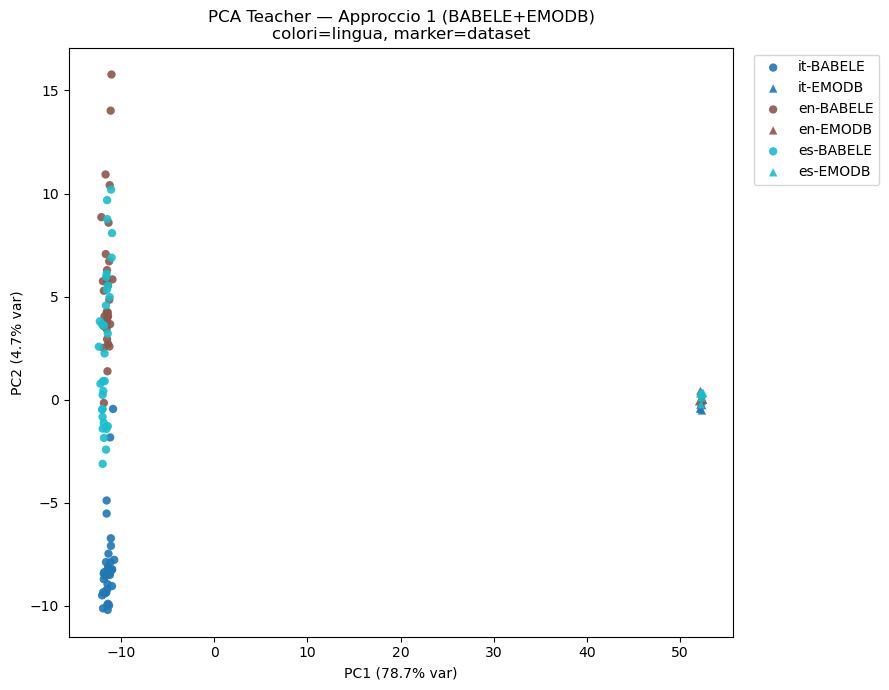

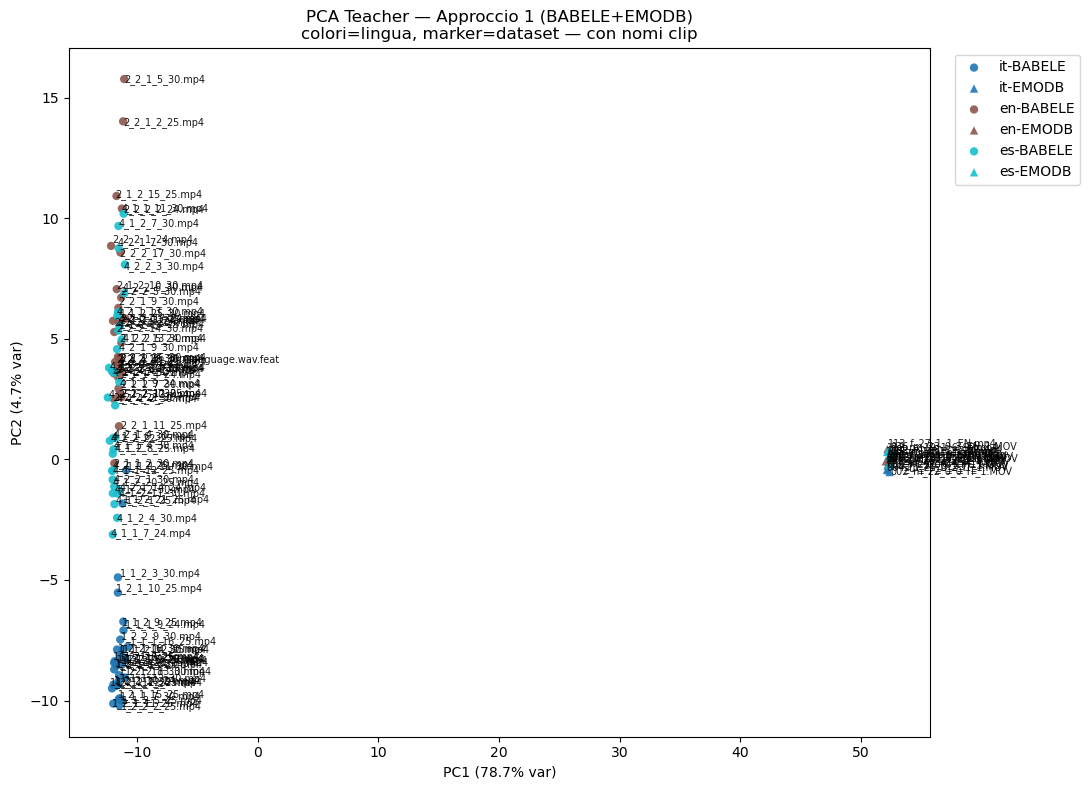

Salvato:
 - fig_pca_sep/pca_app1_markers.pdf
 - fig_pca_sep/pca_app1_markers.png
 - fig_pca_sep/pca_app1_labeled.pdf
 - fig_pca_sep/pca_app1_labeled.png


In [16]:
# -*- coding: utf-8 -*-
# PCA Teacher — Approccio 1 (BABELE+EMODB)
# 1) Plot con soli marker
# 2) Plot con marker + nome clip accanto
import os, os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# === CONFIG: aggiorna i path ai CSV se servono ===
CSV_BABELE = "BABELE/distillation_dataset.csv"
CSV_EMODB  = "EMODB/distillation_dataset.csv"
OUT_DIR    = "fig_pca_sep"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- helper ----------
def find_col(df, candidates):
    m = {c.lower(): c for c in df.columns}
    for cand in candidates:
        for k, orig in m.items():
            if cand in k:
                return orig
    return None

def best_name_row(row, id_col_candidates):
    for c in id_col_candidates:
        if c in row and pd.notna(row[c]) and str(row[c]).strip():
            return Path(str(row[c])).stem
    for key in ["mouth", "feat", "hid", "path", "file"]:
        for col in row.index:
            if key in col.lower() and pd.notna(row[col]):
                try:
                    return Path(str(row[col])).stem
                except Exception:
                    pass
    return None  # fallback handled later

def load_embeddings_with_names(csv_path, ds_name_hint=None):
    if not op.exists(csv_path):
        raise FileNotFoundError(csv_path)
    df = pd.read_csv(csv_path)

    label_col   = find_col(df, ["label","lang","language"])
    dataset_col = find_col(df, ["dataset","source"])
    if label_col is None:
        raise RuntimeError(f"label/lang non trovata in {csv_path}")
    if dataset_col is None:
        df["dataset"] = ds_name_hint or Path(csv_path).parent.name
        dataset_col = "dataset"

    # prefer *.feat.npy, fallback *.hid.npy (media nel tempo)
    feat_col = None; hid_col = None
    for c in df.columns:
        v = str(df[c].iloc[0]) if len(df)>0 else ""
        if "feat" in c.lower() or v.endswith(".feat.npy"):
            feat_col = c; break
    if feat_col is None:
        for c in df.columns:
            v = str(df[c].iloc[0]) if len(df)>0 else ""
            if "hid" in c.lower() and v.endswith(".hid.npy"):
                hid_col = c; break
    if feat_col is None and hid_col is None:
        raise RuntimeError(f"manca colonna con *.feat.npy o *.hid.npy in {csv_path}")

    # possibili colonne id/nome
    id_cands = [c for c in df.columns if c.lower() in
                {"video_id","vid","name","clip","filename","file","basename"}]

    X, y, d, names = [], [], [], []
    for idx, r in df.iterrows():
        lbl = str(r[label_col]).strip()
        ds  = str(r[dataset_col]).strip()
        x = None
        if feat_col and pd.notna(r[feat_col]) and op.exists(str(r[feat_col])):
            arr = np.load(str(r[feat_col]))
            x   = arr.mean(axis=0) if arr.ndim>1 else arr
        elif hid_col and pd.notna(r[hid_col]) and op.exists(str(r[hid_col])):
            arr = np.load(str(r[hid_col]))
            x   = arr.mean(axis=0) if arr.ndim==2 else arr
        if x is None:
            continue
        X.append(x.astype(np.float32)); y.append(lbl); d.append(ds)

        nm = best_name_row(r, id_cands)
        if nm is None:
            nm = f"{ds}_{lbl}_{idx}"
        names.append(nm)
    return np.vstack(X), np.array(y, str), np.array(d, str), np.array(names, str)

# ---------- load data ----------
Xb, yb, db, nb = load_embeddings_with_names(CSV_BABELE, "BABELE")
Xe, ye, de, ne = load_embeddings_with_names(CSV_EMODB,  "EMODB")

X = np.vstack([Xb, Xe])
y = np.concatenate([yb, ye])
d = np.concatenate([db, de])
names = np.concatenate([nb, ne])

# ---------- PCA ----------
Xz = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(Xz)
ev = pca.explained_variance_ratio_ * 100

# ---------- impostazioni comuni ----------
langs = list(dict.fromkeys(y))
datasets = list(dict.fromkeys(d))
markers = ["o","^","s","D","P","X","v","<",">","*","h","+","x"]
m_map = {ds: markers[i % len(markers)] for i, ds in enumerate(datasets)}
palette = plt.cm.get_cmap("tab10", len(langs))
c_map = {lang: palette(i) for i, lang in enumerate(langs)}

def scatter_markers(ax):
    for lang in langs:
        for ds_name in datasets:
            idx = (y==lang) & (d==ds_name)
            if not np.any(idx): 
                continue
            ax.scatter(Z[idx,0], Z[idx,1],
                       c=[c_map[lang]], marker=m_map[ds_name],
                       alpha=0.9, edgecolor='none',
                       label=f"{lang}-{ds_name}")
    ax.set_xlabel(f"PC1 ({ev[0]:.1f}% var)")
    ax.set_ylabel(f"PC2 ({ev[1]:.1f}% var)")
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), bbox_to_anchor=(1.02,1), loc="upper left")

# 1) SOLO MARKER
fig, ax = plt.subplots(figsize=(9,7))
scatter_markers(ax)
ax.set_title("PCA Teacher — Approccio 1 (BABELE+EMODB)\ncolori=lingua, marker=dataset")
plt.tight_layout()
out_pdf = op.join(OUT_DIR, "pca_app1_markers.pdf")
out_png = op.join(OUT_DIR, "pca_app1_markers.png")
plt.savefig(out_pdf, bbox_inches="tight")
plt.savefig(out_png, dpi=200, bbox_inches="tight")
plt.show()

# 2) MARKER + NOMI
fig, ax = plt.subplots(figsize=(11,8))
scatter_markers(ax)
# etichette con leggero jitter per ridurre sovrapposizione
rng = np.random.RandomState(0)
for (xi, yi_, nm) in zip(Z[:,0], Z[:,1], names):
    jx = (rng.rand()-0.5)*0.35
    jy = (rng.rand()-0.5)*0.35
    ax.text(xi + jx, yi_ + jy, nm, fontsize=7, alpha=0.9)
ax.set_title("PCA Teacher — Approccio 1 (BABELE+EMODB)\ncolori=lingua, marker=dataset — con nomi clip")
plt.tight_layout()
out_pdf2 = op.join(OUT_DIR, "pca_app1_labeled.pdf")
out_png2 = op.join(OUT_DIR, "pca_app1_labeled.png")
plt.savefig(out_pdf2, bbox_inches="tight")
plt.savefig(out_png2, dpi=200, bbox_inches="tight")
plt.show()

print("Salvato:")
print(" -", out_pdf)
print(" -", out_png)
print(" -", out_pdf2)
print(" -", out_png2)


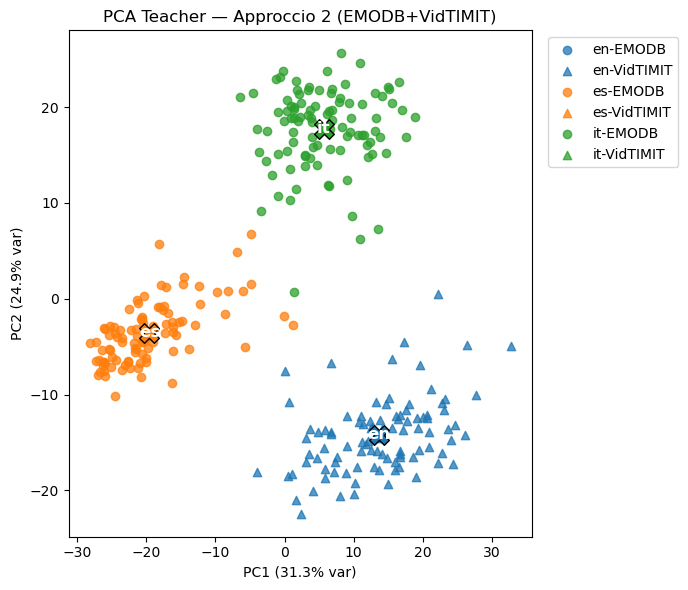

=== Silhouette globale ===
0.706
=== Silhouette per lingua ===
en: 0.495
es: 0.481
it: 0.464
=== Distanze tra centroidi (PCA 2D) ===
en ↔ es: 34.842
en ↔ it: 32.915
es ↔ it: 32.982

Grafico salvato in: fig_app2_analysis/pca_teacher_app2_centroids.pdf
Metriche salvate in: fig_app2_analysis/metrics_app2.csv


In [17]:
# -*- coding: utf-8 -*-
# Analisi Approccio 2: EMODB ↔ VidTIMIT (Teacher)
# ----------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# === CONFIG: path CSV Teacher ===
CSV_EMODB    = "NEWEMODB/distillation_dataset_filtrato.csv"
CSV_VIDTIMIT = "VidTIMIT/distillation_dataset.csv"

OUT_DIR = "fig_app2_analysis"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- helper ----
def find_col(df, candidates):
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        for k, orig in cols.items():
            if cand in k:
                return orig
    return None

def load_embeddings(csv_path, ds_name_hint=None):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV non trovato: {csv_path}")
    df = pd.read_csv(csv_path)

    label_col   = find_col(df, ["label","lang","language"])
    dataset_col = find_col(df, ["dataset","source"])
    if label_col is None:
        raise RuntimeError(f"Nessuna colonna label/lang/language in {csv_path}")
    if dataset_col is None:
        df["dataset"] = ds_name_hint or Path(csv_path).parent.name
        dataset_col = "dataset"

    feat_col = None; hid_col = None
    for c in df.columns:
        v = str(df[c].iloc[0]) if len(df)>0 else ""
        if "feat" in c.lower() or v.endswith(".feat.npy"):
            feat_col = c; break
    if feat_col is None:
        for c in df.columns:
            v = str(df[c].iloc[0]) if len(df)>0 else ""
            if "hid" in c.lower() and v.endswith(".hid.npy"):
                hid_col = c; break
    if feat_col is None and hid_col is None:
        raise RuntimeError(f"Nessuna colonna *.feat.npy o *.hid.npy in {csv_path}")

    X, y, d = [], [], []
    for _, r in df.iterrows():
        lbl = str(r[label_col]).strip()
        ds  = str(r[dataset_col]).strip()
        x = None
        if feat_col and pd.notna(r[feat_col]) and Path(str(r[feat_col])).exists():
            arr = np.load(str(r[feat_col]))
            x   = arr.mean(axis=0) if arr.ndim>1 else arr
        elif hid_col and pd.notna(r[hid_col]) and Path(str(r[hid_col])).exists():
            arr = np.load(str(r[hid_col]))
            x   = arr.mean(axis=0) if arr.ndim==2 else arr
        if x is None:
            continue
        X.append(x.astype(np.float32))
        y.append(lbl)
        d.append(ds)
    return np.vstack(X), np.array(y, dtype=str), np.array(d, dtype=str)

# ---- load the two datasets ----
X1, y1, d1 = load_embeddings(CSV_EMODB, "EMODB")
X2, y2, d2 = load_embeddings(CSV_VIDTIMIT, "VidTIMIT")

X = np.vstack([X1, X2])
y = np.concatenate([y1, y2])
d = np.concatenate([d1, d2])

# ---- PCA ----
Xz = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(Xz)
ev = pca.explained_variance_ratio_ * 100

# ---- Silhouette per lingua ----
sil_global = silhouette_score(Z, y) if len(np.unique(y)) > 1 else np.nan
sil_per_lang = {}
for lang in np.unique(y):
    mask = (y == lang)
    if np.sum(mask) > 1:
        # silhouette su subset lingua vs altre
        labels_bin = np.where(mask, lang, "other")
        sil_per_lang[lang] = silhouette_score(Z, labels_bin)
    else:
        sil_per_lang[lang] = np.nan

# ---- Distanze tra centroidi ----
langs = np.unique(y)
centroids = {lang: Z[y == lang].mean(axis=0) for lang in langs}
distances = {}
for i, l1 in enumerate(langs):
    for l2 in langs[i+1:]:
        dist = np.linalg.norm(centroids[l1] - centroids[l2])
        distances[(l1, l2)] = dist

# ---- Plot PCA con centroidi ----
plt.figure(figsize=(7,6))
colors = {lang: plt.cm.tab10(i) for i, lang in enumerate(langs)}
markers = {ds: m for ds, m in zip(np.unique(d), ["o", "^", "s", "D"])}
for lang in langs:
    for ds_name in np.unique(d):
        idx = (y == lang) & (d == ds_name)
        plt.scatter(Z[idx,0], Z[idx,1], c=[colors[lang]], marker=markers[ds_name],
                    alpha=0.75, label=f"{lang}-{ds_name}")
# centroidi
for lang in langs:
    cx, cy = centroids[lang]
    plt.scatter(cx, cy, c=[colors[lang]], edgecolors='k', s=200, marker='X')
    plt.text(cx, cy, lang, fontsize=12, weight='bold',
             ha='center', va='center', color='white')
plt.xlabel(f"PC1 ({ev[0]:.1f}% var)")
plt.ylabel(f"PC2 ({ev[1]:.1f}% var)")
plt.title("PCA Teacher — Approccio 2 (EMODB+VidTIMIT)")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plot_path = os.path.join(OUT_DIR, "pca_teacher_app2_centroids.pdf")
plt.savefig(plot_path, bbox_inches="tight")
plt.show()

# ---- stampa metriche ----
print("=== Silhouette globale ===")
print(f"{sil_global:.3f}")
print("=== Silhouette per lingua ===")
for lang, val in sil_per_lang.items():
    print(f"{lang}: {val:.3f}")
print("=== Distanze tra centroidi (PCA 2D) ===")
for (l1, l2), dist in distances.items():
    print(f"{l1} ↔ {l2}: {dist:.3f}")

# ---- salva metriche CSV ----
metrics = {
    "silhouette_global": sil_global,
}
metrics.update({f"silhouette_{lang}": val for lang, val in sil_per_lang.items()})
for (l1, l2), dist in distances.items():
    metrics[f"dist_{l1}_{l2}"] = dist
pd.DataFrame([metrics]).to_csv(os.path.join(OUT_DIR, "metrics_app2.csv"), index=False)

print(f"\nGrafico salvato in: {plot_path}")
print(f"Metriche salvate in: {os.path.join(OUT_DIR, 'metrics_app2.csv')}")


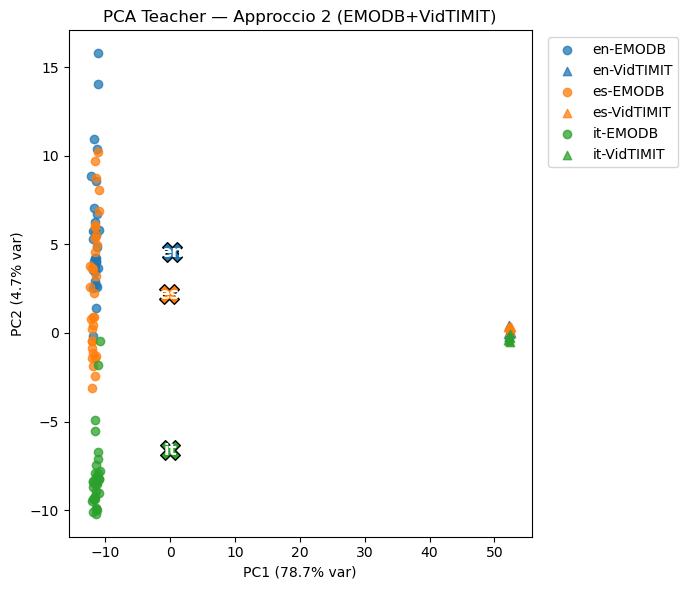

=== Silhouette globale ===
0.086
=== Silhouette per lingua ===
en: 0.088
es: 0.012
it: 0.243
=== Distanze tra centroidi (PCA 2D) ===
en ↔ es: 2.404
en ↔ it: 11.178
es ↔ it: 8.821

Grafico salvato in: fig_app2_analysis/pca_teacher_app2_centroids.pdf
Metriche salvate in: fig_app2_analysis/metrics_app2.csv


In [21]:
# -*- coding: utf-8 -*-
# Analisi Approccio 2: EMODB ↔ VidTIMIT (Teacher)
# ----------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# === CONFIG: path CSV Teacher ===
CSV_EMODB    = "BABELE/distillation_dataset.csv"
CSV_VIDTIMIT = "EMODB/distillation_dataset.csv"

OUT_DIR = "fig_app2_analysis"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- helper ----
def find_col(df, candidates):
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        for k, orig in cols.items():
            if cand in k:
                return orig
    return None

def load_embeddings(csv_path, ds_name_hint=None):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV non trovato: {csv_path}")
    df = pd.read_csv(csv_path)

    label_col   = find_col(df, ["label","lang","language"])
    dataset_col = find_col(df, ["dataset","source"])
    if label_col is None:
        raise RuntimeError(f"Nessuna colonna label/lang/language in {csv_path}")
    if dataset_col is None:
        df["dataset"] = ds_name_hint or Path(csv_path).parent.name
        dataset_col = "dataset"

    feat_col = None; hid_col = None
    for c in df.columns:
        v = str(df[c].iloc[0]) if len(df)>0 else ""
        if "feat" in c.lower() or v.endswith(".feat.npy"):
            feat_col = c; break
    if feat_col is None:
        for c in df.columns:
            v = str(df[c].iloc[0]) if len(df)>0 else ""
            if "hid" in c.lower() and v.endswith(".hid.npy"):
                hid_col = c; break
    if feat_col is None and hid_col is None:
        raise RuntimeError(f"Nessuna colonna *.feat.npy o *.hid.npy in {csv_path}")

    X, y, d = [], [], []
    for _, r in df.iterrows():
        lbl = str(r[label_col]).strip()
        ds  = str(r[dataset_col]).strip()
        x = None
        if feat_col and pd.notna(r[feat_col]) and Path(str(r[feat_col])).exists():
            arr = np.load(str(r[feat_col]))
            x   = arr.mean(axis=0) if arr.ndim>1 else arr
        elif hid_col and pd.notna(r[hid_col]) and Path(str(r[hid_col])).exists():
            arr = np.load(str(r[hid_col]))
            x   = arr.mean(axis=0) if arr.ndim==2 else arr
        if x is None:
            continue
        X.append(x.astype(np.float32))
        y.append(lbl)
        d.append(ds)
    return np.vstack(X), np.array(y, dtype=str), np.array(d, dtype=str)

# ---- load the two datasets ----
X1, y1, d1 = load_embeddings(CSV_EMODB, "EMODB")
X2, y2, d2 = load_embeddings(CSV_VIDTIMIT, "VidTIMIT")

X = np.vstack([X1, X2])
y = np.concatenate([y1, y2])
d = np.concatenate([d1, d2])

# ---- PCA ----
Xz = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(Xz)
ev = pca.explained_variance_ratio_ * 100

# ---- Silhouette per lingua ----
sil_global = silhouette_score(Z, y) if len(np.unique(y)) > 1 else np.nan
sil_per_lang = {}
for lang in np.unique(y):
    mask = (y == lang)
    if np.sum(mask) > 1:
        # silhouette su subset lingua vs altre
        labels_bin = np.where(mask, lang, "other")
        sil_per_lang[lang] = silhouette_score(Z, labels_bin)
    else:
        sil_per_lang[lang] = np.nan

# ---- Distanze tra centroidi ----
langs = np.unique(y)
centroids = {lang: Z[y == lang].mean(axis=0) for lang in langs}
distances = {}
for i, l1 in enumerate(langs):
    for l2 in langs[i+1:]:
        dist = np.linalg.norm(centroids[l1] - centroids[l2])
        distances[(l1, l2)] = dist

# ---- Plot PCA con centroidi ----
plt.figure(figsize=(7,6))
colors = {lang: plt.cm.tab10(i) for i, lang in enumerate(langs)}
markers = {ds: m for ds, m in zip(np.unique(d), ["o", "^", "s", "D"])}
for lang in langs:
    for ds_name in np.unique(d):
        idx = (y == lang) & (d == ds_name)
        plt.scatter(Z[idx,0], Z[idx,1], c=[colors[lang]], marker=markers[ds_name],
                    alpha=0.75, label=f"{lang}-{ds_name}")
# centroidi
for lang in langs:
    cx, cy = centroids[lang]
    plt.scatter(cx, cy, c=[colors[lang]], edgecolors='k', s=200, marker='X')
    plt.text(cx, cy, lang, fontsize=12, weight='bold',
             ha='center', va='center', color='white')
plt.xlabel(f"PC1 ({ev[0]:.1f}% var)")
plt.ylabel(f"PC2 ({ev[1]:.1f}% var)")
plt.title("PCA Teacher — Approccio 2 (EMODB+VidTIMIT)")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plot_path = os.path.join(OUT_DIR, "pca_teacher_app2_centroids.pdf")
plt.savefig(plot_path, bbox_inches="tight")
plt.show()

# ---- stampa metriche ----
print("=== Silhouette globale ===")
print(f"{sil_global:.3f}")
print("=== Silhouette per lingua ===")
for lang, val in sil_per_lang.items():
    print(f"{lang}: {val:.3f}")
print("=== Distanze tra centroidi (PCA 2D) ===")
for (l1, l2), dist in distances.items():
    print(f"{l1} ↔ {l2}: {dist:.3f}")

# ---- salva metriche CSV ----
metrics = {
    "silhouette_global": sil_global,
}
metrics.update({f"silhouette_{lang}": val for lang, val in sil_per_lang.items()})
for (l1, l2), dist in distances.items():
    metrics[f"dist_{l1}_{l2}"] = dist
pd.DataFrame([metrics]).to_csv(os.path.join(OUT_DIR, "metrics_app2.csv"), index=False)

print(f"\nGrafico salvato in: {plot_path}")
print(f"Metriche salvate in: {os.path.join(OUT_DIR, 'metrics_app2.csv')}")


In [13]:
# PREPARE DATA PER EMODB !!!!!
import os, cv2, json, numpy as np, pandas as pd
from tqdm import tqdm
import face_alignment
from face_alignment import FaceAlignment

# caso in cui se va fuori frame non dovrebbe tcnicamente bloccarsi
def mouth_roi(frame, landmarks, size=96, scale=1.4):
    h_frame, w_frame = frame.shape[:2]
    pts = landmarks[48:68]
    cx, cy = pts.mean(axis=0)
    w = max(np.ptp(pts[:,0]), np.ptp(pts[:,1])) * scale

    # coords originali
    x1 = int(cx - w/2)
    y1 = int(cy - w/2)
    x2 = int(cx + w/2)
    y2 = int(cy + w/2)

    # clipping ai bordi
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(w_frame, x2)
    y2 = min(h_frame, y2)

    # se crop vuoto o negativo, skip
    if x2 <= x1 or y2 <= y1:
        return None

    crop = frame[y1:y2, x1:x2]
    if crop.size == 0:
        return None

    return cv2.resize(crop, (size, size))


# Init FaceAlignment su CPU
fa      = FaceAlignment(face_alignment.LandmarksType.TWO_D, device="cpu")
distill = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/distillation_dataset.csv"
out_dir = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/video_mouth"
os.makedirs(out_dir, exist_ok=True)

# Leggi manifest (segments come come JSON string)
mani = pd.read_csv(distill, dtype={"segments": str})
mouth_paths = []

for idx, row in tqdm(mani.iterrows(), total=len(mani), desc="Crop Video"):
    video_path = row["video_path"]
    outp = os.path.join(out_dir, os.path.basename(video_path) + ".npy")

    print(f"\n▶️ Video {idx+1}/{len(mani)}: {os.path.basename(video_path)}")

    if os.path.exists(outp):
        print(f"▶️ [{idx+1}/{len(mani)}] {os.path.basename(video_path)} già processato, skip")
        mouth_paths.append(outp)
        continue
    # Carica i segmenti di parlato
    segments = json.loads(row["segments"])
    cap      = cv2.VideoCapture(video_path)
    fps      = cap.get(cv2.CAP_PROP_FPS) or 25
    frames   = []

    # Loop sui segmenti
    for seg_i, (start_s, end_s) in enumerate(segments, 1):
        start_f = int(start_s * fps)
        end_f   = int(end_s   * fps)
        print(f"  Segmento {seg_i}/{len(segments)} → frames {start_f}–{end_f}")
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_f)

        # Loop sui singoli frame
        for f in range(start_f, end_f):
            print(f" Frame {f}")
            ok, frame = cap.read()
            if not ok:
                break
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
            lm = fa.get_landmarks(frame)
            if lm is None or len(lm) == 0:
                print(f"     ⚠️ Nessun landmark al frame {f}")
                continue

            roi = mouth_roi(frame, lm[0])
            if roi is None:
                continue

            frames.append(roi)

    cap.release()

    print(f"  Estratti {len(frames)} frame totali per questo video")
    if not frames:
        mouth_paths.append("")
        continue

    arr  = np.stack(frames).astype("uint8")
    outp = os.path.join(out_dir, os.path.basename(video_path) + ".npy")
    np.save(outp, arr)
    mouth_paths.append(outp)
    print(f"  ✅ Salvati {len(frames)} frame in {outp}")

# Aggiorna manifest
mani["mouth_path"] = mouth_paths
mani.to_csv(distill, index=False)


Crop Video:   0%|          | 0/21 [00:00<?, ?it/s]


▶️ Video 1/21: 103_f_18_1_2_SP.mp4
▶️ [1/21] 103_f_18_1_2_SP.mp4 già processato, skip

▶️ Video 2/21: 106_m_18_1_4_SP.mp4
▶️ [2/21] 106_m_18_1_4_SP.mp4 già processato, skip

▶️ Video 3/21: 102_m_18_1_1_SP.mp4
▶️ [3/21] 102_m_18_1_1_SP.mp4 già processato, skip

▶️ Video 4/21: 105_m_18_1_3_SP.mp4
▶️ [4/21] 105_m_18_1_3_SP.mp4 già processato, skip

▶️ Video 5/21: 101_f_23_1_0_SP.mp4
▶️ [5/21] 101_f_23_1_0_SP.mp4 già processato, skip

▶️ Video 6/21: 112_m_19_1_6_SP.mp4
▶️ [6/21] 112_m_19_1_6_SP.mp4 già processato, skip

▶️ Video 7/21: 111_m_23_1_5_SP.mp4
▶️ [7/21] 111_m_23_1_5_SP.mp4 già processato, skip

▶️ Video 8/21: 120_m_29_1_5_EN.mp4
▶️ [8/21] 120_m_29_1_5_EN.mp4 già processato, skip

▶️ Video 9/21: 118_m_23_1_6_EN.mp4
▶️ [9/21] 118_m_23_1_6_EN.mp4 già processato, skip

▶️ Video 10/21: 113_f_27_1_1_EN.mp4
▶️ [10/21] 113_f_27_1_1_EN.mp4 già processato, skip

▶️ Video 11/21: 003_f_21_0_1_IT_1.MOV
▶️ [11/21] 003_f_21_0_1_IT_1.MOV già processato, skip

▶️ Video 12/21: 002_m_22_0_0_IT_1.

Crop Video: 100%|██████████| 21/21 [07:27<00:00, 21.29s/it]

  Estratti 147 frame totali per questo video
  ✅ Salvati 147 frame in /Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/video_mouth/010_m_26_0_5_IT_1.MOV.npy


In [10]:
# prepare_data.py (segment-aligned + debug prints)
import os, cv2, json, numpy as np, pandas as pd
from tqdm import tqdm
import face_alignment
from face_alignment import FaceAlignment

# caso in cui se va fuori frame non dovrebbe tcnicamente bloccarsi
def mouth_roi(frame, landmarks, size=96, scale=1.4):
    h_frame, w_frame = frame.shape[:2]
    pts = landmarks[48:68]
    cx, cy = pts.mean(axis=0)
    w = max(np.ptp(pts[:,0]), np.ptp(pts[:,1])) * scale

    # coords originali
    x1 = int(cx - w/2)
    y1 = int(cy - w/2)
    x2 = int(cx + w/2)
    y2 = int(cy + w/2)

    # clipping ai bordi
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(w_frame, x2)
    y2 = min(h_frame, y2)

    # se crop vuoto o negativo, skip
    if x2 <= x1 or y2 <= y1:
        return None

    crop = frame[y1:y2, x1:x2]
    if crop.size == 0:
        return None

    return cv2.resize(crop, (size, size))


# Init FaceAlignment su CPU
fa      = FaceAlignment(face_alignment.LandmarksType.TWO_D, device="cpu")
distill = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/distillation_dataset.csv"
out_dir = "video_mouth"
os.makedirs(out_dir, exist_ok=True)

# Leggi manifest (segments come come JSON string)
mani = pd.read_csv(distill, dtype={"segments": str})
mouth_paths = []

for idx, row in tqdm(mani.iterrows(), total=len(mani), desc="Crop Video"):
    video_path = row["video_path"]
    outp = os.path.join(out_dir, os.path.basename(video_path) + ".npy")

    print(f"\n▶️ Video {idx+1}/{len(mani)}: {os.path.basename(video_path)}")

    if os.path.exists(outp):
        print(f"▶️ [{idx+1}/{len(mani)}] {os.path.basename(video_path)} già processato, skip")
        mouth_paths.append(outp)
        continue
    # Carica i segmenti di parlato
    segments = json.loads(row["segments"])
    cap      = cv2.VideoCapture(video_path)
    fps      = cap.get(cv2.CAP_PROP_FPS) or 25
    frames   = []

    # Loop sui segmenti
    for seg_i, (start_s, end_s) in enumerate(segments, 1):
        start_f = int(start_s * fps)
        end_f   = int(end_s   * fps)
        print(f"  Segmento {seg_i}/{len(segments)} → frames {start_f}–{end_f}")
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_f)

        # Loop sui singoli frame
        for f in range(start_f, end_f):
            print(f" Frame {f}")
            ok, frame = cap.read()
            if not ok:
                break
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
            lm = fa.get_landmarks(frame)
            if lm is None or len(lm) == 0:
                print(f"     ⚠️ Nessun landmark al frame {f}")
                continue

            roi = mouth_roi(frame, lm[0])
            if roi is None:
                continue

            frames.append(roi)

    cap.release()

    print(f"  Estratti {len(frames)} frame totali per questo video")
    if not frames:
        mouth_paths.append("")
        continue

    arr  = np.stack(frames).astype("uint8")
    outp = os.path.join(out_dir, os.path.basename(video_path) + ".npy")
    np.save(outp, arr)
    mouth_paths.append(outp)
    print(f"  ✅ Salvati {len(frames)} frame in {outp}")

# Aggiorna manifest
mani["mouth_path"] = mouth_paths
mani.to_csv(distill, index=False)


Crop Video:   0%|          | 0/95 [00:00<?, ?it/s]


▶️ Video 1/95: 1_1_2_21_25.mp4
▶️ [1/95] 1_1_2_21_25.mp4 già processato, skip

▶️ Video 2/95: 1_2_2_9_30.mp4
▶️ [2/95] 1_2_2_9_30.mp4 già processato, skip

▶️ Video 3/95: 1_2_1_18_30.mp4
▶️ [3/95] 1_2_1_18_30.mp4 già processato, skip

▶️ Video 4/95: 1_2_2_13_30.mp4
▶️ [4/95] 1_2_2_13_30.mp4 già processato, skip

▶️ Video 5/95: 1_1_2_15_25.mp4
▶️ [5/95] 1_1_2_15_25.mp4 già processato, skip

▶️ Video 6/95: 1_1_1_12_30.mp4
▶️ [6/95] 1_1_1_12_30.mp4 già processato, skip

▶️ Video 7/95: 1_2_1_4_25.mp4
▶️ [7/95] 1_2_1_4_25.mp4 già processato, skip

▶️ Video 8/95: 1_2_1_8_25.mp4
▶️ [8/95] 1_2_1_8_25.mp4 già processato, skip

▶️ Video 9/95: 1_2_1_12_25.mp4
▶️ [9/95] 1_2_1_12_25.mp4 già processato, skip

▶️ Video 10/95: 1_1_1_9_24.mp4
▶️ [10/95] 1_1_1_9_24.mp4 già processato, skip

▶️ Video 11/95: 1_1_1_16_25.mp4
▶️ [11/95] 1_1_1_16_25.mp4 già processato, skip

▶️ Video 12/95: 1_1_1_14_30.mp4
▶️ [12/95] 1_1_1_14_30.mp4 già processato, skip

▶️ Video 13/95: 1_2_1_10_25.mp4
▶️ [13/95] 1_2_1_10_2

/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/face_alignment/api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")


     ⚠️ Nessun landmark al frame 14397
 Frame 14398
     ⚠️ Nessun landmark al frame 14398
 Frame 14399
     ⚠️ Nessun landmark al frame 14399
 Frame 14400
     ⚠️ Nessun landmark al frame 14400
 Frame 14401
     ⚠️ Nessun landmark al frame 14401
 Frame 14402
     ⚠️ Nessun landmark al frame 14402
 Frame 14403
     ⚠️ Nessun landmark al frame 14403
 Frame 14404
     ⚠️ Nessun landmark al frame 14404
 Frame 14405
     ⚠️ Nessun landmark al frame 14405
 Frame 14406
     ⚠️ Nessun landmark al frame 14406
 Frame 14407
     ⚠️ Nessun landmark al frame 14407
 Frame 14408


Crop Video:  63%|██████▎   | 60/95 [00:03<00:02, 16.93it/s]

     ⚠️ Nessun landmark al frame 14408
 Frame 14409


KeyboardInterrupt: 

In [18]:
# split per l,a validation - sta qua così può essere cambiata
# split_manifest.py
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

SEED = 42
CSV_IN  = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/distillation_dataset.csv"      # creato dal tuo prepare_data.py
TRAIN_CSV = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_train.csv"
VAL_CSV   = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_val.csv"
TEST_CSV  = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_test.csv"

# 1. carica il dataset e filtra clip con crop vuoto
df = pd.read_csv(CSV_IN)
df = df[df["mouth_path"].str.len() > 0].reset_index(drop=True)

# 2. mappatura label → int per stratificazione
lang2id = {"en":0, "it":1, "es":2}
y = df["label"].map(lang2id)

# 3. train 70 %, temp 30 %
train_df, temp_df, y_train, y_temp = train_test_split(
        df, y, test_size=0.30, stratify=y, random_state=SEED)

# 4. val 15 %, test 15 % (split 50 / 50 del restante 30 %)
val_df, test_df = train_test_split(
        temp_df, test_size=0.50, stratify=y_temp, random_state=SEED)

# 5. salva i tre file
train_df.to_csv(TRAIN_CSV, index=False)
val_df.to_csv(VAL_CSV,     index=False)
test_df.to_csv(TEST_CSV,   index=False)

print(f"Totale clip valide: {len(df)}")
print(f" Train: {len(train_df)}  Val: {len(val_df)}  Test: {len(test_df)}")


Totale clip valide: 94
 Train: 65  Val: 14  Test: 15


In [23]:
# dataset.py
import json, numpy as np, pandas as pd, torch

class LanguageDataset(torch.utils.data.Dataset):
    lang2id = {"en":0, "it":1, "es":2}
    def __init__(self, manifest, max_len=64):
        self.df = pd.read_csv(manifest)
        self.L  = max_len                    # lunghezza fissa

    def _temporal_fix(self, arr):
        T = len(arr)
        if T >= self.L:                                  # campiona L index equispaziati
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:                                            # pad copiando l’ultimo frame
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]

    def __len__(self):  return len(self.df)

    def __getitem__(self, idx):
        r   = self.df.iloc[idx]
        # dataset.py  (metodo __getitem__)
        vid = self._temporal_fix(np.load(r.mouth_path)) / 255.0   # (T,H,W,3)
        vid = torch.from_numpy(vid).permute(3,0,1,2).float()      # (3,T,H,W)
        vid = (vid - 0.5) / 0.5

        # — carico soft-target e embedding audio medio
        with open(r.probs_path) as f:
            p = json.load(f)
        probs = torch.tensor([p["en"], p["it"], p["es"]])

        emb = torch.from_numpy(np.load(r.hid_path))              # [768] (embedding medio)
        
        # — **carico la sequenza di hidden states** del teacher
        feat_seq = torch.from_numpy(np.load(r.feats_path))       # [Tₐ, 768]

        y = self.lang2id[r.label]
        return vid, probs, emb, feat_seq, y


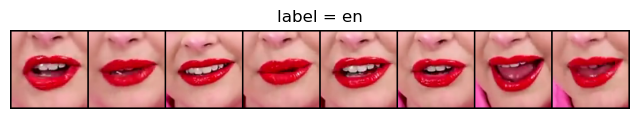

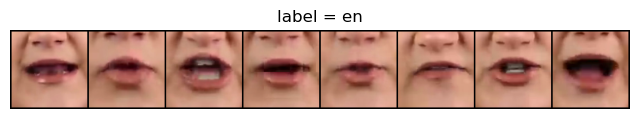

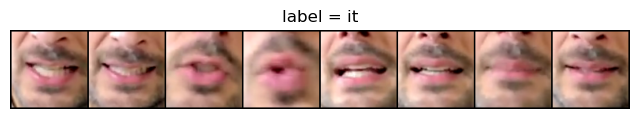

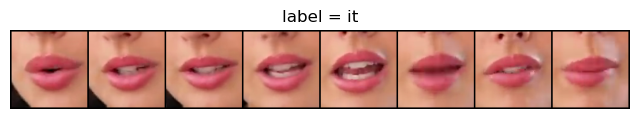

In [39]:
# ───────── Visualizza 4 clip random (8 frame ciascuno) ─────────
import random, matplotlib.pyplot as plt, torchvision.utils as vutils

val_set = LanguageDataset("/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/distillation_dataset.csv", max_len=32)

for idx in random.sample(range(len(val_set)), 4):
    vid, _, _,_,lab = val_set[idx]          # vid: (C,T,H,W), float32 0–1
    frames = vid[:, :8]                    # (C,8,H,W)
    frames = frames.permute(1, 0, 2, 3)    # → (8,C,H,W) per make_grid

    grid = vutils.make_grid(frames, nrow=8, normalize=True)  # (C,H,W)
    img  = grid.permute(1, 2, 0).cpu().numpy()               # (H,W,C)
    label = 'en' if lab == 0 else 'it' if lab == 1 else 'sp' if lab == 2 else None

    plt.figure(figsize=(8, 2))
    plt.title(f"label = {label}")
    plt.imshow(img)
    plt.axis("off")
    plt.show()


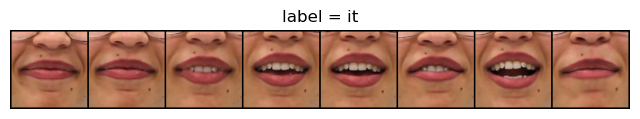

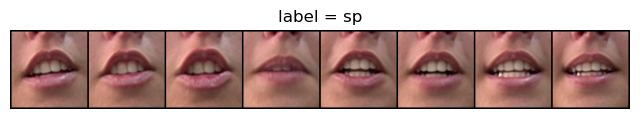

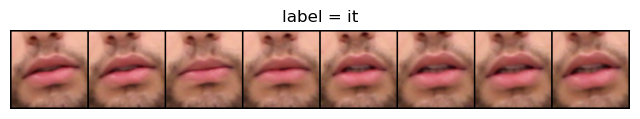

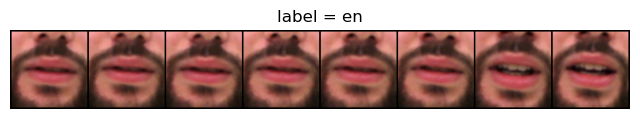

In [40]:
# ───────── Visualizza 4 clip random (8 frame ciascuno) ─────────
import random, matplotlib.pyplot as plt, torchvision.utils as vutils

# Carica il dataset da CSV (modifica max_len se necessario)
val_set = LanguageDataset("EMODB/distillation_dataset.csv", max_len=32)

# Estrai e mostra 4 clip casuali
for idx in random.sample(range(len(val_set)), 4):
    vid, _,_,_,  lab = val_set[idx]          # vid: (C,T,H,W), float32 in [0,1]
    frames = vid[:, :8]                    # Primi 8 frame (C,8,H,W)
    frames = frames.permute(1, 0, 2, 3)    # → (8,C,H,W)

    grid = vutils.make_grid(frames, nrow=8, normalize=True)
    img  = grid.permute(1, 2, 0).cpu().numpy()  # → (H,W,C)
    label = 'en' if lab == 0 else 'it' if lab == 1 else 'sp' if lab == 2 else None

    plt.figure(figsize=(8, 2))
    plt.title(f"label = {label}")
    plt.imshow(img)
    plt.axis("off")
    plt.show()


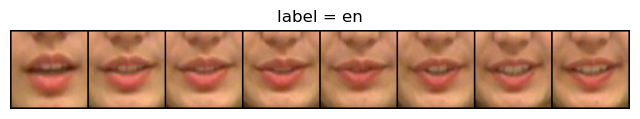

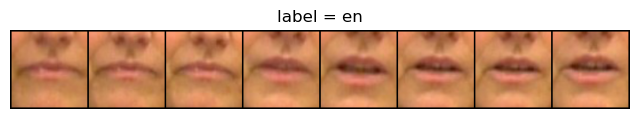

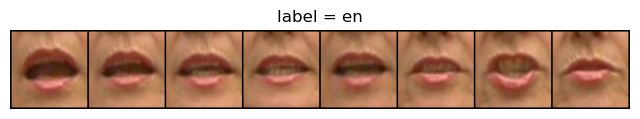

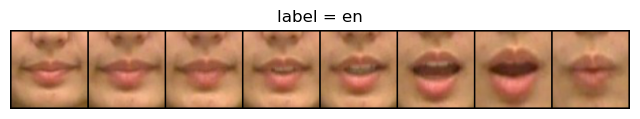

In [41]:
# ───────── Visualizza 4 clip random (8 frame ciascuno) ─────────
import random, matplotlib.pyplot as plt, torchvision.utils as vutils

# Carica il dataset da CSV (modifica max_len se necessario)
val_set = LanguageDataset("VidTIMIT/distillation_dataset.csv", max_len=32)

# Estrai e mostra 4 clip casuali
for idx in random.sample(range(len(val_set)), 4):
    vid, _,_,_,  lab = val_set[idx]          # vid: (C,T,H,W), float32 in [0,1]
    frames = vid[:, :8]                    # Primi 8 frame (C,8,H,W)
    frames = frames.permute(1, 0, 2, 3)    # → (8,C,H,W)

    grid = vutils.make_grid(frames, nrow=8, normalize=True)
    img  = grid.permute(1, 2, 0).cpu().numpy()  # → (H,W,C)
    label = 'en' if lab == 0 else 'it' if lab == 1 else 'sp' if lab == 2 else None

    plt.figure(figsize=(8, 2))
    plt.title(f"label = {label}")
    plt.imshow(img)
    plt.axis("off")
    plt.show()


# STUDENT CON CONVLSTM

In [172]:
#STUDENT CONV-BLSTM 

import torch
import torch.nn as nn
import torch.nn.functional as F

# ───────────────── ConvLSTM cell ──────────────────
class ConvLSTMCell(nn.Module):
    def __init__(self, in_ch, hid_ch, k=3):
        super().__init__()
        pad = k // 2
        self.conv = nn.Conv2d(in_ch + hid_ch, 4 * hid_ch, k, padding=pad)

    def forward(self, x, h, c):
        # x: [B, C, H, W], h,c: [B, Hc, H, W]
        comb = torch.cat([x, h], 1)
        i,f,o,g = self.conv(comb).chunk(4, 1)
        i, f, o = map(torch.sigmoid, (i, f, o))
        g = torch.tanh(g)
        c = f * c + i * g
        h = o * torch.tanh(c)
        return h, c

# ──────────── LipStudent + ConvLSTM ───────────────
class LipStudentConvLSTM(nn.Module):
    def __init__(self, audio_dim=768, d_emb=256, n_classes=3, hid_ch=256):
        super().__init__()

        # ① Front-end spaziotemporale leggero (2 conv 3D)
        self.front = nn.Sequential(
            nn.Conv3d(3, 32, (3,5,5), (1,2,2), 1),
            nn.BatchNorm3d(32), nn.ReLU(),
            nn.Conv3d(32, 64, (3,3,3), 1, 1),
            nn.BatchNorm3d(64), nn.ReLU()
        )

        # output shape → [B,64,T,H/4,W/4]

        # ② ConvLSTM sul piano spaziale
        self.clstm = ConvLSTMCell(64, hid_ch)      # 256 canali hidden

        # ③ Testa classificazione / embedding
        self.gap     = nn.AdaptiveAvgPool2d(1)
        self.fc_emb  = nn.Linear(hid_ch, d_emb)
        self.fc_cls  = nn.Linear(d_emb, n_classes)

        # ④ Proiezione teacher-audio (congelata)
        self.Pa = nn.Linear(audio_dim, d_emb, bias=False)

    def forward(self, x, emb_t, feat_t_seq=None):
        """
        x: [B, 3, T, H, W]   (frame RGB 96×96)
        emb_t: [B, 1280]     (embedding audio Whisper)
        """
        B, C, T, H, W = x.shape
        feat = self.front(x)                  # [B, 64, T, H', W']
        # salvo questa map per distillazione inter-strato
        feat_video = feat                     # [B, 64, T, H', W']

        # continuo come prima
        feat_lstm = feat.permute(2,0,1,3,4)   # [T, B, 64, H', W']
        Hc, Wc = feat_video.shape[-2:]
        h = feat_video.new_zeros(B, self.clstm.conv.out_channels//4, Hc, Wc)
        c = h.clone()
        for t in range(T):
            h, c = self.clstm(feat_lstm[t], h, c)

        h_pool = self.gap(h).flatten(1)        # [B, hid_ch]
        e_v    = self.fc_emb(h_pool)           
        logits_v = self.fc_cls(e_v)            

        proj_a = self.Pa(emb_t)                # [B, 256]
        # se non viene passato feat_t_seq, ignoro distillazione intermedia
        return logits_v, e_v, proj_a, feat_video



In [45]:

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time

# ---------------- Dataset & loader --------------------------
train_set = LanguageDataset(
    "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_train.csv",
    max_len=32
)
val_set   = LanguageDataset(
    "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_val.csv",
    max_len=32
)

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=8, shuffle=False)

# ---------------- Model -------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LipStudentConvLSTM(audio_dim=768, hid_ch=256).to(device)



# ---------------- utility: eval -----------------------------
def evaluate(net):
    net.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for v, _, e, feat_t_seq, y in val_loader:
            v, e = v.to(device), e.to(device)
            _, _, _, feat_video = net(v, e, feat_t_seq.to(device))
            # In validazione per ora non distilliamo, prendiamo solo logits:
            logits = net(v, e, feat_t_seq.to(device))[0]
            y_true.extend(y.tolist())
            y_pred.extend(logits.argmax(1).cpu().tolist())

    acc = accuracy_score(y_true, y_pred)
    f1  = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )[2]
    return acc, f1

# ---------------- debug iniziale delle shape ----------------

v_dbg, p_dbg, emb_dbg, feat_dbg, y_dbg = next(iter(train_loader))
v_dbg, feat_dbg = v_dbg.to(device), feat_dbg.to(device)
dummy_logits, dummy_e_v, dummy_pa, dummy_feat_vid = net(
    v_dbg, torch.zeros(len(v_dbg),768).to(device), feat_dbg
)
print(">>> DEBUG SHAPES")
print("vid:",       v_dbg.shape)            # es. (B, 3, 32, 96, 96)
print("feat_t_seq:", feat_dbg.shape)        # es. (B, Tₐ, 768)
print("feat_video:", dummy_feat_vid.shape)   # es. (B, 64, T_vid, H', W')

# ============================================================
T_temperature = 2.0
A_cfg = dict(λ_CE=0.0, λ_KL=1.0, λ_MSE=0.2, epochs=12, lr=1e-4)
B_cfg = dict(λ_CE=1.0, λ_KL=0.3, λ_MSE=0.05, epochs=18, lr=1e-4)

# ============================================================
#  🔹  FASE A — KD-only (soft-label + feature-distillation)
# ============================================================

#
params_senza_Pa = [p for n,p in net.named_parameters() if "Pa" not in n]
params_Pa       = [p for n,p in net.named_parameters() if "Pa" in n]

opt = optim.AdamW([
    {"params": params_senza_Pa, "lr": A_cfg["lr"]},
    {"params": params_Pa,       "lr": A_cfg["lr"] * 0.1}
], weight_decay=1e-4)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=A_cfg["epochs"])
best_f1 = 0.0

print("\n▶️  FASE A  KD-only (debug)")

for ep in range(A_cfg["epochs"]):
    net.train()
    t0 = time.time()

    for i, (v, p, emb_t, feat_t_seq, _) in enumerate(train_loader):
        v, p, emb_t, feat_t_seq = [t.to(device) for t in (v, p, emb_t, feat_t_seq)]
        p = p / p.sum(-1, keepdim=True)

        # Forward pass (ottengo anche feat_video)
        logits_v, e_v, proj_a, feat_video = net(v, emb_t, feat_t_seq)

        # 1) KD loss (soft-label da teacher)
        kd = F.kl_div(
            F.log_softmax(logits_v / T_temperature, dim=-1),
            p,
            reduction="batchmean"
        ) * (T_temperature * T_temperature)

        # 2) MSE loss sull’embedding finale (video vs. proiezione audio)
        mse_emb = F.mse_loss(e_v, proj_a)

        # 3) Feature-distillation intermedia (L2 tra feat_video e feat_t_seq)
        B, Cv, T_vid, Hp, Wp = feat_video.shape
        feat_vid_pool = feat_video.view(B, Cv, T_vid, -1).mean(dim=-1)  # [B, 64, T_vid]
        feat_vid_t    = feat_vid_pool.permute(0, 2, 1)                 # [B, T_vid, 64]

        W_pa          = net.Pa.weight.t()[..., :64]   # [768, 64]
        proj_feat_t   = torch.matmul(feat_t_seq, W_pa)  # [B, Tₐ, 64]
        if proj_feat_t.shape[1] != T_vid:
            proj_feat_t = F.interpolate(
                proj_feat_t.permute(0, 2, 1),
                size=T_vid,
                mode="linear",
                align_corners=False
            ).permute(0, 2, 1)  # [B, T_vid, 64]

        mse_feat = F.mse_loss(feat_vid_t, proj_feat_t)

        # BILANCIAMENTO LOSS: riduco molto peso di mse_feat a 0.01
        loss = (
            A_cfg["λ_KL"]  * kd +
            A_cfg["λ_MSE"] * mse_emb +
            0.01 * mse_feat
        )

        # —— DEBUG: stampo una volta per batch il valore dei singoli termini ——
        if i % 50 == 0:
            print(f"  [ep{i}/batch{i}] kd={kd.item():.4f}, mse_emb={mse_emb.item():.4f}, mse_feat={mse_feat.item():.4f}, loss={loss.item():.4f}")

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 5)
        opt.step()

    sched.step()
    acc, f1 = evaluate(net)
    print(f"A ep{ep:02d}  acc {acc:.3f}  f1 {f1:.3f}  (time {time.time() - t0:.1f}s)")
    if f1 > best_f1:
        best_f1 = f1
        torch.save(net.state_dict(), "student_best_kd.pt")

print(f"✓ fine Fase A  |  best F1 {best_f1:.3f}")

# ============================================================
#  🔹  FASE B — KD + CE (multilivello completo)
# ============================================================

net.load_state_dict(torch.load("student_best_kd.pt"))

# (ri-creo l’optimizer con Pa “soffice” — cf. sopra)
params_senza_Pa = [p for n,p in net.named_parameters() if "Pa" not in n]
params_Pa       = [p for n,p in net.named_parameters() if "Pa" in n]

opt = optim.AdamW([
    {"params": params_senza_Pa, "lr": B_cfg["lr"]},
    {"params": params_Pa,       "lr": B_cfg["lr"] * 0.1}
], weight_decay=1e-4)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=B_cfg["epochs"])

print("\n▶️  FASE B  KD + CE (debug)")

for ep in range(B_cfg["epochs"]):
    net.train()
    t0 = time.time()

    for i, (v, p, emb_t, feat_t_seq, y) in enumerate(train_loader):
        v, p, emb_t, feat_t_seq, y = [t.to(device) for t in (v, p, emb_t, feat_t_seq, y)]
        p = p / p.sum(-1, keepdim=True)

        logits_v, e_v, proj_a, feat_video = net(v, emb_t, feat_t_seq)

        ce      = F.cross_entropy(logits_v, y)
        kd      = F.kl_div(
                     F.log_softmax(logits_v / T_temperature, dim=-1),
                     p,
                     reduction="batchmean"
                  ) * (T_temperature * T_temperature)
        mse_emb = F.mse_loss(e_v, proj_a)

        B, Cv, T_vid, Hp, Wp = feat_video.shape
        feat_vid_pool = feat_video.view(B, Cv, T_vid, -1).mean(dim=-1)  # [B,64,T_vid]
        feat_vid_t    = feat_vid_pool.permute(0, 2, 1)                 # [B,T_vid,64]

        W_pa          = net.Pa.weight.t()[..., :64]   # [768,64]
        proj_feat_t   = torch.matmul(feat_t_seq, W_pa)  # [B,Tₐ,64]
        if proj_feat_t.shape[1] != T_vid:
            proj_feat_t = F.interpolate(
                proj_feat_t.permute(0, 2, 1),
                size=T_vid,
                mode="linear",
                align_corners=False
            ).permute(0, 2, 1)  # [B, T_vid, 64]

        mse_feat = F.mse_loss(feat_vid_t, proj_feat_t)

        loss = (
            B_cfg["λ_CE"]  * ce +
            B_cfg["λ_KL"]  * kd +
            B_cfg["λ_MSE"] * mse_emb +
            0.01 * mse_feat
        )

        if i % 50 == 0:
            print(f"  [ep{i}/batch{i}] ce={ce.item():.4f}, kd={kd.item():.4f}, mse_emb={mse_emb.item():.4f}, mse_feat={mse_feat.item():.4f}, loss={loss.item():.4f}")

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 5)
        opt.step()

    sched.step()
    acc, f1 = evaluate(net)
    print(f"B ep{ep:02d}  acc {acc:.3f}  f1 {f1:.3f}  (time {time.time() - t0:.1f}s)")
    if f1 > best_f1:
        best_f1 = f1
        torch.save(net.state_dict(), "student_best_kd_ce.pt")
        print("   ✓ checkpoint aggiornato")

print(f"\n✅  Distillazione finita.  Miglior F1 {best_f1:.3f}  (pesi in student_best_kd_ce.pt)")


NameError: name 'LipStudentConvLSTM' is not defined

In [22]:
# test sullo student con matrice di confusione
import torch, pandas as pd, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# ---------------- config ----------------
MANIFEST = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_test.csv"          
CHECKPT  = "student_best_kd_ce.pt"      # pesi finali
AUDIO_DIM= 768
HID_CH   = 256
LANGS    = ["en", "it", "es"]
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- modello ----------------
net = LipStudentConvLSTM(audio_dim=AUDIO_DIM, hid_ch=HID_CH).to(device).eval()
net.load_state_dict(torch.load(CHECKPT, map_location=device))

# ---------------- loader ----------------
test_loader = torch.utils.data.DataLoader(
    LanguageDataset(MANIFEST, max_len=32),
    batch_size=16, shuffle=False)

# ---------------- evaluation ------------
y_true, y_pred = [], []

with torch.no_grad():
    for vid, _, emb_t, feat_t_seq, lbl in test_loader:
        
        vid        = vid.to(device)
        emb_t      = emb_t.to(device)
        feat_t_seq = feat_t_seq.to(device)

       
        logits, _, _, _ = net(vid, emb_t, feat_t_seq)

        
        y_pred.extend(logits.argmax(-1).cpu().tolist())
        y_true.extend(lbl.tolist())

print(classification_report(
    y_true, y_pred, target_names=LANGS, digits=3
))
print("BABELE TESTING: Confusion matrix\n", confusion_matrix(y_true, y_pred))

print("#############################################")
# test sullo student con matrice di confusione con dataset EMODB
import torch, pandas as pd, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# ---------------- config ----------------
MANIFEST = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/distillation_dataset.csv"          
CHECKPT  = "student_best_kd_ce.pt"      # pesi finali
AUDIO_DIM= 768
HID_CH   = 256
LANGS    = ["en", "it", "es"]
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- modello ----------------
net = LipStudentConvLSTM(audio_dim=AUDIO_DIM, hid_ch=HID_CH).to(device).eval()
net.load_state_dict(torch.load(CHECKPT, map_location=device))

# ---------------- loader ----------------
test_loader = torch.utils.data.DataLoader(
    LanguageDataset(MANIFEST, max_len=32),
    batch_size=16, shuffle=False)

# ---------------- evaluation ------------
y_true, y_pred = [], []

with torch.no_grad():
    for vid, _, emb_t, feat_t_seq, lbl in test_loader:
        
        vid        = vid.to(device)
        emb_t      = emb_t.to(device)
        feat_t_seq = feat_t_seq.to(device)

       
        logits, _, _, _ = net(vid, emb_t, feat_t_seq)

        
        y_pred.extend(logits.argmax(-1).cpu().tolist())
        y_true.extend(lbl.tolist())

print(classification_report(
    y_true, y_pred, target_names=LANGS, digits=3
))
print("EMODB TESTING: Confusion matrix\n", confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

          en      0.500     0.400     0.444         5
          it      0.250     0.200     0.222         5
          es      0.571     0.800     0.667         5

    accuracy                          0.467        15
   macro avg      0.440     0.467     0.444        15
weighted avg      0.440     0.467     0.444        15

BABELE TESTING: Confusion matrix
 [[2 2 1]
 [2 1 2]
 [0 1 4]]
#############################################
              precision    recall  f1-score   support

          en      0.222     0.286     0.250         7
          it      0.000     0.000     0.000         7
          es      0.455     0.714     0.556         7

    accuracy                          0.333        21
   macro avg      0.226     0.333     0.269        21
weighted avg      0.226     0.333     0.269        21

EMODB TESTING: Confusion matrix
 [[2 1 4]
 [5 0 2]
 [2 0 5]]


# STUDENT con backbone pre addestrato con r(2+1)d-18

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models.video as video_models

class LipStudentVideoBackbone(nn.Module):
    def __init__(self,
                 audio_dim=768,
                 d_emb=256,
                 n_classes=3,
                 pretrained_backbone=True):
        super().__init__()

        # --- Backbone video congelato
        backbone = video_models.r2plus1d_18(pretrained=pretrained_backbone)
        backbone.fc = nn.Identity()
        for p in backbone.parameters():
            p.requires_grad_(False)
        self.backbone = backbone

        # --- Proiezioni
        self.Pa      = nn.Linear(audio_dim, d_emb, bias=False)
        self.Pa.weight.requires_grad_(False)

        self.fc_emb  = nn.Linear(512, d_emb)
        self.fc_cls  = nn.Linear(d_emb, n_classes)

        
        self.resize  = T.Resize((112, 112))

    def forward(self, x, emb_t):
        B, C, T, H, W = x.shape

        # reshaping per il backbone
        x = x.permute(0, 2, 1, 3, 4).reshape(B * T, 3, 96, 96)
        x = self.resize(x).view(B, T, 3, 112, 112).permute(0, 2, 1, 3, 4)

        feat_vid = self.backbone(x)        # [B, 512]
        e_v      = self.fc_emb(feat_vid)   # [B, 256]
        logits   = self.fc_cls(e_v)        # [B, n_classes]

        proj_a   = self.Pa(emb_t)          # [B, 256]

        return logits, e_v, proj_a


In [118]:
# ====================== 1. MODEL =============================
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models.video as video_models

class LipStudentVideoBackbone(nn.Module):
    def __init__(self,
                 audio_dim=768,
                 d_emb=256,
                 n_classes=3,
                 pretrained_backbone=True):
        super().__init__()

        # ---------- Backbone (sblocchiamo solo layer4) ----------
        backbone = video_models.r2plus1d_18(pretrained=pretrained_backbone)
        backbone.fc = nn.Identity()

        for n, p in backbone.named_parameters():
            p.requires_grad_(False)
            if 'layer4' in n:                      # fine-tune solo l’ultimo blocco
                p.requires_grad_(True)
        self.backbone = backbone

        # ---------- Proiezioni ----------
        self.Pa = nn.Linear(audio_dim, d_emb, bias=False)
        self.Pa.weight.requires_grad_(False)

        self.fc_emb = nn.Linear(512, d_emb)        # video → embedding
        self.fc_cls = nn.Linear(d_emb, n_classes)  # embedding → logit
        self.resize  = T.Resize((112, 112))

    def forward(self, x, emb_t):
        B, C, Tm, H, W = x.shape                   # Tm = lunghezza temporale

        x = x.permute(0, 2, 1, 3, 4).reshape(B * Tm, 3, 96, 96)
        x = self.resize(x).view(B, Tm, 3, 112, 112).permute(0, 2, 1, 3, 4)

        feat_vid = self.backbone(x)                # [B, 512]
        e_v      = self.fc_emb(feat_vid)           # [B, 256]
        logits   = self.fc_cls(e_v)                # [B, n_classes]
        proj_a   = self.Pa(emb_t)                  # [B, 256]

        return logits, e_v, proj_a


# ====================== 2. TRAINING ===========================
import time, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ----- Dataset & loader -----
train_set = LanguageDataset(
    "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_train.csv",
    max_len=32
)
val_set   = LanguageDataset(
    "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_val.csv",
    max_len=32
)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=8, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = LipStudentVideoBackbone().to(device)

# ----- Hyper-params -----
T_temp = 2.0
A = dict(lr_head=3e-4, lr_backbone=3e-5, epochs=12, λ_KL=1.0, λ_COS=0.2)   # fase A
B = dict(lr_head=1e-4, lr_backbone=1e-5, epochs=18,
         λ_CE=1.0, λ_KL=0.7, λ_COS=0.1)

# ----- Optimizer helper (LR differenziato) -----
def make_optimizer(lr_head, lr_backbone):
    head, back = [], []
    for n, p in net.named_parameters():
        if not p.requires_grad:                 # layer congelati esclusi
            continue
        (back if 'backbone' in n else head).append(p)
    return optim.AdamW(
        [{'params': head, 'lr': lr_head},
         {'params': back, 'lr': lr_backbone}],
        weight_decay=1e-4
    )

# ----- Mixed precision -----
scaler = torch.cuda.amp.GradScaler()

# ----- Evaluation -----
@torch.inference_mode()
def evaluate(model):
    model.eval()
    y_true, y_pred = [], []
    for v, p, emb_t, _, y in val_loader:
        v, p, emb_t = v.to(device), p.to(device), emb_t.to(device)
        with torch.cuda.amp.autocast():
            logits, _, _ = model(v, emb_t)
        y_true.extend(y.tolist())
        y_pred.extend(logits.argmax(1).cpu().tolist())
    acc = accuracy_score(y_true, y_pred)
    f1  = precision_recall_fscore_support(y_true, y_pred,
                                          average='macro', zero_division=0)[2]
    return acc, f1

# ====================== 2.1 FASE A (KD) ======================
optimizer = make_optimizer(A['lr_head'], A['lr_backbone'])
sched     = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=A['epochs'])
best_f1 = 0.0

print('▶️  FASE A — KD-only')
for ep in range(A['epochs']):
    net.train()
    t0 = time.time()
    for v, p, emb_t, _, _ in train_loader:
        v, p, emb_t = v.to(device), p.to(device), emb_t.to(device)
        p = p / p.sum(-1, keepdim=True)

        with torch.cuda.amp.autocast():
            logits, e_v, proj_a = net(v, emb_t)

            kd = F.kl_div(
                    F.log_softmax(logits / T_temp, -1), p,
                    reduction='batchmean') * (T_temp**2)
            cos = F.cosine_embedding_loss(
                    e_v, proj_a, target=torch.ones(e_v.size(0), device=device))
            loss = A['λ_KL'] * kd + A['λ_COS'] * cos

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 5.)
        scaler.step(optimizer); scaler.update()

    sched.step()
    acc, f1 = evaluate(net)
    print(f"A ep{ep:02d} → acc={acc:.3f}  f1={f1:.3f}  ({time.time()-t0:.1f}s)")
    if f1 > best_f1:
        best_f1 = f1
        torch.save(net.state_dict(), 'student_backbone2_kd.pt')
print(f"✓  Fase A completata ‖ best F1={best_f1:.3f}")

# ====================== 2.2 FASE B (KD + CE) =================
net.load_state_dict(torch.load('student_backbone2_kd.pt', map_location=device))
optimizer = make_optimizer(B['lr_head'], B['lr_backbone'])
sched     = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=B['epochs'])
best_f1_B = 0.0
print('\n▶️  FASE B — KD + CE')

for ep in range(B['epochs']):
    net.train()
    t0 = time.time()
    for v, p, emb_t, _, y in train_loader:
        v, p, emb_t, y = v.to(device), p.to(device), emb_t.to(device), y.to(device)
        p = p / p.sum(-1, keepdim=True)

        with torch.cuda.amp.autocast():
            logits, e_v, proj_a = net(v, emb_t)

            ce  = F.cross_entropy(logits, y, label_smoothing=0.1)
            kd  = F.kl_div(
                    F.log_softmax(logits / T_temp, -1), p,
                    reduction='batchmean') * (T_temp**2)
            cos = F.cosine_embedding_loss(
                    e_v, proj_a, target=torch.ones(e_v.size(0), device=device))

            loss = (B['λ_CE'] * ce + B['λ_KL'] * kd + B['λ_COS'] * cos)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 5.)
        scaler.step(optimizer); scaler.update()

    sched.step()
    acc, f1 = evaluate(net)
    print(f"B ep{ep:02d} → acc={acc:.3f}  f1={f1:.3f}  ({time.time()-t0:.1f}s)")
    if f1 > best_f1_B:
        best_f1_B = f1
        torch.save(net.state_dict(), 'student_backbone2_kd_ce.pt')

print(f"\n✅  Distillazione finita ‖ F1 finale={best_f1_B:.3f} "
      "(pesi in student_backbone2_kd_ce.pt)")


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: U

▶️  FASE A — KD-only


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A ep00 → acc=0.286  f1=0.148  (35.5s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A ep01 → acc=0.357  f1=0.175  (35.4s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A ep02 → acc=0.571  f1=0.516  (34.9s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A ep03 → acc=0.714  f1=0.690  (35.0s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A ep04 → acc=0.571  f1=0.563  (34.9s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A ep05 → acc=0.714  f1=0.711  (34.8s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A ep06 → acc=0.714  f1=0.690  (35.0s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A ep07 → acc=0.643  f1=0.631  (34.8s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A ep08 → acc=0.571  f1=0.570  (34.6s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A ep09 → acc=0.714  f1=0.700  (34.4s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A ep10 → acc=0.643  f1=0.631  (34.9s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


A ep11 → acc=0.643  f1=0.635  (34.5s)
✓  Fase A completata ‖ best F1=0.711

▶️  FASE B — KD + CE


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep00 → acc=0.714  f1=0.711  (34.7s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep01 → acc=0.714  f1=0.711  (34.6s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep02 → acc=0.571  f1=0.579  (34.6s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep03 → acc=0.571  f1=0.571  (34.5s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep04 → acc=0.643  f1=0.631  (34.5s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep05 → acc=0.643  f1=0.631  (34.5s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep06 → acc=0.714  f1=0.719  (34.5s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep07 → acc=0.714  f1=0.711  (34.6s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep08 → acc=0.714  f1=0.700  (35.2s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep09 → acc=0.643  f1=0.631  (35.4s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep10 → acc=0.643  f1=0.631  (35.0s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep11 → acc=0.571  f1=0.557  (34.5s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep12 → acc=0.571  f1=0.557  (34.4s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep13 → acc=0.643  f1=0.633  (34.4s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep14 → acc=0.571  f1=0.571  (34.4s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep15 → acc=0.643  f1=0.631  (34.9s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep16 → acc=0.571  f1=0.557  (34.5s)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/2904901103.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


B ep17 → acc=0.643  f1=0.631  (34.4s)

✅  Distillazione finita ‖ F1 finale=0.719 (pesi in student_backbone2_kd_ce.pt)


In [5]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

class LanguageDataset(Dataset):
    lang2id = {"en":0, "it":1, "es":2}
    def __init__(self, manifest, max_len=32):
        self.df = pd.read_csv(manifest)
        self.L = max_len

    def __len__(self):
        return len(self.df)

    def _fixT(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-self.L, T-1)])
        return arr[idx]

    def __getitem__(self, i):
        r = self.df.iloc[i]
        vid_arr = np.load(r.mouth_path, allow_pickle=True)  # (T,H,W,3)
        vid = self._fixT(vid_arr).astype('float32')/255.0
        # Video augmentations
        if random.random()<0.5:
            vid = np.clip(vid*(0.9+0.2*random.random()),0,1)
            vid += np.random.randn(*vid.shape)*0.02
        if random.random()<0.5:
            drop_n = self.L//8
            drop_idx = np.sort(np.random.choice(self.L, size=drop_n, replace=False))
            vid[drop_idx] = vid[np.clip(drop_idx-1,0,None)]
        vid = torch.from_numpy(vid).permute(3,0,1,2)  # (3,T,H,W)
        if random.random()<0.5:
            vid = vid.flip(-1)
        vid = (vid-0.5)/0.5

        with open(r.probs_path) as f:
            p = json.load(f)
        probs = torch.tensor([p['en'],p['it'],p['es']],dtype=torch.float32)

        emb = torch.from_numpy(np.load(r.hid_path)).float()
        y = torch.tensor(self.lang2id[r.label],dtype=torch.long)
        return vid, probs, emb, y

# ───────────────── Model: Video Backbone + Distill ─────────────────────
class LipStudentVideoBackbone2(nn.Module):
    def __init__(self, audio_dim=768, d_emb=256, n_classes=3, pretrained_backbone=True):
        super().__init__()
        backbone = video_models.r2plus1d_18(pretrained=pretrained_backbone)
        backbone.fc = nn.Identity()
        for n,p in backbone.named_parameters():
            p.requires_grad_(False)
            if 'layer4' in n:
                p.requires_grad_(True)
        self.backbone = backbone
        self.Pa = nn.Linear(audio_dim,d_emb,bias=False)
        self.Pa.weight.requires_grad_(False)
        self.fc_emb = nn.Linear(512,d_emb)
        self.fc_cls = nn.Linear(d_emb,n_classes)
        self.resize = T.Resize((112,112))

    def forward(self, vid, emb_t):
        B,C,Tm,H,W = vid.shape
        x = vid.permute(0,2,1,3,4).reshape(B*Tm,3,96,96)
        x = self.resize(x).view(B,Tm,3,112,112).permute(0,2,1,3,4)
        feat = self.backbone(x)
        e_v = self.fc_emb(feat)
        logits = self.fc_cls(e_v)
        proj_a = self.Pa(emb_t)
        return logits, e_v, proj_a


In [ ]:
"""LipStudentVideoBackbone2 – versione migliorata
• bug‑fix _fixT
• dropout di regolarizzazione
• warm‑up LR + cosine restarts
• early‑stopping con pazienza 5 epoche
"""
import math, time, json, random, os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models.video as video_models
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, LinearLR, SequentialLR
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score

# ───────────────── Dataset con augment ────────────────────────────────
class LanguageDataset(Dataset):
    lang2id = {"en": 0, "it": 1, "es": 2}

    def __init__(self, manifest: str, max_len: int = 32):
        self.df = pd.read_csv(manifest)
        self.L = max_len

    def __len__(self):
        return len(self.df)

    def _fixT(self, arr: np.ndarray) -> np.ndarray:
        """Uniforma la sequenza a lunghezza L."""
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T - 1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L - T, T - 1)])
        return arr[idx]

    def __getitem__(self, i: int):
        r = self.df.iloc[i]
        vid_arr = np.load(r.mouth_path, allow_pickle=True)  # (T,H,W,3)
        vid = self._fixT(vid_arr).astype("float32") / 255.0

        # augment luminosità/rumore/drop‑frame
        if random.random() < 0.5:
            vid = np.clip(vid * (0.9 + 0.2 * random.random()), 0, 1)
            vid += np.random.randn(*vid.shape) * 0.02
        if random.random() < 0.5:
            drop_n = self.L // 8
            d_idx = np.sort(np.random.choice(self.L, drop_n, replace=False))
            vid[d_idx] = vid[np.clip(d_idx - 1, 0, None)]

        vid = torch.from_numpy(vid).permute(3, 0, 1, 2)  # (3,T,H,W)
        if random.random() < 0.5:
            vid = vid.flip(-1)
        vid = (vid - 0.5) / 0.5

        with open(r.probs_path) as f:
            p = json.load(f)
        probs = torch.tensor([p['en'], p['it'], p['es']], dtype=torch.float32)

        emb = torch.from_numpy(np.load(r.hid_path)).float()
        y = torch.tensor(self.lang2id[r.label], dtype=torch.long)
        return vid, probs, emb, y

# ───────────────── Modello ────────────────────────────────────────────
class LipStudentVideoBackbone2(nn.Module):
    def __init__(self, audio_dim: int = 768, d_emb: int = 256, n_classes: int = 3, pretrained_backbone: bool = True):
        super().__init__()
        backbone = video_models.r2plus1d_18(pretrained=pretrained_backbone)
        backbone.fc = nn.Identity()
        for n, p in backbone.named_parameters():
            p.requires_grad_(False)
            if "layer4" in n:
                p.requires_grad_(True)  # fine‑tune layer4 da subito
        self.backbone = backbone

        self.Pa = nn.Linear(audio_dim, d_emb, bias=False)
        self.Pa.weight.requires_grad_(False)
        self.fc_emb = nn.Sequential(
            nn.Linear(512, d_emb),
            nn.GELU(),
            nn.Dropout(0.2),               # regolarizzazione aggiunta
        )
        self.fc_cls = nn.Linear(d_emb, n_classes)
        self.resize = T.Resize((112, 112))

    def forward(self, vid: torch.Tensor, emb_t: torch.Tensor):
        B, C, Tm, H, W = vid.shape
        x = vid.permute(0, 2, 1, 3, 4).reshape(B * Tm, 3, 96, 96)
        x = self.resize(x).view(B, Tm, 3, 112, 112).permute(0, 2, 1, 3, 4)
        feat = self.backbone(x)
        e_v = self.fc_emb(feat)
        logits = self.fc_cls(e_v)
        proj_a = self.Pa(emb_t)
        return logits, e_v, proj_a

# ───────────────── Training + Early-stopping ──────────────────────────
if __name__ == "__main__":
    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(
        LanguageDataset("BABELE/manifest_train.csv", 32),
        batch_size=4,
        shuffle=True,
        num_workers=0,
        pin_memory=True

    )
    val_loader = DataLoader(
        LanguageDataset("BABELE/manifest_val.csv", 32),
        batch_size=4,
        shuffle=False,
        num_workers=0,
        pin_memory=True

    )

    net = LipStudentVideoBackbone2().to(device)

    def make_opt(lr_h: float, lr_b: float):
        head, back = [], []
        for n, p in net.named_parameters():
            if not p.requires_grad:
                continue
            (back if "backbone" in n else head).append(p)
        return optim.AdamW([
            {"params": head, "lr": lr_h},
            {"params": back, "lr": lr_b},
        ], weight_decay=1e-4)

    LR_HEAD, LR_BACK, EPOCHS = 3e-4, 3e-5, 10
    opt = make_opt(LR_HEAD, LR_BACK)

    # schedulers: 2 epoche warm‑up → cosine restarts
    warmup_iters = len(train_loader) * 2
    main_sched = CosineAnnealingWarmRestarts(opt, T_0=5 * len(train_loader), T_mult=1)
    sched = SequentialLR(opt, [LinearLR(opt, start_factor=0.1, total_iters=warmup_iters), main_sched], [warmup_iters])

    scaler = GradScaler()

    T_temp, λ_CE, λ_KL, λ_COS = 2.0, 0.3, 0.6, 0.05
    best_f1, patience, wait = 0.0, 5, 0

    for ep in range(1, EPOCHS + 1):
        t0, run_loss = time.time(), 0.0
        net.train()
        nb = len(train_loader)

        for i, (vid, probs, emb, y) in enumerate(train_loader):
            vid, probs, emb, y = [t.to(device) for t in (vid, probs, emb, y)]
            opt.zero_grad()
            with autocast():
                logits, e_v, proj_a = net(vid, emb)
                ce = F.cross_entropy(logits, y, label_smoothing=0.1)
                kd = F.kl_div(F.log_softmax(logits / T_temp, -1), probs / probs.sum(-1, True), reduction="batchmean") * (T_temp ** 2)
                cos = F.cosine_embedding_loss(e_v, proj_a, torch.ones(e_v.size(0), device=device))
                loss = λ_CE * ce + λ_KL * kd + λ_COS * cos
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(net.parameters(), 5.0)
            scaler.step(opt)
            scaler.update()
            sched.step()
            run_loss += loss.item()

        # ── validazione ───────────────────────────────────────────
        net.eval(); yt, yp = [], []
        with torch.no_grad():
            for vid, _, emb, y in val_loader:
                vid, emb = vid.to(device), emb.to(device)
                with autocast():
                    logits, _, _ = net(vid, emb)
                yt += y.tolist()
                yp += logits.argmax(1).cpu().tolist()
        acc = accuracy_score(yt, yp)
        f1 = f1_score(yt, yp, average="macro", zero_division=0)
        print(f"Ep {ep:02d}: loss={run_loss / nb:.4f} acc={acc:.3f} f1={f1:.3f} time={time.time() - t0:.1f}s")

        # early‑stopping
        if f1 > best_f1 + 1e-4:
            best_f1 = f1
            wait = 0
            torch.save({
                "model_state": net.state_dict(),
                "opt_state": opt.state_dict(),
                "sched_state": sched.state_dict(),
            }, "best_backbone_multilevel.pt")
            print("  ↳ new best 👍 saved")
        else:
            wait += 1
            if wait >= patience:
                print("Early stop: no improvement for", patience, "ep.")
                break

    print(f"Best macro‑F1: {best_f1:.3f}")


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:143: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: to

Ep 01: loss=2.9261 acc=0.286 f1=0.220 time=35.8s
  ↳ new best 👍 saved


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 02: loss=2.9247 acc=0.571 f1=0.538 time=35.6s
  ↳ new best 👍 saved


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 03: loss=2.7890 acc=0.500 f1=0.472 time=35.8s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 04: loss=2.7008 acc=0.643 f1=0.614 time=35.7s
  ↳ new best 👍 saved


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 05: loss=2.5341 acc=0.571 f1=0.561 time=35.4s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 06: loss=2.2358 acc=0.643 f1=0.654 time=35.2s
  ↳ new best 👍 saved


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 07: loss=2.3145 acc=0.571 f1=0.570 time=36.3s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 08: loss=2.3233 acc=0.714 f1=0.690 time=35.5s
  ↳ new best 👍 saved


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 09: loss=2.2096 acc=0.571 f1=0.457 time=35.5s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/808485689.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 10: loss=1.8783 acc=0.571 f1=0.448 time=35.4s
Best macro‑F1: 0.690


In [41]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import torchvision.models.video as video_models
import json
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models.video as video_models
from torch.cuda.amp import autocast
from sklearn.metrics import classification_report, confusion_matrix


# ---------------- config ----------------
MANIFEST_BABELE = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_test.csv"
MANIFEST_EMODB  = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/distillation_dataset.csv"
CHECKPT         = "best_backbone_multilevel.pt"
AUDIO_DIM       = 768
LANGS           = ["en", "it", "es"]
device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- modello ----------------
net = LipStudentVideoBackbone2(
    audio_dim=AUDIO_DIM,
    d_emb=256,
    n_classes=len(LANGS),
    pretrained_backbone=True
).to(device)
net.eval()
ckpt = torch.load(CHECKPT, map_location=device)   # carica il dict
net.load_state_dict(ckpt["model_state"])          # solo pesi del modello


def evaluate(manifest_path, batch_size=16):
    loader = torch.utils.data.DataLoader(
        LanguageDataset(manifest_path, max_len=32),
        batch_size=batch_size,
        shuffle=False
    )

    y_true, y_pred = [], []
    with torch.no_grad():
        for vid, probs, emb_t, lbl in loader:
            vid   = vid.to(device)   # [B, 3, T, H, W]
            emb_t = emb_t.to(device) # [B, audio_dim]

            logits, _, _ = net(vid, emb_t)
            preds = logits.argmax(dim=-1).cpu().tolist()

            y_pred.extend(preds)
            y_true.extend(lbl.tolist())

    print(f"\n=== Risultati su {manifest_path.split('/')[-1]} ===")
    print(classification_report(y_true, y_pred, target_names=LANGS, digits=3))
    print("Matrice di confusione:")
    print(confusion_matrix(y_true, y_pred))

# ---------------- evaluation BABELE ----------------
evaluate(MANIFEST_BABELE)

# ---------------- evaluation EMODB ----------------
evaluate(MANIFEST_EMODB)



=== Risultati su manifest_test.csv ===
              precision    recall  f1-score   support

          en      0.500     0.200     0.286         5
          it      0.500     0.200     0.286         5
          es      0.455     1.000     0.625         5

    accuracy                          0.467        15
   macro avg      0.485     0.467     0.399        15
weighted avg      0.485     0.467     0.399        15

Matrice di confusione:
[[1 1 3]
 [1 1 3]
 [0 0 5]]

=== Risultati su distillation_dataset.csv ===
              precision    recall  f1-score   support

          en      0.333     0.429     0.375         7
          it      0.500     0.571     0.533         7
          es      0.250     0.143     0.182         7

    accuracy                          0.381        21
   macro avg      0.361     0.381     0.363        21
weighted avg      0.361     0.381     0.363        21

Matrice di confusione:
[[3 3 1]
 [1 4 2]
 [5 1 1]]


In [101]:
# -*- coding: utf-8 -*-
"""
cross_validation_distillation.py  (rev-4 – import fix & no argparse)

Script autonomo per fare K-fold cross-validation della Knowledge Distillation.

• Stratified K-fold (default 5)  
• Filtra righe con mouth_path mancante/errato  
• Progress-bar `tqdm`  
• Flag DEBUG_RUN in fondo (1 + 1 epoche, num_workers = 0)

Importa `run_kfold_cv()` in notebook o lancia il file dopo aver settato
`MANIFEST_PATH` e `DEBUG_RUN` nel blocco “if __name__ == '__main__'”.
"""

from __future__ import annotations
import random
from pathlib import Path
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
import torchvision.models.video as video_models
from tqdm import tqdm

# dataset.py
import json, numpy as np, pandas as pd, torch

class LanguageDataset(torch.utils.data.Dataset):
    lang2id = {"en":0, "it":1, "es":2}
    def __init__(self, manifest, max_len=64):
        self.df = pd.read_csv(manifest)
        self.L  = max_len                    # lunghezza fissa

    def _temporal_fix(self, arr):
        T = len(arr)
        if T >= self.L:                                  # campiona L index equispaziati
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:                                            # pad copiando l’ultimo frame
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]

    def __len__(self):  return len(self.df)

    def __getitem__(self, idx):
        r   = self.df.iloc[idx]
        # dataset.py  (metodo __getitem__)
        vid = self._temporal_fix(np.load(r.mouth_path)) / 255.0   # (T,H,W,3)
        vid = torch.from_numpy(vid).permute(3,0,1,2).float()      # (3,T,H,W)
        vid = (vid - 0.5) / 0.5

        # — carico soft-target e embedding audio medio
        with open(r.probs_path) as f:
            p = json.load(f)
        probs = torch.tensor([p["en"], p["it"], p["es"]])

        emb = torch.from_numpy(np.load(r.hid_path))              # [768] (embedding medio)
        
        # — **carico la sequenza di hidden states** del teacher
        feat_seq = torch.from_numpy(np.load(r.feats_path))       # [Tₐ, 768]

        y = self.lang2id[r.label]
        return vid, probs, emb, feat_seq, y


# ----------------------------------------------------------------------------- #
# Utility                                                                       #
# ----------------------------------------------------------------------------- #
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def extract_labels(dataset) -> List[int]:
    """Restituisce la lista di etichette senza caricare i video."""
    if hasattr(dataset, "df"):
        for col in ("label", "y", "cls", "class", "lang_id"):
            if col in dataset.df.columns:
                return dataset.df[col].tolist()
    if hasattr(dataset, "get_label"):
        return [dataset.get_label(i) for i in range(len(dataset))]
    return [dataset[i][-1] for i in range(len(dataset))]

# ----------------------------------------------------------------------------- #
# Modello                                                                       #
# ----------------------------------------------------------------------------- #
class LipStudentVideoBackbone(nn.Module):
    def __init__(self, audio_dim: int = 768, d_emb: int = 256, n_classes: int = 3,
                 pretrained_backbone: bool = True):
        super().__init__()
        backbone = video_models.r2plus1d_18(pretrained=pretrained_backbone)
        backbone.fc = nn.Identity()
        for p in backbone.parameters():
            p.requires_grad_(False)
        self.backbone = backbone

        self.Pa = nn.Linear(audio_dim, d_emb, bias=False)
        self.Pa.weight.requires_grad_(False)
        self.fc_emb = nn.Linear(512, d_emb)
        self.fc_cls = nn.Linear(d_emb, n_classes)

        self.dropout = nn.Dropout(0.3)
        self.resize = T.Resize((112, 112))

    def forward(self, x: torch.Tensor, emb_t: torch.Tensor
                ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # x: [B,3,T,96,96]
        B, _, Tt, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4).contiguous()          # [B,T,3,H,W]
        x = self.resize(x.view(B * Tt, 3, H, W))            # [B*T,3,112,112]
        x = x.view(B, Tt, 3, 112, 112).permute(0, 2, 1, 3, 4)

        feat_vid = self.backbone(x)                         # [B,512]
        e_v = self.fc_emb(self.dropout(feat_vid))           # [B,256]
        logits = self.fc_cls(e_v)                           # [B,n_classes]
        proj_a = self.Pa(emb_t)                             # [B,256]
        return logits, e_v, proj_a

# ----------------------------------------------------------------------------- #
# Train & eval                                                                  #
# ----------------------------------------------------------------------------- #
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device
             ) -> Tuple[float, float]:
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for v, p, emb_t, _, y in loader:
            v, p, emb_t, y = (v.to(device), p.to(device),
                               emb_t.to(device), y.to(device))
            p = p / p.sum(dim=-1, keepdim=True)
            logits, _, _ = model(v, emb_t)
            y_true.extend(y.tolist())
            y_pred.extend(logits.argmax(dim=-1).cpu().tolist())
    acc = accuracy_score(y_true, y_pred)
    f1 = precision_recall_fscore_support(y_true, y_pred,
                                         average="macro",
                                         zero_division=0)[2]
    return acc, f1


def train_epoch(model: nn.Module, loader: DataLoader, optimizer, kd_only: bool,
                T_temperature: float, λ: dict, device: torch.device) -> None:
    model.train()
    phase = "A" if kd_only else "B"
    for v, p, emb_t, _, y in tqdm(loader, desc=phase, leave=False):
        v, p, emb_t, y = (v.to(device), p.to(device),
                           emb_t.to(device), y.to(device))
        p = p / p.sum(dim=-1, keepdim=True)

        logits, e_v, proj_a = model(v, emb_t.detach())
        kd_loss = F.kl_div(
            F.log_softmax(logits / T_temperature, dim=-1),
            p,
            reduction="batchmean"
        ) * (T_temperature ** 2)
        mse_loss = F.mse_loss(e_v, proj_a)

        if kd_only:
            loss = λ["λ_KL"] * kd_loss + λ["λ_MSE"] * mse_loss
        else:
            ce_loss = F.cross_entropy(logits, y)
            loss = λ["λ_CE"] * ce_loss + λ["λ_KL"] * kd_loss + λ["λ_MSE"] * mse_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

# ----------------------------------------------------------------------------- #
# K-fold CV                                                                     #
# ----------------------------------------------------------------------------- #
def run_kfold_cv(manifest_path: str,
                 n_splits: int = 5,
                 batch_size: int = 8,
                 seed: int = 42,
                 debug: bool = False) -> None:
    """Esegue K-fold CV.  
    `debug=True` → 1 + 1 epoche, batch dimezzato, num_workers = 0.
    """
    set_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    full_set = LanguageDataset(manifest_path, max_len=32)

    # Filtro campioni con mouth_path non valido
    if hasattr(full_set, "df") and "mouth_path" in full_set.df.columns:
        mask = full_set.df.mouth_path.apply(
            lambda p: isinstance(p, str) and Path(p).is_file()
        )
        if (~mask).any():
            print(f"[INFO] Rimossi {(~mask).sum()} campioni senza video valido su {len(mask)}.")
        full_set.df = full_set.df[mask].reset_index(drop=True)

    labels = extract_labels(full_set)

    # Hyper-parametri
    A = dict(lr=3e-4, epochs=12, λ_KL=1.0, λ_MSE=0.2)       # Phase A
    B = dict(lr=1e-4, epochs=18, λ_CE=1.0, λ_KL=0.7, λ_MSE=0.1)  # Phase B
    T_temperature = 2.0

    if debug:
        print("[DEBUG] 1 epoca/fase, batch dimezzato, num_workers=0")
        A["epochs"], B["epochs"] = 1, 1
        batch_size = max(1, batch_size // 2)
    num_workers = 0

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    fold_metrics = []

    for fold, (tr_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels), 1):
        print(f"\n===== FOLD {fold}/{n_splits} =====")
        train_loader = DataLoader(
            Subset(full_set, tr_idx),
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
        )
        val_loader = DataLoader(
            Subset(full_set, val_idx),
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
        )

        model = LipStudentVideoBackbone(pretrained_backbone=True).to(device)

        # Phase A (KD-only)
        opt = optim.AdamW(model.parameters(), lr=A["lr"])
        for _ in range(A["epochs"]):
            train_epoch(model, train_loader, opt, True, T_temperature, A, device)

        # Phase B (KD + CE)
        opt = optim.AdamW(model.parameters(), lr=B["lr"], weight_decay=1e-4)
        for _ in range(B["epochs"]):
            train_epoch(model, train_loader, opt, False, T_temperature, B, device)

        acc, f1 = evaluate(model, val_loader, device)
        fold_metrics.append((acc, f1))
        torch.save(model.state_dict(), f"student_cv_fold{fold}.pt")
        print(f"Fold {fold}: acc={acc:.3f} | F1={f1:.3f}")

    # Riepilogo
    accs, f1s = zip(*fold_metrics)
    print("\n===== CV SUMMARY =====")
    print(f"Accuracy : {np.mean(accs):.3f} ± {np.std(accs):.3f}")
    print(f"F1-macro : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

# ----------------------------------------------------------------------------- #
# Esecuzione diretta                                                             #
# ----------------------------------------------------------------------------- #
if __name__ == "__main__":
    MANIFEST_PATH = "BABELE/distillation_dataset.csv"  # aggiorna percorso
    DEBUG_RUN = False     # True = run rapida (1 + 1 epoche)

    run_kfold_cv(
        MANIFEST_PATH,
        n_splits=7,
        batch_size=4,
        seed=42,
        debug=DEBUG_RUN,
    )


[INFO] Rimossi 1 campioni senza video valido su 95.

===== FOLD 1/7 =====


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1: acc=0.571 | F1=0.535

===== FOLD 2/7 =====


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 2: acc=0.500 | F1=0.504

===== FOLD 3/7 =====


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
#TEST PER LA CROSS FOLD VALIDARION
import torch, json, numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

# ------------------------------------------------------------------ #
# Config                                                             #
# ------------------------------------------------------------------ #
MANIFEST_TEST = "BABELE/manifest_test.csv"
CHECKPT_DIR   = Path("./")          # dove hai i student_cv_fold*.pt
PATTERN       = "student_cv_fold{}.pt"   # 1 … n_folds
N_FOLDS       = 5
AUDIO_DIM     = 768
LANGS         = ["en", "it", "es"]
BATCH_SIZE    = 16
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")



test_loader = torch.utils.data.DataLoader(
    LanguageDataset(MANIFEST_TEST, max_len=32),
    batch_size=BATCH_SIZE, shuffle=False
)

def evaluate_model(model):
    y_true, y_pred = [], []
    with torch.no_grad():
        for vid, _, emb_t, _, lbl in test_loader:
            logits, _, _ = model(vid.to(DEVICE), emb_t.to(DEVICE))
            y_pred.extend(logits.argmax(-1).cpu().tolist())
            y_true.extend(lbl.tolist())
    return np.array(y_true), np.array(y_pred)

def softmax_preds(model):
    outs = []
    with torch.no_grad():
        for vid, _, emb_t, _, _ in test_loader:
            logits, _, _ = model(vid.to(DEVICE), emb_t.to(DEVICE))
            outs.append(logits.softmax(-1).cpu())
    return torch.cat(outs,0)   # [N_test, n_classes]

# ------------------------------------------------------------------ #
# Valutazione singoli fold                                           #
# ------------------------------------------------------------------ #
all_soft = []
print("=== Singoli modelli ===")
for k in range(1, N_FOLDS+1):
    ckpt = CHECKPT_DIR / PATTERN.format(k)
    model = LipStudentVideoBackbone(audio_dim=AUDIO_DIM,
                                    d_emb=256, n_classes=len(LANGS),
                                    pretrained_backbone=False).to(DEVICE).eval()
    model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
    y_true, y_pred = evaluate_model(model)
    print(f"\nFold {k}  —  report:")
    print(classification_report(y_true, y_pred, target_names=LANGS, digits=3))
    print("Confusion:\n", confusion_matrix(y_true, y_pred))
    all_soft.append(softmax_preds(model))   # per ensemble

# ------------------------------------------------------------------ #
# Ensemble soft-voting                                               #
# ------------------------------------------------------------------ #
print("\n=== Ensemble media softmax ===")
avg_soft = torch.stack(all_soft).mean(0)        # [n_models, N, C] → [N, C]
y_pred_ens = avg_soft.argmax(-1).numpy()
y_true_all = y_true                              # stesso ordine di loop precedente
print(classification_report(y_true_all, y_pred_ens, target_names=LANGS, digits=3))
print("Confusion:\n", confusion_matrix(y_true_all, y_pred_ens))


# Ispirato a “Efficient Lightweight  Speaker Verification … BC-CMT + SAM-KD

Broadcast CNN-Transformer (BC-CMT)
convoluzioni depth-wise per il “broadcast” spaziale dei feature map e poi un Transformer “light” per l’attenzione lungo il tempo (i blocchi BCLMHSA1D e BCIRFFN1D)

Positional Encoding
(Vaswani et al., 2017) le codifiche sinusoidali venivano usate alle rappresentazioni per far capire al modello la posizione sequenziale, qui applicata alle sequenze video.

Cross-modal Attention per fusione audio-video
(AV-Speech o Lip Reading) si usa una MultiheadAttention per far combaciare embedding audio e video.

Pooling statistico pesato (FSASP)
per trasformare sequenze variabili in embedding fissi, ispirato ai moduli di “statistical pooling” usati in speaker verification.

– Mixed-precision (AMP) e scheduler CosineAnnealing (learning rate che cambia in base ad una funzione coseno) usate in PyTorch per velocizzare il training e migliorare la convergenza.
– Label smoothing e grad-clipping stabilizzare la loss e prevenire gradient explosion.

In [58]:
class LanguageDataset(Dataset):
    lang2id = {"en":0, "it":1, "es":2}
    def __init__(self, manifest, max_len=32):
        self.df = pd.read_csv(manifest)
        self.L = max_len

    def __len__(self):
        return len(self.df)

    def _fixT(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]

    def __getitem__(self, i):
        r = self.df.iloc[i]
        arr = np.load(r.mouth_path, allow_pickle=True)  # (T,H,W,3)
        vid = self._fixT(arr).astype('float32') / 255.0

        # Video augmentations
        if random.random() < 0.5:
            vid = np.clip(vid * (0.9 + 0.2*random.random()), 0, 1)
            vid += np.random.randn(*vid.shape) * 0.02
        if random.random() < 0.5:
            drop_count = self.L // 8
            drop_idx = np.sort(np.random.choice(self.L, size=drop_count, replace=False))
            vid[drop_idx] = vid[np.clip(drop_idx - 1, 0, None)]

        vid = torch.from_numpy(vid).permute(3,0,1,2)  # (3,T,H,W)
        if random.random() < 0.5:
            vid = vid.flip(-1)
        vid = (vid - 0.5) / 0.5

        with open(r.probs_path) as f:
            p = json.load(f)
        probs = torch.tensor([p['en'], p['it'], p['es']], dtype=torch.float32)

        emb = torch.from_numpy(np.load(r.hid_path)).float()
        y = torch.tensor(self.lang2id[r.label], dtype=torch.long)
        return vid, probs, emb, y

# ───────────────── Positional Encoding ────────────────────────────────
def sinusoidal_pos_enc(d_model, length):
    pe = torch.zeros(length, d_model)
    pos = torch.arange(0, length).unsqueeze(1)
    div = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe.transpose(0,1)  # [d_model, length]

# ───────────────── Spatial Depthwise conv helper ─────────────────────
def dw_conv2d(c, k, s=1):
    pad = k if isinstance(k, int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c, c, k, s, padding=pad, groups=c, bias=False)

# ───────────────── BC-CMT blocks ─────────────────────────────────────
class BCLMHSA1D(nn.Module):
    def __init__(self, ch, heads=4, kq=3, kv_stride=2):
        super().__init__()
        self.h, self.dk = heads, ch // heads
        self.qp = nn.Conv2d(ch, ch, (kq,1), padding=(kq//2, 0), bias=False)
        self.sub = dw_conv2d(ch, (kv_stride,1))
        self.kp = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.vp = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.out = nn.Conv1d(ch, ch, 1, bias=False)

    def forward(self, x):  # x: [B,C,T]
        B, C, T = x.shape
        q = self.qp(x.unsqueeze(2)).mean(2).view(B, self.h, self.dk, T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k = self.kp(kv).view(B, self.h, self.dk, -1)
        v = self.vp(kv).view(B, self.h, self.dk, -1)
        att = torch.softmax((q.transpose(-1,-2) @ k) / math.sqrt(self.dk), dim=-1)
        out = (att @ v.transpose(-1,-2)).transpose(-1,-2).reshape(B, C, T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self, ch, exp=2, p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.GroupNorm(1, ch),
            nn.Conv1d(ch, ch * exp, 1, bias=False),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Conv1d(ch * exp, ch, 1, bias=False),
        )

    def forward(self, x):
        return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self, ch, heads):
        super().__init__()
        self.attn = BCLMHSA1D(ch, heads)
        self.norm1 = nn.GroupNorm(1, ch)
        self.ffn = BCIRFFN1D(ch)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        return self.ffn(x)

# ───────────────── Cross-modal fusion ─────────────────────────────────
class CrossModalFusion(nn.Module):
    def __init__(self, v_dim, a_dim, hidden):
        super().__init__()
        self.proj_v = nn.Linear(v_dim, hidden)
        self.proj_a = nn.Linear(a_dim, hidden)
        self.attn = nn.MultiheadAttention(hidden, num_heads=4)

    def forward(self, v, a):
        v_p = self.proj_v(v)
        a_p = self.proj_a(a)
        out, _ = self.attn(v_p.transpose(0,1), a_p.transpose(0,1), a_p.transpose(0,1))
        return out.transpose(0,1)

# ───────────────── FSASP unchanged ─────────────────────────────────────
class FSASP(nn.Module):
    def __init__(self, in_ch, emb_dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv1d(in_ch, in_ch//8, 1),
            nn.ReLU(),
            nn.Conv1d(in_ch//8, in_ch, 1),
            nn.Softmax(dim=-1)
        )
        self.fc = nn.Linear(in_ch*2, emb_dim)

    def forward(self, x):
        w = self.attn(x)
        m = (x * w).sum(-1)
        s = torch.sqrt(((x - m.unsqueeze(-1))**2 * w).sum(-1) + 1e-9)
        return self.fc(torch.cat([m, s], dim=-1))

# ───────────────── Improved Student Net ────────────────────────────────
class LipBC_CMT_Improved(nn.Module):
    def __init__(self, aud_dim=768, emb_dim=128, n_cls=3,
                 chans=(64,128,192), heads=(4,4,4), seq_len=32):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3, chans[0], (3,5,5), (1,2,2), (1,2,2), bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        # Positional encodings per block
        self.pos_encs = nn.ParameterList([
            nn.Parameter(sinusoidal_pos_enc(c, seq_len), requires_grad=False)
            for c in chans
        ])
        self.blocks = nn.ModuleList([
            BC_CMT_Block(c, h) for c, h in zip(chans, heads)
        ])
        self.trans = nn.ModuleList([
            nn.Conv3d(c0, c1, 1, bias=False) for c0, c1 in zip(chans, chans[1:])
        ])
        # Cross-modal fusion after concatenation
        self.cross = CrossModalFusion(sum(chans), aud_dim, emb_dim)
        self.pool = FSASP(emb_dim, emb_dim)  # pooling on fused embedding dimension
        self.cls = nn.Linear(emb_dim, n_cls)

    def forward(self, vid, emb):
        x = self.stem(vid)
        feats = []
        for i, blk in enumerate(self.blocks):
            f = x.flatten(3).mean(-1)  # [B, C_i, T]
            # positional encoding per block
            pe = self.pos_encs[i].to(f.device)
            f = f + pe.unsqueeze(0)
            f = blk(f)
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        # concatenate features
        z = torch.cat(feats, dim=1)  # [B, sum(C), T]
        # cross-modal fusion
        z_f = self.cross(z.transpose(1,2), emb.unsqueeze(1).repeat(1, z.size(2), 1)).transpose(1,2)
        # pooling on fused features
        e_v = self.pool(z_f)
        return self.cls(e_v), e_v

In [ ]:
import math, time, json, random
import numpy as np, pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ───────────────── Dataset w/ augmentation ─────────────────────────────
class LanguageDataset(Dataset):
    lang2id = {"en":0, "it":1, "es":2}
    def __init__(self, manifest, max_len=32):
        self.df = pd.read_csv(manifest)
        self.L = max_len

    def __len__(self):
        return len(self.df)

    def _fixT(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]

    def __getitem__(self, i):
        r = self.df.iloc[i]
        arr = np.load(r.mouth_path, allow_pickle=True)  # (T,H,W,3)
        vid = self._fixT(arr).astype('float32') / 255.0

        # Video augmentations
        if random.random() < 0.5:
            vid = np.clip(vid * (0.9 + 0.2*random.random()), 0, 1)
            vid += np.random.randn(*vid.shape) * 0.02
        if random.random() < 0.5:
            drop_count = self.L // 8
            drop_idx = np.sort(np.random.choice(self.L, size=drop_count, replace=False))
            vid[drop_idx] = vid[np.clip(drop_idx - 1, 0, None)]

        vid = torch.from_numpy(vid).permute(3,0,1,2)  # (3,T,H,W)
        if random.random() < 0.5:
            vid = vid.flip(-1)
        vid = (vid - 0.5) / 0.5

        with open(r.probs_path) as f:
            p = json.load(f)
        probs = torch.tensor([p['en'], p['it'], p['es']], dtype=torch.float32)

        emb = torch.from_numpy(np.load(r.hid_path)).float()
        y = torch.tensor(self.lang2id[r.label], dtype=torch.long)
        return vid, probs, emb, y

# ───────────────── Positional Encoding ────────────────────────────────
def sinusoidal_pos_enc(d_model, length):
    pe = torch.zeros(length, d_model)
    pos = torch.arange(0, length).unsqueeze(1)
    div = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe.transpose(0,1)  # [d_model, length]

# ───────────────── Spatial Depthwise conv helper ─────────────────────
def dw_conv2d(c, k, s=1):
    pad = k if isinstance(k, int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c, c, k, s, padding=pad, groups=c, bias=False)

# ───────────────── BC-CMT blocks ─────────────────────────────────────
class BCLMHSA1D(nn.Module):
    def __init__(self, ch, heads=4, kq=3, kv_stride=2):
        super().__init__()
        self.h, self.dk = heads, ch // heads
        self.qp = nn.Conv2d(ch, ch, (kq,1), padding=(kq//2, 0), bias=False)
        self.sub = dw_conv2d(ch, (kv_stride,1))
        self.kp = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.vp = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.out = nn.Conv1d(ch, ch, 1, bias=False)

    def forward(self, x):  # x: [B,C,T]
        B, C, T = x.shape
        q = self.qp(x.unsqueeze(2)).mean(2).view(B, self.h, self.dk, T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k = self.kp(kv).view(B, self.h, self.dk, -1)
        v = self.vp(kv).view(B, self.h, self.dk, -1)
        att = torch.softmax((q.transpose(-1,-2) @ k) / math.sqrt(self.dk), dim=-1)
        out = (att @ v.transpose(-1,-2)).transpose(-1,-2).reshape(B, C, T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self, ch, exp=2, p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.GroupNorm(1, ch),
            nn.Conv1d(ch, ch * exp, 1, bias=False),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Conv1d(ch * exp, ch, 1, bias=False),
        )

    def forward(self, x):
        return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self, ch, heads):
        super().__init__()
        self.attn = BCLMHSA1D(ch, heads)
        self.norm1 = nn.GroupNorm(1, ch)
        self.ffn = BCIRFFN1D(ch)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        return self.ffn(x)

# ───────────────── Cross-modal fusion ─────────────────────────────────
class CrossModalFusion(nn.Module):
    def __init__(self, v_dim, a_dim, hidden):
        super().__init__()
        self.proj_v = nn.Linear(v_dim, hidden)
        self.proj_a = nn.Linear(a_dim, hidden)
        self.attn = nn.MultiheadAttention(hidden, num_heads=4)

    def forward(self, v, a):
        v_p = self.proj_v(v)
        a_p = self.proj_a(a)
        out, _ = self.attn(v_p.transpose(0,1), a_p.transpose(0,1), a_p.transpose(0,1))
        return out.transpose(0,1)

# ───────────────── FSASP unchanged ─────────────────────────────────────
class FSASP(nn.Module):
    def __init__(self, in_ch, emb_dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv1d(in_ch, in_ch//8, 1),
            nn.ReLU(),
            nn.Conv1d(in_ch//8, in_ch, 1),
            nn.Softmax(dim=-1)
        )
        self.fc = nn.Linear(in_ch*2, emb_dim)

    def forward(self, x):
        w = self.attn(x)
        m = (x * w).sum(-1)
        s = torch.sqrt(((x - m.unsqueeze(-1))**2 * w).sum(-1) + 1e-9)
        return self.fc(torch.cat([m, s], dim=-1))

# ───────────────── Improved Student Net ────────────────────────────────
class LipBC_CMT_Improved(nn.Module):
    def __init__(self, aud_dim=768, emb_dim=128, n_cls=3,
                 chans=(64,128,192), heads=(4,4,4), seq_len=32):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3, chans[0], (3,5,5), (1,2,2), (1,2,2), bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        # Positional encodings per block
        self.pos_encs = nn.ParameterList([
            nn.Parameter(sinusoidal_pos_enc(c, seq_len), requires_grad=False)
            for c in chans
        ])
        self.blocks = nn.ModuleList([
            BC_CMT_Block(c, h) for c, h in zip(chans, heads)
        ])
        self.trans = nn.ModuleList([
            nn.Conv3d(c0, c1, 1, bias=False) for c0, c1 in zip(chans, chans[1:])
        ])
        # Cross-modal fusion after concatenation
        self.cross = CrossModalFusion(sum(chans), aud_dim, emb_dim)
        self.pool = FSASP(emb_dim, emb_dim)  # pooling on fused embedding dimension
        self.cls = nn.Linear(emb_dim, n_cls)

    def forward(self, vid, emb):
        x = self.stem(vid)
        feats = []
        for i, blk in enumerate(self.blocks):
            f = x.flatten(3).mean(-1)  # [B, C_i, T]
            # positional encoding per block
            pe = self.pos_encs[i].to(f.device)
            f = f + pe.unsqueeze(0)
            f = blk(f)
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        # concatenate features
        z = torch.cat(feats, dim=1)  # [B, sum(C), T]
        # cross-modal fusion
        z_f = self.cross(z.transpose(1,2), emb.unsqueeze(1).repeat(1, z.size(2), 1)).transpose(1,2)
        # pooling on fused features
        e_v = self.pool(z_f)
        return self.cls(e_v), e_v

# ───────────────── Training utilities ─────────────────────────────────
def train_epoch(net, loader, opt, scaler, scheduler, cfg, dev):
    net.train()
    total_loss = 0
    for vid, probs, emb, y in loader:
        vid, probs, emb, y = [t.to(dev) for t in (vid, probs, emb, y)]
        opt.zero_grad()
        with torch.cuda.amp.autocast():
            logits, e_v = net(vid, emb)
            ce = F.cross_entropy(logits, y, label_smoothing=0.1)
            kd = F.kl_div(F.log_softmax(logits/cfg['T'], -1), probs/probs.sum(-1,True), reduction='batchmean') * (cfg['T']**2)
            loss = cfg['λ_CE']*ce + cfg['λ_KL']*kd
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        nn.utils.clip_grad_norm_(net.parameters(), 5.0)
        scaler.step(opt)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def eval_loop(net, loader, dev):
    ys, preds = [], []
    net.eval()
    for vid, _, emb, y in loader:
        lg, _ = net(vid.to(dev), emb.to(dev))
        ys.extend(y.tolist())
        preds.extend(lg.argmax(-1).cpu().tolist())
    acc = accuracy_score(ys, preds)
    f1 = precision_recall_fscore_support(ys, preds, average='macro', zero_division=0)[2]
    return acc, f1

# ───────────────── Main ─────────────────────────────────────────────
def main():
    torch.manual_seed(42)
    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_ds = DataLoader(LanguageDataset('BABELE/manifest_train.csv', 32), batch_size=4, shuffle=True)
    val_ds = DataLoader(LanguageDataset('BABELE/manifest_val.csv', 32), batch_size=4)

    net = LipBC_CMT_Improved().to(dev)
    print(f"Model parameters: {sum(p.numel() for p in net.parameters())/1e6:.2f}M")

    opt = torch.optim.AdamW(net.parameters(), lr=3e-4, weight_decay=1e-4)
    total_steps = len(train_ds) * 20
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=total_steps)
    scaler = torch.cuda.amp.GradScaler()

    cfg = {'λ_CE':0.3, 'λ_KL':0.7, 'T':2.0}
    best_f1 = 0.0
    for epoch in range(20):
        loss = train_epoch(net, train_ds, opt, scaler, scheduler, cfg, dev)
        acc, f1 = eval_loop(net, val_ds, dev)
        print(f"Epoch {epoch+1}: loss={loss:.3f}, val_acc={acc:.3f}, val_f1={f1:.3f}")
        if f1 > best_f1:
            best_f1 = f1
            torch.save(net.state_dict(), 'best_improved.pt')

    print(f"Training complete. Best F1: {best_f1:.3f}")

if __name__ == '__main__':
    main()


Model parameters: 0.80M


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:238: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1: loss=3.293, val_acc=0.643, val_f1=0.619


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 2: loss=2.960, val_acc=0.786, val_f1=0.780


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 3: loss=2.113, val_acc=0.857, val_f1=0.850


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 4: loss=1.112, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 5: loss=0.537, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 6: loss=0.379, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 7: loss=0.351, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 8: loss=0.337, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 9: loss=0.324, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 10: loss=0.310, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 11: loss=0.299, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 12: loss=0.292, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 13: loss=0.282, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 14: loss=0.273, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 15: loss=0.266, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 16: loss=0.260, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 17: loss=0.262, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 18: loss=0.258, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 19: loss=0.256, val_acc=1.000, val_f1=1.000


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1212/1114355202.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 20: loss=0.257, val_acc=1.000, val_f1=1.000
Training complete. Best F1: 1.000


In [43]:
#!/usr/bin/env python3
# test_video_only.py – testing “no-leak” (solo video) per LipBC_CMT_Improved

import os, json, math, random, numpy as np, pandas as pd, torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ───────────────────────────────────────────────────────────────────────
# 1. Parametri globali
# ───────────────────────────────────────────────────────────────────────
CHECKPT   = "best_improved.pt"     # weight file addestrato
AUDIO_DIM = 768                    # dimensione embedding audio (ora ignorato)
MAXLEN    = 32                     # # frame normalizzato
BATCH     = 16
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LANGS     = ["en", "it", "es"]     # ordine etichette usato nel training

# ───────────────────────────────────────────────────────────────────────
# 2. Dataset solo-video
# ───────────────────────────────────────────────────────────────────────
class LanguageDataset(Dataset):
    """
    CSV minimale: mouth_path,label
    mouth_path → .npy  (T, H, W, 3)  oppure  (T, 68, 2)
    """
    lang2id = {l: i for i, l in enumerate(LANGS)}

    def __init__(self, csv_path, max_len=MAXLEN):
        self.df  = pd.read_csv(csv_path)
        self.L   = max_len
        self.stub_audio = torch.zeros(AUDIO_DIM)  # vettore audio fittizio

    def _fixT(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T - 1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L - T, T - 1)])
        return arr[idx]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        arr = np.load(row.mouth_path, allow_pickle=True)
        arr = self._fixT(arr)

        # Caso ROI video (T, H, W, 3)
        if arr.ndim == 4 and arr.shape[-1] == 3:
            arr = arr.astype("float32") / 255.0          # 0-1
            arr = arr.transpose(3, 0, 1, 2)              # (3, T, H, W)
            vid = torch.from_numpy(arr)
            vid = (vid - 0.5) / 0.5                      # stessa normalizzazione del training
        # Caso landmark (T, 68, 2)
        elif arr.ndim == 3 and arr.shape[-1] == 2:
            vid = torch.from_numpy(arr.reshape(arr.shape[0], -1)).float()  # (T, 136)
        else:
            raise ValueError(f"Formato bocca non riconosciuto: {arr.shape}")

        y_id = self.lang2id[row.label]
        return vid, self.stub_audio, torch.tensor(y_id)

    def __len__(self):
        return len(self.df)


class VideoOnly(nn.Module):
    def __init__(self, full):
        super().__init__()
        self.stem, self.blocks, self.trans = full.stem, full.blocks, full.trans
        in_ch = sum(b.attn.out.out_channels for b in self.blocks)  # 64+128+192 = 384
        self.pool = FSASP(in_ch, 128)
        self.cls  = nn.Linear(128, len(LANGS))

    def forward(self, vid):
        x, feats = self.stem(vid), []
        for i, blk in enumerate(self.blocks):
            f = blk(x.flatten(3).mean(-1))
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        z = torch.cat(feats, 1)
        e = self.pool(z)
        return self.cls(e)

def build_model_video_only():
    base = LipBC_CMT_Improved()
    base.load_state_dict(torch.load(CHECKPT, map_location=DEVICE))
    wrapper = VideoOnly(base).to(DEVICE).eval()
    return wrapper

# ───────────────────────────────────────────────────────────────────────
# 4. Test di un manifest
# ───────────────────────────────────────────────────────────────────────
def test_manifest(csv_manifest, title):
    ds = LanguageDataset(csv_manifest)
    ld = DataLoader(ds, batch_size=BATCH, shuffle=False)

    model = build_model_video_only()
    y_true, y_pred = [], []

    with torch.no_grad():
        for vid, _, y in ld:
            logits = model(vid.to(DEVICE))
            y_pred.extend(logits.argmax(-1).cpu().tolist())
            y_true.extend(y.tolist())

    print(f"\n========  {title}  ========")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(classification_report(y_true, y_pred, target_names=LANGS, digits=3))
    print("Confusion matrix")
    print(confusion_matrix(y_true, y_pred))
    print("=" * 50)

# ───────────────────────────────────────────────────────────────────────
# 5. MAIN
# ───────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    MANIFEST_BABELE = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_test.csv"
    MANIFEST_EMODB  = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/distillation_dataset.csv"

    test_manifest(MANIFEST_BABELE, "BABELE video-only")
    test_manifest(MANIFEST_EMODB,  "EMODB  video-only")


NameError: name 'LipBC_CMT_Improved' is not defined

In [118]:
import os, numpy as np, pandas as pd, torch, whisper
from tqdm import tqdm

DEV = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEV)

model = whisper.load_model("small", device=DEV).eval()

# -------- hook robusto sull’ultimo block -----------------------------
att_holder = {}
def grab_att(_, __, out):
    # out può essere un tensore o una tupla (x, att)
    if isinstance(out, tuple):
        out = next(t for t in out if isinstance(t, torch.Tensor))
    att_holder["map"] = out.detach().cpu().numpy()        # (B,H,T,T)

model.encoder.blocks[-1].attn.register_forward_hook(grab_att)

def add_attention_column(csv_path, out_dir):
    df = pd.read_csv(csv_path)
    os.makedirs(out_dir, exist_ok=True)

    for i, row in tqdm(df.iterrows(), total=len(df),
                       desc=os.path.basename(csv_path)):
        # 1) audio → mel
        wav = whisper.audio.load_audio(row.audio_path)
        wav = whisper.audio.pad_or_trim(wav)              # 30 s, 16 kHz
        mel = whisper.log_mel_spectrogram(wav).to(DEV)

        # 2) forward (hook salva la mappa)
        if hasattr(model, "encode"):
            _ = model.encode(mel[None])
        else:                                            # build alternativa
            _ = model.encoder(mel.unsqueeze(0))

        att = att_holder["map"][0]                       # (H,T,T)
        npy_path = os.path.join(out_dir, f"{i:05d}.npy")
        np.save(npy_path, att.astype(np.float32))
        df.loc[i, "att_path"] = npy_path                 # nuova colonna

    df.to_csv(csv_path, index=False)
    print("✓ aggiornato", csv_path)

# ---- genera per train & val -----------------------------------------
add_attention_column("BABELE/manifest_train.csv", "BABELE/att_maps_train")
add_attention_column("BABELE/manifest_val.csv",   "BABELE/att_maps_val")

Using device: cpu


manifest_train.csv: 100%|██████████| 65/65 [00:38<00:00,  1.67it/s]


✓ aggiornato BABELE/manifest_train.csv


manifest_val.csv: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s]

✓ aggiornato BABELE/manifest_val.csv


In [2]:
#!/usr/bin/env python3
# ==============================================================
# Train – Video-only KD  (BC‑CMT‑1D + FS‑ASP‑MSPA + AAM) v6.0
# • Fixed parameter‐groups, dim mismatches, stable unfreezing
# • Consistent dtype, teacher_proj for MSE, safe unfreeze logic
# ==============================================================

import os, math, json, random, numpy as np, pandas as pd, torch
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm

# ---------- config -----------------------------------------------------------
SEED        = 42
MAXLEN      = 32
BATCH       = 4
LANGS       = ["en", "it", "es"]
AUDIO_DIM   = 768
EPOCHS      = 30
T_KL        = 2.0
λ_CE, λ_KL, λ_MSE, λ_SAM, λ_LAP = 0.45, 0.25, 0.10, 0.10, 0.10
MAX_LR      = 4e-4
CS, HEADS   = (64,128,192), (4,4,4)
CSV_TRAIN   = "BABELE/manifest_train.csv"
CSV_VAL     = "BABELE/manifest_val.csv"
CKPT_OUT    = "videoKD_best.pt"

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_AMP = torch.cuda.is_available()
print("Device:", DEVICE, "| AMP:", USE_AMP)

# ---------- sinusoid PE -----------------------------------------------------
def sinusoid(C, L):
    pe = torch.zeros(L, C, dtype=torch.float32)
    pos = torch.arange(L, dtype=torch.float32).unsqueeze(1)
    div = torch.exp(torch.arange(0, C, 2, dtype=torch.float32) * -(math.log(1e4)/C))
    pe[:,0::2] = torch.sin(pos * div)
    pe[:,1::2] = torch.cos(pos * div)
    return pe.T

# ---------- LPU -------------------------------------------------------------
def dw_lpu(C):
    return nn.Sequential(
        nn.Conv2d(C, C, (3,1), padding=(1,0), groups=C, bias=False),
        nn.Conv2d(C, C, (1,3), padding=(0,1), groups=C, bias=False),
        nn.BatchNorm2d(C), nn.GELU()
    )

# ---------- dataset ---------------------------------------------------------
class LangKD(Dataset):
    l2id = {l:i for i,l in enumerate(LANGS)}
    def __init__(self, csv, L=MAXLEN, training=True):
        self.df = pd.read_csv(csv)
        self.L = L
        self.training = training
    def __len__(self): return len(self.df)
    def _fixT(self, a):
        T = len(a)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.r_[np.arange(T), np.full(self.L-T, T-1)]
        return a[idx]
    def _v_aug(self, v):
        if self.training and random.random() < 0.5:
            v += np.random.randn(*v.shape).astype(np.float32) * 0.02
        return v
    def __getitem__(self, i):
        r = self.df.iloc[i]
        roi = np.load(r.mouth_path, allow_pickle=True).astype(np.float32)/255.0
        roi = self._v_aug(roi)
        roi = self._fixT(roi)
        vid = torch.from_numpy(roi).permute(3,0,1,2)  # 3×T×H×W
        vid = (vid - 0.5)/0.5
        with open(r.probs_path) as f:
            p = json.load(f)
        probs = torch.tensor([p[x] for x in LANGS], dtype=torch.float32)
        emb = torch.tensor(np.load(r.hid_path).astype(np.float32), dtype=torch.float32)
        att = torch.tensor(np.load(r.att_path).astype(np.float32), dtype=torch.float32)
        y = torch.tensor(self.l2id[r.label], dtype=torch.long)
        return vid, probs, emb, att, y

train_ld = DataLoader(LangKD(CSV_TRAIN, training=True), BATCH, shuffle=True, drop_last=True)
val_ld   = DataLoader(LangKD(CSV_VAL,   training=False), BATCH)

# ---------- model -----------------------------------------------------------
class MHSA1D(nn.Module):
    def __init__(self, C, H):
        super().__init__()
        D = C//H
        self.q = nn.Conv1d(C, C, 3, padding=1, bias=False)
        self.kv = nn.Conv1d(C, C, 1, groups=H, bias=False)
        self.proj = nn.Conv1d(C, C, 1, bias=False)
        self.H, self.D = H, D
    def forward(self, x, ret_map=False):  # x: B×C×T
        B,C,T = x.shape
        q = self.q(x).view(B, self.H, self.D, T)
        k = self.kv(x).view(B, self.H, self.D, T)
        v = k
        att = torch.softmax((q.transpose(-1,-2) @ k) / math.sqrt(self.D), -1)
        out = (att @ v.transpose(-1,-2)).transpose(-1,-2).reshape(B,C,T)
        if ret_map:
            return self.proj(out), att
        return self.proj(out), None

class FFN(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.GroupNorm(1, C),
            nn.Conv1d(C, 2*C, 1), nn.GELU(),
            nn.Conv1d(2*C, C, 1)
        )
    def forward(self, x): return x + self.mlp(x)

class Block(nn.Module):
    def __init__(self, C, H):
        super().__init__()
        self.m = MHSA1D(C,H)
        self.f = FFN(C)
    def forward(self, x, ret=False):
        o,a = self.m(x, ret)
        return self.f(x + o), a

class FSASPPool(nn.Module):
    def __init__(self, emb): super().__init__(); self.emb = emb
    def build(self, C, dev):
        self.f_att = nn.Sequential(nn.Conv1d(C, C//8,1), nn.ReLU(), nn.Conv1d(C//8, C,1), nn.Softmax(1)).to(dev)
        self.t_att = nn.Sequential(nn.Conv1d(C, C//8,1), nn.ReLU(), nn.Conv1d(C//8, C,1), nn.Softmax(-1)).to(dev)
        self.fc = nn.Linear(C*2, self.emb).to(dev)
    def forward(self, feats):
        x = torch.cat(feats,1)
        if not hasattr(self,'fc'): self.build(x.size(1), x.device)
        w_f = self.f_att(x)
        w_t = self.t_att(x)
        m = (x * w_t).sum(-1)
        s = torch.sqrt(((x - m.unsqueeze(-1))**2 * w_t).sum(-1) + 1e-9)
        return self.fc(torch.cat([m,s],-1))

class AAMSoftmax(nn.Module):
    def __init__(self, in_d, out_d, s=30, m=0.2):
        super().__init__()
        self.W = nn.Parameter(torch.randn(out_d, in_d))
        nn.init.xavier_normal_(self.W)
        self.s, self.m = s, m
    def forward(self, x, y=None):
        x_norm = F.normalize(x, dim=1)
        W_norm = F.normalize(self.W, dim=1)
        cos = x_norm @ W_norm.T
        if y is None:
            return self.s * cos
        phi = cos - self.m
        with torch.no_grad():
            idx = torch.arange(len(y), device=y.device)
            cos[idx, y] = phi[idx, y]
        return self.s * cos

class FrameStem(nn.Module):
    def __init__(self, out_c):
        super().__init__()
        self.lpu  = dw_lpu(3)
        self.proj = nn.Sequential(nn.Conv2d(3, out_c,1,stride=2,bias=False), nn.BatchNorm2d(out_c), nn.GELU())
    def forward(self, v):  # v: B×3×T×H×W
        B,_,T,H,W = v.shape
        x = v.permute(0,2,1,3,4).reshape(B*T,3,H,W)
        x = self.lpu(x)
        x = self.proj(x)
        C2,H2,W2 = x.shape[1:]
        x = x.reshape(B, T, C2, H2, W2).permute(0,2,1,3,4)
        return x

class Student(nn.Module):
    def __init__(self, cs=CS, heads=HEADS, T=MAXLEN, emb=AUDIO_DIM, n_cls=len(LANGS)):
        super().__init__()
        self.stem  = FrameStem(cs[0])
        self.blocks= nn.ModuleList([Block(c,h) for c,h in zip(cs,heads)])
        self.trans = nn.ModuleList([nn.Conv3d(c0,c1,1) for c0,c1 in zip(cs,cs[1:])])
        self.pe    = nn.ParameterList([nn.Parameter(sinusoid(c,T),requires_grad=False) for[c] in zip(cs)])
        self.pool  = FSASPPool(emb)
        self.head  = AAMSoftmax(emb, n_cls)
    def forward(self, v, y=None, ret_map=False):
        x = self.stem(v)
        feats, att_map = [], None
        for i,b in enumerate(self.blocks):
            t = x.flatten(3).mean(-1) + self.pe[i][None]
            out, a = b(t, ret_map and i==len(self.blocks)-1)
            feats.append(out)
            if a is not None: att_map = a
            if i < len(self.trans): x = self.trans[i](x)
        e = self.pool(feats)
        logits = self.head(e, y)
        return logits, e, att_map, feats

# ---------- teacher_proj for MSE --------------------------------------------
teacher_proj = nn.Linear(AUDIO_DIM, CS[-1]*2, bias=False).to(DEVICE)

# ---------- instantiate model & optimizer ----------------------------------
net = Student().to(DEVICE)
# freeze stem & first two blocks
for m in [net.stem, net.blocks[0], net.blocks[1]]:
    for p in m.parameters(): p.requires_grad = False

# collect parameters including teacher_proj
params = list(net.parameters()) + list(teacher_proj.parameters())
opt = torch.optim.AdamW(params, lr=MAX_LR, weight_decay=1e-4)

# OneCycleLR scheduler
sched = torch.optim.lr_scheduler.OneCycleLR(opt, MAX_LR,
total_steps=len(train_ld)*EPOCHS//ACCUM, pct_start=0.25, div_factor=4.0)
scal = torch.cuda.amp.GradScaler(enabled=USE_AMP)
best = 0

# ---------- training loop --------------------------------------------------
def safe_unfreeze(block_idx):
    new_ps = [p for p in net.blocks[block_idx].parameters() if not p.requires_grad]
    for p in new_ps: p.requires_grad = True
    if new_ps:
        # add only once
        opt.add_param_group({'params': new_ps})
        print(f"🟢 Unfroze block {block_idx}")

for ep in range(EPOCHS):
    if ep == 10: safe_unfreeze(1)
    if ep == 20: safe_unfreeze(0)
    net.train(); total_loss=0
    for vid, prob, emb, att_t, y in tqdm(train_ld, desc=f"Epoch {ep+1}"):
        vid, prob, emb, att_t, y = [t.to(DEVICE) for t in (vid,prob,emb,att_t,y)]
        opt.zero_grad()
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            lg, e, att_s, feats = net(vid, y, ret_map=True)
            CE = F.cross_entropy(lg, y)
            KL = F.kl_div(F.log_softmax(lg/T_KL,-1), prob/ prob.sum(-1,True), reduction='batchmean')*T_KL**2
            emb_proj = teacher_proj(emb)
            MSE = F.mse_loss(e, emb_proj)
            a_s = att_s; a_t = att_t.to(DEVICE)
            # adapt teacher map
            a_t_ds = F.interpolate(a_t.unsqueeze(1), size=a_s.shape[-2:], mode='bilinear', align_corners=False).squeeze(1)
            SAM = F.mse_loss(a_s, a_t_ds.unsqueeze(0).expand_as(a_s))
            LAP = ((torch.cat(feats,1)[:,:,2:] - 2*torch.cat(feats,1)[:,:,1:-1] + torch.cat(feats,1)[:,:,:-2])**2).mean()
            loss = λ_CE*CE + λ_KL*KL + λ_MSE*MSE + λ_SAM*SAM + λ_LAP*LAP
        scal.scale(loss).backward()
        scal.unscale_(opt); nn.utils.clip_grad_norm_(params, 5.0)
        scal.step(opt); scal.update()
        sched.step(); total_loss += loss.item()

    # validation
    net.eval(); ys, ps = [], []
    with torch.no_grad():
        for v, _, _, _, y in val_ld:
            lg, *_ = net(v.to(DEVICE), None)
            ps += lg.argmax(-1).cpu().tolist(); ys += y.tolist()
    acc = accuracy_score(ys, ps)
    f1 = precision_recall_fscore_support(ys, ps, average='macro', zero_division=0)[2]
    print(f"E{ep+1:02d} | loss: {total_loss/len(train_ld):.4f} | acc: {acc:.3f} | F1: {f1:.3f}")
    if f1 > best:
        best = f1; torch.save(net.state_dict(), CKPT_OUT)

print("Best F1 =", best)


Device: cpu | AMP: False


NameError: name 'ACCUM' is not defined

In [ ]:
#!/usr/bin/env python3
# ==============================================================
# Test – Video-only KD  (inference “no-leak”)
# ==============================================================

import importlib, numpy as np, pandas as pd, torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

CKPT      = "videoKD_best.pt"
CSV_BAB   = "BABELE/manifest_test.csv"
CSV_EMO   = "EMODB/distillation_dataset.csv"
MAXLEN    = 32
BATCH     = 16
LANGS     = ["en","it","es"]
DEV       = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ---------- Dataset video-only --------------------------------
class VideoDS(Dataset):
    l2id = {l:i for i,l in enumerate(LANGS)}
    def __init__(self,csv,L=MAXLEN):
        self.df,self.L = pd.read_csv(csv),L
    def __len__(self): return len(self.df)
    def _fixT(self,x):
        T=len(x)
        return x[np.linspace(0,T-1,self.L).astype(int)] if T>=self.L \
               else x[np.r_[np.arange(T),np.full(self.L-T,T-1)]]
    def __getitem__(self,i):
        r = self.df.iloc[i]
        arr = self._fixT(np.load(r.mouth_path,allow_pickle=True))/255.
        if arr.ndim!=4 or arr.shape[-1]!=3:
            raise ValueError("Solo ROI RGB supportati")
        vid = torch.from_numpy(arr).permute(3,0,1,2)    # 3×T×H×W
        vid = (vid-.5)/.5
        return vid, torch.tensor(self.l2id[r.label])

# ---------- helper -------------------------------------------
def load_model():
    net = Student().to(DEV)
    net.load_state_dict(torch.load(CKPT,map_location=DEV),strict=True)
    net.eval(); return net

@torch.no_grad()
def evaluate(csv,title):
    dl = DataLoader(VideoDS(csv),BATCH,shuffle=False)
    net = load_model()
    ys,pr = [],[]
    for v,y in dl:
        lg = net(v.to(DEV))[0]
        pr += lg.argmax(-1).cpu().tolist(); ys += y.tolist()
    print(f"\n== {title} ==")
    print("Accuracy :",accuracy_score(ys,pr))
    print(classification_report(ys,pr,target_names=LANGS,digits=3))
    print("Confusion matrix\n",confusion_matrix(ys,pr))

if __name__=="__main__":
    evaluate(CSV_BAB,"BABELE  (video-only)")
    evaluate(CSV_EMO,"EMODB   (video-only)")


ModuleNotFoundError: No module named 'train_video_kd'

In [163]:
# =============================================================
#  Video-only KD  —  v5.0  (R(2+1)D‑18 backbone + ArcFace + NetVLAD)
#  • TorchVision pretrained R(2+1)D‑18  • NetVLAD temporal pooling
#  • ArcFace margin classifier           • KL + MSE distillation
#  • Center‑loss optional                • Grad‑accum & cosine schedule
# =============================================================
#  Pensato per massimizzare la robustezza “video‑only” riducendo la complessità.
#  Sostituisce completamente la precedente architettura personalizzata.
# =============================================================
import math, json, random, numpy as np, pandas as pd, torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torchvision.models.video import r2plus1d_18

# ───────────── hyper ──────────────────────────────────────────
TRAIN_CSV, VAL_CSV = 'BABELE/manifest_train.csv', 'BABELE/manifest_val.csv'
MAXLEN, BATCH, ACCUM = 32, 6, 4          # eff. batch = 24
EPOCHS              = 40
LR_BASE             = 3e-4
WARMUP_EP           = 2

T_KL                = 2.0
λ_CE, λ_KL, λ_MSE   = 1.0, 0.2, 0.2  # bilanciamento base
USE_CENTER_LOSS     = True
λ_CENTER            = 0.05
MARGIN_ARCFACE      = 0.3

LANGS              = ['en','it','es']; NUM_CLS=len(LANGS)
DEVICE             = 'cuda' if torch.cuda.is_available() else 'cpu'

# ───────────── dataset con jitter & crop ─────────────────────
class LangKD(Dataset):
    l2id = {l:i for i,l in enumerate(LANGS)}
    def __init__(self,csv,L=MAXLEN): self.df,self.L = pd.read_csv(csv),L
    def __len__(self): return len(self.df)
    def _fixT(self,x):
        T=len(x)
        idx=np.linspace(0,T-1,self.L).astype(int) if T>=self.L else \
            np.r_[np.arange(T),np.full(self.L-T,T-1)]
        return x[idx]
    def _augment(self,roi):
        if random.random()<.5: roi=np.flip(roi,axis=2)   # horizontal flip
        return roi
    def __getitem__(self,i):
        r=self.df.iloc[i]
        roi=np.load(r.mouth_path,allow_pickle=True).astype(np.float32)  # (T,H,W,3)
        roi=self._augment(roi)
        roi=(self._fixT(roi)/255.-.5)/.5
        vid=torch.from_numpy(roi).permute(3,0,1,2)  # (3,T,H,W)
        with open(r.probs_path) as f: p=json.load(f)
        probs=torch.tensor([p[x] for x in LANGS])
        emb=torch.from_numpy(np.load(r.hid_path)).float()
        y=torch.tensor(self.l2id[r.label])
        return vid,probs,emb,y

train_ld=DataLoader(LangKD(TRAIN_CSV),BATCH,shuffle=True,num_workers=0)
val_ld  =DataLoader(LangKD(VAL_CSV),  BATCH,num_workers=0)

# ───────────── NetVLAD temporal pooling ──────────────────────
class NetVLAD1D(nn.Module):
    def __init__(self,C,K=8):
        super().__init__(); self.K=K
        self.conv=nn.Conv1d(C,K,1,bias=True)
        self.centers=nn.Parameter(torch.randn(K,C))
    def forward(self,x):                # x:(B,C,T)
        soft=F.softmax(self.conv(x),dim=1)   # (B,K,T)
        vlad=[]
        for k in range(self.K):
            a=soft[:,k:k+1]                # (B,1,T)
            residual=(x.transpose(1,2)-self.centers[k])  # (B,T,C)
            vlad.append((a.transpose(1,2)*residual).sum(1))
        vlad=torch.cat(vlad,dim=1)         # (B,K*C)
        vlad=F.normalize(vlad,p=2,dim=1)
        return vlad

# ───────────── ArcFace head ──────────────────────────────────
class ArcMargin(nn.Module):
    def __init__(self,in_dim,out_dim,s=30,m=MARGIN_ARCFACE):
        super().__init__(); self.W=nn.Parameter(torch.randn(out_dim,in_dim))
        nn.init.xavier_uniform_(self.W); self.s,self.m=s,m
    def forward(self,x,y):               # x:(B,D)
        x=F.normalize(x); W=F.normalize(self.W)
        logits=x@W.t()                   # (B,out_dim)
        if y is None: return logits*self.s
        theta=torch.acos(torch.clamp(logits,-1+1e-7,1-1e-7))
        target=torch.cos(theta+self.m)
        logits=logits.clone(); 
        logits.scatter_(1, y.unsqueeze(1), target[range(len(y)), y].unsqueeze(1))
        return logits*self.s

# ───────────── Student network ───────────────────────────────
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        base=r2plus1d_18(weights='KINETICS400_V1')  # TorchVision pretrained
        self.backbone=nn.Sequential(*list(base.children())[:-2])  # up to penultimate block
        self.pool=NetVLAD1D(512,K=8)
        self.fc=nn.Linear(512*8,256)
        self.cls=ArcMargin(256,NUM_CLS)
    def forward(self,v,labels=None):
        x=self.backbone(v)              # (B,512,T/4,H/4,W/4)
        x=x.mean(-2).mean(-1)           # gap su H,W  → (B,512,T)
        x=self.pool(x)                  # (B,4096)
        feat=F.normalize(self.fc(x))    # (B,256)
        logits=self.cls(feat,labels)
        return logits,feat

# ───────────── Loss helpers ──────────────────────────────────
class CenterLoss(nn.Module):
    def __init__(self,num_cls,dim):
        super().__init__(); self.centers=nn.Parameter(torch.randn(num_cls,dim))
    def forward(self,feat,y):
        return ((feat-self.centers[y])**2).sum(1).mean()
center_loss=CenterLoss(NUM_CLS,256).to(DEVICE) if USE_CENTER_LOSS else None

# ───────────── build model & optim ───────────────────────────
net=Student().to(DEVICE)
for p in net.backbone[:-2].parameters(): p.requires_grad=False  # freeze early blocks
opt= torch.optim.AdamW(filter(lambda p:p.requires_grad, list(net.parameters())+
                              ([] if center_loss is None else [center_loss.centers])), lr=LR_BASE)

tot_steps=len(train_ld)//ACCUM*EPOCHS
warm_steps=len(train_ld)//ACCUM*WARMUP_EP
sched=torch.optim.lr_scheduler.CosineAnnealingLR(opt, tot_steps-warm_steps)
scal=torch.cuda.amp.GradScaler(); best=0; step=0

# ───────────── training loop ─────────────────────────────────
for ep in range(EPOCHS):
    net.train(); running=0; opt.zero_grad()
    for i,(vid,prob,emb,y) in enumerate(train_ld,1):
        vid,prob,emb,y=[t.to(DEVICE) for t in (vid,prob,emb,y)]
        with torch.cuda.amp.autocast():
            lg,feat=net(vid,y)
            ce=F.cross_entropy(lg,y)
            kl=F.kl_div(F.log_softmax(lg/T_KL,-1),
                         prob/prob.sum(-1,True),reduction='batchmean')*T_KL**2
            mse=F.mse_loss(feat,emb)
            loss=λ_CE*ce+λ_KL*kl+λ_MSE*mse
            if center_loss is not None:
                loss+=λ_CENTER*center_loss(feat,y)
        scal.scale(loss/ACCUM).backward(); running+=loss.item()
        if i%ACCUM==0:
            scal.unscale_(opt); nn.utils.clip_grad_norm_(net.parameters(),5)
            scal.step(opt); scal.update(); opt.zero_grad()
            if step>=warm_steps: sched.step()
            step+=1
    # ─── validation ─────────────────────────────────────────
    net.eval(); ys,pr=[],[]
    with torch.no_grad():
        for v,_,_,y in val_ld:
            lg,_=net(v.to(DEVICE),None)
            pr+=lg.argmax(-1).cpu().tolist(); ys+=y.tolist()
    acc=accuracy_score(ys,pr)
    f1=precision_recall_fscore_support(ys,pr,average='macro',zero_division=0)[2]
    print(f'E{ep+1:02d} loss={running/len(train_ld):.3f} acc={acc:.3f} F1={f1:.3f}')
    if f1>best:
        best=f1; torch.save(net.state_dict(),'videoKD_r3d_best.pt')

print('Best F1:',best)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/2600582116.py:126: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scal=torch.cuda.amp.GradScaler(); best=0; step=0
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/2600582116.py:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/2600582116.py:138: UserWarning: Using a targe

RuntimeError: The size of tensor a (256) must match the size of tensor b (768) at non-singleton dimension 1

In [155]:
# test_video_only_kd.py – inference “no-leak” per il modello video-only aggiornato
# (celle di notebook, nessun argparse)
# ------------------------------------------------------------------------------

import json, math, numpy as np, pandas as pd, torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



# ─────────── percorsi & costanti ───────────────────────────────────────────────
CHECKPT = "videoKD_best.pt"
CSV_BAB = "BABELE/manifest_test.csv"
CSV_EMO = "EMODB/distillation_dataset.csv"
BATCH   = 16
DEVICE  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─────────── dataset video-only ────────────────────────────────────────────────
class VideoDS(Dataset):
    lab2id = {l: i for i, l in enumerate(LANGS)}
    def __init__(self, csv, L=MAXLEN):
        self.df, self.L = pd.read_csv(csv), L
    def __len__(self): return len(self.df)
    def _fixT(self, x):
        T = len(x)
        idx = np.linspace(0, T-1, self.L).astype(int) if T >= self.L \
              else np.r_[np.arange(T), np.full(self.L-T, T-1)]
        return x[idx]
    def __getitem__(self, i):
        r   = self.df.iloc[i]
        arr = np.load(r.mouth_path, allow_pickle=True)
        arr = self._fixT(arr)

        # ROI RGB (T, H, W, 3)
        if arr.ndim == 4 and arr.shape[-1] == 3:
            arr = (arr.astype(np.float32) / 255.0 - .5) / .5
            vid = torch.from_numpy(arr).permute(3, 0, 1, 2)     # (3, T, H, W)
        else:
            raise RuntimeError(f"Formato inatteso: {arr.shape}")

        y = torch.tensor(self.lab2id[r.label])
        return vid, y

# ─────────── caricamento modello ───────────────────────────────────────────────
def load_model():
    net = Student().to(DEVICE)
    net.pool.build(sum(CS), DEVICE)                       # crea att & fc se mancanti
    net.load_state_dict(torch.load(CHECKPT, map_location=DEVICE), strict=False)
    net.eval()
    return net

# ─────────── valutazione ───────────────────────────────────────────────────────
@torch.no_grad()
def evaluate(csv_path, title):
    dl     = DataLoader(VideoDS(csv_path), batch_size=BATCH, shuffle=False)
    model  = load_model()
    y_true, y_pred = [], []

    for vid, y in dl:
        logits, _ = model(vid.to(DEVICE))
        y_pred += logits.argmax(-1).cpu().tolist()
        y_true += y.tolist()

    print(f"\n== {title} ==")
    print(f"Accuracy  : {accuracy_score(y_true, y_pred):.3f}")
    print(classification_report(y_true, y_pred, target_names=LANGS, digits=3))
    print("Confusion matrix\n", confusion_matrix(y_true, y_pred))

# ─────────── esecuzione ────────────────────────────────────────────────────────
evaluate(CSV_BAB, "BABELE  (video-only)")
evaluate(CSV_EMO, "EMODB   (video-only)")



== BABELE  (video-only) ==
Accuracy  : 0.333
              precision    recall  f1-score   support

          en      0.000     0.000     0.000         5
          it      0.250     0.400     0.308         5
          es      0.429     0.600     0.500         5

    accuracy                          0.333        15
   macro avg      0.226     0.333     0.269        15
weighted avg      0.226     0.333     0.269        15

Confusion matrix
 [[0 4 1]
 [0 2 3]
 [0 2 3]]


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



== EMODB   (video-only) ==
Accuracy  : 0.381
              precision    recall  f1-score   support

          en      0.000     0.000     0.000         7
          it      0.500     0.143     0.222         7
          es      0.368     1.000     0.538         7

    accuracy                          0.381        21
   macro avg      0.289     0.381     0.254        21
weighted avg      0.289     0.381     0.254        21

Confusion matrix
 [[0 1 6]
 [0 1 6]
 [0 0 7]]


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Versione di Backbone e BC-CMT senza distillazione

In [15]:
#BACKBONE DI KINETIC SENZA DISTILLAZIONE
import math, time, random, json, numpy as np, pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models.video as video_models
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score

# ───────────────── Dataset (video‑only) ────────────────────────────────
class LipDataset(Dataset):
    """Video‑only dataset for lip‑reading language classification."""
    lang2id = {"en": 0, "it": 1, "es": 2}

    def __init__(self, manifest: str, max_len: int = 32):
        self.df = pd.read_csv(manifest)
        self.L = max_len

    def __len__(self):
        return len(self.df)

    def _fixT(self, arr: np.ndarray) -> np.ndarray:
        """Uniformly sample or repeat frames to obtain exactly L time steps."""
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T - 1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L - T, T - 1)])
        return arr[idx]

    def __getitem__(self, i: int):
        r = self.df.iloc[i]
        vid_arr = np.load(r.mouth_path, allow_pickle=True)  # (T, H, W, 3)
        vid = self._fixT(vid_arr).astype("float32") / 255.0

        # --- simple spatial / temporal augmentations ---
        if random.random() < 0.5:
            vid = np.clip(vid * (0.9 + 0.2 * random.random()), 0, 1)
            vid += np.random.randn(*vid.shape) * 0.02
        if random.random() < 0.5:
            drop_n = self.L // 8
            drop_idx = np.sort(np.random.choice(self.L, size=drop_n, replace=False))
            vid[drop_idx] = vid[np.clip(drop_idx - 1, 0, None)]
        vid = torch.from_numpy(vid).permute(3, 0, 1, 2)  # (3, T, H, W)
        if random.random() < 0.5:
            vid = vid.flip(-1)  # horizontal flip
        vid = (vid - 0.5) / 0.5  # normalize to [-1, 1]

        y = torch.tensor(self.lang2id[r.label], dtype=torch.long)
        return vid, y


# ───────────────── Model: video backbone + classifier ──────────────────
class LipVideoModel(nn.Module):
    def __init__(self, d_emb: int = 256, n_classes: int = 3, pretrained_backbone: bool = True):
        super().__init__()
        backbone = video_models.r2plus1d_18(pretrained=pretrained_backbone)
        backbone.fc = nn.Identity()  # remove classification head
        # freeze early layers to save memory/training time, keep layer4 trainable
        for n, p in backbone.named_parameters():
            p.requires_grad_("layer4" in n)
        self.backbone = backbone

        self.fc_emb = nn.Linear(512, d_emb)
        self.fc_cls = nn.Linear(d_emb, n_classes)
        self.resize = T.Resize((112, 112))

    def forward(self, vid: torch.Tensor):  # vid: (B, 3, T, H, W)
        B, C, Tm, H, W = vid.shape
        x = vid.permute(0, 2, 1, 3, 4).reshape(B * Tm, 3, 96, 96)
        x = self.resize(x).view(B, Tm, 3, 112, 112).permute(0, 2, 1, 3, 4)
        feat = self.backbone(x)        # (B, 512)
        e_v = self.fc_emb(feat)        # (B, d_emb)
        logits = self.fc_cls(e_v)      # (B, n_classes)
        return logits


# ───────────────── Training loop (cross‑entropy only) ──────────────────
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(
        LipDataset("BABELE/manifest_train.csv", 32),
        batch_size=8, shuffle=True, num_workers=0, pin_memory=True
    )
    val_loader = DataLoader(
        LipDataset("BABELE/manifest_val.csv", 32),
        batch_size=8, shuffle=False, num_workers=0, pin_memory=True
    )

    net = LipVideoModel().to(device)

    # separate parameters into backbone & head for differential LR
    def make_opt(lr_head: float, lr_back: float):
        head, back = [], []
        for n, p in net.named_parameters():
            if not p.requires_grad:
                continue
            (back if "backbone" in n else head).append(p)
        return optim.AdamW(
            [
                {"params": head, "lr": lr_head},
                {"params": back, "lr": lr_back},
            ],
            weight_decay=1e-4,
        )

    LR_HEAD, LR_BACK, EPOCHS = 3e-4, 3e-5, 30
    opt = make_opt(LR_HEAD, LR_BACK)
    sched = CosineAnnealingWarmRestarts(opt, T_0=5, T_mult=1)
    scaler = GradScaler()

    best_f1 = 0.0
    for ep in range(EPOCHS):
        t0, run_loss = time.time(), 0.0
        net.train()
        nb = len(train_loader)

        for i, (vid, y) in enumerate(train_loader):
            vid, y = vid.to(device), y.to(device)

            opt.zero_grad()
            with autocast():
                logits = net(vid)
                loss = F.cross_entropy(logits, y, label_smoothing=0.1)

            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(net.parameters(), 5.0)
            scaler.step(opt)
            scaler.update()
            sched.step(ep + i / nb)
            run_loss += loss.item()

        # ── validation ────────────────────────────────────────────────
        net.eval(); yt, yp = [], []
        with torch.no_grad():
            for vid, y in val_loader:
                vid = vid.to(device)
                with autocast():
                    logits = net(vid)
                yt += y.tolist()
                yp += logits.argmax(1).cpu().tolist()

        acc = accuracy_score(yt, yp)
        f1 = f1_score(yt, yp, average="macro", zero_division=0)
        print(f"Ep{ep + 1}/{EPOCHS} loss={run_loss / nb:.4f} acc={acc:.4f} f1={f1:.4f} time={time.time() - t0:.1f}s")

        if f1 > best_f1:
            best_f1 = f1
            torch.save(net.state_dict(), "best_backbone_no_dist.pt")

    print(f"Training complete. Best macro‑F1 = {best_f1:.4f}")


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:115: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: t

Ep1/30 loss=1.1986 acc=0.2857 f1=0.1481 time=36.7s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep2/30 loss=1.0787 acc=0.6429 f1=0.5992 time=35.6s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep3/30 loss=1.1195 acc=0.4286 f1=0.3185 time=36.0s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep4/30 loss=0.9324 acc=0.5000 f1=0.4242 time=37.7s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep5/30 loss=0.8566 acc=0.2857 f1=0.2778 time=35.3s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep6/30 loss=1.0638 acc=0.5714 f1=0.4571 time=35.4s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep7/30 loss=0.7602 acc=0.6429 f1=0.6111 time=35.3s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep8/30 loss=0.7228 acc=0.5714 f1=0.4718 time=35.8s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep9/30 loss=0.6954 acc=0.6429 f1=0.5929 time=35.8s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep10/30 loss=0.7266 acc=0.6429 f1=0.5897 time=35.3s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep11/30 loss=0.6524 acc=0.5000 f1=0.4551 time=35.2s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep12/30 loss=0.6521 acc=0.5000 f1=0.4405 time=35.8s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep13/30 loss=0.5529 acc=0.5714 f1=0.5302 time=35.3s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep14/30 loss=0.5324 acc=0.6429 f1=0.5960 time=35.3s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep15/30 loss=0.5055 acc=0.5714 f1=0.4444 time=36.8s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep16/30 loss=0.5138 acc=0.3571 f1=0.3443 time=35.2s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep17/30 loss=0.5004 acc=0.5000 f1=0.4874 time=34.8s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep18/30 loss=0.4725 acc=0.5000 f1=0.5059 time=34.6s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep19/30 loss=0.4692 acc=0.5000 f1=0.5056 time=34.6s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep20/30 loss=0.4305 acc=0.5000 f1=0.5059 time=34.6s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep21/30 loss=0.4252 acc=0.3571 f1=0.3620 time=34.5s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep22/30 loss=0.4493 acc=0.5714 f1=0.5662 time=34.5s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep23/30 loss=0.5344 acc=0.2857 f1=0.2169 time=34.5s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep24/30 loss=0.4395 acc=0.5714 f1=0.4718 time=34.5s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep25/30 loss=0.4317 acc=0.5000 f1=0.4274 time=35.0s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep26/30 loss=0.4625 acc=0.5714 f1=0.5630 time=34.6s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep27/30 loss=0.3787 acc=0.4286 f1=0.3903 time=35.2s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep28/30 loss=0.4908 acc=0.5714 f1=0.5833 time=35.4s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep29/30 loss=0.4514 acc=0.5000 f1=0.5117 time=35.3s


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1330731958.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep30/30 loss=0.4364 acc=0.2857 f1=0.2778 time=35.4s
Training complete. Best macro‑F1 = 0.6111


In [42]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader


# ────────── config ──────────
MANIFEST_BABELE = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_test.csv"
MANIFEST_EMODB  = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/distillation_dataset.csv"
CHECKPT          = "best_backbone_no_dist.pt"   # checkpoint ottenuto dal nuovo training
LANGS            = ["en", "it", "es"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ────────── modello ──────────
net = LipVideoModel(
    d_emb=256,
    n_classes=len(LANGS),
    pretrained_backbone=True
).to(device)
net.load_state_dict(torch.load(CHECKPT, map_location=device))
net.eval()

# ────────── funzione di test ──────────

def evaluate(manifest_path: str, batch_size: int = 8):
    loader = DataLoader(
        LipDataset(manifest_path, max_len=32),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )

    y_true, y_pred = [], []
    with torch.no_grad():
        for vid, lbl in loader:
            vid = vid.to(device)
            with autocast():
                logits = net(vid)
            y_pred.extend(logits.argmax(dim=-1).cpu().tolist())
            y_true.extend(lbl.tolist())

    print(f"\n=== Risultati su {manifest_path.split('/')[-1]} ===")
    print(classification_report(y_true, y_pred, target_names=LANGS, digits=3))
    print("Matrice di confusione:")
    print(confusion_matrix(y_true, y_pred))


if __name__ == "__main__":
    evaluate(MANIFEST_BABELE)
    evaluate(MANIFEST_EMODB)


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1802426356.py:39: FutureWarning


=== Risultati su manifest_test.csv ===
              precision    recall  f1-score   support

          en      0.333     0.200     0.250         5
          it      0.000     0.000     0.000         5
          es      0.455     1.000     0.625         5

    accuracy                          0.400        15
   macro avg      0.263     0.400     0.292        15
weighted avg      0.263     0.400     0.292        15

Matrice di confusione:
[[1 1 3]
 [2 0 3]
 [0 0 5]]


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/1802426356.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



=== Risultati su distillation_dataset.csv ===
              precision    recall  f1-score   support

          en      0.000     0.000     0.000         7
          it      0.333     0.143     0.200         7
          es      0.333     0.571     0.421         7

    accuracy                          0.238        21
   macro avg      0.222     0.238     0.207        21
weighted avg      0.222     0.238     0.207        21

Matrice di confusione:
[[0 2 5]
 [3 1 3]
 [3 0 4]]


In [20]:
#NO DIST PER IL BC CMT

"""LipBC‑CMT (no‑distill)
Modello video‑only per language classification sulle labbra.
Richiede manifest CSV con colonne: mouth_path,label.
"""
import math, time, random, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score, f1_score

# ───────────────── Dataset (video‑only) ────────────────────────────────
class LipDataset(Dataset):
    """Carica sequenze di bocca (.npy) e label lingua, opz. augment."""
    lang2id = {"en": 0, "it": 1, "es": 2}

    def __init__(self, manifest: str, max_len: int = 32):
        self.df = pd.read_csv(manifest)
        self.L = max_len

    def __len__(self):
        return len(self.df)

    def _fixT(self, arr: np.ndarray) -> np.ndarray:
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T - 1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L - T, T - 1)])
        return arr[idx]

    def __getitem__(self, i: int):
        r = self.df.iloc[i]
        vid_arr = np.load(r.mouth_path, allow_pickle=True)  # (T, H, W, 3)
        vid = self._fixT(vid_arr).astype("float32") / 255.0

        # ── augment ───────────────────────────────────────────
        if random.random() < 0.5:
            vid = np.clip(vid * (0.9 + 0.2 * random.random()), 0, 1)
            vid += np.random.randn(*vid.shape) * 0.02
        if random.random() < 0.5:
            drop_n = self.L // 8
            drop_idx = np.sort(np.random.choice(self.L, drop_n, replace=False))
            vid[drop_idx] = vid[np.clip(drop_idx - 1, 0, None)]

        vid = torch.from_numpy(vid).permute(3, 0, 1, 2)  # (3, T, H, W)
        if random.random() < 0.5:
            vid = vid.flip(-1)
        vid = (vid - 0.5) / 0.5  # normalize‑1..1

        y = torch.tensor(self.lang2id[r.label], dtype=torch.long)
        return vid, y

# ───────────────── Utility layers ─────────────────────────────────────

def sinusoidal_pos_enc(d_model: int, length: int) -> torch.Tensor:
    pe = torch.zeros(length, d_model)
    pos = torch.arange(length).unsqueeze(1)
    div = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe.transpose(0, 1)  # [C, T]


def dw_conv2d(c: int, k, s=1):
    pad = k if isinstance(k, int) else tuple(ki // 2 for ki in k)
    return nn.Conv2d(c, c, k, s, padding=pad, groups=c, bias=False)

# ───────────────── BC‑CMT building blocks ────────────────────────────
class BCLMHSA1D(nn.Module):
    def __init__(self, ch: int, heads: int = 4, kq: int = 3, kv_stride: int = 2):
        super().__init__()
        self.h, self.dk = heads, ch // heads
        self.qp = nn.Conv2d(ch, ch, (kq, 1), padding=(kq // 2, 0), bias=False)
        self.sub = dw_conv2d(ch, (kv_stride, 1))
        self.kp = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.vp = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.out = nn.Conv1d(ch, ch, 1, bias=False)

    def forward(self, x):  # x: [B, C, T]
        B, C, T = x.shape
        q = self.qp(x.unsqueeze(2)).mean(2).view(B, self.h, self.dk, T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k = self.kp(kv).view(B, self.h, self.dk, -1)
        v = self.vp(kv).view(B, self.h, self.dk, -1)
        att = torch.softmax((q.transpose(-1, -2) @ k) / math.sqrt(self.dk), dim=-1)
        out = (att @ v.transpose(-1, -2)).transpose(-1, -2).reshape(B, C, T)
        return self.out(out)


class BCIRFFN1D(nn.Module):
    def __init__(self, ch: int, exp: int = 2, p_drop: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.GroupNorm(1, ch),
            nn.Conv1d(ch, ch * exp, 1, bias=False),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Conv1d(ch * exp, ch, 1, bias=False),
        )

    def forward(self, x):
        return x + self.net(x)


class BC_CMT_Block(nn.Module):
    def __init__(self, ch: int, heads: int):
        super().__init__()
        self.attn = BCLMHSA1D(ch, heads)
        self.norm1 = nn.GroupNorm(1, ch)
        self.ffn = BCIRFFN1D(ch)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        return self.ffn(x)

# ───────────────── FSASP pooling ──────────────────────────────────────
class FSASP(nn.Module):
    def __init__(self, in_ch: int, emb_dim: int):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv1d(in_ch, in_ch // 8, 1),
            nn.ReLU(),
            nn.Conv1d(in_ch // 8, in_ch, 1),
            nn.Softmax(dim=-1),
        )
        self.fc = nn.Linear(in_ch * 2, emb_dim)

    def forward(self, x):  # x: [B, C, T]
        w = self.attn(x)
        m = (x * w).sum(-1)
        s = torch.sqrt(((x - m.unsqueeze(-1)) ** 2 * w).sum(-1) + 1e-9)
        return self.fc(torch.cat([m, s], dim=-1))

# ───────────────── Video‑only BC‑CMT model ────────────────────────────
class LipBC_CMT_NoDistill(nn.Module):
    def __init__(
        self,
        emb_dim: int = 128,
        n_cls: int = 3,
        chans=(64, 128, 192),
        heads=(4, 4, 4),
        seq_len: int = 32,
    ):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3, chans[0], (3, 5, 5), (1, 2, 2), (1, 2, 2), bias=False),
            nn.BatchNorm3d(chans[0]),
            nn.GELU(),
        )

        # Positional encodings (non‑trainable)
        self.pos_encs = nn.ParameterList([
            nn.Parameter(sinusoidal_pos_enc(c, seq_len), requires_grad=False) for c in chans
        ])

        self.blocks = nn.ModuleList([
            BC_CMT_Block(c, h) for c, h in zip(chans, heads)
        ])
        self.trans = nn.ModuleList([
            nn.Conv3d(c0, c1, 1, bias=False) for c0, c1 in zip(chans, chans[1:])
        ])

        # Pooling & classifier (no audio, no fusion)
        self.pool = FSASP(sum(chans), emb_dim)
        self.cls = nn.Linear(emb_dim, n_cls)

    def forward(self, vid: torch.Tensor):  # (B,3,T,H,W)
        x = self.stem(vid)
        feats = []
        for i, blk in enumerate(self.blocks):
            f = x.flatten(3).mean(-1)  # [B, C_i, T]
            f = f + self.pos_encs[i].to(f.device).unsqueeze(0)
            f = blk(f)
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        z = torch.cat(feats, dim=1)  # [B, sum(C), T]
        e_v = self.pool(z)
        logits = self.cls(e_v)
        return logits, e_v

# ───────────────── Training utilities ────────────────────────────────

def train_epoch(net, loader, opt, scaler, scheduler, device):
    net.train()
    total = 0.0
    for vid, y in loader:
        vid, y = vid.to(device), y.to(device)
        opt.zero_grad()
        with autocast():
            logits, _ = net(vid)
            loss = F.cross_entropy(logits, y, label_smoothing=0.1)
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        nn.utils.clip_grad_norm_(net.parameters(), 5.0)
        scaler.step(opt)
        scaler.update()
        scheduler.step()
        total += loss.item()
    return total / len(loader)

@torch.no_grad()
def eval_loop(net, loader, device):
    net.eval()
    yt, yp = [], []
    for vid, y in loader:
        logits, _ = net(vid.to(device))
        yt += y.tolist()
        yp += logits.argmax(1).cpu().tolist()
    acc = accuracy_score(yt, yp)
    f1 = f1_score(yt, yp, average="macro", zero_division=0)
    return acc, f1

# ───────────────── Main (demo) ────────────────────────────────────────
if __name__ == "__main__":
    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(LipDataset("BABELE/manifest_train.csv", 32), batch_size=4, shuffle=True)
    val_loader   = DataLoader(LipDataset("BABELE/manifest_val.csv", 32), batch_size=4)

    net = LipBC_CMT_NoDistill().to(device)
    print(f"Params: {sum(p.numel() for p in net.parameters())/1e6:.2f}M")

    opt = torch.optim.AdamW(net.parameters(), lr=3e-4, weight_decay=1e-4)
    tot_steps = len(train_loader) * 20
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=tot_steps)
    scaler = GradScaler()

    best_f1 = 0.0
    for ep in range(20):
        loss = train_epoch(net, train_loader, opt, scaler, sched, device)
        acc, f1 = eval_loop(net, val_loader, device)
        print(f"Ep{ep+1:02d}: loss={loss:.3f} acc={acc:.3f} f1={f1:.3f}")
        if f1 > best_f1:
            best_f1 = f1
            torch.save(net.state_dict(), "best_bc_cmt_no_dist.pt")

    print(f"Finished. Best F1={best_f1:.3f}")


Params: 0.69M


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:234: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep01: loss=1.334 acc=0.500 f1=0.390


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep02: loss=1.198 acc=0.429 f1=0.354


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep03: loss=1.110 acc=0.500 f1=0.390


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep04: loss=1.168 acc=0.357 f1=0.268


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep05: loss=1.114 acc=0.429 f1=0.370


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep06: loss=1.096 acc=0.500 f1=0.389


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep07: loss=1.096 acc=0.500 f1=0.484


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep08: loss=1.106 acc=0.500 f1=0.405


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep09: loss=1.061 acc=0.357 f1=0.311


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep10: loss=1.084 acc=0.500 f1=0.404


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep11: loss=1.070 acc=0.429 f1=0.367


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep12: loss=1.063 acc=0.500 f1=0.506


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep13: loss=1.077 acc=0.500 f1=0.517


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep14: loss=1.048 acc=0.429 f1=0.348


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep15: loss=1.054 acc=0.429 f1=0.367


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep16: loss=1.042 acc=0.429 f1=0.423


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep17: loss=1.053 acc=0.571 f1=0.580


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep18: loss=1.050 acc=0.500 f1=0.404


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep19: loss=1.028 acc=0.429 f1=0.364


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_21348/3779223140.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Ep20: loss=1.075 acc=0.500 f1=0.477
Finished. Best F1=0.580


In [29]:
#!/usr/bin/env python3
# test_bc_cmt_no_distill.py
#
# Valuta il modello BC-CMT senza distillazione sui manifest di test.

import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# ------------------- config -------------------------------------------
CHECKPT = "best_bc_cmt_no_dist.pt"          # checkpoint del nuovo training
DEVICE  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LANGS   = ["en", "it", "es"]
BATCH   = 16

# ------------------- modello ------------------------------------------
def build_model():
    net = LipBC_CMT_NoDistill(
        emb_dim=128,                 # deve coincidere col training
        n_cls=len(LANGS),
        chans=(64, 128, 192),
        heads=(4, 4, 4)
    )
    net.load_state_dict(torch.load(CHECKPT, map_location=DEVICE))
    return net.to(DEVICE).eval()

# ------------------- test su un manifest ------------------------------
def test_manifest(manifest_path: str, title: str):
    ds = LipDataset(manifest_path, max_len=32)
    ld = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=0)

    model = build_model()
    y_true, y_pred = [], []

    with torch.no_grad():
        for vid, y in ld:                 # solo video e label
            vid = vid.to(DEVICE)
            logits, _ = model(vid)        # forward senza emb
            y_pred.extend(logits.argmax(-1).cpu().tolist())
            y_true.extend(y.tolist())

    print(f"\n========  {title}  ========")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(classification_report(y_true, y_pred, target_names=LANGS, digits=3))
    print("Confusion matrix")
    print(confusion_matrix(y_true, y_pred))
    print("=" * 40)

# ------------------- MAIN ---------------------------------------------
if __name__ == "__main__":
    MANIFEST_BABELE = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/BABELE/manifest_test.csv"
    MANIFEST_EMODB  = "/Users/ludovicagenovese/Documents/GitHub/mothertongueVSspoken/EMODB/distillation_dataset.csv"

    test_manifest(MANIFEST_BABELE, "BABELE test-set")
    test_manifest(MANIFEST_EMODB,  "EMODB cross-set")



========  BABELE test-set  ========
Accuracy: 0.400
              precision    recall  f1-score   support

          en      0.500     0.400     0.444         5
          it      0.200     0.200     0.200         5
          es      0.500     0.600     0.545         5

    accuracy                          0.400        15
   macro avg      0.400     0.400     0.397        15
weighted avg      0.400     0.400     0.397        15

Confusion matrix
[[2 2 1]
 [2 1 2]
 [0 2 3]]

========  EMODB cross-set  ========
Accuracy: 0.476
              precision    recall  f1-score   support

          en      0.667     0.286     0.400         7
          it      0.500     0.143     0.222         7
          es      0.438     1.000     0.609         7

    accuracy                          0.476        21
   macro avg      0.535     0.476     0.410        21
weighted avg      0.535     0.476     0.410        21

Confusion matrix
[[2 1 4]
 [1 1 5]
 [0 0 7]]


In [ ]:
# ==============================================================
# Train – Video‑only KD  (ResNet3D‑18 + BLSTM + AttPool + AAM) v1.0
# • Backbone: torchvision R3D‑18 pre‑trained on Kinetics‑400
# • Aggregator: 2‑layer BiLSTM → Self‑Attention Pool
# • Loss: CE + KL(T) + Emb‑MSE + Frame‑MSE (teacher→student)
# ==============================================================

import os, math, json, random, numpy as np, pandas as pd
from tqdm import tqdm
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import torchvision
from torchvision.transforms import functional as TF

# ---------- Config -----------------------------------------------------------
SEED        = 42
MAXLEN      = 32          # num frames per clip fed to BLSTM
BATCH       = 4
LANGS       = ["en", "it", "es"]
AUDIO_DIM   = 768         # Whisper‑small hidden size
VID_FEAT_D  = 512         # output dim of R3D‑18 backbone
EMB_DIM     = 512*2       # BLSTM bidirectional → 1024, reduced after AttPool
EPOCHS      = 20
T_KL        = 2.0
λ_CE, λ_KL, λ_EMB, λ_FRAME = 0.4, 0.2, 0.2, 0.2
MAX_LR      = 3e-4
CSV_TRAIN   = "BABELE/manifest_train.csv"
CSV_VAL     = "BABELE/manifest_val.csv"
CKPT_OUT    = "videoKD_res3d_best.pt"

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_AMP = torch.cuda.is_available()
print("Device:", DEVICE, "| AMP:", USE_AMP)

# ---------- Utilities --------------------------------------------------------

def fix_length(arr: np.ndarray, L: int):
    """Down/upsample first axis to length L by linear indices."""
    T = len(arr)
    idx = np.linspace(0, T-1, L).astype(int) if T >= L else np.r_[np.arange(T), np.full(L-T, T-1)]
    return arr[idx]

# ---------- Dataset ----------------------------------------------------------
class LangKD(Dataset):
    l2id = {l:i for i,l in enumerate(LANGS)}
    def __init__(self, csv: str, L: int = MAXLEN, training: bool = True):
        self.df = pd.read_csv(csv)
        self.L = L
        self.training = training
    def __len__(self): return len(self.df)
    def _vid_aug(self, v: np.ndarray):
        # simple gaussian noise augment during training
        if self.training and random.random() < 0.5:
            v = v + np.random.randn(*v.shape).astype(np.float32) * 0.02
        return v
    def __getitem__(self, i: int):
        r = self.df.iloc[i]
        # ---------- video ROI ----------
        arr = np.load(r.mouth_path, allow_pickle=True).astype(np.float32) / 255.0  # T×H×W×3
        arr = self._vid_aug(arr)
        arr = fix_length(arr, self.L)                                             # L×H×W×3
        vid = torch.from_numpy(arr).permute(0,3,1,2)                              # L×3×H×W
        vid = (vid - 0.5) / 0.5                                                   # normalize to [‑1,1]

        # ---------- teacher info ----------
        hid = np.load(r.hid_path).astype(np.float32)                              # 768
        seq = np.load(r.feats_path).astype(np.float32)                            # T_a × 768
        seq = fix_length(seq, self.L)                                             # L × 768 (align len)

        with open(r.probs_path) as f:
            p = json.load(f)
        probs = torch.tensor([p[x] for x in LANGS], dtype=torch.float32)

        y = torch.tensor(self.l2id[r.label], dtype=torch.long)
        return vid, probs, hid, seq, y

# ---------- Model ------------------------------------------------------------
class VideoBackbone(nn.Module):
    def __init__(self, train_last_block_only=True):
        super().__init__()
        m = torchvision.models.video.r3d_18(weights="KINETICS400_V1")
        m.fc = nn.Identity()                      # rimuove la fully-connected finale

        # ----- esponi i sottoblocchi -----
        self.stem   = m.stem                     # conv1, bn1, relu, maxpool
        self.layer1 = m.layer1                   # 64 canali
        self.layer2 = m.layer2                   # 128
        self.layer3 = m.layer3                   # 256
        self.layer4 = m.layer4                   # 512

        if train_last_block_only:
            for n, p in m.named_parameters():
                if not n.startswith("layer4"):
                    p.requires_grad = False

    def forward(self, x):                         # B×L×3×H×W
        B,L,C,H,W = x.shape
        x = x.permute(0,2,1,3,4)                  # B×3×L×H×W
        x = self.stem(x)                          # B×64×L/2×…
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)                        # B×512×T×H'×W'
        x = x.mean(-1).mean(-1)                   # media su H,W → B×512×T
        return x.permute(0,2,1)                   # B×T×512
                          # per‑frame vectors length C

class AttPool(nn.Module):
    def __init__(self, in_d: int, out_d: int):
        super().__init__()
        self.blstm = nn.LSTM(input_size=in_d, hidden_size=in_d, num_layers=2,
                              dropout=0.2, bidirectional=True, batch_first=True)
        self.att   = nn.Linear(in_d*2, 1)
        self.proj  = nn.Linear(in_d*2, out_d)
    def forward(self, x):               # B×T×C*?
        h, _ = self.blstm(x)            # B×T×2C
        w = torch.softmax(self.att(h).squeeze(-1), dim=-1).unsqueeze(-1)  # B×T×1
        pooled = torch.sum(h * w, dim=1)      # B×2C
        return self.proj(pooled)

class AAMSoftmax(nn.Module):
    def __init__(self, in_d, out_d, s=30, m=0.2):
        super().__init__()
        self.W = nn.Parameter(torch.randn(out_d, in_d))
        nn.init.xavier_normal_(self.W)
        self.s, self.m = s, m
    def forward(self, x, y=None):
        x_norm = F.normalize(x, dim=1)
        W_norm = F.normalize(self.W, dim=1)
        cos = x_norm @ W_norm.T
        if y is None:
            return self.s * cos
        phi = cos - self.m
        idx = torch.arange(len(y), device=y.device)
        cos[idx, y] = phi[idx, y]
        return self.s * cos


class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = VideoBackbone(train_last_block_only=True)
        self.pool     = AttPool(VID_FEAT_D, EMB_DIM)
        self.head     = AAMSoftmax(EMB_DIM, len(LANGS))

        # ---------- KD projections ----------
        self.proj_emb   = nn.Linear(AUDIO_DIM, EMB_DIM, bias=False)        # 768 → 1024
        self.proj_frame = nn.Linear(AUDIO_DIM, VID_FEAT_D, bias=False)     # 768 → 512   ✅

    def forward(self, v, y=None, ret_frames=False):
        feats = self.backbone(v)                 # B×T×C
        emb = self.pool(feats)                  # B×EMB_DIM
        logits = self.head(emb, y)              # B×n_cls
        if ret_frames:
            return logits, emb, feats
        return logits, emb

# ---------- DataLoader -------------------------------------------------------
train_ld = DataLoader(LangKD(CSV_TRAIN, training=True), BATCH, shuffle=True, drop_last=True)
val_ld   = DataLoader(LangKD(CSV_VAL,   training=False), BATCH)

# ---------- Instantiate model & optimizer ------------------------------------
net = Student().to(DEVICE)
params = [p for p in net.parameters() if p.requires_grad]
opt = torch.optim.AdamW(params, lr=MAX_LR, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.OneCycleLR(opt, MAX_LR, total_steps=len(train_ld)*EPOCHS, pct_start=0.2)
scal = torch.cuda.amp.GradScaler(enabled=USE_AMP)

# ---------- Training loop ----------------------------------------------------

def loss_fn(lg, y, p_teacher, emb_s, emb_t, frame_s, frame_t):
    CE   = F.cross_entropy(lg, y)
    KL   = F.kl_div(F.log_softmax(lg/T_KL,-1), p_teacher/ p_teacher.sum(-1,True), reduction='batchmean')*T_KL**2
    L_emb = F.mse_loss(emb_s, emb_t)
    L_frm = F.mse_loss(frame_s, frame_t)
    return λ_CE*CE + λ_KL*KL + λ_EMB*L_emb + λ_FRAME*L_frm

best = 0.0
for ep in range(EPOCHS):
    net.train(); total=0
    for vid, probs, hid, seq, y in tqdm(train_ld, desc=f"Epoch {ep+1}"):
        vid, probs, hid, seq, y = [t.to(DEVICE) for t in (vid,probs,hid,seq,y)]
        opt.zero_grad()
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            lg, emb_s, feats_s = net(vid, y, ret_frames=True)      # feats_s: B×T_s×512
            emb_t = net.proj_emb(hid)                              # B×1024
            seq_t = net.proj_frame(seq)                            # B×L(32)×512

            # allinea la lunghezza temporale del teacher (32 → 4)
            T_s = feats_s.size(1)
            if seq_t.size(1) != T_s:
                seq_t = F.interpolate(seq_t.permute(0,2,1), size=T_s,
                                    mode='linear', align_corners=False
                                    ).permute(0,2,1)             # B×4×512

            loss = loss_fn(lg, y, probs, emb_s, emb_t, feats_s, seq_t)
        scal.scale(loss).backward()
        scal.unscale_(opt)
        nn.utils.clip_grad_norm_(params, 5.0)
        scal.step(opt); scal.update(); sched.step()
        total += loss.item()
    print(f"E{ep+1:02d}  loss: {total/len(train_ld):.4f}")

    # ---------- validation ----------
    net.eval(); ys, ps = [], []
    with torch.no_grad():
        for vid, _, _, _, y in val_ld:
            lg, _ = net(vid.to(DEVICE), None)
            ps += lg.argmax(-1).cpu().tolist(); ys += y.tolist()
    acc = accuracy_score(ys, ps)
    f1  = precision_recall_fscore_support(ys, ps, average='macro', zero_division=0)[2]
    print(f"     val acc: {acc:.3f} | F1: {f1:.3f}")
    if f1 > best:
        best = f1
        torch.save(net.state_dict(), CKPT_OUT)
        print("     ✅  Saved new best model")

print("Best F1 =", best)


Device: cpu | AMP: False


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:174: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scal = torch.cuda.amp.GradScaler(enabled=USE_AMP)
Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 1: 100%|██████████| 16/16 [00:28<00:00,  1.80s/it]


E01  loss: 5.9955
     val acc: 0.357 | F1: 0.175
     ✅  Saved new best model


Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 2: 100%|██████████| 16/16 [00:28<00:00,  1.77s/it]


E02  loss: 5.4625
     val acc: 0.357 | F1: 0.262
     ✅  Saved new best model


Epoch 3:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 3: 100%|██████████| 16/16 [00:28<00:00,  1.81s/it]


E03  loss: 5.2491
     val acc: 0.571 | F1: 0.570
     ✅  Saved new best model


Epoch 4:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 4: 100%|██████████| 16/16 [00:28<00:00,  1.80s/it]


E04  loss: 4.3758
     val acc: 0.500 | F1: 0.511


Epoch 5:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 5: 100%|██████████| 16/16 [00:28<00:00,  1.78s/it]


E05  loss: 4.5673
     val acc: 0.500 | F1: 0.464


Epoch 6:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 6: 100%|██████████| 16/16 [00:28<00:00,  1.76s/it]


E06  loss: 4.7959
     val acc: 0.571 | F1: 0.563


Epoch 7:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 7: 100%|██████████| 16/16 [00:28<00:00,  1.76s/it]


E07  loss: 3.9501
     val acc: 0.571 | F1: 0.583
     ✅  Saved new best model


Epoch 8:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 8: 100%|██████████| 16/16 [00:28<00:00,  1.81s/it]


E08  loss: 3.2819
     val acc: 0.786 | F1: 0.789
     ✅  Saved new best model


Epoch 9:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 9: 100%|██████████| 16/16 [00:28<00:00,  1.75s/it]


E09  loss: 2.7670
     val acc: 0.500 | F1: 0.506


Epoch 10:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 10: 100%|██████████| 16/16 [00:29<00:00,  1.81s/it]


E10  loss: 2.0902
     val acc: 0.643 | F1: 0.644


Epoch 11:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 11: 100%|██████████| 16/16 [00:28<00:00,  1.77s/it]


E11  loss: 2.4005
     val acc: 0.643 | F1: 0.633


Epoch 12:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 12: 100%|██████████| 16/16 [00:28<00:00,  1.76s/it]


E12  loss: 1.6054
     val acc: 0.571 | F1: 0.571


Epoch 13:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 13: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]


E13  loss: 1.7735
     val acc: 0.643 | F1: 0.637


Epoch 14:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 14: 100%|██████████| 16/16 [00:27<00:00,  1.69s/it]


E14  loss: 1.3800
     val acc: 0.571 | F1: 0.572


Epoch 15:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 15: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it]


E15  loss: 1.0110
     val acc: 0.429 | F1: 0.411


Epoch 16:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 16: 100%|██████████| 16/16 [00:28<00:00,  1.77s/it]


E16  loss: 1.0645
     val acc: 0.500 | F1: 0.506


Epoch 17:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 17: 100%|██████████| 16/16 [00:28<00:00,  1.79s/it]


E17  loss: 1.3521
     val acc: 0.643 | F1: 0.654


Epoch 18:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 18: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]


E18  loss: 1.4807
     val acc: 0.643 | F1: 0.650


Epoch 19:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 19: 100%|██████████| 16/16 [00:28<00:00,  1.78s/it]


E19  loss: 1.1731
     val acc: 0.571 | F1: 0.570


Epoch 20:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/204005573.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 20: 100%|██████████| 16/16 [00:28<00:00,  1.77s/it]


E20  loss: 0.7782
     val acc: 0.571 | F1: 0.570
Best F1 = 0.7887205387205386


In [21]:
#!/usr/bin/env python3
# ==============================================================
# test_video_kd_res3d.py
#
# Valuta lo student Res3D-BLSTM distillato usando SOLO le ROI video.
# ==============================================================

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



# ---------- config -------------------------------------------
CKPT_PATH = "videoKD_res3d_best.pt"
LANGS     = ["en", "it", "es"]
BATCH     = 16
MAX_LEN   = 32
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- dataset video-only -------------------------------
class VideoOnlyDS(Dataset):
    l2id = {l: i for i, l in enumerate(LANGS)}
    def __init__(self, manifest_csv, max_len=MAX_LEN):
        self.df = pd.read_csv(manifest_csv)
        self.L  = max_len
    def __len__(self): return len(self.df)
    def _fix_len(self, arr):
        T = len(arr)
        idx = (np.linspace(0, T-1, self.L).astype(int)
               if T >= self.L else
               np.r_[np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]
    def __getitem__(self, idx):
        r   = self.df.iloc[idx]
        arr = np.load(r.mouth_path, allow_pickle=True).astype("float32") / 255.0
        arr = self._fix_len(arr)                              # L × H × W × 3
        vid = torch.from_numpy(arr).permute(0, 3, 1, 2)       # L × 3 × H × W  ✓
        vid = (vid - 0.5) / 0.5                               # normalise to [-1,1]
        y   = torch.tensor(self.l2id[r.label], dtype=torch.long)
        return vid, y

# ---------- helper: build model ------------------------------
def build_model():
    net = Student().to(DEVICE)
    net.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE), strict=True)
    net.eval()
    return net

# ---------- evaluation routine -------------------------------
def evaluate(manifest_csv, title=""):
    ds = VideoOnlyDS(manifest_csv)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=False)
    model   = build_model()
    y_true, y_pred = [], []
    with torch.no_grad():
        for vid, y in dl:
            vid = vid.to(DEVICE)                 # B × L × 3 × H × W
            logits, _ = model(vid)               # forward video-only
            y_pred.extend(logits.argmax(-1).cpu().tolist())
            y_true.extend(y.tolist())
    print(f"\n========  {title}  ========")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(classification_report(y_true, y_pred, target_names=LANGS, digits=3))
    print("Confusion matrix")
    print(confusion_matrix(y_true, y_pred))
    print("=" * 40)

# ---------- main ---------------------------------------------
if __name__ == "__main__":
    MANIFEST_BABELE = "BABELE/manifest_test.csv"
    MANIFEST_EMODB  = "EMODB/distillation_dataset.csv"
    evaluate(MANIFEST_BABELE, "BABELE test set")
    evaluate(MANIFEST_EMODB,  "EMODB  cross set")



========  BABELE test set  ========
Accuracy: 0.533
              precision    recall  f1-score   support

          en      0.500     0.400     0.444         5
          it      0.333     0.200     0.250         5
          es      0.625     1.000     0.769         5

    accuracy                          0.533        15
   macro avg      0.486     0.533     0.488        15
weighted avg      0.486     0.533     0.488        15

Confusion matrix
[[2 2 1]
 [2 1 2]
 [0 0 5]]

========  EMODB  cross set  ========
Accuracy: 0.238
              precision    recall  f1-score   support

          en      0.263     0.714     0.385         7
          it      0.000     0.000     0.000         7
          es      0.000     0.000     0.000         7

    accuracy                          0.238        21
   macro avg      0.088     0.238     0.128        21
weighted avg      0.088     0.238     0.128        21

Confusion matrix
[[5 2 0]
 [7 0 0]
 [7 0 0]]


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
#!/usr/bin/env python3
# ==============================================================
# Train – Video-only KD  (ResNet3D-18 + BLSTM + AttPool + AAM) v1.1
# • Aggiunte: label-smoothing + temperature-annealing   (robust CE)
#             MixUp temporale sull’input video          (data aug)
# ==============================================================

import os, json, random, math, numpy as np, pandas as pd
from tqdm import tqdm
from typing import List

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torchvision

# ---------- Config -----------------------------------------------------------
SEED        = 42
MAXLEN      = 32
BATCH       = 4
LANGS       = ["en", "it", "es"]
AUDIO_DIM   = 768
VID_FEAT_D  = 512
EMB_DIM     = 1024
EPOCHS      = 20

# ───── new hyper-params (robustezza) ─────────────────────────
SMOOTH      = 0.1          # label-smoothing
TEMP_MIN    = 1.0          # annealing (inizio)
TEMP_MAX    = 2.0          # annealing (fine)
P_MIX       = 0.20         # prob. MixUp video
BETA_MIX    = 0.4          # Beta(β,β)

T_KL        = 2.0
λ_CE, λ_KL, λ_EMB, λ_FRAME = 0.4, 0.2, 0.2, 0.2
MAX_LR      = 3e-4

CSV_TRAIN   = "BABELE/manifest_train.csv"
CSV_VAL     = "BABELE/manifest_val.csv"
CKPT_OUT    = "videoKD_res3d_best.pt"

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_AMP = torch.cuda.is_available()

# ---------- Utility ----------------------------------------------------------
def fix_length(a, L):
    T = len(a)
    idx = np.linspace(0, T-1, L).astype(int) if T >= L \
          else np.r_[np.arange(T), np.full(L-T, T-1)]
    return a[idx]

# ---------- Dataset ----------------------------------------------------------
class LangKD(Dataset):
    l2id = {l:i for i,l in enumerate(LANGS)}
    def __init__(self, csv, L=MAXLEN, training=True):
        self.df, self.L, self.training = pd.read_csv(csv), L, training
    def _gauss(self, v):
        if random.random() < .5:
            v += np.random.randn(*v.shape).astype(np.float32)*0.02
        return v
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r  = self.df.iloc[i]

        # ---------- video ----------
        v  = np.load(r.mouth_path, allow_pickle=True).astype(np.float32)/255.
        v  = fix_length(v, self.L)
        if self.training and random.random() < P_MIX:           # MixUp
            j   = random.randrange(len(self.df))
            v2  = np.load(self.df.iloc[j].mouth_path, allow_pickle=True).astype(np.float32)/255.
            v2  = fix_length(v2, self.L)
            lam = np.random.beta(BETA_MIX, BETA_MIX)
            v   = lam*v + (1-lam)*v2
        v  = self._gauss(v)
        vid = torch.from_numpy(v).permute(0,3,1,2)   # L×3×H×W
        vid = (vid-0.5)/0.5

        # ---------- teacher ----------
        hid = np.load(r.hid_path).astype(np.float32)
        seq = fix_length(np.load(r.feats_path).astype(np.float32), self.L)
        probs = torch.tensor([json.load(open(r.probs_path))[x] for x in LANGS])

        y = torch.tensor(self.l2id[r.label])
        return vid, probs, hid, seq, y

# ---------- Model components (identici) -------------------------------------
class VideoBackbone(nn.Module):
    def __init__(self, freeze=True):
        super().__init__()
        m = torchvision.models.video.r3d_18(weights="KINETICS400_V1"); m.fc = nn.Identity()
        self.stem, self.layer1, self.layer2, self.layer3, self.layer4 = \
            m.stem, m.layer1, m.layer2, m.layer3, m.layer4
        if freeze:
            for n,p in m.named_parameters():
                if not n.startswith("layer4"): p.requires_grad=False
    def forward(self,x):
        x = x.permute(0,2,1,3,4)
        x = self.layer4(self.layer3(self.layer2(self.layer1(self.stem(x)))))
        x = x.mean(-1).mean(-1)
        return x.permute(0,2,1)          # B×T×512

class AttPool(nn.Module):
    def __init__(self,C,E):
        super().__init__()
        self.rnn = nn.LSTM(C,C,2,dropout=.2,bidirectional=True,batch_first=True)
        self.att = nn.Linear(C*2,1); self.proj = nn.Linear(C*2,E)
    def forward(self,x):
        h,_=self.rnn(x); w=torch.softmax(self.att(h),1)
        return self.proj((h*w).sum(1))

class AAMSoftmax(nn.Module):
    def __init__(self,d,n,s=30,m=.2):
        super().__init__(); self.W=nn.Parameter(torch.randn(n,d)); nn.init.xavier_uniform_(self.W); self.s,self.m=s,m
    def forward(self,x,y=None):
        cos = F.normalize(x) @ F.normalize(self.W).T
        if y is not None: cos[torch.arange(len(y),device=x.device),y]-=self.m
        return self.s*cos

class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = VideoBackbone()
        self.pool     = AttPool(VID_FEAT_D, EMB_DIM)
        self.head     = AAMSoftmax(EMB_DIM, len(LANGS))
        self.proj_emb   = nn.Linear(AUDIO_DIM, EMB_DIM, bias=False)
        self.proj_frame = nn.Linear(AUDIO_DIM, VID_FEAT_D, bias=False)
    def forward(self,v,y=None,ret=False):
        f = self.backbone(v)
        e = self.pool(f)
        lg= self.head(e,y)
        return (lg,e,f) if ret else (lg,e)

# ---------- Training ---------------------------------------------------------
net  = Student().to(DEVICE)
opt  = torch.optim.AdamW([p for p in net.parameters() if p.requires_grad],
                         lr=MAX_LR, weight_decay=1e-4)
train_ld = DataLoader(LangKD(CSV_TRAIN,training=True),BATCH,shuffle=True,drop_last=True)
val_ld   = DataLoader(LangKD(CSV_VAL,training=False),BATCH)
sched= torch.optim.lr_scheduler.OneCycleLR(opt, MAX_LR,total_steps=len(train_ld)*EPOCHS,pct_start=.2)
scal = torch.cuda.amp.GradScaler(enabled=USE_AMP)

best=0
for ep in range(EPOCHS):
    net.train(); tot=0
    T_cur = TEMP_MIN + (TEMP_MAX - TEMP_MIN)*(1-ep/EPOCHS)   # annealing
    for v,p,h,s,y in tqdm(train_ld, desc=f"E{ep+1}"):
        v,p,h,s,y=[t.to(DEVICE) for t in (v,p,h,s,y)]
        opt.zero_grad()
        with torch.cuda.amp.autocast(USE_AMP):
            lg,e_s,f_s=net(v,y,ret=True)
            # ----- CE con label-smoothing -----
            y_sm = F.one_hot(y,len(LANGS)).float()*(1-SMOOTH)+SMOOTH/len(LANGS)
            CE   = -(y_sm * F.log_softmax(lg/T_cur,-1)).sum(-1).mean()
            # ----- KD losses -----
            KL   = F.kl_div(F.log_softmax(lg/T_KL,-1), p/p.sum(-1,True), reduction='batchmean')*T_KL**2
            e_t  = net.proj_emb(h)
            f_t  = net.proj_frame(s)
            if f_t.size(1)!=f_s.size(1):
                f_t = F.interpolate(f_t.permute(0,2,1), size=f_s.size(1), mode='linear', align_corners=False).permute(0,2,1)
            loss = λ_CE*CE + λ_KL*KL + λ_EMB*F.mse_loss(e_s,e_t) + λ_FRAME*F.mse_loss(f_s,f_t)
        scal.scale(loss).backward()
        scal.unscale_(opt); nn.utils.clip_grad_norm_(net.parameters(),5)
        scal.step(opt); scal.update(); sched.step()
        tot+=loss.item()
    print(f"Ep{ep+1} loss {tot/len(train_ld):.4f}")

    # ---------- validation ----------
    net.eval(); ys,ps=[],[]
    with torch.no_grad():
        for v,_,_,_,y in val_ld:
            lg,_=net(v.to(DEVICE)); ps+=lg.argmax(-1).cpu().tolist(); ys+=y.tolist()
    acc=accuracy_score(ys,ps); f1=precision_recall_fscore_support(ys,ps,average='macro')[2]
    print(f"  val acc {acc:.3f} f1 {f1:.3f}")
    if f1>best:
        best=f1; torch.save(net.state_dict(), CKPT_OUT); print("  ✅ save")

print("Best F1",best)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/3788376256.py:141: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scal = torch.cuda.amp.GradScaler(enabled=USE_AMP)
E1:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1196/3788376256.py:150: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(USE_AMP):
E1:  19%|█▉        | 3/16 [00:05<00:24,  1.87s/it]


KeyboardInterrupt: 

In [61]:
#!/usr/bin/env python3
# ==============================================================
# test_video_kd_res3d.py
#
# Valuta lo student Res3D-BLSTM distillato usando SOLO le ROI video.
# ==============================================================

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



# ---------- config -------------------------------------------
CKPT_PATH = "videoKD_res3d_best.pt"
LANGS     = ["en", "it", "es"]
BATCH     = 16
MAX_LEN   = 32
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- dataset video-only -------------------------------
class VideoOnlyDS(Dataset):
    l2id = {l: i for i, l in enumerate(LANGS)}
    def __init__(self, manifest_csv, max_len=MAX_LEN):
        self.df = pd.read_csv(manifest_csv)
        self.L  = max_len
    def __len__(self): return len(self.df)
    def _fix_len(self, arr):
        T = len(arr)
        idx = (np.linspace(0, T-1, self.L).astype(int)
               if T >= self.L else
               np.r_[np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]
    def __getitem__(self, idx):
        r   = self.df.iloc[idx]
        arr = np.load(r.mouth_path, allow_pickle=True).astype("float32") / 255.0
        arr = self._fix_len(arr)                              # L × H × W × 3
        vid = torch.from_numpy(arr).permute(0, 3, 1, 2)       # L × 3 × H × W  ✓
        vid = (vid - 0.5) / 0.5                               # normalise to [-1,1]
        y   = torch.tensor(self.l2id[r.label], dtype=torch.long)
        return vid, y

# ---------- helper: build model ------------------------------
def build_model():
    net = Student().to(DEVICE)
    net.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE), strict=True)
    net.eval()
    return net

# ---------- evaluation routine -------------------------------
def evaluate(manifest_csv, title=""):
    ds = VideoOnlyDS(manifest_csv)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=False)
    model   = build_model()
    y_true, y_pred = [], []
    with torch.no_grad():
        for vid, y in dl:
            vid = vid.to(DEVICE)                 # B × L × 3 × H × W
            logits, _ = model(vid)               # forward video-only
            y_pred.extend(logits.argmax(-1).cpu().tolist())
            y_true.extend(y.tolist())
    print(f"\n========  {title}  ========")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(classification_report(y_true, y_pred, target_names=LANGS, digits=3))
    print("Confusion matrix")
    print(confusion_matrix(y_true, y_pred))
    print("=" * 40)

# ---------- main ---------------------------------------------
if __name__ == "__main__":
    MANIFEST_BABELE = "BABELE/manifest_test.csv"
    MANIFEST_EMODB  = "EMODB/distillation_dataset.csv"
    evaluate(MANIFEST_BABELE, "BABELE test set")
    evaluate(MANIFEST_EMODB,  "EMODB  cross set")



========  BABELE test set  ========
Accuracy: 0.533
              precision    recall  f1-score   support

          en      0.600     0.600     0.600         5
          it      1.000     0.200     0.333         5
          es      0.444     0.800     0.571         5

    accuracy                          0.533        15
   macro avg      0.681     0.533     0.502        15
weighted avg      0.681     0.533     0.502        15

Confusion matrix
[[3 0 2]
 [1 1 3]
 [1 0 4]]

========  EMODB  cross set  ========
Accuracy: 0.381
              precision    recall  f1-score   support

          en      0.273     0.429     0.333         7
          it      0.500     0.571     0.533         7
          es      0.500     0.143     0.222         7

    accuracy                          0.381        21
   macro avg      0.424     0.381     0.363        21
weighted avg      0.424     0.381     0.363        21

Confusion matrix
[[3 4 0]
 [2 4 1]
 [6 0 1]]


In [136]:
#!/usr/bin/env python3
# ==============================================================
# Video-only KD with BC-CMT blocks + audio-embedding distillation (v1.6-fix)
# • Class‐balanced sampler
# • Focal Loss
# • Robust 1D/2D audio embedding handling
# ==============================================================

import math, random, json, os
import numpy as np, pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- Config -----------------------------------------------------------
SEED          = 42
MAXLEN        = 32
BATCH         = 4
EPOCHS        = 20
LR            = 3e-4
LANGS         = ['en','it','es']
ALPHA_KL      = 0.4
ALPHA_EMB     = 0.3
TEMP_START    = 2.0
TEMP_END      = 1.0
WARMUP_EPOCHS = 1
CSV_TRAIN     = 'BABELE/distillation_dataset.csv'
CSV_VAL       = 'BABELE/manifest_val.csv'
CKPT_OUT      = 'video_bc_cmt_kd_best.pt'
AUDIO_DIM     = 768

# ---------- Focal Loss -------------------------------------------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, weight=self.weight, reduction='none')
        p  = torch.exp(-ce)
        return ((1 - p) ** self.gamma * ce).mean()

# ---------- Dataset ----------------------------------------------------------
class VideoLangDataset(Dataset):
    def __init__(self, manifest, max_len=MAXLEN, training=True):
        df = pd.read_csv(manifest)
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df        = df
        self.L         = max_len
        self.training  = training
        self.lang2idx  = {l:i for i,l in enumerate(LANGS)}

    def __len__(self): return len(self.df)

    def _fixT(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-self.L, T-1)])
        return arr[idx]

    def __getitem__(self, i):
        r = self.df.iloc[i]
        # video
        vid_np = np.load(str(r.mouth_path), allow_pickle=True).astype('float32')/255.0
        vid    = self._fixT(vid_np)
        if self.training and random.random()<0.5:
            vid = np.clip(vid*(0.9+0.2*random.random()),0,1)
            vid += np.random.randn(*vid.shape)*0.02
        if self.training and random.random()<0.5:
            drop = self.L//8
            idx  = np.sort(np.random.choice(self.L,drop,False))
            vid[idx] = vid[np.clip(idx-1,0,None)]
        vid = torch.from_numpy(vid).permute(3,0,1,2)
        if self.training and random.random()<0.5:
            vid = vid.flip(-1)
        vid = (vid - 0.5)/0.5

        # teacher probs
        try:
            p = json.load(open(str(r.probs_path)))
            probs = torch.tensor([p[l] for l in LANGS], dtype=torch.float32)
        except:
            one = self.lang2idx[r.label]
            probs = F.one_hot(torch.tensor(one),num_classes=len(LANGS)).float()

        # teacher audio embedding (1D or 2D)
        hid = torch.zeros(AUDIO_DIM, dtype=torch.float32)
        seq_path = str(r.hid_path) if pd.notna(r.hid_path) else str(r.feats_path)
        if os.path.exists(seq_path):
            seq_np = np.load(seq_path)
            if seq_np.ndim==1 and seq_np.shape[0]==AUDIO_DIM:
                hid = torch.from_numpy(seq_np.astype('float32'))
            elif seq_np.ndim==2 and seq_np.shape[1]==AUDIO_DIM:
                seq_fixed = self._fixT(seq_np.astype('float32'))
                hid = torch.from_numpy(seq_fixed.mean(0))

        # label
        label = torch.tensor(self.lang2idx[r.label], dtype=torch.long)
        return vid, probs, hid, label

# ---------- BC‐CMT blocks ---------------------------------------------------
def dw_conv2d(c,k,s=1):
    pad = k if isinstance(k,int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c,c,k,s,padding=pad,groups=c,bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self,ch,heads=4,kq=3,kv_stride=2):
        super().__init__()
        self.h,self.dk = heads, ch//heads
        self.qp  = nn.Conv2d(ch,ch,(kq,1),padding=(kq//2,0),bias=False)
        self.sub = dw_conv2d(ch,(kv_stride,1))
        self.kp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.vp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.out = nn.Conv1d(ch,ch,1,bias=False)
    def forward(self,x):
        B,C,T = x.shape
        q  = self.qp(x.unsqueeze(2)).mean(2).view(B,self.h,self.dk,T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k  = self.kp(kv).view(B,self.h,self.dk,-1)
        v  = self.vp(kv).view(B,self.h,self.dk,-1)
        att= torch.softmax((q.transpose(-1,-2)@k)/math.sqrt(self.dk),dim=-1)
        out=(att@v.transpose(-1,-2)).transpose(-1,-2).reshape(B,C,T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self,ch,exp=2,p_drop=0.1):
        super().__init__()
        self.net=nn.Sequential(
            nn.GroupNorm(1,ch),
            nn.Conv1d(ch,ch*exp,1,bias=False), nn.GELU(),
            nn.Dropout(p_drop),           nn.Conv1d(ch*exp,ch,1,bias=False),
        )
    def forward(self,x): return x+self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self,ch,heads):
        super().__init__()
        self.attn  = BCLMHSA1D(ch,heads)
        self.norm1 = nn.GroupNorm(1,ch)
        self.ffn   = BCIRFFN1D(ch)
    def forward(self,x): return self.ffn(x + self.attn(self.norm1(x)))

# ---------- Model ------------------------------------------------------------
class VideoLangModelBC_CMT(nn.Module):
    def __init__(self,chans=(64,128,192),heads=(4,4,4)):
        super().__init__()
        self.stem       = nn.Sequential(
            nn.Conv3d(3,chans[0],(3,5,5),(1,2,2),(1,2,2),bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        self.trans      = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i],chans[i+1],1,bias=False),
                nn.BatchNorm3d(chans[i+1]), nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        self.blocks     = nn.ModuleList([BC_CMT_Block(ch,hd) for ch,hd in zip(chans,heads)])
        total            = sum(chans)
        self.pool       = nn.Sequential(nn.Conv1d(total,512,1), nn.GELU(), nn.Dropout(0.3))
        self.cls        = nn.Linear(512,len(LANGS))
        self.proj_audio = nn.Linear(AUDIO_DIM,512,bias=False)

    def forward(self,vid):
        x,feats = self.stem(vid),[]
        for i,blk in enumerate(self.blocks):
            f= x.mean(-1).mean(-1); f=blk(f); feats.append(f)
            if i<len(self.trans): x=self.trans[i](x)
        z   = torch.cat(feats,1)
        e_v = self.pool(z).mean(-1)
        return self.cls(e_v), e_v

# ---------- Training ---------------------------------------------------------
def train():
    torch.manual_seed(SEED)
    ds        = VideoLangDataset(CSV_TRAIN,MAXLEN,True)
    counts    = ds.df['label'].value_counts().to_dict()
    weights   = ds.df['label'].map(lambda l:1.0/counts[l]).values
    sampler   = WeightedRandomSampler(weights,len(ds),replacement=True)
    train_ld  = DataLoader(ds,batch_size=BATCH,sampler=sampler)
    val_ld    = DataLoader(VideoLangDataset(CSV_VAL,MAXLEN,False),
                           batch_size=BATCH,shuffle=False)

    model = VideoLangModelBC_CMT().to(device)
    opt   = torch.optim.AdamW(model.parameters(),lr=LR,weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt,
                            T_max=EPOCHS-WARMUP_EPOCHS,eta_min=1e-6)
    focal = FocalLoss(gamma=2.0)
    best_f1 = 0.0

    for ep in range(EPOCHS):
        temp = TEMP_START - (TEMP_START-TEMP_END)*ep/(EPOCHS-1)
        model.train(); loss_sum=0.0
        for vids,probs,hids,labels in train_ld:
            vids,probs,hids,labels = [t.to(device) for t in (vids,probs,hids,labels)]
            opt.zero_grad()
            logits,e_v = model(vids)
            e_t        = model.proj_audio(hids)

            loss_ce  = focal(logits,labels)
            loss_kl  = F.kl_div(F.log_softmax(logits/temp,-1),
                                probs/probs.sum(-1,True),
                                reduction='batchmean')*(temp**2)
            loss_em  = F.mse_loss(e_v,e_t)
            loss     = (1-ALPHA_KL-ALPHA_EMB)*loss_ce + ALPHA_KL*loss_kl + ALPHA_EMB*loss_em
            loss.backward(); opt.step(); loss_sum+=loss.item()

        if ep< WARMUP_EPOCHS:
            lr_now = LR*(ep+1)/WARMUP_EPOCHS
            for pg in opt.param_groups: pg['lr']=lr_now
        else:
            sched.step(ep-WARMUP_EPOCHS)

        model.eval()
        all_p, all_l = [],[]
        with torch.no_grad():
            for vids,_,_,labels in val_ld:
                vids,labels = vids.to(device),labels.to(device)
                preds,_ = model(vids)
                preds   = preds.argmax(1)
                all_p.extend(preds.cpu().tolist()); all_l.extend(labels.cpu().tolist())

        acc = accuracy_score(all_l,all_p)
        f1  = precision_recall_fscore_support(all_l,all_p,average='macro')[2]
        print(f"Ep{ep+1:02d} loss {loss_sum/len(train_ld):.4f} "
              f"Acc {acc:.3f} F1 {f1:.3f} temp {temp:.2f}")

        if f1>best_f1:
            best_f1=f1; torch.save(model.state_dict(),CKPT_OUT)

    print(f"Training complete. Best F1: {best_f1:.3f}")

if __name__=='__main__':
    train()


Ep01 loss 1.8363 Acc 0.286 F1 0.255 temp 2.00


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep02 loss 1.8388 Acc 0.286 F1 0.229 temp 1.95


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ep03 loss 1.6936 Acc 0.357 F1 0.284 temp 1.89


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep04 loss 1.4693 Acc 0.429 F1 0.411 temp 1.84


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep05 loss 1.5281 Acc 0.429 F1 0.357 temp 1.79


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep06 loss 1.3679 Acc 0.429 F1 0.389 temp 1.74


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep07 loss 1.2747 Acc 0.643 F1 0.633 temp 1.68


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep08 loss 1.2478 Acc 0.500 F1 0.472 temp 1.63


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep09 loss 1.1512 Acc 0.500 F1 0.504 temp 1.58


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ep10 loss 1.0920 Acc 0.357 F1 0.287 temp 1.53


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep11 loss 0.9696 Acc 0.429 F1 0.413 temp 1.47


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep12 loss 1.0306 Acc 0.429 F1 0.433 temp 1.42


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep13 loss 0.8801 Acc 0.500 F1 0.464 temp 1.37


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep14 loss 0.8287 Acc 0.429 F1 0.416 temp 1.32


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep15 loss 0.7515 Acc 0.357 F1 0.196 temp 1.26


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep16 loss 0.6951 Acc 0.500 F1 0.467 temp 1.21


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep17 loss 0.6263 Acc 0.571 F1 0.524 temp 1.16


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep18 loss 0.6133 Acc 0.571 F1 0.542 temp 1.11


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep19 loss 0.5317 Acc 0.429 F1 0.410 temp 1.05


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Ep20 loss 0.5146 Acc 0.571 F1 0.538 temp 1.00
Training complete. Best F1: 0.633


In [150]:
#!/usr/bin/env python3
# ==============================================================
# Video-only KD with BC-CMT blocks + audio-embedding distillation (v1.7-improved)
# • Class‐balanced sampler
# • Focal Loss
# • Robust 1D/2D audio embedding handling
# • MODIFICATO: Cosine Embedding Loss per distillazione feature
# • MODIFICATO: Architettura studente più profonda
# • MODIFICATO: Pesi della loss ribilanciati
# • MODIFICATO: Aggiunta Time Masking Augmentation
# ==============================================================

import math, random, json, os
import numpy as np, pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- Config -----------------------------------------------------------
SEED          = 42
MAXLEN        = 32
BATCH         = 4
EPOCHS        = 20
LR            = 3e-4
LANGS         = ['en','it','es']
# MODIFICATO: Pesi della loss ribilanciati per dare più importanza alla ground-truth
ALPHA_KL      = 0.35
ALPHA_EMB     = 0.25
TEMP_START    = 2.0
TEMP_END      = 1.0
WARMUP_EPOCHS = 1
CSV_TRAIN     = 'BABELE/distillation_dataset.csv'
CSV_VAL       = 'BABELE/manifest_val.csv'
CKPT_OUT      = 'video_bc_cmt_kd_best_v2.pt' # Nuovo file per il checkpoint
AUDIO_DIM     = 768

# ---------- Focal Loss -------------------------------------------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, weight=self.weight, reduction='none')
        p  = torch.exp(-ce)
        return ((1 - p) ** self.gamma * ce).mean()

# ---------- Dataset ----------------------------------------------------------
class VideoLangDataset(Dataset):
    def __init__(self, manifest, max_len=MAXLEN, training=True):
        df = pd.read_csv(manifest)
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df        = df
        self.L         = max_len
        self.training  = training
        self.lang2idx  = {l:i for i,l in enumerate(LANGS)}

    def __len__(self): return len(self.df)

    def _fixT(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)]) # Corretto: L-T
        return arr[idx]

    def __getitem__(self, i):
        r = self.df.iloc[i]
        # video
        vid_np = np.load(str(r.mouth_path), allow_pickle=True).astype('float32')/255.0
        vid    = self._fixT(vid_np)
        
        if self.training:
            # Augmentation di intensità
            if random.random() < 0.5:
                vid = np.clip(vid * (0.9 + 0.2 * random.random()), 0, 1)
                vid += np.random.randn(*vid.shape) * 0.02
            
            # Augmentation di frame dropping
            if random.random() < 0.5:
                drop = self.L // 8
                idx  = np.sort(np.random.choice(self.L, drop, replace=False))
                vid[idx] = vid[np.clip(idx - 1, 0, None)]
            
            # MODIFICATO: Aggiunta Time Masking Augmentation
            if random.random() < 0.3:
                mask_len = random.randint(self.L // 10, self.L // 6)
                mask_start = random.randint(0, self.L - mask_len)
                vid[mask_start:mask_start + mask_len] = 0.0 # Maschera con nero

        vid = torch.from_numpy(vid.copy()).permute(3,0,1,2) # Usare .copy() per evitare warning
        
        if self.training and random.random()<0.5:
            vid = vid.flip(-1) # Flip orizzontale
            
        vid = (vid - 0.5) / 0.5

        # teacher probs
        try:
            p = json.load(open(str(r.probs_path)))
            probs = torch.tensor([p[l] for l in LANGS], dtype=torch.float32)
        except:
            one = self.lang2idx[r.label]
            probs = F.one_hot(torch.tensor(one), num_classes=len(LANGS)).float()

        # teacher audio embedding (1D or 2D)
        hid = torch.zeros(AUDIO_DIM, dtype=torch.float32)
        seq_path = str(r.hid_path) if pd.notna(r.hid_path) else str(r.feats_path)
        if os.path.exists(seq_path):
            seq_np = np.load(seq_path)
            if seq_np.ndim == 1 and seq_np.shape[0] == AUDIO_DIM:
                hid = torch.from_numpy(seq_np.astype('float32'))
            elif seq_np.ndim == 2 and seq_np.shape[1] == AUDIO_DIM:
                seq_fixed = self._fixT(seq_np.astype('float32'))
                hid = torch.from_numpy(seq_fixed.mean(0))

        # label
        label = torch.tensor(self.lang2idx[r.label], dtype=torch.long)
        return vid, probs, hid, label

# ---------- BC‐CMT blocks ---------------------------------------------------
def dw_conv2d(c,k,s=1):
    pad = k//2 if isinstance(k,int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c,c,k,s,padding=pad,groups=c,bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self,ch,heads=4,kq=3,kv_stride=2):
        super().__init__()
        self.h,self.dk = heads, ch//heads
        self.qp  = nn.Conv2d(ch,ch,(kq,1),padding=(kq//2,0),bias=False)
        self.sub = dw_conv2d(ch,(kv_stride,1))
        self.kp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.vp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.out = nn.Conv1d(ch,ch,1,bias=False)
    def forward(self,x):
        B,C,T = x.shape
        q  = self.qp(x.unsqueeze(2)).mean(2).view(B,self.h,self.dk,T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k  = self.kp(kv).view(B,self.h,self.dk,-1)
        v  = self.vp(kv).view(B,self.h,self.dk,-1)
        att= torch.softmax((q.transpose(-1,-2)@k)/math.sqrt(self.dk),dim=-1)
        out=(att@v.transpose(-1,-2)).transpose(-1,-2).reshape(B,C,T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self,ch,exp=2,p_drop=0.1):
        super().__init__()
        self.net=nn.Sequential(
            nn.GroupNorm(1,ch),
            nn.Conv1d(ch,ch*exp,1,bias=False), nn.GELU(),
            nn.Dropout(p_drop),           nn.Conv1d(ch*exp,ch,1,bias=False),
        )
    def forward(self,x): return x+self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self,ch,heads):
        super().__init__()
        self.attn  = BCLMHSA1D(ch,heads)
        self.norm1 = nn.GroupNorm(1,ch)
        self.ffn   = BCIRFFN1D(ch)
    def forward(self,x): return self.ffn(x + self.attn(self.norm1(x)))

# ---------- Model ------------------------------------------------------------
# MODIFICATO: Architettura più profonda per aumentare la capacità del modello
class VideoLangModelBC_CMT(nn.Module):
    def __init__(self,chans=(64,128,192,256),heads=(4,4,4,4)):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3, chans[0], (3, 5, 5), (1, 2, 2), (1, 2, 2), bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i], chans[i+1], (3,2,2), stride=(1,2,2), padding=(1,0,0), bias=False), # Downsampling
                nn.BatchNorm3d(chans[i+1]), nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        self.blocks = nn.ModuleList([BC_CMT_Block(ch,hd) for ch,hd in zip(chans,heads)])
        total = sum(chans)
        self.pool = nn.Sequential(nn.Conv1d(total, 512, 1), nn.GELU(), nn.Dropout(0.3))
        self.cls = nn.Linear(512, len(LANGS))
        self.proj_audio = nn.Linear(AUDIO_DIM, 512, bias=False)

    def forward(self,vid):
        x = self.stem(vid)
        feats = []
        for i, blk in enumerate(self.blocks):
            # Prima applica il blocco CMT e poi la transizione
            f = x.mean((-1, -2)) # Global average pooling spaziale
            f = blk(f)
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        
        z = torch.cat(feats, 1)
        e_v = self.pool(z).mean(-1)
        return self.cls(e_v), e_v

# ---------- Training ---------------------------------------------------------
def train():
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    
    ds = VideoLangDataset(CSV_TRAIN, MAXLEN, True)
    counts = ds.df['label'].value_counts().to_dict()
    weights = ds.df['label'].map(lambda l: 1.0/counts[l]).values
    sampler = WeightedRandomSampler(weights, len(ds), replacement=True)
    train_ld = DataLoader(ds, batch_size=BATCH, sampler=sampler, num_workers=0, pin_memory=True) # Ottimizzazioni Dataloader
    val_ld = DataLoader(VideoLangDataset(CSV_VAL, MAXLEN, False),
                           batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

    model = VideoLangModelBC_CMT().to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt,
                            T_max=EPOCHS-WARMUP_EPOCHS, eta_min=1e-6)
    focal = FocalLoss(gamma=2.0)
    best_f1 = 0.0

    for ep in range(EPOCHS):
        temp = TEMP_START - (TEMP_START-TEMP_END)*ep/(EPOCHS-1)
        model.train()
        loss_sum=0.0
        for vids,probs,hids,labels in train_ld:
            vids,probs,hids,labels = [t.to(device) for t in (vids,probs,hids,labels)]
            opt.zero_grad()
            logits, e_v = model(vids)
            e_t = model.proj_audio(hids)

            loss_ce = focal(logits, labels)
            loss_kl = F.kl_div(F.log_softmax(logits/temp, -1),
                                F.softmax(probs/temp, -1), # Usare softmax sul target per stabilità
                                reduction='batchmean') * (temp**2)
            
            # MODIFICATO: Uso della CosineEmbeddingLoss
            target_cosine = torch.ones(e_v.size(0)).to(device)
            loss_em = F.cosine_embedding_loss(e_v, e_t, target_cosine)

            loss = (1 - ALPHA_KL - ALPHA_EMB) * loss_ce + ALPHA_KL * loss_kl + ALPHA_EMB * loss_em
            loss.backward()
            opt.step()
            loss_sum += loss.item()

        if ep < WARMUP_EPOCHS:
            lr_now = LR * (ep + 1) / WARMUP_EPOCHS
            for pg in opt.param_groups: pg['lr'] = lr_now
        else:
            sched.step() # sched.step() va chiamato senza argomenti dopo 1.4

        model.eval()
        all_p, all_l = [], []
        with torch.no_grad():
            for vids,_,_,labels in val_ld:
                vids,labels = vids.to(device),labels.to(device)
                preds,_ = model(vids)
                preds = preds.argmax(1)
                all_p.extend(preds.cpu().tolist())
                all_l.extend(labels.cpu().tolist())

        acc = accuracy_score(all_l, all_p)
        f1_scores = precision_recall_fscore_support(all_l, all_p, average=None, labels=list(range(len(LANGS))))
        f1_macro = np.mean(f1_scores[2])
        print(f"Ep{ep+1:02d} loss {loss_sum/len(train_ld):.4f} "
              f"Acc {acc:.3f} F1-macro {f1_macro:.3f} temp {temp:.2f}")

        if f1_macro > best_f1:
            best_f1 = f1_macro
            torch.save(model.state_dict(), CKPT_OUT)

    print(f"Training complete. Best F1: {best_f1:.3f}")

if __name__=='__main__':
    train()

/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep01 loss 0.3274 Acc 0.357 F1-macro 0.293 temp 2.00


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep02 loss 0.2489 Acc 0.500 F1-macro 0.390 temp 1.95


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep03 loss 0.2680 Acc 0.429 F1-macro 0.324 temp 1.89


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep04 loss 0.2445 Acc 0.429 F1-macro 0.344 temp 1.84


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep05 loss 0.2320 Acc 0.429 F1-macro 0.324 temp 1.79


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep06 loss 0.2419 Acc 0.429 F1-macro 0.354 temp 1.74


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep07 loss 0.2487 Acc 0.500 F1-macro 0.390 temp 1.68
Ep08 loss 0.2423 Acc 0.429 F1-macro 0.389 temp 1.63


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep09 loss 0.2501 Acc 0.500 F1-macro 0.404 temp 1.58
Ep10 loss 0.2365 Acc 0.357 F1-macro 0.339 temp 1.53


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep11 loss 0.2175 Acc 0.429 F1-macro 0.348 temp 1.47
Ep12 loss 0.2351 Acc 0.500 F1-macro 0.483 temp 1.42


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep13 loss 0.2134 Acc 0.571 F1-macro 0.570 temp 1.37


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep14 loss 0.2344 Acc 0.643 F1-macro 0.641 temp 1.32


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep15 loss 0.2351 Acc 0.643 F1-macro 0.650 temp 1.26


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep16 loss 0.2224 Acc 0.643 F1-macro 0.635 temp 1.21


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep17 loss 0.2371 Acc 0.714 F1-macro 0.730 temp 1.16


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep18 loss 0.2147 Acc 0.786 F1-macro 0.795 temp 1.11


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep19 loss 0.2222 Acc 0.786 F1-macro 0.795 temp 1.05


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep20 loss 0.2202 Acc 0.786 F1-macro 0.795 temp 1.00
Training complete. Best F1: 0.795


In [155]:
#!/usr/bin/env python3
# ==============================================================
# test_video_kd_adapted.py
#
# MODIFICATO: Valuta lo student BC-CMT distillato usando SOLO le ROI video.
# Corretto per usare la definizione del modello 'VideoLangModelBC_CMT'.
# ==============================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------- config -------------------------------------------
CKPT_PATH = "video_bc_cmt_kd_best_v2.pt" # MODIFICATO: Path al checkpoint corretto
LANGS     = ["en", "it", "es"]
BATCH     = 16
MAX_LEN   = 32
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- dataset video-only -------------------------------
class VideoOnlyDS(Dataset):
    l2id = {l: i for i, l in enumerate(LANGS)}
    def __init__(self, manifest_csv, max_len=MAX_LEN):
        df = pd.read_csv(manifest_csv)
        # Assicuriamoci che il file esista per evitare errori
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df = df
        self.L  = max_len
        
    def __len__(self): return len(self.df)
    
    def _fix_len(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T - 1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L - T, T - 1)])
        return arr[idx]
        
    def __getitem__(self, idx):
        r   = self.df.iloc[idx]
        arr = np.load(r.mouth_path, allow_pickle=True).astype("float32") / 255.0
        arr = self._fix_len(arr)                                 # L × H × W × 3
        
        # MODIFICATO: Corretta la permutazione per matchare il training
        # Il modello si aspetta C x T x H x W
        vid = torch.from_numpy(arr).permute(3, 0, 1, 2)          # 3 × L × H × W
        
        vid = (vid - 0.5) / 0.5                                  # normalise to [-1,1]
        y   = torch.tensor(self.l2id[r.label], dtype=torch.long)
        return vid, y

# ---------- AGGIUNTO: Definizione del modello e dei suoi blocchi -------------
# Copiato dallo script di training per rendere lo script di test auto-contenuto

def dw_conv2d(c,k,s=1):
    pad = k//2 if isinstance(k,int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c,c,k,s,padding=pad,groups=c,bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self,ch,heads=4,kq=3,kv_stride=2):
        super().__init__()
        self.h,self.dk = heads, ch//heads
        self.qp  = nn.Conv2d(ch,ch,(kq,1),padding=(kq//2,0),bias=False)
        self.sub = dw_conv2d(ch,(kv_stride,1))
        self.kp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.vp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.out = nn.Conv1d(ch,ch,1,bias=False)
    def forward(self,x):
        B,C,T = x.shape
        q  = self.qp(x.unsqueeze(2)).mean(2).view(B,self.h,self.dk,T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k  = self.kp(kv).view(B,self.h,self.dk,-1)
        v  = self.vp(kv).view(B,self.h,self.dk,-1)
        att= torch.softmax((q.transpose(-1,-2)@k)/math.sqrt(self.dk),dim=-1)
        out=(att@v.transpose(-1,-2)).transpose(-1,-2).reshape(B,C,T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self,ch,exp=2,p_drop=0.1):
        super().__init__()
        self.net=nn.Sequential(
            nn.GroupNorm(1,ch),
            nn.Conv1d(ch,ch*exp,1,bias=False), nn.GELU(),
            nn.Dropout(p_drop),           nn.Conv1d(ch*exp,ch,1,bias=False),
        )
    def forward(self,x): return x+self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self,ch,heads):
        super().__init__()
        self.attn  = BCLMHSA1D(ch,heads)
        self.norm1 = nn.GroupNorm(1,ch)
        self.ffn   = BCIRFFN1D(ch)
    def forward(self,x): return self.ffn(x + self.attn(self.norm1(x)))

class VideoLangModelBC_CMT(nn.Module):
    def __init__(self,chans=(64,128,192,256),heads=(4,4,4,4)):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3, chans[0], (3, 5, 5), (1, 2, 2), (1, 2, 2), bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i], chans[i+1], (3,2,2), stride=(1,2,2), padding=(1,0,0), bias=False), # Downsampling
                nn.BatchNorm3d(chans[i+1]), nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        self.blocks = nn.ModuleList([BC_CMT_Block(ch,hd) for ch,hd in zip(chans,heads)])
        total = sum(chans)
        self.pool = nn.Sequential(nn.Conv1d(total, 512, 1), nn.GELU(), nn.Dropout(0.3))
        self.cls = nn.Linear(512, len(LANGS))
        self.proj_audio = nn.Linear(768, 512, bias=False) # AUDIO_DIM = 768

    def forward(self,vid):
        x = self.stem(vid)
        feats = []
        for i, blk in enumerate(self.blocks):
            f = x.mean((-1, -2))
            f = blk(f)
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        
        z = torch.cat(feats, 1)
        e_v = self.pool(z).mean(-1)
        # Durante il test, non abbiamo bisogno di restituire e_v, ma lo manteniamo per coerenza
        return self.cls(e_v), e_v

# ---------- helper: build model ------------------------------
def build_model():
    # MODIFICATO: Istanzia la classe del modello corretta
    net = VideoLangModelBC_CMT().to(DEVICE)
    net.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE), strict=True)
    net.eval()
    return net

# ---------- evaluation routine -------------------------------
def evaluate(manifest_csv, title=""):
    print(f"\n========  Evaluating on: {title}  ========")
    try:
        ds = VideoOnlyDS(manifest_csv)
        if len(ds) == 0:
            print("Dataset is empty or manifest file not found. Skipping.")
            return
        dl = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=0)
        model   = build_model()
        y_true, y_pred = [], []
        with torch.no_grad():
            for i, (vid, y) in enumerate(dl):
                print(f"\rProcessing batch {i+1}/{len(dl)}", end="")
                vid = vid.to(DEVICE)
                # Il modello restituisce (logits, embedding), a noi servono solo i logits
                logits, _ = model(vid)
                y_pred.extend(logits.argmax(-1).cpu().tolist())
                y_true.extend(y.tolist())
        print("\n" + "=" * 40)
        print(f"Results for {title}:")
        print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
        print(classification_report(y_true, y_pred, target_names=LANGS, digits=3))
        print("Confusion matrix")
        print(confusion_matrix(y_true, y_pred))
        print("=" * 40)
    except FileNotFoundError:
        print(f"Manifest file not found: {manifest_csv}. Skipping evaluation.")
    except Exception as e:
        print(f"An error occurred during evaluation of {title}: {e}")


# ---------- main ---------------------------------------------
if __name__ == "__main__":
    MANIFEST_BABELE = "BABELE/manifest_test.csv"
    MANIFEST_EMODB  = "EMODB/distillation_dataset.csv" # Assumendo che questo file esista e sia formattato correttamente
    
    evaluate(MANIFEST_BABELE, "BABELE test set")
    evaluate(MANIFEST_EMODB,  "EMODB cross-domain set")



========  Evaluating on: BABELE test set  ========
Processing batch 1/1
Results for BABELE test set:
Accuracy: 0.467
              precision    recall  f1-score   support

          en      1.000     0.400     0.571         5
          it      0.333     0.400     0.364         5
          es      0.429     0.600     0.500         5

    accuracy                          0.467        15
   macro avg      0.587     0.467     0.478        15
weighted avg      0.587     0.467     0.478        15

Confusion matrix
[[2 2 1]
 [0 2 3]
 [0 2 3]]

========  Evaluating on: EMODB cross-domain set  ========
Processing batch 2/2
Results for EMODB cross-domain set:
Accuracy: 0.429
              precision    recall  f1-score   support

          en      0.000     0.000     0.000         7
          it      0.500     0.286     0.364         7
          es      0.412     1.000     0.583         7

    accuracy                          0.429        21
   macro avg      0.304     0.429     0.316        2

In [60]:
#!/usr/bin/env python3
# ==============================================================
# Video-only KD con BC-CMT + audio-embedding distillation
# • Supervised Contrastive + Label Smoothing
# • Margin Ranking Loss
# • One-Cycle LR scheduler
# ==============================================================

import math
import random
import json
import os

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- Config -----------------------------------------------------------
SEED                = 42
MAXLEN              = 32
BATCH               = 4
EPOCHS              = 25
LR                  = 3e-4
LANGS               = ['en','it','es']

# Distillation weights
ALPHA_KL            = 0.35
ALPHA_EMB           = 0.25
TEMP_START          = 2.0
TEMP_END            = 1.0
WARMUP_EPOCHS       = 1

# Contrastive & smoothing
LABEL_SMOOTH        = 0.1
CONTRASTIVE_TEMP    = 0.07
LAMBDA_CONTRAST_MAX = 0.5
RAMP_UP_EPOCHS      = 10

# Margin Ranking
MARGIN_VALUE        = 0.5
LAMBDA_MARGIN       = 0.1

CSV_TRAIN           = 'BABELE/distillation_dataset.csv'
CSV_VAL             = 'BABELE/manifest_val.csv'
CKPT_OUT            = 'video_bc_cmt_kd_best_final.pt'
AUDIO_DIM           = 768

# ---------- Focal Loss w/ Label Smoothing ----------------------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, label_smoothing=0.0):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.smoothing = label_smoothing

    def forward(self, logits, targets):
        ce = F.cross_entropy(
            logits, targets,
            weight=self.weight,
            reduction='none',
            label_smoothing=self.smoothing
        )
        p = torch.exp(-ce)
        return ((1 - p) ** self.gamma * ce).mean()

# ---------- Supervised Contrastive Loss ------------------------------------
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        diag = torch.eye(mask.size(0), device=device)
        mask = mask - diag

        feats = F.normalize(features, dim=1)
        sim_matrix = torch.div(feats @ feats.T, self.temperature)
        logits_max, _ = sim_matrix.max(1, keepdim=True)
        logits = sim_matrix - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - diag)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)

        mask_sum = mask.sum(1).clamp(min=1.0)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_sum
        return -mean_log_prob_pos.mean()

# ---------- Dataset ----------------------------------------------------------
class VideoLangDataset(Dataset):
    def __init__(self, manifest, max_len=MAXLEN, training=True):
        df = pd.read_csv(manifest)
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df       = df
        self.L        = max_len
        self.training = training
        self.lang2idx = {l:i for i,l in enumerate(LANGS)}

    def __len__(self):
        return len(self.df)

    def _fixT(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]

    def __getitem__(self, i):
        r = self.df.iloc[i]
        vid_np = np.load(str(r.mouth_path), allow_pickle=True).astype('float32')/255.0

        # Sequence-safe augmentations
        if self.training:
            T0 = len(vid_np)
            # speed perturbation
            if random.random() < 0.5:
                speed = random.uniform(0.9, 1.1)
                new_T = max(1, int(T0 / speed))
                idx_sp = np.linspace(0, T0-1, new_T).astype(int)
                vid_np = vid_np[idx_sp]
            # temporal jitter
            if len(vid_np) > self.L and random.random() < 0.5:
                start = random.randint(0, len(vid_np)-self.L)
                vid_np = vid_np[start:start+self.L]
            # frame-rate jitter
            if random.random() < 0.5:
                idx_fr = []
                for t in range(len(vid_np)):
                    p = random.random()
                    if p < 0.1:
                        continue
                    elif p < 0.3:
                        idx_fr += [t, t]
                    else:
                        idx_fr.append(t)
                if idx_fr:
                    vid_np = vid_np[np.array(idx_fr)]

        vid = self._fixT(vid_np)

        # photometric & temporal drop
        if self.training:
            if random.random() < 0.5:
                vid = np.clip(vid * (0.9+0.2*random.random()), 0, 1)
                vid += np.random.randn(*vid.shape)*0.02
            if random.random() < 0.5:
                drop = self.L//8
                idx = np.sort(np.random.choice(self.L, drop, replace=False))
                vid[idx] = vid[np.clip(idx-1, 0, None)]
            if random.random() < 0.3:
                ml = random.randint(self.L//10, self.L//6)
                ms = random.randint(0, self.L-ml)
                vid[ms:ms+ml] = 0.0

        vid = torch.from_numpy(vid.copy()).permute(3,0,1,2)
        if self.training and random.random() < 0.5:
            vid = vid.flip(-1)
        vid = (vid - 0.5) / 0.5

        # teacher soft-targets
        try:
            p = json.load(open(str(r.probs_path)))
            probs = torch.tensor([p[l] for l in LANGS], dtype=torch.float32)
        except:
            one = self.lang2idx[r.label]
            probs = F.one_hot(torch.tensor(one), num_classes=len(LANGS)).float()

        # teacher audio embedding
        hid = torch.zeros(AUDIO_DIM, dtype=torch.float32)
        seq_path = str(r.hid_path) if pd.notna(r.hid_path) else str(r.feats_path)
        if os.path.exists(seq_path):
            seq_np = np.load(seq_path)
            if seq_np.ndim==1 and seq_np.shape[0]==AUDIO_DIM:
                hid = torch.from_numpy(seq_np.astype('float32'))
            elif seq_np.ndim==2 and seq_np.shape[1]==AUDIO_DIM:
                fixed = self._fixT(seq_np.astype('float32'))
                hid = torch.from_numpy(fixed.mean(0))

        label = torch.tensor(self.lang2idx[r.label], dtype=torch.long)
        return vid, probs, hid, label

# ---------- BC-CMT Blocks & Model ------------------------------------------
def dw_conv2d(c,k,s=1):
    pad = k//2 if isinstance(k,int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c,c,k,s,padding=pad,groups=c,bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self,ch,heads=4,kq=3,kv_stride=2):
        super().__init__()
        self.h, self.dk = heads, ch//heads
        self.qp  = nn.Conv2d(ch,ch,(kq,1),padding=(kq//2,0),bias=False)
        self.sub = dw_conv2d(ch,(kv_stride,1))
        self.kp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.vp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.out = nn.Conv1d(ch,ch,1,bias=False)
    def forward(self,x):
        B,C,T = x.shape
        q  = self.qp(x.unsqueeze(2)).mean(2).view(B,self.h,self.dk,T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k  = self.kp(kv).view(B,self.h,self.dk,-1)
        v  = self.vp(kv).view(B,self.h,self.dk,-1)
        att= torch.softmax((q.transpose(-1,-2) @ k)/math.sqrt(self.dk),dim=-1)
        out=(att @ v.transpose(-1,-2)).transpose(-1,-2).reshape(B,C,T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self,ch,exp=2,p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.GroupNorm(1,ch),
            nn.Conv1d(ch,ch*exp,1,bias=False), nn.GELU(),
            nn.Dropout(p_drop), nn.Conv1d(ch*exp,ch,1,bias=False),
        )
    def forward(self,x): return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self,ch,heads):
        super().__init__()
        self.attn  = BCLMHSA1D(ch,heads)
        self.norm1 = nn.GroupNorm(1,ch)
        self.ffn   = BCIRFFN1D(ch)
    def forward(self,x): return self.ffn(x + self.attn(self.norm1(x)))

class VideoLangModelBC_CMT(nn.Module):
    def __init__(self, emb_dim=512, chans=(64,128,192,256), heads=(4,4,4,4)):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3,chans[0],(3,5,5),(1,2,2),(1,2,2),bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i],chans[i+1],(3,2,2),stride=(1,2,2),
                          padding=(1,0,0),bias=False),
                nn.BatchNorm3d(chans[i+1]), nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        self.blocks = nn.ModuleList([
            BC_CMT_Block(c,h) for c,h in zip(chans,heads)
        ])
        total = sum(chans)
        self.pool = nn.Sequential(
            nn.Conv1d(total,emb_dim,1), nn.GELU(), nn.Dropout(0.3)
        )
        self.cls        = nn.Linear(emb_dim,len(LANGS))
        self.proj_audio = nn.Linear(AUDIO_DIM,emb_dim,bias=False)

    def forward(self,vid):
        x = self.stem(vid)
        feats = []
        for i,blk in enumerate(self.blocks):
            f = x.mean((-1,-2))
            f = blk(f)
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        z = torch.cat(feats,dim=1)
        out = self.pool(z)
        e_v = out.mean(-1)
        logits = self.cls(e_v)
        return logits, e_v, z

# ---------- Training ---------------------------------------------------------
def train():
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    ds = VideoLangDataset(CSV_TRAIN, MAXLEN, True)
    counts = ds.df['label'].value_counts().to_dict()
    weights = ds.df['label'].map(lambda l: 1.0/counts[l]).values
    sampler = WeightedRandomSampler(weights, len(ds), replacement=True)
    train_ld = DataLoader(ds, batch_size=BATCH, sampler=sampler)
    val_ld   = DataLoader(VideoLangDataset(CSV_VAL, MAXLEN, False),
                          batch_size=BATCH, shuffle=False)

    model = VideoLangModelBC_CMT().to(device)
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = OneCycleLR(
        optimizer, max_lr=LR,
        total_steps=EPOCHS * len(train_ld),
        pct_start=0.1, div_factor=10, final_div_factor=1e4
    )

    focal   = FocalLoss(gamma=2.0, label_smoothing=LABEL_SMOOTH)
    supcon  = SupConLoss(temperature=CONTRASTIVE_TEMP)
    best_f1 = 0.0

    for ep in range(EPOCHS):
        model.train()
        sum_ce = sum_kl = sum_em = sum_sm = sum_con = sum_margin = 0.0

        # dynamic weights & temp
        temp  = TEMP_START + (TEMP_END - TEMP_START) * (ep/(EPOCHS-1))
        α_kl  = ALPHA_KL  * (ep/(EPOCHS-1))
        α_em  = ALPHA_EMB * (ep/(EPOCHS-1))
        λ_con = LAMBDA_CONTRAST_MAX * min(1.0, (ep+1)/RAMP_UP_EPOCHS)

        for vids, probs, hids, labels in train_ld:
            vids, probs, hids, labels = [t.to(device) for t in (vids,probs,hids,labels)]
            optimizer.zero_grad()

            logits, e_v, z = model(vids)
            e_t = model.proj_audio(hids)

            # focal + smoothing
            loss_ce = focal(logits, labels)
            sum_ce += loss_ce.item()

            # annealing KD
            t_list = np.linspace(TEMP_START, temp, num=3)
            loss_kl = sum(
                F.kl_div(
                    F.log_softmax(logits/t, dim=-1),
                    F.softmax(probs/t, dim=-1),
                    reduction='batchmean'
                ) * (t**2)
                for t in t_list
            ) / len(t_list)
            sum_kl += loss_kl.item()

            # feature distill
            loss_em = F.cosine_embedding_loss(e_v, e_t, torch.ones(e_v.size(0),device=device))
            sum_em += loss_em.item()

            # temporal smoothness
            dz = z[:,:,1:] - z[:,:,:-1]
            loss_sm = dz.pow(2).mean()
            sum_sm += loss_sm.item()

            # supervised contrastive
            loss_con = supcon(e_v, labels)
            sum_con += loss_con.item()

            # margin ranking
            B = logits.size(0)
            pos = logits[torch.arange(B), labels]
            neg = (logits + torch.eye(len(LANGS),device=device)[labels]*-1e9).max(1)[0]
            loss_margin = F.margin_ranking_loss(
                pos.unsqueeze(1), neg.unsqueeze(1),
                torch.ones_like(pos.unsqueeze(1)), margin=MARGIN_VALUE
            )
            sum_margin += loss_margin.item()

            # total loss
            loss = ((1 - α_kl - α_em) * loss_ce
                    + α_kl * loss_kl
                    + α_em * loss_em
                    + 0.01 * loss_sm
                    + λ_con * loss_con
                    + LAMBDA_MARGIN * loss_margin)
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Validation
        model.eval()
        all_p, all_l = [], []
        with torch.no_grad():
            for vids, _, _, labels in val_ld:
                vids, labels = vids.to(device), labels.to(device)
                preds = model(vids)[0].argmax(1)
                all_p.extend(preds.cpu().tolist())
                all_l.extend(labels.cpu().tolist())

        acc = accuracy_score(all_l, all_p)
        f1m = np.mean(precision_recall_fscore_support(
            all_l, all_p, average=None, labels=list(range(len(LANGS)))
        )[2])

        print(f"Epoch {ep+1:02d} — Acc {acc:.3f}  F1-macro {f1m:.3f}  "
              f"CE={sum_ce/len(train_ld):.4f} KL={sum_kl/len(train_ld):.4f} "
              f"EMB={sum_em/len(train_ld):.4f} SM={sum_sm/len(train_ld):.4f} "
              f"CON={sum_con/len(train_ld):.4f} MRG={sum_margin/len(train_ld):.4f}")

        if f1m > best_f1:
            best_f1 = f1m
            torch.save(model.state_dict(), CKPT_OUT)

    print(f"Training complete. Best F1-macro={best_f1:.3f}")

if __name__ == '__main__':
    train()


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 01 — Acc 0.214  F1-macro 0.169  CE=0.4896 KL=0.1210 EMB=1.0129 SM=0.1632 CON=1.5417 MRG=0.5641


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 02 — Acc 0.500  F1-macro 0.390  CE=0.4686 KL=0.1170 EMB=0.6387 SM=0.1327 CON=1.1179 MRG=0.5553


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 03 — Acc 0.500  F1-macro 0.390  CE=0.5480 KL=0.1536 EMB=0.1401 SM=0.1137 CON=1.2121 MRG=0.7045


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 04 — Acc 0.429  F1-macro 0.354  CE=0.4871 KL=0.1262 EMB=0.0457 SM=0.0933 CON=0.7490 MRG=0.5945


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 05 — Acc 0.571  F1-macro 0.448  CE=0.4762 KL=0.1260 EMB=0.0401 SM=0.0699 CON=0.8621 MRG=0.5676


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 06 — Acc 0.214  F1-macro 0.133  CE=0.4942 KL=0.1322 EMB=0.0341 SM=0.0639 CON=0.7311 MRG=0.5906


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 07 — Acc 0.429  F1-macro 0.326  CE=0.4930 KL=0.1268 EMB=0.0315 SM=0.0788 CON=0.7493 MRG=0.5869


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 08 — Acc 0.357  F1-macro 0.185  CE=0.4980 KL=0.1267 EMB=0.0276 SM=0.0766 CON=0.7941 MRG=0.6067


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 09 — Acc 0.357  F1-macro 0.300  CE=0.5260 KL=0.1431 EMB=0.0299 SM=0.0755 CON=0.7736 MRG=0.6707


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10 — Acc 0.357  F1-macro 0.291  CE=0.4875 KL=0.1217 EMB=0.0256 SM=0.0808 CON=0.7910 MRG=0.5733
Epoch 11 — Acc 0.643  F1-macro 0.650  CE=0.4753 KL=0.1182 EMB=0.0264 SM=0.0637 CON=0.7824 MRG=0.5652


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12 — Acc 0.286  F1-macro 0.214  CE=0.4857 KL=0.1204 EMB=0.0220 SM=0.0677 CON=0.8189 MRG=0.5699
Epoch 13 — Acc 0.429  F1-macro 0.410  CE=0.4412 KL=0.1080 EMB=0.0264 SM=0.0623 CON=0.6945 MRG=0.5082
Epoch 14 — Acc 0.429  F1-macro 0.410  CE=0.5073 KL=0.1379 EMB=0.0274 SM=0.0679 CON=0.8148 MRG=0.6446


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15 — Acc 0.357  F1-macro 0.175  CE=0.4915 KL=0.1229 EMB=0.0187 SM=0.0720 CON=0.7757 MRG=0.5679


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16 — Acc 0.429  F1-macro 0.344  CE=0.4677 KL=0.1149 EMB=0.0163 SM=0.0704 CON=0.7888 MRG=0.5422
Epoch 17 — Acc 0.500  F1-macro 0.477  CE=0.4936 KL=0.1219 EMB=0.0167 SM=0.0615 CON=0.7465 MRG=0.5720
Epoch 18 — Acc 0.571  F1-macro 0.537  CE=0.4743 KL=0.1135 EMB=0.0144 SM=0.0684 CON=0.7210 MRG=0.5287
Epoch 19 — Acc 0.500  F1-macro 0.467  CE=0.4729 KL=0.1153 EMB=0.0144 SM=0.0630 CON=0.7234 MRG=0.5317
Epoch 20 — Acc 0.571  F1-macro 0.580  CE=0.4689 KL=0.1127 EMB=0.0142 SM=0.0717 CON=0.7714 MRG=0.5220
Epoch 21 — Acc 0.643  F1-macro 0.639  CE=0.4653 KL=0.1113 EMB=0.0151 SM=0.0736 CON=0.7952 MRG=0.5093
Epoch 22 — Acc 0.571  F1-macro 0.566  CE=0.4738 KL=0.1154 EMB=0.0156 SM=0.0753 CON=0.7005 MRG=0.5321
Epoch 23 — Acc 0.571  F1-macro 0.571  CE=0.4483 KL=0.1045 EMB=0.0147 SM=0.0733 CON=0.7376 MRG=0.4766
Epoch 24 — Acc 0.643  F1-macro 0.639  CE=0.4542 KL=0.1079 EMB=0.0142 SM=0.0734 CON=0.7353 MRG=0.4939
Epoch 25 — Acc 0.571  F1-macro 0.566  CE=0.4797 KL=0.1179 EMB=0.0142 SM=0.0674 CON=0.7672 M

In [61]:
#!/usr/bin/env python3
# ==============================================================
# test_video_kd_curriculum.py
#
# Valuta lo student BC-CMT distillato (v1.7 + curriculum KD)
# usando SOLO le ROI video su manifest CSV.
# Architettura a 4 blocchi, input RGB-only, corrispondente al training.
# ==============================================================

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ───────────── Config ─────────────────────────────────────────────
CKPT_PATH = "video_bc_cmt_kd_best_final.pt"  # curriculum KD checkpoint
LANGS     = ["en", "it", "es"]
BATCH     = 16
MAX_LEN   = 32
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AUDIO_DIM = 768   # dimensione embedding audio (non usata in test)

# ───────────── Dataset video-only ──────────────────────────────────
class VideoOnlyDS(Dataset):
    l2id = {l: i for i, l in enumerate(LANGS)}

    def __init__(self, manifest_csv, max_len=MAX_LEN):
        df = pd.read_csv(manifest_csv)
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df = df
        self.L  = max_len

    def __len__(self):
        return len(self.df)

    def _fix_len(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]

    def __getitem__(self, idx):
        r   = self.df.iloc[idx]
        arr = np.load(r.mouth_path, allow_pickle=True).astype("float32")/255.0  # [T,H,W,3]
        arr = self._fix_len(arr)                                               # [L,H,W,3]
        vid = torch.from_numpy(arr).permute(3,0,1,2)                            # [3,L,H,W]
        vid = (vid - 0.5)/0.5                                                    # normalize
        y   = torch.tensor(self.l2id[r.label], dtype=torch.long)
        return vid, y

# ──────────── BC-CMT Building Blocks ──────────────────────────────
def dw_conv2d(c, k, s=1):
    pad = k//2 if isinstance(k, int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c, c, k, s, padding=pad, groups=c, bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self, ch, heads=4, kq=3, kv_stride=2):
        super().__init__()
        self.h, self.dk = heads, ch//heads
        self.qp  = nn.Conv2d(ch, ch, (kq,1), padding=(kq//2,0), bias=False)
        self.sub = dw_conv2d(ch, (kv_stride,1))
        self.kp  = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.vp  = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.out = nn.Conv1d(ch, ch, 1, bias=False)

    def forward(self, x):
        B,C,T = x.shape
        q  = self.qp(x.unsqueeze(2)).mean(2).view(B, self.h, self.dk, T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k  = self.kp(kv).view(B, self.h, self.dk, -1)
        v  = self.vp(kv).view(B, self.h, self.dk, -1)
        att= torch.softmax((q.transpose(-1,-2) @ k) / math.sqrt(self.dk), dim=-1)
        out= (att @ v.transpose(-1,-2)).transpose(-1,-2).reshape(B, C, T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self, ch, exp=2, p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.GroupNorm(1, ch),
            nn.Conv1d(ch, ch*exp, 1, bias=False),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Conv1d(ch*exp, ch, 1, bias=False),
        )
    def forward(self, x):
        return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self, ch, heads):
        super().__init__()
        self.attn  = BCLMHSA1D(ch, heads)
        self.norm1 = nn.GroupNorm(1, ch)
        self.ffn   = BCIRFFN1D(ch)
    def forward(self, x):
        return self.ffn(x + self.attn(self.norm1(x)))

# ───────────── Model Definition ────────────────────────────────────
class VideoLangModelBC_CMT(nn.Module):
    def __init__(self, chans=(64,128,192,256), heads=(4,4,4,4)):
        super().__init__()
        # stem 3D conv (RGB only)
        self.stem = nn.Sequential(
            nn.Conv3d(3, chans[0], (3,5,5), (1,2,2), (1,2,2), bias=False),
            nn.BatchNorm3d(chans[0]),
            nn.GELU()
        )
        # downsampling transitions
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i], chans[i+1], (3,2,2),
                          stride=(1,2,2), padding=(1,0,0), bias=False),
                nn.BatchNorm3d(chans[i+1]),
                nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        # BC-CMT blocks
        self.blocks = nn.ModuleList([
            BC_CMT_Block(c, h) for c, h in zip(chans, heads)
        ])
        total = sum(chans)
        # pooling & classifier
        self.pool       = nn.Sequential(
            nn.Conv1d(total, 512, 1),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        self.cls        = nn.Linear(512, len(LANGS))
        # audio proj unused in test
        self.proj_audio = nn.Linear(AUDIO_DIM, 512, bias=False)

    def forward(self, vid):
        x = self.stem(vid)       # [B, C0, T, H', W']
        feats = []
        for i, blk in enumerate(self.blocks):
            f = x.mean((-1,-2))   # global spatial pooling → [B, C_i, T]
            f = blk(f)            # BC-CMT block
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        z   = torch.cat(feats, 1)    # [B, total_ch, T]
        e_v = self.pool(z).mean(-1)  # [B,512]
        return self.cls(e_v), e_v

# ───────────── Build & Load Model ──────────────────────────────────
def build_model():
    net = VideoLangModelBC_CMT().to(DEVICE)
    ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
    net.load_state_dict(ckpt, strict=True)
    net.eval()
    return net

# ─────────── Evaluation Routine ────────────────────────────────────
def evaluate(manifest_csv, title=""):
    print(f"\n======== Evaluating on: {title} ========")
    ds = VideoOnlyDS(manifest_csv)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=0)
    model = build_model()

    y_true, y_pred = [], []
    with torch.no_grad():
        for vids, y in dl:
            vids = vids.to(DEVICE)
            logits, _ = model(vids)
            preds = logits.argmax(dim=1).cpu().tolist()
            y_pred.extend(preds)
            y_true.extend(y.tolist())

    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(classification_report(y_true, y_pred,
                                target_names=LANGS, digits=3))
    print("Confusion matrix")
    print(confusion_matrix(y_true, y_pred))
    print("=" * 40)

# ────────────── Main ───────────────────────────────────────────────
if __name__ == "__main__":
    evaluate("BABELE/manifest_test.csv", "BABELE test set")
    evaluate("EMODB/distillation_dataset.csv", "EMODB cross-domain set")



======== Evaluating on: BABELE test set ========
Accuracy: 0.533
              precision    recall  f1-score   support

          en      0.500     0.600     0.545         5
          it      0.500     0.200     0.286         5
          es      0.571     0.800     0.667         5

    accuracy                          0.533        15
   macro avg      0.524     0.533     0.499        15
weighted avg      0.524     0.533     0.499        15

Confusion matrix
[[3 1 1]
 [2 1 2]
 [1 0 4]]

======== Evaluating on: EMODB cross-domain set ========
Accuracy: 0.381
              precision    recall  f1-score   support

          en      0.429     0.429     0.429         7
          it      0.400     0.286     0.333         7
          es      0.333     0.429     0.375         7

    accuracy                          0.381        21
   macro avg      0.387     0.381     0.379        21
weighted avg      0.387     0.381     0.379        21

Confusion matrix
[[3 1 3]
 [2 2 3]
 [2 2 3]]


In [71]:
#!/usr/bin/env python3
# ==============================================================
# Video-only KD con BC-CMT + audio-embedding distillation
# • Pre-training Masked Frame Prediction (MFP)
# • Fine-tuning supervisionato con KD + Contrastive + Margin + One-Cycle
# ==============================================================

import math
import random
import json
import os

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- Config -----------------------------------------------------------
SEED                = 42
MAXLEN              = 32
BATCH               = 4
PRE_EPOCHS          = 5    # epoche di pre-training MFP
FT_EPOCHS           = 25   # epoche di fine-tuning
LR_PRE              = 1e-4
LR_FT               = 3e-4
LANGS               = ['en','it','es']

# Distillation weights
ALPHA_KL            = 0.35
ALPHA_EMB           = 0.25
TEMP_START          = 2.0
TEMP_END            = 1.0
WARMUP_EPOCHS       = 1

# Contrastive & smoothing
LABEL_SMOOTH        = 0.1
CONTRASTIVE_TEMP    = 0.07
LAMBDA_CONTRAST_MAX = 0.5
RAMP_UP_EPOCHS      = 10

# Margin Ranking
MARGIN_VALUE        = 0.5
LAMBDA_MARGIN       = 0.1

CSV_TRAIN           = 'BABELE/distillation_dataset.csv'
CSV_VAL             = 'BABELE/manifest_val.csv'
CKPT_OUT            = 'video_bc_cmt_kd_pre_ft.pt'
AUDIO_DIM           = 768

# Architecture channels
CHANS               = (64, 128, 192, 256)
TOTAL_CHANS         = sum(CHANS)  # 640

# ---------- Utilities -------------------------------------------------------

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.1):
        super().__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        if not self.training or self.drop_prob == 0.:
            return x
        keep = 1 - self.drop_prob
        mask = torch.rand(x.shape[0], 1, 1, device=x.device) < keep
        return x.div(keep) * mask

class PositionalEncoding1D(nn.Module):
    def __init__(self, dim, max_len=MAXLEN):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        pos = torch.arange(max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, dim, 2, dtype=torch.float32) *
                        (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(2)].transpose(0,1).unsqueeze(0)

# ---------- Losses -----------------------------------------------------------

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, label_smoothing=0.0):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.smoothing = label_smoothing
    def forward(self, logits, targets):
        ce = F.cross_entropy(
            logits, targets, weight=self.weight,
            reduction='none', label_smoothing=self.smoothing
        )
        p = torch.exp(-ce)
        return ((1 - p) ** self.gamma * ce).mean()

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
    def forward(self, features, labels):
        device = features.device
        labels = labels.view(-1,1)
        mask = torch.eq(labels, labels.T).float().to(device)
        diag = torch.eye(mask.size(0), device=device)
        mask = mask - diag
        feats = F.normalize(features, dim=1)
        sim = feats @ feats.T / self.temperature
        logits_max, _ = sim.max(1, keepdim=True)
        logits = sim - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - diag)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)
        mask_sum = mask.sum(1).clamp(min=1.0)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_sum
        return -mean_log_prob_pos.mean()

# ---------- Dataset ---------------------------------------------------------

class VideoLangDataset(Dataset):
    def __init__(self, manifest, max_len=MAXLEN, training=True):
        df = pd.read_csv(manifest)
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df       = df
        self.L        = max_len
        self.training = training
        self.lang2idx = {l:i for i,l in enumerate(LANGS)}
    def __len__(self):
        return len(self.df)
    def _fixT(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]
    def __getitem__(self, i):
        r = self.df.iloc[i]
        vid_np = np.load(str(r.mouth_path), allow_pickle=True).astype('float32')/255.0
        vid = self._fixT(vid_np)
        vid = torch.from_numpy(vid.copy()).permute(3,0,1,2)
        vid = (vid - 0.5) / 0.5
        try:
            p = json.load(open(str(r.probs_path)))
            probs = torch.tensor([p[l] for l in LANGS], dtype=torch.float32)
        except:
            one   = self.lang2idx[r.label]
            probs = F.one_hot(torch.tensor(one), num_classes=len(LANGS)).float()
        hid = torch.zeros(AUDIO_DIM, dtype=torch.float32)
        seq_path = str(r.hid_path) if pd.notna(r.hid_path) else str(r.feats_path)
        if os.path.exists(seq_path):
            seq_np = np.load(seq_path)
            if seq_np.ndim==1 and seq_np.shape[0]==AUDIO_DIM:
                hid = torch.from_numpy(seq_np.astype('float32'))
            elif seq_np.ndim==2 and seq_np.shape[1]==AUDIO_DIM:
                fixed = self._fixT(seq_np.astype('float32'))
                hid = torch.from_numpy(fixed.mean(0))
        label = torch.tensor(self.lang2idx[r.label], dtype=torch.long)
        return vid, probs, hid, label

# ---------- MFP Dataset ------------------------------------------------------

class MFPDataset(VideoLangDataset):
    def __getitem__(self, i):
        vid, _, _, _ = super().__getitem__(i)
        r = self.df.iloc[i]
        raw = np.load(str(r.mouth_path), allow_pickle=True).astype('float32')/255.0
        fixed = self._fixT(raw)
        vid_gt = torch.from_numpy(fixed.copy()).permute(3,0,1,2)
        m = int(0.2 * self.L)
        s = random.randint(0, self.L-m)
        mask = torch.zeros_like(vid_gt)
        mask[:, s:s+m] = 1
        vid_masked = vid_gt.clone()
        vid_masked[mask.bool()] = 0
        vid_masked = (vid_masked - 0.5) / 0.5
        return vid_masked.to(device), mask.to(device), vid_gt.to(device)

# ---------- Frame Reconstruction Decoder ------------------------------------

class FrameReconstructionDecoder(nn.Module):
    def __init__(self, in_ch, num_channels=3):
        super().__init__()
        self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=3, padding=1)
        self.conv3d = nn.Sequential(
            nn.Conv3d(in_ch, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv3d(128, num_channels, kernel_size=1)
        )
    def forward(self, z):
        x = self.up(z)                  # [B, in_ch, T]
        B, C, T = x.shape
        x = x.view(B, C, T, 1, 1)
        return self.conv3d(x)          # [B,3,T,1,1]

# ---------- BC-CMT Blocks & Model ------------------------------------------

def dw_conv2d(c,k,s=1):
    pad = k//2 if isinstance(k,int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c,c,k,s,padding=pad,groups=c,bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self,ch,heads=4,kq=3,kv_stride=2):
        super().__init__()
        self.h, self.dk = heads, ch//heads
        self.qp  = nn.Conv2d(ch,ch,(kq,1),padding=(kq//2,0),bias=False)
        self.sub = dw_conv2d(ch,(kv_stride,1))
        self.kp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.vp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.out = nn.Conv1d(ch,ch,1,bias=False)
    def forward(self,x):
        B,C,T = x.shape
        q = self.qp(x.unsqueeze(2)).mean(2).view(B,self.h,self.dk,T)
        kv= self.sub(x.unsqueeze(2)).mean(2)
        k = self.kp(kv).view(B,self.h,self.dk,-1)
        v = self.vp(kv).view(B,self.h,self.dk,-1)
        att = torch.softmax((q.transpose(-1,-2)@k)/math.sqrt(self.dk), dim=-1)
        out = (att@v.transpose(-1,-2)).transpose(-1,-2).reshape(B,C,T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self,ch,exp=2,p_drop=0.1):
        super().__init__()
        self.net=nn.Sequential(
            nn.GroupNorm(1,ch),
            nn.Conv1d(ch,ch*exp,1,bias=False), nn.GELU(),
            nn.Dropout(p_drop), nn.Conv1d(ch*exp,ch,1,bias=False),
        )
    def forward(self,x): return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self,ch,heads,drop_path=0.1):
        super().__init__()
        self.attn      = BCLMHSA1D(ch,heads)
        self.norm1     = nn.GroupNorm(1,ch)
        self.ffn       = BCIRFFN1D(ch)
        self.drop_path = DropPath(drop_path)
    def forward(self,x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        return x + self.drop_path(self.ffn(x))

class VideoLangModelBC_CMT(nn.Module):
    def __init__(self, emb_dim=512, chans=CHANS, heads=(4,4,4,4)):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3,chans[0],(3,5,5),(1,2,2),(1,2,2),bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i],chans[i+1],(3,2,2),stride=(1,2,2),padding=(1,0,0),bias=False),
                nn.BatchNorm3d(chans[i+1]), nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        drops = np.linspace(0,0.2,len(chans))
        self.blocks = nn.ModuleList([
            BC_CMT_Block(c,h,drop_path=drops[i])
            for i,(c,h) in enumerate(zip(chans,heads))
        ])
        total = TOTAL_CHANS
        self.pos_enc = PositionalEncoding1D(total, max_len=MAXLEN)
        self.pool    = nn.Sequential(
            nn.Conv1d(total,emb_dim,1), nn.GELU(), nn.Dropout(0.3)
        )
        self.cls        = nn.Linear(emb_dim,len(LANGS))
        self.proj_audio = nn.Linear(AUDIO_DIM,emb_dim,bias=False)
    def forward(self,vid):
        x = self.stem(vid)
        feats = []
        for i,blk in enumerate(self.blocks):
            f = x.mean((-1,-2))
            f = blk(f)
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        z = torch.cat(feats, dim=1)
        z = self.pos_enc(z)
        out = self.pool(z)
        e_v = out.mean(-1)
        logits = self.cls(e_v)
        return logits, e_v, z

# ---------- Training ---------------------------------------------------------

def train():
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # 1) Pre-training MFP
    encoder = VideoLangModelBC_CMT().to(device)
    decoder = FrameReconstructionDecoder(in_ch=TOTAL_CHANS).to(device)
    opt_pre = AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=LR_PRE)

    pre_ds = MFPDataset(CSV_TRAIN, MAXLEN, training=True)
    pre_ld = DataLoader(pre_ds, batch_size=BATCH, shuffle=True)

    for ep in range(PRE_EPOCHS):
        encoder.train(); decoder.train()
        tot = 0
        for vid_m, mask, vid_gt in pre_ld:
            opt_pre.zero_grad()
            _, _, z = encoder(vid_m)
            rec = decoder(z)
            loss_mfp = F.mse_loss(rec * mask, vid_gt * mask)
            loss_mfp.backward(); opt_pre.step()
            tot += loss_mfp.item()
        print(f"[MFP] Ep{ep+1}/{PRE_EPOCHS} — Loss {tot/len(pre_ld):.4f}")

    # 2) Fine-tuning supervisionato
    ds      = VideoLangDataset(CSV_TRAIN, MAXLEN, training=True)
    counts  = ds.df['label'].value_counts().to_dict()
    weights = ds.df['label'].map(lambda l:1.0/counts[l]).values
    train_ld= DataLoader(ds, batch_size=BATCH,
                         sampler=WeightedRandomSampler(weights,len(ds),True))
    val_ld  = DataLoader(VideoLangDataset(CSV_VAL, MAXLEN, False),
                         batch_size=BATCH, shuffle=False)

    model     = encoder
    optimizer = AdamW(model.parameters(), lr=LR_FT, weight_decay=1e-4)
    scheduler = OneCycleLR(optimizer, max_lr=LR_FT,
                          total_steps=FT_EPOCHS*len(train_ld),
                          pct_start=0.1, div_factor=10, final_div_factor=1e4)

    focal   = FocalLoss(gamma=2.0, label_smoothing=LABEL_SMOOTH)
    supcon  = SupConLoss(temperature=CONTRASTIVE_TEMP)
    best_f1 = 0.0

    for ep in range(FT_EPOCHS):
        model.train()
        for vids, probs, hids, labels in train_ld:
            vids, probs, hids, labels = [t.to(device) for t in (vids,probs,hids,labels)]
            optimizer.zero_grad()

            logits, e_v, z = model(vids)
            e_t = model.proj_audio(hids)

            # 1) Focal CE
            loss_ce = focal(logits, labels)

            # 2) Annealing KD
            temp   = TEMP_START + (TEMP_END - TEMP_START)*(ep/(FT_EPOCHS-1))
            α_kl   = ALPHA_KL  *(ep/(FT_EPOCHS-1))
            α_em   = ALPHA_EMB *(ep/(FT_EPOCHS-1))
            t_list = np.linspace(TEMP_START, temp, num=3)
            loss_kl= sum(
                F.kl_div(F.log_softmax(logits/t,dim=-1),
                         F.softmax(probs/t,dim=-1),
                         reduction='batchmean')*(t**2)
                for t in t_list
            )/len(t_list)

            # 3) Feature distill
            loss_em = F.cosine_embedding_loss(e_v, e_t, torch.ones(e_v.size(0),device=device))

            # 4) Temporal smoothness
            dz = z[:,:,1:] - z[:,:,:-1]
            loss_sm = dz.pow(2).mean()

            # 5) Supervised contrastive
            λ_con    = LAMBDA_CONTRAST_MAX * min(1.0,(ep+1)/RAMP_UP_EPOCHS)
            loss_con = supcon(e_v, labels)

            # 6) Margin ranking
            B      = logits.size(0)
            pos    = logits[torch.arange(B), labels]
            neg    = (logits + torch.eye(len(LANGS),device=device)[labels]*-1e9).max(1)[0]
            loss_margin = F.margin_ranking_loss(
                pos.unsqueeze(1), neg.unsqueeze(1),
                torch.ones_like(pos.unsqueeze(1)), margin=MARGIN_VALUE
            )

            loss = ((1-α_kl-α_em)*loss_ce
                    + α_kl*loss_kl
                    + α_em*loss_em
                    + 0.01*loss_sm
                    + λ_con*loss_con
                    + LAMBDA_MARGIN*loss_margin)
            loss.backward()
            optimizer.step()
            scheduler.step()

        model.eval()
        all_p, all_l = [], []
        with torch.no_grad():
            for vids, _, _, labels in val_ld:
                vids, labels = vids.to(device), labels.to(device)
                preds = model(vids)[0].argmax(1)
                all_p.extend(preds.cpu()); all_l.extend(labels.cpu())
        acc = accuracy_score(all_l, all_p)
        f1m = np.mean(precision_recall_fscore_support(
            all_l, all_p, average=None, labels=list(range(len(LANGS)))
        )[2])
        print(f"[FT] Ep{ep+1:02d} — Acc {acc:.3f}  F1 {f1m:.3f}")

        if f1m > best_f1:
            best_f1 = f1m
            torch.save(model.state_dict(), CKPT_OUT)

    print(f"Training complete. Best F1-macro={best_f1:.3f}")

if __name__ == '__main__':
    train()


[MFP] Ep1/5 — Loss 0.0105
[MFP] Ep2/5 — Loss 0.0047
[MFP] Ep3/5 — Loss 0.0045
[MFP] Ep4/5 — Loss 0.0045
[MFP] Ep5/5 — Loss 0.0046
[FT] Ep01 — Acc 0.286  F1 0.167


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep02 — Acc 0.500  F1 0.399
[FT] Ep03 — Acc 0.500  F1 0.519
[FT] Ep04 — Acc 0.286  F1 0.259
[FT] Ep05 — Acc 0.500  F1 0.405
[FT] Ep06 — Acc 0.500  F1 0.431


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep07 — Acc 0.429  F1 0.348
[FT] Ep08 — Acc 0.429  F1 0.422
[FT] Ep09 — Acc 0.429  F1 0.357
[FT] Ep10 — Acc 0.357  F1 0.362
[FT] Ep11 — Acc 0.286  F1 0.237
[FT] Ep12 — Acc 0.286  F1 0.289
[FT] Ep13 — Acc 0.571  F1 0.570
[FT] Ep14 — Acc 0.429  F1 0.367


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep15 — Acc 0.357  F1 0.293
[FT] Ep16 — Acc 0.429  F1 0.445
[FT] Ep17 — Acc 0.571  F1 0.567
[FT] Ep18 — Acc 0.571  F1 0.580
[FT] Ep19 — Acc 0.500  F1 0.483
[FT] Ep20 — Acc 0.500  F1 0.517
[FT] Ep21 — Acc 0.571  F1 0.580
[FT] Ep22 — Acc 0.571  F1 0.579
[FT] Ep23 — Acc 0.571  F1 0.580
[FT] Ep24 — Acc 0.643  F1 0.645
[FT] Ep25 — Acc 0.643  F1 0.645
Training complete. Best F1-macro=0.645


In [72]:
#!/usr/bin/env python3
# ==============================================================
# test_video_kd_curriculum.py
#
# Valuta lo student BC-CMT distillato (v1.7 + curriculum KD)
# usando SOLO le ROI video su manifest CSV.
# Architettura a 4 blocchi, input RGB-only, corrispondente al training
# con Positional Encoding e Stochastic Depth.
# ==============================================================

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ───────────── Config ─────────────────────────────────────────────
CKPT_PATH = "video_bc_cmt_kd_pre_ft.pt"
LANGS     = ["en", "it", "es"]
BATCH     = 16
MAX_LEN   = 32
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AUDIO_DIM = 768   # unused in test

# ───────────── Dataset video-only ──────────────────────────────────
class VideoOnlyDS(Dataset):
    l2id = {l: i for i, l in enumerate(LANGS)}

    def __init__(self, manifest_csv, max_len=MAX_LEN):
        df = pd.read_csv(manifest_csv)
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df = df
        self.L  = max_len

    def __len__(self):
        return len(self.df)

    def _fix_len(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]

    def __getitem__(self, idx):
        r   = self.df.iloc[idx]
        arr = np.load(r.mouth_path, allow_pickle=True).astype("float32")/255.0  # [T,H,W,3]
        arr = self._fix_len(arr)                                               
        vid = torch.from_numpy(arr).permute(3,0,1,2)                            # [3,L,H,W]
        vid = (vid - 0.5)/0.5                                                   
        y   = torch.tensor(self.l2id[r.label], dtype=torch.long)
        return vid, y

# ──────────── Utilities for PE and DropPath ─────────────────────────
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.1):
        super().__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        if not self.training or self.drop_prob == 0.:
            return x
        keep = 1 - self.drop_prob
        mask = torch.rand(x.size(0), 1, 1, device=x.device) < keep
        return x.div(keep) * mask

class PositionalEncoding1D(nn.Module):
    def __init__(self, dim, max_len=MAX_LEN):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        pos = torch.arange(max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, dim, 2, dtype=torch.float32) *
                        (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)
    def forward(self, x):
        # x: [B, C, T]
        return x + self.pe[:x.shape[2]].transpose(0,1).unsqueeze(0)

# ──────────── BC-CMT Building Blocks ──────────────────────────────
def dw_conv2d(c, k, s=1):
    pad = k//2 if isinstance(k, int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c, c, k, s, padding=pad, groups=c, bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self, ch, heads=4, kq=3, kv_stride=2):
        super().__init__()
        self.h, self.dk = heads, ch//heads
        self.qp  = nn.Conv2d(ch, ch, (kq,1), padding=(kq//2,0), bias=False)
        self.sub = dw_conv2d(ch, (kv_stride,1))
        self.kp  = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.vp  = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.out = nn.Conv1d(ch, ch, 1, bias=False)
    def forward(self, x):
        B, C, T = x.shape
        q  = self.qp(x.unsqueeze(2)).mean(2).view(B, self.h, self.dk, T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k  = self.kp(kv).view(B, self.h, self.dk, -1)
        v  = self.vp(kv).view(B, self.h, self.dk, -1)
        att= torch.softmax((q.transpose(-1,-2) @ k)/math.sqrt(self.dk), dim=-1)
        out= (att @ v.transpose(-1,-2)).transpose(-1,-2).reshape(B, C, T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self, ch, exp=2, p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.GroupNorm(1, ch),
            nn.Conv1d(ch, ch*exp, 1, bias=False),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Conv1d(ch*exp, ch, 1, bias=False),
        )
    def forward(self, x):
        return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self, ch, heads, drop_path=0.):
        super().__init__()
        self.attn      = BCLMHSA1D(ch, heads)
        self.norm1     = nn.GroupNorm(1, ch)
        self.ffn       = BCIRFFN1D(ch)
        self.drop_path = DropPath(drop_path)
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        return x + self.drop_path(self.ffn(x))

# ───────────── Model Definition ────────────────────────────────────
class VideoLangModelBC_CMT(nn.Module):
    def __init__(self, chans=(64,128,192,256), heads=(4,4,4,4)):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3, chans[0], (3,5,5), (1,2,2), (1,2,2), bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i], chans[i+1], (3,2,2),
                          stride=(1,2,2), padding=(1,0,0), bias=False),
                nn.BatchNorm3d(chans[i+1]), nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        drops = np.linspace(0, 0.2, len(chans))
        self.blocks = nn.ModuleList([
            BC_CMT_Block(c, h, drop_path=drops[i])
            for i, (c, h) in enumerate(zip(chans, heads))
        ])
        total = sum(chans)
        self.pos_enc    = PositionalEncoding1D(total, max_len=MAX_LEN)
        self.pool       = nn.Sequential(
            nn.Conv1d(total, 512, 1), nn.GELU(), nn.Dropout(0.3)
        )
        self.cls        = nn.Linear(512, len(LANGS))
        self.proj_audio = nn.Linear(AUDIO_DIM, 512, bias=False)  # unused in test

    def forward(self, vid):
        x = self.stem(vid)       # [B, C0, T, H', W']
        feats = []
        for i, blk in enumerate(self.blocks):
            f = x.mean((-1,-2))   # [B, Ci, T]
            f = blk(f)
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        z   = torch.cat(feats, 1)             # [B, total, T]
        z   = self.pos_enc(z)                 # add temporal encoding
        e_v = self.pool(z).mean(-1)           # [B, 512]
        return self.cls(e_v), e_v

# ───────────── Build & Load Model ──────────────────────────────────
def build_model():
    net = VideoLangModelBC_CMT().to(DEVICE)
    ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
    # Carica i pesi ignorando eventuali buffer mancanti (es. pos_enc.pe)
    missing, unexpected = net.load_state_dict(ckpt, strict=False)
    if missing:
        print(f"⚠️ Keys mancanti nel checkpoint (inizializzate di default): {missing}")
    if unexpected:
        print(f"⚠️ Keys inattese nel checkpoint (ignorate): {unexpected}")
    net.eval()
    return net


# ─────────── Evaluation Routine ────────────────────────────────────
def evaluate(manifest_csv, title=""):
    print(f"\n======== Evaluating on: {title} ========")
    ds = VideoOnlyDS(manifest_csv)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=0)
    model = build_model()

    y_true, y_pred = [], []
    with torch.no_grad():
        for vids, y in dl:
            vids = vids.to(DEVICE)
            logits, _ = model(vids)
            preds = logits.argmax(dim=1).cpu().tolist()
            y_pred.extend(preds)
            y_true.extend(y.tolist())

    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(classification_report(y_true, y_pred,
                                target_names=LANGS, digits=3))
    print("Confusion matrix")
    print(confusion_matrix(y_true, y_pred))
    print("=" * 40)

# ────────────── Main ───────────────────────────────────────────────
if __name__ == "__main__":
    evaluate("BABELE/manifest_test.csv", "BABELE test set")
    evaluate("EMODB/distillation_dataset.csv", "EMODB cross-domain set")



======== Evaluating on: BABELE test set ========
Accuracy: 0.600
              precision    recall  f1-score   support

          en      1.000     0.400     0.571         5
          it      0.500     0.600     0.545         5
          es      0.571     0.800     0.667         5

    accuracy                          0.600        15
   macro avg      0.690     0.600     0.595        15
weighted avg      0.690     0.600     0.595        15

Confusion matrix
[[2 2 1]
 [0 3 2]
 [0 1 4]]

======== Evaluating on: EMODB cross-domain set ========
Accuracy: 0.238
              precision    recall  f1-score   support

          en      0.333     0.143     0.200         7
          it      0.167     0.143     0.154         7
          es      0.250     0.429     0.316         7

    accuracy                          0.238        21
   macro avg      0.250     0.238     0.223        21
weighted avg      0.250     0.238     0.223        21

Confusion matrix
[[1 2 4]
 [1 1 5]
 [1 3 3]]


In [ ]:
#!/usr/bin/env python3
# ==============================================================
# Video-only KD con BC-CMT + audio-embedding distillation
# Frame-wise feature distillation (teacher feats_path)
# Dropout ridotto (quasi 0) per migliorare cross-domain
# ==============================================================

import math, random, json, os
import numpy as np, pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ---------- Config -----------------------------------------------------------
SEED                = 42
MAXLEN              = 32
BATCH               = 4
PRE_EPOCHS          = 5
FT_EPOCHS           = 25
LR_PRE              = 1e-4
LR_FT               = 3e-4
LANGS               = ['en','it','es']

# Distillation weights
ALPHA_KL            = 0.30
ALPHA_EMB           = 0.20
ALPHA_FRAME         = 0.25   # nuovo: frame-wise loss
TEMP_START          = 2.0
TEMP_END            = 1.0
WARMUP_EPOCHS       = 1

# Contrastive & smoothing
LABEL_SMOOTH        = 0.1
CONTRASTIVE_TEMP    = 0.07
LAMBDA_CONTRAST_MAX = 0.5
RAMP_UP_EPOCHS      = 10

# Margin Ranking
MARGIN_VALUE        = 0.5
LAMBDA_MARGIN       = 0.1

CSV_TRAIN           = 'BABELE/distillation_dataset.csv'
CSV_VAL             = 'BABELE/manifest_val.csv'
CKPT_OUT            = 'video_bc_cmt_kd_pre_ft.pt'
AUDIO_DIM           = 768

# Architecture channels
CHANS               = (64, 128, 192, 256)
TOTAL_CHANS         = sum(CHANS)  # 640

# ---------- Utilities -------------------------------------------------------

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0):    # Dropout disattivato
        super().__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        return x

class PositionalEncoding1D(nn.Module):
    def __init__(self, dim, max_len=MAXLEN):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        pos = torch.arange(max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, dim, 2, dtype=torch.float32) *
                        (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(2)].transpose(0,1).unsqueeze(0)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, label_smoothing=0.0):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.smoothing = label_smoothing
    def forward(self, logits, targets):
        ce = F.cross_entropy(
            logits, targets, weight=self.weight,
            reduction='none', label_smoothing=self.smoothing
        )
        p = torch.exp(-ce)
        return ((1 - p) ** self.gamma * ce).mean()

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
    def forward(self, features, labels):
        device = features.device
        labels = labels.view(-1,1)
        mask = torch.eq(labels, labels.T).float().to(device)
        diag = torch.eye(mask.size(0), device=device)
        mask = mask - diag
        feats = F.normalize(features, dim=1)
        sim = feats @ feats.T / self.temperature
        logits_max, _ = sim.max(1, keepdim=True)
        logits = sim - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - diag)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)
        mask_sum = mask.sum(1).clamp(min=1.0)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_sum
        return -mean_log_prob_pos.mean()

# ---------- Dataset ---------------------------------------------------------

class VideoLangDataset(Dataset):
    def __init__(self, manifest, max_len=MAXLEN, training=True):
        df = pd.read_csv(manifest)
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df       = df
        self.L        = max_len
        self.training = training
        self.lang2idx = {l:i for i,l in enumerate(LANGS)}
    def __len__(self):
        return len(self.df)
    def _fixT(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]
    def __getitem__(self, i):
        r = self.df.iloc[i]
        vid_np = np.load(str(r.mouth_path), allow_pickle=True).astype('float32')/255.0
        vid = self._fixT(vid_np)
        vid = torch.from_numpy(vid.copy()).permute(3,0,1,2)
        vid = (vid - 0.5) / 0.5
        try:
            p = json.load(open(str(r.probs_path)))
            probs = torch.tensor([p[l] for l in LANGS], dtype=torch.float32)
        except:
            one   = self.lang2idx[r.label]
            probs = F.one_hot(torch.tensor(one), num_classes=len(LANGS)).float()
        hid = torch.zeros(AUDIO_DIM, dtype=torch.float32)
        seq_path = str(r.hid_path) if pd.notna(r.hid_path) else str(r.feats_path)
        if os.path.exists(seq_path):
            seq_np = np.load(seq_path)
            if seq_np.ndim==1 and seq_np.shape[0]==AUDIO_DIM:
                hid = torch.from_numpy(seq_np.astype('float32'))
            elif seq_np.ndim==2 and seq_np.shape[1]==AUDIO_DIM:
                fixed = self._fixT(seq_np.astype('float32'))
                hid = torch.from_numpy(fixed.mean(0))
        label = torch.tensor(self.lang2idx[r.label], dtype=torch.long)
        # ------- Frame-wise teacher feats ---------
        feats = np.load(str(r.feats_path)).astype('float32')   # [Tₐ, 768]
        feats = self._fixT(feats)                              # [L, 768]
        feats = torch.from_numpy(feats)                        # [L, 768]
        return vid, probs, hid, feats, label

# ---------- MFP Dataset ------------------------------------------------------

class MFPDataset(VideoLangDataset):
    def __getitem__(self, i):
        vid, _, _, _, _ = super().__getitem__(i)
        r = self.df.iloc[i]
        raw = np.load(str(r.mouth_path), allow_pickle=True).astype('float32')/255.0
        fixed = self._fixT(raw)
        vid_gt = torch.from_numpy(fixed.copy()).permute(3,0,1,2)
        m = int(0.2 * self.L)
        s = random.randint(0, self.L-m)
        mask = torch.zeros_like(vid_gt)
        mask[:, s:s+m] = 1
        vid_masked = vid_gt.clone()
        vid_masked[mask.bool()] = 0
        vid_masked = (vid_masked - 0.5) / 0.5
        return vid_masked.to(device), mask.to(device), vid_gt.to(device)

# ---------- Frame Reconstruction Decoder ------------------------------------

class FrameReconstructionDecoder(nn.Module):
    def __init__(self, in_ch, num_channels=3):
        super().__init__()
        self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=3, padding=1)
        self.conv3d = nn.Sequential(
            nn.Conv3d(in_ch, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv3d(128, num_channels, kernel_size=1)
        )
    def forward(self, z):
        x = self.up(z)                  # [B, in_ch, T]
        B, C, T = x.shape
        x = x.view(B, C, T, 1, 1)
        return self.conv3d(x)          # [B,3,T,1,1]

# ---------- BC-CMT Blocks & Model ------------------------------------------

def dw_conv2d(c,k,s=1):
    pad = k//2 if isinstance(k,int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c,c,k,s,padding=pad,groups=c,bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self,ch,heads=4,kq=3,kv_stride=2):
        super().__init__()
        self.h, self.dk = heads, ch//heads
        self.qp  = nn.Conv2d(ch,ch,(kq,1),padding=(kq//2,0),bias=False)
        self.sub = dw_conv2d(ch,(kv_stride,1))
        self.kp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.vp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.out = nn.Conv1d(ch,ch,1,bias=False)
    def forward(self,x):
        B,C,T = x.shape
        q = self.qp(x.unsqueeze(2)).mean(2).view(B,self.h,self.dk,T)
        kv= self.sub(x.unsqueeze(2)).mean(2)
        k = self.kp(kv).view(B,self.h,self.dk,-1)
        v = self.vp(kv).view(B,self.h,self.dk,-1)
        att = torch.softmax((q.transpose(-1,-2)@k)/math.sqrt(self.dk), dim=-1)
        out = (att@v.transpose(-1,-2)).transpose(-1,-2).reshape(B,C,T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self,ch,exp=2,p_drop=0.0):     # Dropout disattivato
        super().__init__()
        self.net=nn.Sequential(
            nn.GroupNorm(1,ch),
            nn.Conv1d(ch,ch*exp,1,bias=False), nn.GELU(),
            nn.Dropout(p_drop), nn.Conv1d(ch*exp,ch,1,bias=False),
        )
    def forward(self,x): return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self,ch,heads,drop_path=0.0):  # DropPath disattivato
        super().__init__()
        self.attn      = BCLMHSA1D(ch,heads)
        self.norm1     = nn.GroupNorm(1,ch)
        self.ffn       = BCIRFFN1D(ch)
        self.drop_path = DropPath(drop_prob=0.0)
    def forward(self,x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        return x + self.drop_path(self.ffn(x))

class VideoLangModelBC_CMT(nn.Module):
    def __init__(self, emb_dim=512, chans=CHANS, heads=(4,4,4,4)):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3,chans[0],(3,5,5),(1,2,2),(1,2,2),bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i],chans[i+1],(3,2,2),stride=(1,2,2),padding=(1,0,0),bias=False),
                nn.BatchNorm3d(chans[i+1]), nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        drops = np.linspace(0,0.0,len(chans))   # Dropout disattivato ovunque
        self.blocks = nn.ModuleList([
            BC_CMT_Block(c,h,drop_path=drops[i])
            for i,(c,h) in enumerate(zip(chans,heads))
        ])
        total = TOTAL_CHANS
        self.pos_enc = PositionalEncoding1D(total, max_len=MAXLEN)
        self.pool    = nn.Sequential(
            nn.Conv1d(total,emb_dim,1), nn.GELU(), nn.Dropout(0.05)   # Dropout quasi nullo
        )
        self.cls        = nn.Linear(emb_dim,len(LANGS))
        self.proj_audio = nn.Linear(AUDIO_DIM,emb_dim,bias=False)
        # --------- Proiezione frame-wise verso Whisper [768] -----------
        self.proj_frame = nn.Linear(total, 768)
    def forward(self,vid):
        x = self.stem(vid)
        feats = []
        for i,blk in enumerate(self.blocks):
            f = x.mean((-1,-2))
            f = blk(f)
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        z = torch.cat(feats, dim=1)            # [B, total_chans, T]
        z = self.pos_enc(z)
        out = self.pool(z)                     # [B, emb_dim, T]
        e_v = out.mean(-1)                     # [B, emb_dim]
        # --- proiezione frame-wise student features (per frame-wise KD)
        # z: [B, total_chans, T]  ->  [B, T, 768]
        z_frame = self.proj_frame(z.permute(0,2,1))  # [B, T, 768]
        return self.cls(e_v), e_v, z, z_frame    # <-- frame-wise output

# ---------- Training ---------------------------------------------------------

def train():
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # 1) Pre-training MFP (opzionale, lasciato invariato)
    encoder = VideoLangModelBC_CMT().to(device)
    decoder = FrameReconstructionDecoder(in_ch=TOTAL_CHANS).to(device)
    opt_pre = AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=LR_PRE)

    pre_ds = MFPDataset(CSV_TRAIN, MAXLEN, training=True)
    pre_ld = DataLoader(pre_ds, batch_size=BATCH, shuffle=True)

    for ep in range(PRE_EPOCHS):
        encoder.train(); decoder.train()
        tot = 0
        for vid_m, mask, vid_gt in pre_ld:
            opt_pre.zero_grad()
            _, _, z, _ = encoder(vid_m)
            rec = decoder(z)
            loss_mfp = F.mse_loss(rec * mask, vid_gt * mask)
            loss_mfp.backward(); opt_pre.step()
            tot += loss_mfp.item()
        print(f"[MFP] Ep{ep+1}/{PRE_EPOCHS} — Loss {tot/len(pre_ld):.4f}")

    # 2) Fine-tuning supervisionato
    ds      = VideoLangDataset(CSV_TRAIN, MAXLEN, training=True)
    counts  = ds.df['label'].value_counts().to_dict()
    weights = ds.df['label'].map(lambda l:1.0/counts[l]).values
    train_ld= DataLoader(ds, batch_size=BATCH,
                         sampler=WeightedRandomSampler(weights,len(ds),True))
    val_ld  = DataLoader(VideoLangDataset(CSV_VAL, MAXLEN, False),
                         batch_size=BATCH, shuffle=False)

    model     = encoder
    optimizer = AdamW(model.parameters(), lr=LR_FT, weight_decay=1e-4)
    scheduler = OneCycleLR(optimizer, max_lr=LR_FT,
                          total_steps=FT_EPOCHS*len(train_ld),
                          pct_start=0.1, div_factor=10, final_div_factor=1e4)

    focal   = FocalLoss(gamma=2.0, label_smoothing=LABEL_SMOOTH)
    supcon  = SupConLoss(temperature=CONTRASTIVE_TEMP)
    best_f1 = 0.0

    for ep in range(FT_EPOCHS):
        model.train()
        for vids, probs, hids, feats_teacher, labels in train_ld:
            vids, probs, hids, feats_teacher, labels = [
                t.to(device) for t in (vids,probs,hids,feats_teacher,labels)]
            optimizer.zero_grad()

            logits, e_v, z, z_frame = model(vids)   # z_frame: [B, T, 768]
            e_t = model.proj_audio(hids)

            # 1) Focal CE
            loss_ce = focal(logits, labels)

            # 2) Annealing KD
            temp   = TEMP_START + (TEMP_END - TEMP_START)*(ep/(FT_EPOCHS-1))
            α_kl   = ALPHA_KL  *(ep/(FT_EPOCHS-1))
            α_em   = ALPHA_EMB *(ep/(FT_EPOCHS-1))
            α_frame= ALPHA_FRAME*(ep/(FT_EPOCHS-1))
            t_list = np.linspace(TEMP_START, temp, num=3)
            loss_kl= sum(
                F.kl_div(F.log_softmax(logits/t,dim=-1),
                         F.softmax(probs/t,dim=-1),
                         reduction='batchmean')*(t**2)
                for t in t_list
            )/len(t_list)

            # 3) Feature distill
            loss_em = F.cosine_embedding_loss(e_v, e_t, torch.ones(e_v.size(0),device=device))

            # 4) Frame-wise feature distillation (MSE)
            # z_frame: [B, T, 768]  -- feats_teacher: [B, T, 768]
            loss_framewise = F.mse_loss(z_frame, feats_teacher)

            # 5) Temporal smoothness
            dz = z[:,:,1:] - z[:,:,:-1]
            loss_sm = dz.pow(2).mean()

            # 6) Supervised contrastive
            λ_con    = LAMBDA_CONTRAST_MAX * min(1.0,(ep+1)/RAMP_UP_EPOCHS)
            loss_con = supcon(e_v, labels)

            # 7) Margin ranking
            B      = logits.size(0)
            pos    = logits[torch.arange(B), labels]
            neg    = (logits + torch.eye(len(LANGS),device=device)[labels]*-1e9).max(1)[0]
            loss_margin = F.margin_ranking_loss(
                pos.unsqueeze(1), neg.unsqueeze(1),
                torch.ones_like(pos.unsqueeze(1)), margin=MARGIN_VALUE
            )

            loss = ((1-α_kl-α_em-α_frame)*loss_ce
                    + α_kl*loss_kl
                    + α_em*loss_em
                    + α_frame*loss_framewise
                    + 0.01*loss_sm
                    + λ_con*loss_con
                    + LAMBDA_MARGIN*loss_margin)
            loss.backward()
            optimizer.step()
            scheduler.step()

        model.eval()
        all_p, all_l = [], []
        with torch.no_grad():
            for vids, _, _, _, labels in val_ld:
                vids, labels = vids.to(device), labels.to(device)
                preds = model(vids)[0].argmax(1)
                all_p.extend(preds.cpu()); all_l.extend(labels.cpu())
        acc = accuracy_score(all_l, all_p)
        f1m = np.mean(precision_recall_fscore_support(
            all_l, all_p, average=None, labels=list(range(len(LANGS)))
        )[2])
        print(f"[FT] Ep{ep+1:02d} — Acc {acc:.3f}  F1 {f1m:.3f}")

        if f1m > best_f1:
            best_f1 = f1m
            torch.save(model.state_dict(), CKPT_OUT)

    print(f"Training complete. Best F1-macro={best_f1:.3f}")

if __name__ == '__main__':
    train()


[MFP] Ep1/5 — Loss 0.0101
[MFP] Ep2/5 — Loss 0.0052
[MFP] Ep3/5 — Loss 0.0046
[MFP] Ep4/5 — Loss 0.0047
[MFP] Ep5/5 — Loss 0.0047
[FT] Ep01 — Acc 0.357  F1 0.311


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep02 — Acc 0.357  F1 0.287
[FT] Ep03 — Acc 0.643  F1 0.650
[FT] Ep04 — Acc 0.357  F1 0.315


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep05 — Acc 0.286  F1 0.232


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep06 — Acc 0.500  F1 0.390


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep07 — Acc 0.357  F1 0.293
[FT] Ep08 — Acc 0.643  F1 0.644


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep09 — Acc 0.500  F1 0.390
[FT] Ep10 — Acc 0.571  F1 0.524


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep11 — Acc 0.429  F1 0.319
[FT] Ep12 — Acc 0.429  F1 0.413
[FT] Ep13 — Acc 0.571  F1 0.562
[FT] Ep14 — Acc 0.429  F1 0.413
[FT] Ep15 — Acc 0.571  F1 0.556
[FT] Ep16 — Acc 0.571  F1 0.572
[FT] Ep17 — Acc 0.571  F1 0.580
[FT] Ep18 — Acc 0.500  F1 0.433
[FT] Ep19 — Acc 0.643  F1 0.614
[FT] Ep20 — Acc 0.714  F1 0.728
[FT] Ep21 — Acc 0.714  F1 0.728
[FT] Ep22 — Acc 0.714  F1 0.728
[FT] Ep23 — Acc 0.714  F1 0.719
[FT] Ep24 — Acc 0.714  F1 0.717
[FT] Ep25 — Acc 0.643  F1 0.650
Training complete. Best F1-macro=0.728


In [99]:
#!/usr/bin/env python3
# ==============================================================
# test_video_kd_framewise.py
#
# Valuta lo student BC-CMT distillato con KD+framewise su manifest CSV.
# Supporta architettura con proiezione frame-wise a 768.
# ==============================================================
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ───────────── Config ─────────────────────────────────────────────
CKPT_PATH = 'video_bc_cmt_kd_pre_ft.pt'
LANGS     = ["en", "it", "es"]
BATCH     = 16
MAX_LEN   = 32
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AUDIO_DIM = 768   # unused in test

# ───────────── Dataset video-only ──────────────────────────────────
class VideoOnlyDS(Dataset):
    l2id = {l: i for i, l in enumerate(LANGS)}

    def __init__(self, manifest_csv, max_len=MAX_LEN):
        df = pd.read_csv(manifest_csv)
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df = df
        self.L  = max_len

    def __len__(self):
        return len(self.df)

    def _fix_len(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]

    def __getitem__(self, idx):
        r   = self.df.iloc[idx]
        arr = np.load(r.mouth_path, allow_pickle=True).astype("float32")/255.0  # [T,H,W,3]
        arr = self._fix_len(arr)                                               
        vid = torch.from_numpy(arr).permute(3,0,1,2)                            # [3,L,H,W]
        vid = (vid - 0.5)/0.5                                                   
        y   = torch.tensor(self.l2id[r.label], dtype=torch.long)
        return vid, y

# ────────────── PE e DropPath (per build_model) ─────────────────────────────
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        return x

class PositionalEncoding1D(nn.Module):
    def __init__(self, dim, max_len=MAX_LEN):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        pos = torch.arange(max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, dim, 2, dtype=torch.float32) *
                        (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.shape[2]].transpose(0,1).unsqueeze(0)

def dw_conv2d(c, k, s=1):
    pad = k//2 if isinstance(k, int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c, c, k, s, padding=pad, groups=c, bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self, ch, heads=4, kq=3, kv_stride=2):
        super().__init__()
        self.h, self.dk = heads, ch//heads
        self.qp  = nn.Conv2d(ch, ch, (kq,1), padding=(kq//2,0), bias=False)
        self.sub = dw_conv2d(ch, (kv_stride,1))
        self.kp  = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.vp  = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.out = nn.Conv1d(ch, ch, 1, bias=False)
    def forward(self, x):
        B, C, T = x.shape
        q  = self.qp(x.unsqueeze(2)).mean(2).view(B, self.h, self.dk, T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k  = self.kp(kv).view(B, self.h, self.dk, -1)
        v  = self.vp(kv).view(B, self.h, self.dk, -1)
        att= torch.softmax((q.transpose(-1,-2) @ k)/math.sqrt(self.dk), dim=-1)
        out= (att @ v.transpose(-1,-2)).transpose(-1,-2).reshape(B, C, T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self, ch, exp=2, p_drop=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.GroupNorm(1, ch),
            nn.Conv1d(ch, ch*exp, 1, bias=False),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Conv1d(ch*exp, ch, 1, bias=False),
        )
    def forward(self, x):
        return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self, ch, heads, drop_path=0.0):
        super().__init__()
        self.attn      = BCLMHSA1D(ch, heads)
        self.norm1     = nn.GroupNorm(1, ch)
        self.ffn       = BCIRFFN1D(ch)
        self.drop_path = DropPath(drop_prob=0.0)
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        return x + self.drop_path(self.ffn(x))

# ───────────── Model Definition (match training) ────────────────────────────
class VideoLangModelBC_CMT(nn.Module):
    def __init__(self, emb_dim=512, chans=(64,128,192,256), heads=(4,4,4,4)):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3, chans[0], (3,5,5), (1,2,2), (1,2,2), bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i], chans[i+1], (3,2,2),
                          stride=(1,2,2), padding=(1,0,0), bias=False),
                nn.BatchNorm3d(chans[i+1]), nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        total = sum(chans)
        self.blocks = nn.ModuleList([
            BC_CMT_Block(c, h, drop_path=0.0)
            for i, (c, h) in enumerate(zip(chans, heads))
        ])
        self.pos_enc    = PositionalEncoding1D(total, max_len=MAX_LEN)
        self.pool       = nn.Sequential(
            nn.Conv1d(total, emb_dim, 1), nn.GELU(), nn.Dropout(0.05)
        )
        self.cls        = nn.Linear(emb_dim, len(LANGS))
        self.proj_audio = nn.Linear(AUDIO_DIM, emb_dim, bias=False)  # unused in test
        self.proj_frame = nn.Linear(total, 768)
    def forward(self, vid):
        x = self.stem(vid)
        feats = []
        for i, blk in enumerate(self.blocks):
            f = x.mean((-1,-2))
            f = blk(f)
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        z   = torch.cat(feats, 1)             # [B, total, T]
        z   = self.pos_enc(z)
        e_v = self.pool(z).mean(-1)           # [B, 512]
        z_frame = self.proj_frame(z.permute(0,2,1))  # [B, T, 768]
        return self.cls(e_v), e_v, z, z_frame

# ───────────── Build & Load Model ──────────────────────────────────
def build_model():
    net = VideoLangModelBC_CMT().to(DEVICE)
    ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
    missing, unexpected = net.load_state_dict(ckpt, strict=False)
    if missing:
        print(f"⚠️ Keys mancanti nel checkpoint (inizializzate di default): {missing}")
    if unexpected:
        print(f"⚠️ Keys inattese nel checkpoint (ignorate): {unexpected}")
    net.eval()
    return net

# ─────────── Evaluation Routine ────────────────────────────────────
def evaluate(manifest_csv, title=""):
    print(f"\n======== Evaluating on: {title} ========")
    ds = VideoOnlyDS(manifest_csv)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=0)
    model = build_model()

    y_true, y_pred = [], []
    with torch.no_grad():
        for vids, y in dl:
            vids = vids.to(DEVICE)
            logits, *_ = model(vids)
            preds = logits.argmax(dim=1).cpu().tolist()
            y_pred.extend(preds)
            y_true.extend(y.tolist())

    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(classification_report(y_true, y_pred,
                                target_names=LANGS, digits=3))
    print("Confusion matrix")
    print(confusion_matrix(y_true, y_pred))
    print("=" * 40)


# ────────────── Main ───────────────────────────────────────────────
if __name__ == "__main__":
    evaluate("BABELE/manifest_test.csv", "BABELE test set")
    evaluate("EMODB/distillation_dataset.csv", "EMODB cross-domain set")



======== Evaluating on: BABELE test set ========
Accuracy: 0.600
              precision    recall  f1-score   support

          en      1.000     0.400     0.571         5
          it      0.429     0.600     0.500         5
          es      0.667     0.800     0.727         5

    accuracy                          0.600        15
   macro avg      0.698     0.600     0.600        15
weighted avg      0.698     0.600     0.600        15

Confusion matrix
[[2 3 0]
 [0 3 2]
 [0 1 4]]

======== Evaluating on: EMODB cross-domain set ========
Accuracy: 0.333
              precision    recall  f1-score   support

          en      0.500     0.143     0.222         7
          it      0.250     0.143     0.182         7
          es      0.333     0.714     0.455         7

    accuracy                          0.333        21
   macro avg      0.361     0.333     0.286        21
weighted avg      0.361     0.333     0.286        21

Confusion matrix
[[1 1 5]
 [1 1 5]
 [0 2 5]]


In [ ]:
#!/usr/bin/env python3
# ==============================================================
# Video-only KD con BC-CMT + framewise distill + Aggressive Augmentations
# MixUp, CutMix, Time Jitter, Color Jitter su video
# ==============================================================

import math, random, json, os
import numpy as np, pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ---------- Config -----------------------------------------------------------
SEED                = 42
MAXLEN              = 32
BATCH               = 4
PRE_EPOCHS          = 5
FT_EPOCHS           = 25
LR_PRE              = 1e-4
LR_FT               = 3e-4
LANGS               = ['en','it','es']

# Distillation weights
ALPHA_KL            = 0.30
ALPHA_EMB           = 0.20
ALPHA_FRAME         = 0.25
TEMP_START          = 2.0
TEMP_END            = 1.0

# Augmentation
AUG_PROB_MIXUP      = 0.5
AUG_PROB_CUTMIX     = 0.5
AUG_PROB_JITTER     = 0.5
AUG_PROB_COLOR      = 0.8
MAX_JITTER_FRAMES   = 4

CSV_TRAIN           = 'BABELE/distillation_dataset.csv'
CSV_VAL             = 'BABELE/manifest_val.csv'
CKPT_OUT            = 'video_bc_cmt_kd_pre_ft.pt'
AUDIO_DIM           = 768
CHANS               = (64, 128, 192, 256)
TOTAL_CHANS         = sum(CHANS)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- Utilities Augmentation -------------------------------------------

def random_time_jitter(vid, max_shift=4):
    # vid: [3,L,H,W]
    shift = random.randint(-max_shift, max_shift)
    if shift == 0: return vid
    if shift > 0:
        vid = torch.cat([vid[:,shift:], vid[:,-1:].repeat(1,shift,1,1)], dim=1)
    else:
        vid = torch.cat([vid[:,0:1].repeat(1,-shift,1,1), vid[:,:shift]], dim=1)
    return vid

def random_color_jitter(vid, p_bright=0.5, p_contrast=0.5):
    # vid: [3,L,H,W]
    if random.random() < p_bright:
        factor = 1.0 + (random.random() - 0.5) * 0.4  # [-0.2,+0.2]
        vid = vid * factor
    if random.random() < p_contrast:
        mean = vid.mean()
        factor = 1.0 + (random.random() - 0.5) * 0.4
        vid = (vid - mean) * factor + mean
    vid = vid.clamp(-1, 1)
    return vid

def mixup_batch(batch, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    perm = torch.randperm(batch.size(0))
    batch_mix = lam * batch + (1-lam) * batch[perm]
    return batch_mix, perm, lam

def cutmix_batch(batch, alpha=1.0):
    B, C, L, H, W = batch.size()
    lam = np.random.beta(alpha, alpha)
    cut_point = random.randint(1, L-1)
    perm = torch.randperm(B)
    mixed = batch.clone()
    mixed[:, :, :cut_point] = batch[perm, :, :cut_point]
    return mixed, perm, lam, cut_point

# ---------- DropPath e PE per architettura ----------------------------------

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0):    # Dropout disattivato
        super().__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        return x

class PositionalEncoding1D(nn.Module):
    def __init__(self, dim, max_len=MAXLEN):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        pos = torch.arange(max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, dim, 2, dtype=torch.float32) *
                        (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(2)].transpose(0,1).unsqueeze(0)

# ---------- Losses -----------------------------------------------------------

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, label_smoothing=0.0):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.smoothing = label_smoothing
    def forward(self, logits, targets):
        ce = F.cross_entropy(
            logits, targets, weight=self.weight,
            reduction='none', label_smoothing=self.smoothing
        )
        p = torch.exp(-ce)
        return ((1 - p) ** self.gamma * ce).mean()

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
    def forward(self, features, labels):
        device = features.device
        labels = labels.view(-1,1)
        mask = torch.eq(labels, labels.T).float().to(device)
        diag = torch.eye(mask.size(0), device=device)
        mask = mask - diag
        feats = F.normalize(features, dim=1)
        sim = feats @ feats.T / self.temperature
        logits_max, _ = sim.max(1, keepdim=True)
        logits = sim - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - diag)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)
        mask_sum = mask.sum(1).clamp(min=1.0)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_sum
        return -mean_log_prob_pos.mean()

# ---------- Dataset ---------------------------------------------------------

class VideoLangDataset(Dataset):
    def __init__(self, manifest, max_len=MAXLEN, training=True):
        df = pd.read_csv(manifest)
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df       = df
        self.L        = max_len
        self.training = training
        self.lang2idx = {l:i for i,l in enumerate(LANGS)}
    def __len__(self):
        return len(self.df)
    def _fixT(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]
    def __getitem__(self, i):
        r = self.df.iloc[i]
        vid_np = np.load(str(r.mouth_path), allow_pickle=True).astype('float32')/255.0
        vid = self._fixT(vid_np)
        vid = torch.from_numpy(vid.copy()).permute(3,0,1,2)
        vid = (vid - 0.5) / 0.5
        try:
            p = json.load(open(str(r.probs_path)))
            probs = torch.tensor([p[l] for l in LANGS], dtype=torch.float32)
        except:
            one   = self.lang2idx[r.label]
            probs = F.one_hot(torch.tensor(one), num_classes=len(LANGS)).float()
        hid = torch.zeros(AUDIO_DIM, dtype=torch.float32)
        seq_path = str(r.hid_path) if pd.notna(r.hid_path) else str(r.feats_path)
        if os.path.exists(seq_path):
            seq_np = np.load(seq_path)
            if seq_np.ndim==1 and seq_np.shape[0]==AUDIO_DIM:
                hid = torch.from_numpy(seq_np.astype('float32'))
            elif seq_np.ndim==2 and seq_np.shape[1]==AUDIO_DIM:
                fixed = self._fixT(seq_np.astype('float32'))
                hid = torch.from_numpy(fixed.mean(0))
        label = torch.tensor(self.lang2idx[r.label], dtype=torch.long)
        feats = np.load(str(r.feats_path)).astype('float32')
        feats = self._fixT(feats)
        feats = torch.from_numpy(feats)
        return vid, probs, hid, feats, label

# ---------- MFP Dataset (per completeness) -----------------------------------

class MFPDataset(VideoLangDataset):
    def __getitem__(self, i):
        vid, _, _, _, _ = super().__getitem__(i)
        r = self.df.iloc[i]
        raw = np.load(str(r.mouth_path), allow_pickle=True).astype('float32')/255.0
        fixed = self._fixT(raw)
        vid_gt = torch.from_numpy(fixed.copy()).permute(3,0,1,2)
        m = int(0.2 * self.L)
        s = random.randint(0, self.L-m)
        mask = torch.zeros_like(vid_gt)
        mask[:, s:s+m] = 1
        vid_masked = vid_gt.clone()
        vid_masked[mask.bool()] = 0
        vid_masked = (vid_masked - 0.5) / 0.5
        return vid_masked.to(device), mask.to(device), vid_gt.to(device)

# ---------- Architettura BC-CMT ---------------------------------------------

def dw_conv2d(c,k,s=1):
    pad = k//2 if isinstance(k,int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c,c,k,s,padding=pad,groups=c,bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self,ch,heads=4,kq=3,kv_stride=2):
        super().__init__()
        self.h, self.dk = heads, ch//heads
        self.qp  = nn.Conv2d(ch,ch,(kq,1),padding=(kq//2,0),bias=False)
        self.sub = dw_conv2d(ch,(kv_stride,1))
        self.kp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.vp  = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.out = nn.Conv1d(ch,ch,1,bias=False)
    def forward(self,x):
        B,C,T = x.shape
        q = self.qp(x.unsqueeze(2)).mean(2).view(B,self.h,self.dk,T)
        kv= self.sub(x.unsqueeze(2)).mean(2)
        k = self.kp(kv).view(B,self.h,self.dk,-1)
        v = self.vp(kv).view(B,self.h,self.dk,-1)
        att = torch.softmax((q.transpose(-1,-2)@k)/math.sqrt(self.dk), dim=-1)
        out = (att@v.transpose(-1,-2)).transpose(-1,-2).reshape(B,C,T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self,ch,exp=2,p_drop=0.0):
        super().__init__()
        self.net=nn.Sequential(
            nn.GroupNorm(1,ch),
            nn.Conv1d(ch,ch*exp,1,bias=False), nn.GELU(),
            nn.Dropout(p_drop), nn.Conv1d(ch*exp,ch,1,bias=False),
        )
    def forward(self,x): return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self,ch,heads,drop_path=0.0):
        super().__init__()
        self.attn      = BCLMHSA1D(ch,heads)
        self.norm1     = nn.GroupNorm(1,ch)
        self.ffn       = BCIRFFN1D(ch)
        self.drop_path = DropPath(drop_prob=0.0)
    def forward(self,x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        return x + self.drop_path(self.ffn(x))

class VideoLangModelBC_CMT(nn.Module):
    def __init__(self, emb_dim=512, chans=CHANS, heads=(4,4,4,4)):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3,chans[0],(3,5,5),(1,2,2),(1,2,2),bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i],chans[i+1],(3,2,2),stride=(1,2,2),padding=(1,0,0),bias=False),
                nn.BatchNorm3d(chans[i+1]), nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        self.blocks = nn.ModuleList([
            BC_CMT_Block(c,h,drop_path=0.0)
            for i,(c,h) in enumerate(zip(chans,heads))
        ])
        total = TOTAL_CHANS
        self.pos_enc = PositionalEncoding1D(total, max_len=MAXLEN)
        self.pool    = nn.Sequential(
            nn.Conv1d(total,emb_dim,1), nn.GELU(), nn.Dropout(0.05)
        )
        self.cls        = nn.Linear(emb_dim,len(LANGS))
        self.proj_audio = nn.Linear(AUDIO_DIM,emb_dim,bias=False)
        self.proj_frame = nn.Linear(total, 768)
    def forward(self,vid):
        x = self.stem(vid)
        feats = []
        for i,blk in enumerate(self.blocks):
            f = x.mean((-1,-2))
            f = blk(f)
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        z = torch.cat(feats, dim=1)            # [B, total_chans, T]
        z = self.pos_enc(z)
        out = self.pool(z)                     # [B, emb_dim, T]
        e_v = out.mean(-1)                     # [B, emb_dim]
        z_frame = self.proj_frame(z.permute(0,2,1))  # [B, T, 768]
        return self.cls(e_v), e_v, z, z_frame

class FrameReconstructionDecoder(nn.Module):
    def __init__(self, in_ch, num_channels=3):
        super().__init__()
        self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=3, padding=1)
        self.conv3d = nn.Sequential(
            nn.Conv3d(in_ch, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv3d(128, num_channels, kernel_size=1)
        )
    def forward(self, z):
        x = self.up(z)
        B, C, T = x.shape
        x = x.view(B, C, T, 1, 1)
        return self.conv3d(x)

# ---------- Training ---------------------------------------------------------

def train():
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    encoder = VideoLangModelBC_CMT().to(device)
    decoder = FrameReconstructionDecoder(in_ch=TOTAL_CHANS).to(device)
    opt_pre = AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=LR_PRE)
    pre_ds = MFPDataset(CSV_TRAIN, MAXLEN, training=True)
    pre_ld = DataLoader(pre_ds, batch_size=BATCH, shuffle=True)
    for ep in range(PRE_EPOCHS):
        encoder.train(); decoder.train()
        for vid_m, mask, vid_gt in pre_ld:
            opt_pre.zero_grad()
            _, _, z, _ = encoder(vid_m)
            rec = decoder(z)
            loss_mfp = F.mse_loss(rec * mask, vid_gt * mask)
            loss_mfp.backward(); opt_pre.step()
    # ---------------- FINE pre-training -------------------------

    ds      = VideoLangDataset(CSV_TRAIN, MAXLEN, training=True)
    counts  = ds.df['label'].value_counts().to_dict()
    weights = ds.df['label'].map(lambda l:1.0/counts[l]).values
    train_ld= DataLoader(ds, batch_size=BATCH,
                         sampler=WeightedRandomSampler(weights,len(ds),True))
    val_ld  = DataLoader(VideoLangDataset(CSV_VAL, MAXLEN, False),
                         batch_size=BATCH, shuffle=False)

    model     = encoder
    optimizer = AdamW(model.parameters(), lr=LR_FT, weight_decay=1e-4)
    scheduler = OneCycleLR(optimizer, max_lr=LR_FT,
                          total_steps=FT_EPOCHS*len(train_ld),
                          pct_start=0.1, div_factor=10, final_div_factor=1e4)

    focal   = FocalLoss(gamma=2.0, label_smoothing=0.1)
    supcon  = SupConLoss(temperature=0.07)
    best_f1 = 0.0

    for ep in range(FT_EPOCHS):
        model.train()
        for batch in train_ld:
            vids, probs, hids, feats_teacher, labels = [
                t.to(device) for t in batch
            ]
            # --- Augmentations ---
            # Time jitter
            if random.random() < AUG_PROB_JITTER:
                for i in range(vids.size(0)):
                    vids[i] = random_time_jitter(vids[i], MAX_JITTER_FRAMES)

            # Color jitter
            if random.random() < AUG_PROB_COLOR:
                for i in range(vids.size(0)):
                    vids[i] = random_color_jitter(vids[i])

            # MixUp
            mixup_applied = False
            if random.random() < AUG_PROB_MIXUP:
                vids, perm, lam = mixup_batch(vids)
                probs = lam * probs + (1-lam) * probs[perm]
                hids  = lam * hids  + (1-lam) * hids[perm]
                feats_teacher = lam * feats_teacher + (1-lam) * feats_teacher[perm]
                labels_mix = lam * F.one_hot(labels, num_classes=len(LANGS)) + (1-lam) * F.one_hot(labels[perm], num_classes=len(LANGS))
                mixup_applied = True

            # CutMix
            if (not mixup_applied) and random.random() < AUG_PROB_CUTMIX:
                vids, perm, lam, cut_point = cutmix_batch(vids)
                feats_teacher = lam * feats_teacher + (1-lam) * feats_teacher[perm]
                labels_mix = lam * F.one_hot(labels, num_classes=len(LANGS)) + (1-lam) * F.one_hot(labels[perm], num_classes=len(LANGS))
                probs = lam * probs + (1-lam) * probs[perm]
                hids  = lam * hids  + (1-lam) * hids[perm]
                mixup_applied = True

            optimizer.zero_grad()
            logits, e_v, z, z_frame = model(vids)
            e_t = model.proj_audio(hids)

            # Focal CE o soft label CE se augmentation attiva
            if mixup_applied:
                # Soft CE con label miste
                loss_ce = -(labels_mix * F.log_softmax(logits, -1)).sum(-1).mean()
            else:
                loss_ce = focal(logits, labels)

            temp   = TEMP_START + (TEMP_END - TEMP_START)*(ep/(FT_EPOCHS-1))
            α_kl   = ALPHA_KL  *(ep/(FT_EPOCHS-1))
            α_em   = ALPHA_EMB *(ep/(FT_EPOCHS-1))
            α_frame= ALPHA_FRAME*(ep/(FT_EPOCHS-1))
            t_list = np.linspace(TEMP_START, temp, num=3)
            loss_kl= sum(
                F.kl_div(F.log_softmax(logits/t,dim=-1),
                         F.softmax(probs/t,dim=-1),
                         reduction='batchmean')*(t**2)
                for t in t_list
            )/len(t_list)
            loss_em = F.cosine_embedding_loss(e_v, e_t, torch.ones(e_v.size(0),device=device))
            loss_framewise = F.mse_loss(z_frame, feats_teacher)
            dz = z[:,:,1:] - z[:,:,:-1]
            loss_sm = dz.pow(2).mean()
            λ_con    = 0.5 * min(1.0,(ep+1)/10)
            loss_con = supcon(e_v, labels)
            B      = logits.size(0)
            pos    = logits[torch.arange(B), labels]
            neg    = (logits + torch.eye(len(LANGS),device=device)[labels]*-1e9).max(1)[0]
            loss_margin = F.margin_ranking_loss(
                pos.unsqueeze(1), neg.unsqueeze(1),
                torch.ones_like(pos.unsqueeze(1)), margin=0.5
            )

            loss = ((1-α_kl-α_em-α_frame)*loss_ce
                    + α_kl*loss_kl
                    + α_em*loss_em
                    + α_frame*loss_framewise
                    + 0.01*loss_sm
                    + λ_con*loss_con
                    + 0.1*loss_margin)
            loss.backward()
            optimizer.step()
            scheduler.step()

        model.eval()
        all_p, all_l = [], []
        with torch.no_grad():
            for vids, _, _, _, labels in val_ld:
                vids, labels = vids.to(device), labels.to(device)
                preds = model(vids)[0].argmax(1)
                all_p.extend(preds.cpu()); all_l.extend(labels.cpu())
        acc = accuracy_score(all_l, all_p)
        f1m = np.mean(precision_recall_fscore_support(
            all_l, all_p, average=None, labels=list(range(len(LANGS)))
        )[2])
        print(f"[FT] Ep{ep+1:02d} — Acc {acc:.3f}  F1 {f1m:.3f}")

        if f1m > best_f1:
            best_f1 = f1m
            torch.save(model.state_dict(), CKPT_OUT)
    print(f"Training complete. Best F1-macro={best_f1:.3f}")

if __name__ == '__main__':
    train()


[FT] Ep01 — Acc 0.357  F1 0.311


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep02 — Acc 0.286  F1 0.236


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep03 — Acc 0.429  F1 0.333
[FT] Ep04 — Acc 0.429  F1 0.356


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep05 — Acc 0.357  F1 0.175


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep06 — Acc 0.500  F1 0.387


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep07 — Acc 0.429  F1 0.357


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep08 — Acc 0.500  F1 0.387


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep09 — Acc 0.357  F1 0.268


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[FT] Ep10 — Acc 0.286  F1 0.220
[FT] Ep11 — Acc 0.286  F1 0.278
[FT] Ep12 — Acc 0.357  F1 0.340
[FT] Ep13 — Acc 0.429  F1 0.353
[FT] Ep14 — Acc 0.357  F1 0.337
[FT] Ep15 — Acc 0.500  F1 0.472
[FT] Ep16 — Acc 0.571  F1 0.533
[FT] Ep17 — Acc 0.500  F1 0.472
[FT] Ep18 — Acc 0.571  F1 0.567
[FT] Ep19 — Acc 0.571  F1 0.572
[FT] Ep20 — Acc 0.571  F1 0.572
[FT] Ep21 — Acc 0.571  F1 0.567
[FT] Ep22 — Acc 0.500  F1 0.478
[FT] Ep23 — Acc 0.643  F1 0.598
[FT] Ep24 — Acc 0.571  F1 0.535
[FT] Ep25 — Acc 0.643  F1 0.633
Training complete. Best F1-macro=0.633


In [101]:
#!/usr/bin/env python3
# ==============================================================
# test_video_kd_framewise.py
#
# Valuta lo student BC-CMT distillato con KD+framewise su manifest CSV.
# Supporta architettura con proiezione frame-wise a 768.
# ==============================================================
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ───────────── Config ─────────────────────────────────────────────
CKPT_PATH = 'video_bc_cmt_kd_pre_ft.pt'
LANGS     = ["en", "it", "es"]
BATCH     = 16
MAX_LEN   = 32
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AUDIO_DIM = 768   # unused in test

# ───────────── Dataset video-only ──────────────────────────────────
class VideoOnlyDS(Dataset):
    l2id = {l: i for i, l in enumerate(LANGS)}

    def __init__(self, manifest_csv, max_len=MAX_LEN):
        df = pd.read_csv(manifest_csv)
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df = df
        self.L  = max_len

    def __len__(self):
        return len(self.df)

    def _fix_len(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]

    def __getitem__(self, idx):
        r   = self.df.iloc[idx]
        arr = np.load(r.mouth_path, allow_pickle=True).astype("float32")/255.0  # [T,H,W,3]
        arr = self._fix_len(arr)                                               
        vid = torch.from_numpy(arr).permute(3,0,1,2)                            # [3,L,H,W]
        vid = (vid - 0.5)/0.5                                                   
        y   = torch.tensor(self.l2id[r.label], dtype=torch.long)
        return vid, y

# ────────────── PE e DropPath (per build_model) ─────────────────────────────
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        return x

class PositionalEncoding1D(nn.Module):
    def __init__(self, dim, max_len=MAX_LEN):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        pos = torch.arange(max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, dim, 2, dtype=torch.float32) *
                        (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.shape[2]].transpose(0,1).unsqueeze(0)

def dw_conv2d(c, k, s=1):
    pad = k//2 if isinstance(k, int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c, c, k, s, padding=pad, groups=c, bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self, ch, heads=4, kq=3, kv_stride=2):
        super().__init__()
        self.h, self.dk = heads, ch//heads
        self.qp  = nn.Conv2d(ch, ch, (kq,1), padding=(kq//2,0), bias=False)
        self.sub = dw_conv2d(ch, (kv_stride,1))
        self.kp  = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.vp  = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.out = nn.Conv1d(ch, ch, 1, bias=False)
    def forward(self, x):
        B, C, T = x.shape
        q  = self.qp(x.unsqueeze(2)).mean(2).view(B, self.h, self.dk, T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k  = self.kp(kv).view(B, self.h, self.dk, -1)
        v  = self.vp(kv).view(B, self.h, self.dk, -1)
        att= torch.softmax((q.transpose(-1,-2) @ k)/math.sqrt(self.dk), dim=-1)
        out= (att @ v.transpose(-1,-2)).transpose(-1,-2).reshape(B, C, T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self, ch, exp=2, p_drop=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.GroupNorm(1, ch),
            nn.Conv1d(ch, ch*exp, 1, bias=False),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Conv1d(ch*exp, ch, 1, bias=False),
        )
    def forward(self, x):
        return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self, ch, heads, drop_path=0.0):
        super().__init__()
        self.attn      = BCLMHSA1D(ch, heads)
        self.norm1     = nn.GroupNorm(1, ch)
        self.ffn       = BCIRFFN1D(ch)
        self.drop_path = DropPath(drop_prob=0.0)
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        return x + self.drop_path(self.ffn(x))

# ───────────── Model Definition (match training) ────────────────────────────
class VideoLangModelBC_CMT(nn.Module):
    def __init__(self, emb_dim=512, chans=(64,128,192,256), heads=(4,4,4,4)):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3, chans[0], (3,5,5), (1,2,2), (1,2,2), bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i], chans[i+1], (3,2,2),
                          stride=(1,2,2), padding=(1,0,0), bias=False),
                nn.BatchNorm3d(chans[i+1]), nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        total = sum(chans)
        self.blocks = nn.ModuleList([
            BC_CMT_Block(c, h, drop_path=0.0)
            for i, (c, h) in enumerate(zip(chans, heads))
        ])
        self.pos_enc    = PositionalEncoding1D(total, max_len=MAX_LEN)
        self.pool       = nn.Sequential(
            nn.Conv1d(total, emb_dim, 1), nn.GELU(), nn.Dropout(0.05)
        )
        self.cls        = nn.Linear(emb_dim, len(LANGS))
        self.proj_audio = nn.Linear(AUDIO_DIM, emb_dim, bias=False)  # unused in test
        self.proj_frame = nn.Linear(total, 768)
    def forward(self, vid):
        x = self.stem(vid)
        feats = []
        for i, blk in enumerate(self.blocks):
            f = x.mean((-1,-2))
            f = blk(f)
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        z   = torch.cat(feats, 1)             # [B, total, T]
        z   = self.pos_enc(z)
        e_v = self.pool(z).mean(-1)           # [B, 512]
        z_frame = self.proj_frame(z.permute(0,2,1))  # [B, T, 768]
        return self.cls(e_v), e_v, z, z_frame

# ───────────── Build & Load Model ──────────────────────────────────
def build_model():
    net = VideoLangModelBC_CMT().to(DEVICE)
    ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
    missing, unexpected = net.load_state_dict(ckpt, strict=False)
    if missing:
        print(f"⚠️ Keys mancanti nel checkpoint (inizializzate di default): {missing}")
    if unexpected:
        print(f"⚠️ Keys inattese nel checkpoint (ignorate): {unexpected}")
    net.eval()
    return net

# ─────────── Evaluation Routine ────────────────────────────────────
def evaluate(manifest_csv, title=""):
    print(f"\n======== Evaluating on: {title} ========")
    ds = VideoOnlyDS(manifest_csv)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=0)
    model = build_model()

    y_true, y_pred = [], []
    with torch.no_grad():
        for vids, y in dl:
            vids = vids.to(DEVICE)
            logits, *_ = model(vids)
            preds = logits.argmax(dim=1).cpu().tolist()
            y_pred.extend(preds)
            y_true.extend(y.tolist())

    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(classification_report(y_true, y_pred,
                                target_names=LANGS, digits=3))
    print("Confusion matrix")
    print(confusion_matrix(y_true, y_pred))
    print("=" * 40)


# ────────────── Main ───────────────────────────────────────────────
if __name__ == "__main__":
    evaluate("BABELE/manifest_test.csv", "BABELE test set")
    evaluate("EMODB/distillation_dataset.csv", "EMODB cross-domain set")



======== Evaluating on: BABELE test set ========
Accuracy: 0.600
              precision    recall  f1-score   support

          en      1.000     0.400     0.571         5
          it      0.429     0.600     0.500         5
          es      0.667     0.800     0.727         5

    accuracy                          0.600        15
   macro avg      0.698     0.600     0.600        15
weighted avg      0.698     0.600     0.600        15

Confusion matrix
[[2 3 0]
 [0 3 2]
 [0 1 4]]

======== Evaluating on: EMODB cross-domain set ========
Accuracy: 0.429
              precision    recall  f1-score   support

          en      0.000     0.000     0.000         7
          it      0.667     0.286     0.400         7
          es      0.389     1.000     0.560         7

    accuracy                          0.429        21
   macro avg      0.352     0.429     0.320        21
weighted avg      0.352     0.429     0.320        21

Confusion matrix
[[0 1 6]
 [0 2 5]
 [0 0 7]]


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
# ==============================================================
# Train – Video‑only KD  (ResNet3D‑18 + BLSTM + AttPool + Augmentation Heavy)
# ==============================================================

import os, math, json, random, numpy as np, pandas as pd
from tqdm import tqdm
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import torchvision

# ---------- Config -----------------------------------------------------------
SEED        = 42
MAXLEN      = 32
BATCH       = 4
LANGS       = ["en", "it", "es"]
AUDIO_DIM   = 768
VID_FEAT_D  = 512
EMB_DIM     = 512*2
EPOCHS      = 20
T_KL        = 2.0
λ_CE, λ_KL, λ_EMB, λ_FRAME = 0.4, 0.2, 0.2, 0.2
MAX_LR      = 3e-4
CSV_TRAIN   = "BABELE/manifest_train.csv"
CSV_VAL     = "BABELE/manifest_val.csv"
CKPT_OUT    = "videoKD_res3d_best.pt"

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_AMP = torch.cuda.is_available()
print("Device:", DEVICE, "| AMP:", USE_AMP)

# ---------- Utilities --------------------------------------------------------
import cv2

def elastic_deform(arr, alpha=2, sigma=10, p=0.5):
    # arr: T x H x W x 3
    if random.random() > p:
        return arr
    T, H, W, C = arr.shape
    dx = cv2.GaussianBlur((np.random.rand(H,W)-0.5)*2, (17,17), sigma) * alpha
    dy = cv2.GaussianBlur((np.random.rand(H,W)-0.5)*2, (17,17), sigma) * alpha
    x, y = np.meshgrid(np.arange(W), np.arange(H))
    map_x = (x + dx).astype(np.float32)
    map_y = (y + dy).astype(np.float32)
    for t in range(T):
        for c in range(C):
            arr[t,:,:,c] = cv2.remap(arr[t,:,:,c], map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    return arr

def random_affine(arr, max_rot=15, max_trans=0.1, p=0.5):
    if random.random() > p:
        return arr
    T, H, W, C = arr.shape
    for t in range(T):
        angle = np.random.uniform(-max_rot, max_rot)
        tx = np.random.uniform(-max_trans, max_trans) * W
        ty = np.random.uniform(-max_trans, max_trans) * H
        M = cv2.getRotationMatrix2D((W//2, H//2), angle, 1)
        M[:,2] += (tx, ty)
        for c in range(C):
            arr[t,:,:,c] = cv2.warpAffine(arr[t,:,:,c], M, (W, H), borderMode=cv2.BORDER_REFLECT)
    return arr

def random_crop_resize(arr, crop_ratio=0.8, p=0.5):
    if random.random() > p:
        return arr
    T, H, W, C = arr.shape
    new_h, new_w = int(H * crop_ratio), int(W * crop_ratio)
    y0 = random.randint(0, H - new_h)
    x0 = random.randint(0, W - new_w)
    arr_crop = arr[:, y0:y0+new_h, x0:x0+new_w, :]
    arr_crop = np.stack([cv2.resize(arr_crop[t], (W, H)) for t in range(T)], axis=0)
    return arr_crop

def random_erasing(arr, erase_ratio=0.2, p=0.5):
    if random.random() > p:
        return arr
    T, H, W, C = arr.shape
    for _ in range(random.randint(1,3)):
        t = random.randint(0, T-1)
        erase_h = int(H * erase_ratio * random.random())
        erase_w = int(W * erase_ratio * random.random())
        y0 = random.randint(0, H - erase_h)
        x0 = random.randint(0, W - erase_w)
        arr[t, y0:y0+erase_h, x0:x0+erase_w, :] = 0.0
    return arr

def random_blur(arr, p=0.3):
    if random.random() > p:
        return arr
    T = arr.shape[0]
    for t in range(T):
        arr[t] = cv2.GaussianBlur(arr[t], (3,3), 0)
    return arr

def random_color_jitter(arr, brightness=0.4, contrast=0.4, p=0.5):
    if random.random() > p:
        return arr
    T = arr.shape[0]
    for t in range(T):
        if random.random() < 0.5:
            arr[t] = arr[t] * (1.0 + (random.random() - 0.5) * brightness)
        if random.random() < 0.5:
            mean = arr[t].mean()
            arr[t] = (arr[t] - mean) * (1.0 + (random.random() - 0.5) * contrast) + mean
        arr[t] = np.clip(arr[t], 0, 1)
    return arr

def fix_length(arr: np.ndarray, L: int):
    T = len(arr)
    idx = np.linspace(0, T-1, L).astype(int) if T >= L else np.r_[np.arange(T), np.full(L-T, T-1)]
    return arr[idx]

def heavy_vid_aug(arr, training=True):
    if training and random.random() < 0.5:
        arr = arr + np.random.randn(*arr.shape) * 0.02
    if training and random.random() < 0.5:
        for _ in range(random.randint(1,2)):
            t = random.randint(0, arr.shape[0]-1)
            H, W = arr.shape[1:3]
            box_h = int(H * random.uniform(0.1, 0.3))
            box_w = int(W * random.uniform(0.1, 0.3))
            y0 = random.randint(0, H-box_h)
            x0 = random.randint(0, W-box_w)
            arr[t, y0:y0+box_h, x0:x0+box_w, :] = 0.0
    if training and random.random() < 0.3:
        import cv2
        for t in range(arr.shape[0]):
            arr[t] = cv2.GaussianBlur(arr[t], (3,3), 0)
    if training and random.random() < 0.5:
        shift = random.randint(-2,2)
        if shift > 0:
            arr = np.concatenate([arr[shift:], np.repeat(arr[-1:],[shift],axis=0)], axis=0)
        elif shift < 0:
            arr = np.concatenate([np.repeat(arr[0:1],[-shift],axis=0), arr[:shift]], axis=0)
    if training and random.random() < 0.3:
        brightness = 1.0 + (random.random() - 0.5) * 0.4
        arr = arr * brightness
        arr = np.clip(arr, 0, 1)
    if training and random.random() < 0.3:
        contrast = 1.0 + (random.random() - 0.5) * 0.4
        mean = arr.mean()
        arr = (arr - mean) * contrast + mean
        arr = np.clip(arr, 0, 1)
    return arr

def mixup_torch(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    perm = torch.randperm(x.size(0))
    x = lam * x + (1-lam) * x[perm]
    if y.dim() == 1:
        y = lam * F.one_hot(y, num_classes=len(LANGS)) + (1-lam) * F.one_hot(y[perm], num_classes=len(LANGS))
    else:
        y = lam * y + (1-lam) * y[perm]
    return x, y

# ---------- Dataset ----------------------------------------------------------
class LangKD(Dataset):
    l2id = {l:i for i,l in enumerate(LANGS)}
    def __init__(self, csv: str, L: int = MAXLEN, training: bool = True):
        self.df = pd.read_csv(csv)
        self.L = L
        self.training = training

    def __len__(self): return len(self.df)

    def _heavy_aug(self, arr):
        arr = random_affine(arr, p=0.6)
        arr = elastic_deform(arr, p=0.5)
        arr = random_crop_resize(arr, p=0.5)
        arr = random_erasing(arr, p=0.5)
        arr = random_blur(arr, p=0.3)
        arr = random_color_jitter(arr, p=0.7)
        return arr

    def __getitem__(self, i: int):
        r = self.df.iloc[i]
        arr = np.load(r.mouth_path, allow_pickle=True).astype(np.float32) / 255.0
        arr = fix_length(arr, self.L)
        if self.training:
            arr = self._heavy_aug(arr)
        vid = torch.from_numpy(arr).permute(0,3,1,2).float()
        vid = (vid - 0.5) / 0.5

        hid = np.load(r.hid_path).astype(np.float32)
        hid = torch.from_numpy(hid).float()

        seq = np.load(r.feats_path).astype(np.float32)
        seq = fix_length(seq, self.L)
        seq = torch.from_numpy(seq).float()

        with open(r.probs_path) as f:
            p = json.load(f)
        probs = torch.tensor([p[x] for x in LANGS], dtype=torch.float32)

        y = torch.tensor(self.l2id[r.label], dtype=torch.long)
        return vid, probs, hid, seq, y

# ---------- Model ------------------------------------------------------------
class VideoBackbone(nn.Module):
    def __init__(self, train_last_block_only=False, train_layers=('layer3','layer4')):
        super().__init__()
        m = torchvision.models.video.r3d_18(weights="KINETICS400_V1")
        m.fc = nn.Identity()
        self.stem   = m.stem
        self.layer1 = m.layer1
        self.layer2 = m.layer2
        self.layer3 = m.layer3
        self.layer4 = m.layer4
        for name, param in m.named_parameters():
            if train_last_block_only:
                if not name.startswith("layer4"):
                    param.requires_grad = False
            elif train_layers is not None:
                if not any(name.startswith(l) for l in train_layers):
                    param.requires_grad = False

    def forward(self, x):
        B,L,C,H,W = x.shape
        x = x.permute(0,2,1,3,4)
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.mean(-1).mean(-1)
        return x.permute(0,2,1)

class AttPool(nn.Module):
    def __init__(self, in_d: int, out_d: int):
        super().__init__()
        self.blstm = nn.LSTM(input_size=in_d, hidden_size=in_d, num_layers=2,
                              dropout=0.2, bidirectional=True, batch_first=True)
        self.att   = nn.Linear(in_d*2, 1)
        self.proj  = nn.Linear(in_d*2, out_d)
    def forward(self, x):
        h, _ = self.blstm(x)
        w = torch.softmax(self.att(h).squeeze(-1), dim=-1).unsqueeze(-1)
        pooled = torch.sum(h * w, dim=1)
        return self.proj(pooled)

class AAMSoftmax(nn.Module):
    def __init__(self, in_d, out_d, s=30, m=0.2):
        super().__init__()
        self.W = nn.Parameter(torch.randn(out_d, in_d))
        nn.init.xavier_normal_(self.W)
        self.s, self.m = s, m
    def forward(self, x, y=None):
        x_norm = F.normalize(x, dim=1)
        W_norm = F.normalize(self.W, dim=1)
        cos = x_norm @ W_norm.T
        if y is None:
            return self.s * cos
        phi = cos - self.m
        idx = torch.arange(len(y), device=y.device)
        cos[idx, y] = phi[idx, y]
        return self.s * cos

class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = VideoBackbone(train_last_block_only=False, train_layers=('layer3','layer4'))
        self.pool = AttPool(VID_FEAT_D, EMB_DIM)
        self.head     = AAMSoftmax(EMB_DIM, len(LANGS))
        self.proj_emb   = nn.Linear(AUDIO_DIM, EMB_DIM, bias=False)
        self.proj_frame = nn.Linear(AUDIO_DIM, VID_FEAT_D, bias=False)

    def forward(self, v, y=None, ret_frames=False):
        feats = self.backbone(v)
        emb = self.pool(feats)
        logits = self.head(emb, y)
        if ret_frames:
            return logits, emb, feats
        return logits, emb

def build_sampler(ds):
    labels = ds.df['label']
    class_counts = labels.value_counts().to_dict()
    weights = labels.map(lambda l: 1.0/class_counts[l]).values
    return WeightedRandomSampler(weights, len(ds), replacement=True)

train_ds = LangKD(CSV_TRAIN, training=True)
val_ds   = LangKD(CSV_VAL,   training=False)
train_ld = DataLoader(train_ds, BATCH, sampler=build_sampler(train_ds), drop_last=True)
val_ld   = DataLoader(val_ds, BATCH)

net = Student().to(DEVICE)
params = [p for p in net.parameters() if p.requires_grad]
opt = torch.optim.AdamW(params, lr=MAX_LR, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.OneCycleLR(opt, MAX_LR, total_steps=len(train_ld)*EPOCHS, pct_start=0.2)
scal = torch.cuda.amp.GradScaler(enabled=USE_AMP)

def loss_fn(lg, y, p_teacher, emb_s, emb_t, frame_s, frame_t):
    CE   = F.cross_entropy(lg, y)
    KL   = F.kl_div(F.log_softmax(lg/T_KL,-1), p_teacher/ p_teacher.sum(-1,True), reduction='batchmean')*T_KL**2
    L_emb = F.mse_loss(emb_s, emb_t)
    L_frm = F.mse_loss(frame_s, frame_t)
    return λ_CE*CE + λ_KL*KL + λ_EMB*L_emb + λ_FRAME*L_frm

best = 0.0
for ep in range(EPOCHS):
    net.train(); total=0
    for vid, probs, hid, seq, y in tqdm(train_ld, desc=f"Epoch {ep+1}"):
        vid, probs, hid, seq, y = [t.to(DEVICE) for t in (vid,probs,hid,seq,y)]

        # --- MixUp opzionale ---
        if random.random() < 0.4:
            vid, y_mix = mixup_torch(vid, y)
            probs = y_mix

        opt.zero_grad()
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            lg, emb_s, feats_s = net(vid, y, ret_frames=True)
            emb_t = net.proj_emb(hid)
            seq_t = net.proj_frame(seq)
            T_s = feats_s.size(1)
            if seq_t.size(1) != T_s:
                seq_t = F.interpolate(seq_t.permute(0,2,1), size=T_s, mode='linear', align_corners=False).permute(0,2,1)
            loss = loss_fn(lg, y, probs, emb_s, emb_t, feats_s, seq_t)
        scal.scale(loss).backward()
        scal.unscale_(opt)
        nn.utils.clip_grad_norm_(params, 5.0)
        scal.step(opt); scal.update(); sched.step()
        total += loss.item()
    print(f"E{ep+1:02d}  loss: {total/len(train_ld):.4f}")

    net.eval(); ys, ps = [], []
    with torch.no_grad():
        for vid, _, _, _, y in val_ld:
            lg, _ = net(vid.to(DEVICE), None)
            ps += lg.argmax(-1).cpu().tolist(); ys += y.tolist()
    acc = accuracy_score(ys, ps)
    f1  = precision_recall_fscore_support(ys, ps, average='macro', zero_division=0)[2]
    print(f"     val acc: {acc:.3f} | F1: {f1:.3f}")
    if f1 > best:
        best = f1
        torch.save(net.state_dict(), CKPT_OUT)
        print("     ✅  Saved new best model")

print("Best F1 =", best)


Device: cpu | AMP: False


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:297: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scal = torch.cuda.amp.GradScaler(enabled=USE_AMP)
Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 1: 100%|██████████| 16/16 [00:29<00:00,  1.86s/it]


E01  loss: 5.5728
     val acc: 0.286 | F1: 0.283
     ✅  Saved new best model


Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 2: 100%|██████████| 16/16 [00:29<00:00,  1.81s/it]


E02  loss: 5.6669
     val acc: 0.357 | F1: 0.175


Epoch 3:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 3: 100%|██████████| 16/16 [00:28<00:00,  1.75s/it]


E03  loss: 6.0481
     val acc: 0.429 | F1: 0.367
     ✅  Saved new best model


Epoch 4:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 4: 100%|██████████| 16/16 [00:28<00:00,  1.77s/it]


E04  loss: 6.4581
     val acc: 0.429 | F1: 0.385
     ✅  Saved new best model


Epoch 5:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 5: 100%|██████████| 16/16 [00:28<00:00,  1.77s/it]


E05  loss: 4.6962
     val acc: 0.429 | F1: 0.296


Epoch 6:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 6: 100%|██████████| 16/16 [00:28<00:00,  1.76s/it]


E06  loss: 6.1882
     val acc: 0.571 | F1: 0.578
     ✅  Saved new best model


Epoch 7:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 7: 100%|██████████| 16/16 [00:28<00:00,  1.78s/it]


E07  loss: 5.6489
     val acc: 0.571 | F1: 0.460


Epoch 8:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 8: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


E08  loss: 4.6705
     val acc: 0.500 | F1: 0.476


Epoch 9:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 9: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


E09  loss: 4.8091
     val acc: 0.286 | F1: 0.226


Epoch 10:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 10: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]


E10  loss: 3.4788
     val acc: 0.429 | F1: 0.413


Epoch 11:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 11: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


E11  loss: 4.8112
     val acc: 0.357 | F1: 0.332


Epoch 12:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 12: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]


E12  loss: 4.3754
     val acc: 0.357 | F1: 0.336


Epoch 13:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 13: 100%|██████████| 16/16 [00:28<00:00,  1.75s/it]


E13  loss: 3.6445
     val acc: 0.429 | F1: 0.430


Epoch 14:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 14: 100%|██████████| 16/16 [00:28<00:00,  1.79s/it]


E14  loss: 4.2064
     val acc: 0.429 | F1: 0.389


Epoch 15:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 15: 100%|██████████| 16/16 [00:29<00:00,  1.85s/it]


E15  loss: 3.6028
     val acc: 0.500 | F1: 0.466


Epoch 16:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 16: 100%|██████████| 16/16 [00:32<00:00,  2.04s/it]


E16  loss: 2.8527
     val acc: 0.286 | F1: 0.289


Epoch 17:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 17: 100%|██████████| 16/16 [00:29<00:00,  1.84s/it]


E17  loss: 3.5162
     val acc: 0.357 | F1: 0.362


Epoch 18:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 18: 100%|██████████| 16/16 [00:29<00:00,  1.86s/it]


E18  loss: 3.6527
     val acc: 0.357 | F1: 0.362


Epoch 19:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 19: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


E19  loss: 2.9967
     val acc: 0.357 | F1: 0.362


Epoch 20:   0%|          | 0/16 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3261137519.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 20: 100%|██████████| 16/16 [00:29<00:00,  1.86s/it]


E20  loss: 3.8784
     val acc: 0.357 | F1: 0.362
Best F1 = 0.5777777777777778


In [ ]:
class LangKDTest(Dataset):
    l2id = {l: i for i, l in enumerate(LANGS)}
    def __init__(self, csv: str, L: int = MAXLEN):
        self.df = pd.read_csv(csv)
        self.L = L
    def __len__(self): return len(self.df)
    def __getitem__(self, i: int):
        r = self.df.iloc[i]
        arr = np.load(r.mouth_path, allow_pickle=True).astype(np.float32) / 255.0
        arr = fix_length(arr, self.L)
        vid = torch.from_numpy(arr).permute(0,3,1,2).float()
        vid = (vid - 0.5) / 0.5
        y = torch.tensor(self.l2id[r.label], dtype=torch.long)
        return vid, y

def evaluate(model, csv, batch_size=8, device=DEVICE, label_names=LANGS):
    test_ds = LangKDTest(csv)
    test_ld = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for vids, labels in test_ld:
            vids = vids.to(device)
            logits, _ = model(vids)
            preds = logits.argmax(-1).cpu().tolist()
            y_pred += preds
            y_true += labels.tolist()
    acc = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy: {acc:.3f}")
    print("Classification report:")
    print(classification_report(y_true, y_pred, target_names=label_names, digits=3))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("=" * 40)


# Carica il modello salvato (modifica il path se necessario)
model = Student().to(DEVICE)
state = torch.load(CKPT_OUT, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# Esegui test
evaluate(model, "BABELE/manifest_test.csv", batch_size=8)
evaluate(model, "EMODB/distillation_dataset.csv", batch_size=8)



Accuracy: 0.533
Classification report:
              precision    recall  f1-score   support

          en      1.000     0.200     0.333         5
          it      0.500     0.400     0.444         5
          es      0.500     1.000     0.667         5

    accuracy                          0.533        15
   macro avg      0.667     0.533     0.481        15
weighted avg      0.667     0.533     0.481        15

Confusion matrix:
[[1 2 2]
 [0 2 3]
 [0 0 5]]

Accuracy: 0.333
Classification report:
              precision    recall  f1-score   support

          en      0.429     0.429     0.429         7
          it      0.286     0.571     0.381         7
          es      0.000     0.000     0.000         7

    accuracy                          0.333        21
   macro avg      0.238     0.333     0.270        21
weighted avg      0.238     0.333     0.270        21

Confusion matrix:
[[3 4 0]
 [3 4 0]
 [1 6 0]]


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
#!/usr/bin/env python3
# ==============================================================
# Video-only KD con BC-CMT + Cross-modal Attn + FSASP + Strong Aug
# Curriculum Augmentation, Validazione video-only, Early Stopping
# ==============================================================

import math, random, json, os
import numpy as np, pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torchvision.transforms as T

# ---------- Config -----------------------------------------------------------
SEED        = 42
MAXLEN      = 32
BATCH       = 4
FT_EPOCHS   = 25
LR          = 3e-4
LANGS       = ['en','it','es']
AUDIO_DIM   = 768
CHANS       = (64,128,192,256)
ALPHA_KL    = 0.30
ALPHA_EMB   = 0.20
ALPHA_FRAME = 0.25
TEMP_START  = 2.0
TEMP_END    = 1.0

# Augmentation (curriculum: forza cresce con le epoche)
AUG_PROB_MIXUP   = 0.6
AUG_PROB_CUTMIX  = 0.6
AUG_PROB_JITTER  = 0.7
AUG_PROB_COLOR   = 0.8
MAX_JITTER_FRAMES= 4

CSV_TRAIN = 'BABELE/manifest_train.csv'
CSV_VAL   = 'BABELE/manifest_val.csv'
CKPT_OUT  = 'video_bc_cmt_fsasp_crossattn.pt'
TOTAL_CHANS = sum(CHANS)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ---------- Strong Augmentations ---------------------------------------------
random_erasing = T.RandomErasing(p=0.4, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0)
random_affine  = T.RandomAffine(degrees=10, translate=(0.08,0.08), scale=(0.93,1.07), shear=6)
random_blur    = T.GaussianBlur(kernel_size=(3,3), sigma=(0.1,1.8))

def apply_strong_augm(vid, aug_strength=1.0):
    # vid: [3, T, H, W]
    for t in range(vid.shape[1]):
        frame = vid[:,t]
        if random.random() < 0.45*aug_strength:
            frame = random_affine(frame)
        if random.random() < 0.35*aug_strength:
            frame = random_blur(frame)
        if random.random() < 0.40*aug_strength:
            frame = random_erasing(frame)
        vid[:,t] = frame
    return vid

def random_time_jitter(vid, max_shift=4):
    shift = random.randint(-max_shift, max_shift)
    if shift == 0: return vid
    if shift > 0:
        vid = torch.cat([vid[:,shift:], vid[:,-1:].repeat(1,shift,1,1)], dim=1)
    else:
        vid = torch.cat([vid[:,0:1].repeat(1,-shift,1,1), vid[:,:shift]], dim=1)
    return vid

def random_color_jitter(vid, p_bright=0.5, p_contrast=0.5):
    if random.random() < p_bright:
        factor = 1.0 + (random.random() - 0.5) * 0.4
        vid = vid * factor
    if random.random() < p_contrast:
        mean = vid.mean()
        factor = 1.0 + (random.random() - 0.5) * 0.4
        vid = (vid - mean) * factor + mean
    vid = vid.clamp(-1, 1)
    return vid

def mixup_batch(batch, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    perm = torch.randperm(batch.size(0))
    batch_mix = lam * batch + (1-lam) * batch[perm]
    return batch_mix, perm, lam

def cutmix_batch(batch, alpha=1.0):
    B, C, L, H, W = batch.size()
    lam = np.random.beta(alpha, alpha)
    cut_point = random.randint(1, L-1)
    perm = torch.randperm(B)
    mixed = batch.clone()
    mixed[:, :, :cut_point] = batch[perm, :, :cut_point]
    return mixed, perm, lam, cut_point

# ---------- DropPath e PE per architettura ----------------------------------
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0): super().__init__()
    def forward(self, x): return x

class PositionalEncoding1D(nn.Module):
    def __init__(self, dim, max_len=MAXLEN):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        pos = torch.arange(max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, dim, 2, dtype=torch.float32) * (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)
    def forward(self, x): # x: [B, C, T]
        return x + self.pe[:x.size(2)].transpose(0,1).unsqueeze(0)

# ---------- FSASP Pooling ---------------------------------------------------
class FSASP(nn.Module):
    def __init__(self, feat_dim, pool_dim):
        super().__init__()
        self.att = nn.Sequential(
            nn.Conv1d(feat_dim, 128, 1),
            nn.ReLU(),
            nn.Conv1d(128, 1, 1)
        )
        self.out = nn.Linear(feat_dim * 2, pool_dim)
    def forward(self, x):   # x: [B, C, T]
        alpha = torch.softmax(self.att(x), dim=-1)    # [B, 1, T]
        mean = (x * alpha).sum(-1)                   # [B, C]
        std = torch.sqrt(((x - mean.unsqueeze(-1))**2 * alpha).sum(-1) + 1e-5)
        pooled = torch.cat([mean, std], dim=1)       # [B, 2C]
        return self.out(pooled)                      # [B, pool_dim]

# ---------- BC-CMT Blocks ---------------------------------------------------
def dw_conv2d(c, k, s=1):
    pad = k // 2 if isinstance(k, int) else tuple(ki // 2 for ki in k)
    return nn.Conv2d(c, c, k, s, padding=pad, groups=c, bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self, ch, heads=4, kq=3, kv_stride=2):
        super().__init__()
        self.h, self.dk = heads, ch // heads
        self.qp = nn.Conv2d(ch, ch, (kq,1), padding=(kq//2,0), bias=False)
        self.sub = dw_conv2d(ch, (kv_stride,1))
        self.kp = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.vp = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.out = nn.Conv1d(ch, ch, 1, bias=False)
    def forward(self, x):
        B,C,T = x.shape
        q = self.qp(x.unsqueeze(2)).mean(2).view(B, self.h, self.dk, T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k = self.kp(kv).view(B, self.h, self.dk, -1)
        v = self.vp(kv).view(B, self.h, self.dk, -1)
        att = torch.softmax((q.transpose(-1,-2) @ k) / math.sqrt(self.dk), dim=-1)
        out = (att @ v.transpose(-1,-2)).transpose(-1,-2).reshape(B,C,T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self, ch, exp=2, p_drop=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.GroupNorm(1, ch),
            nn.Conv1d(ch, ch * exp, 1, bias=False), nn.GELU(),
            nn.Dropout(p_drop), nn.Conv1d(ch * exp, ch, 1, bias=False),
        )
    def forward(self, x): return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self, ch, heads, drop_path=0.0):
        super().__init__()
        self.attn      = BCLMHSA1D(ch, heads)
        self.norm1     = nn.GroupNorm(1, ch)
        self.ffn       = BCIRFFN1D(ch)
        self.drop_path = DropPath(drop_prob=0.0)
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        return x + self.drop_path(self.ffn(x))

# ---------- Dataset ---------------------------------------------------------
class VideoLangDataset(Dataset):
    def __init__(self, manifest, max_len=MAXLEN, training=True):
        df = pd.read_csv(manifest)
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df       = df
        self.L        = max_len
        self.training = training
        self.lang2idx = {l:i for i,l in enumerate(LANGS)}
    def __len__(self): return len(self.df)
    def _fixT(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]
    def __getitem__(self, i):
        r = self.df.iloc[i]
        vid_np = np.load(str(r.mouth_path), allow_pickle=True).astype('float32')/255.0
        vid = self._fixT(vid_np)
        vid = torch.from_numpy(vid.copy()).permute(3,0,1,2)
        vid = (vid - 0.5) / 0.5
        try:
            p = json.load(open(str(r.probs_path)))
            probs = torch.tensor([p[l] for l in LANGS], dtype=torch.float32)
        except:
            one   = self.lang2idx[r.label]
            probs = F.one_hot(torch.tensor(one), num_classes=len(LANGS)).float()
        hid = torch.zeros(AUDIO_DIM, dtype=torch.float32)
        seq_path = str(r.hid_path) if pd.notna(r.hid_path) else str(r.feats_path)
        if os.path.exists(seq_path):
            seq_np = np.load(seq_path)
            if seq_np.ndim==1 and seq_np.shape[0]==AUDIO_DIM:
                hid = torch.from_numpy(seq_np.astype('float32'))
            elif seq_np.ndim==2 and seq_np.shape[1]==AUDIO_DIM:
                fixed = self._fixT(seq_np.astype('float32'))
                hid = torch.from_numpy(fixed.mean(0))
        label = torch.tensor(self.lang2idx[r.label], dtype=torch.long)
        feats = np.load(str(r.feats_path)).astype('float32')
        feats = self._fixT(feats)
        feats = torch.from_numpy(feats)
        return vid, probs, hid, feats, label

# ---------- Modello principale ----------------------------------------------
class VideoLangModelBC_CMT(nn.Module):
    def __init__(self, 
                 emb_dim=512, 
                 chans=CHANS, 
                 heads=(4,4,4,4), 
                 maxlen=MAXLEN, 
                 audio_dim=AUDIO_DIM, 
                 n_langs=len(LANGS)):
        super().__init__()
        total = sum(chans)
        self.stem = nn.Sequential(
            nn.Conv3d(3, chans[0], (3,5,5), (1,2,2), (1,2,2), bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i], chans[i+1], (3,2,2), stride=(1,2,2), padding=(1,0,0), bias=False),
                nn.BatchNorm3d(chans[i+1]), nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        self.blocks = nn.ModuleList([
            BC_CMT_Block(c, h, drop_path=0.0)
            for i, (c, h) in enumerate(zip(chans, heads))
        ])
        self.pos_enc = PositionalEncoding1D(total, max_len=maxlen)
        self.pool = FSASP(total, emb_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim=emb_dim, num_heads=4, batch_first=True)
        self.proj_audio_seq = nn.Linear(audio_dim, emb_dim)
        self.cls = nn.Linear(emb_dim, n_langs)
        self.proj_audio = nn.Linear(audio_dim, emb_dim, bias=False)
        self.proj_frame = nn.Linear(total, 768)

    def forward(self, vid, hids=None):
        # vid: [B, 3, T, H, W], hids: [B, AUDIO_DIM] o [B, T, AUDIO_DIM]
        x = self.stem(vid)           # [B, C0, T, H, W]
        feats = []
        for i, blk in enumerate(self.blocks):
            f = x.mean((-1, -2))     # [B, C, T]
            f = blk(f)               # [B, C, T]
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        z = torch.cat(feats, dim=1)  # [B, total_chans, T]
        z = self.pos_enc(z)          # [B, total_chans, T]

        pooled = self.pool(z)        # [B, emb_dim]
        out_seq = z.permute(0, 2, 1) # [B, T, total_chans]
        out_seq_proj = pooled.unsqueeze(1).expand(-1, out_seq.size(1), -1)  # [B, T, emb_dim]

        # --- Cross-modal Attention audio-video (solo se hids presenti) ---
        if hids is not None and isinstance(hids, torch.Tensor) and hids.ndim > 1 and hids.shape[1] > 1:
            if hids.dim() == 2:
                hids_seq = hids.unsqueeze(1).expand(-1, out_seq.shape[1], -1)  # [B, T, AUDIO_DIM]
            else:
                hids_seq = hids
            hids_seq = self.proj_audio_seq(hids_seq)   # [B, T, emb_dim]
            attn_out, _ = self.cross_attn(out_seq_proj, hids_seq, hids_seq)
            pooled = attn_out.mean(1)    # [B, emb_dim] nuovo embedding fuso
        e_v = pooled                    # embedding finale
        z_frame = self.proj_frame(z.permute(0, 2, 1))  # [B, T, 768]
        return self.cls(e_v), e_v, z, z_frame

# ---------- Loss functions --------------------------------------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, label_smoothing=0.1):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.smoothing = label_smoothing
    def forward(self, logits, targets):
        ce = F.cross_entropy(
            logits, targets, weight=self.weight,
            reduction='none', label_smoothing=self.smoothing
        )
        p = torch.exp(-ce)
        return ((1 - p) ** self.gamma * ce).mean()

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
    def forward(self, features, labels):
        device = features.device
        labels = labels.view(-1,1)
        mask = torch.eq(labels, labels.T).float().to(device)
        diag = torch.eye(mask.size(0), device=device)
        mask = mask - diag
        feats = F.normalize(features, dim=1)
        sim = feats @ feats.T / self.temperature
        logits_max, _ = sim.max(1, keepdim=True)
        logits = sim - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - diag)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)
        mask_sum = mask.sum(1).clamp(min=1.0)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_sum
        return -mean_log_prob_pos.mean()

# ---------- Training --------------------------------------------------------
def train():
    ds = VideoLangDataset(CSV_TRAIN, MAXLEN, training=True)
    counts  = ds.df['label'].value_counts().to_dict()
    weights = ds.df['label'].map(lambda l:1.0/counts[l]).values
    train_ld= DataLoader(ds, batch_size=BATCH,
        sampler=WeightedRandomSampler(weights, len(ds), True))
    val_ld  = DataLoader(VideoLangDataset(CSV_VAL, MAXLEN, False),
        batch_size=BATCH, shuffle=False)

    model = VideoLangModelBC_CMT().to(device)
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    scaler = GradScaler()
    focal   = FocalLoss(gamma=2.0, label_smoothing=0.1)
    supcon  = SupConLoss(temperature=0.07)
    best_f1 = 0.0

    for ep in range(FT_EPOCHS):
        model.train()
        # Curriculum: forza augmentation sale nel tempo
        aug_strength = min(1.0, (ep+1) / (FT_EPOCHS/2))
        for batch in train_ld:
            vids, probs, hids, feats_teacher, labels = [t.to(device) for t in batch]
            # --- Strong Augmentations ---
            for i in range(vids.size(0)):
                if random.random() < AUG_PROB_JITTER * aug_strength:
                    vids[i] = random_time_jitter(vids[i], MAX_JITTER_FRAMES)
                if random.random() < AUG_PROB_COLOR * aug_strength:
                    vids[i] = random_color_jitter(vids[i])
                if random.random() < 0.7 * aug_strength:
                    vids[i] = apply_strong_augm(vids[i], aug_strength)
            mixup_applied = False
            if random.random() < AUG_PROB_MIXUP * aug_strength:
                vids, perm, lam = mixup_batch(vids)
                probs = lam * probs + (1-lam) * probs[perm]
                hids  = lam * hids  + (1-lam) * hids[perm]
                feats_teacher = lam * feats_teacher + (1-lam) * feats_teacher[perm]
                labels_mix = lam * F.one_hot(labels, num_classes=len(LANGS)) + (1-lam) * F.one_hot(labels[perm], num_classes=len(LANGS))
                mixup_applied = True
            if (not mixup_applied) and random.random() < AUG_PROB_CUTMIX * aug_strength:
                vids, perm, lam, cut_point = cutmix_batch(vids)
                feats_teacher = lam * feats_teacher + (1-lam) * feats_teacher[perm]
                labels_mix = lam * F.one_hot(labels, num_classes=len(LANGS)) + (1-lam) * F.one_hot(labels[perm], num_classes=len(LANGS))
                probs = lam * probs + (1-lam) * probs[perm]
                hids  = lam * hids  + (1-lam) * hids[perm]
                mixup_applied = True

            optimizer.zero_grad()
            with autocast():
                logits, e_v, z, z_frame = model(vids, hids)
                e_t = model.proj_audio(hids)
                if mixup_applied:
                    loss_ce = -(labels_mix * F.log_softmax(logits, -1)).sum(-1).mean()
                else:
                    loss_ce = focal(logits, labels)
                temp = TEMP_START + (TEMP_END - TEMP_START) * (ep/(FT_EPOCHS-1))
                t_list = np.linspace(TEMP_START, temp, num=3)
                loss_kl= sum(
                    F.kl_div(F.log_softmax(logits/t,dim=-1),
                             F.softmax(probs/t,dim=-1),
                             reduction='batchmean')*(t**2)
                    for t in t_list
                ) / len(t_list)
                loss_em = F.cosine_embedding_loss(e_v, e_t, torch.ones(e_v.size(0), device=device))
                loss_framewise = F.mse_loss(z_frame, feats_teacher)
                dz = z[:,:,1:] - z[:,:,:-1]
                loss_sm = dz.pow(2).mean()
                λ_con = 0.5 * min(1.0,(ep+1)/10)
                loss_con = supcon(e_v, labels)
                B = logits.size(0)
                pos = logits[torch.arange(B), labels]
                neg = (logits + torch.eye(len(LANGS),device=device)[labels]*-1e9).max(1)[0]
                loss_margin = F.margin_ranking_loss(
                    pos.unsqueeze(1), neg.unsqueeze(1),
                    torch.ones_like(pos.unsqueeze(1)), margin=0.5
                )
                α_kl   = ALPHA_KL  *(ep/(FT_EPOCHS-1))
                α_em   = ALPHA_EMB *(ep/(FT_EPOCHS-1))
                α_frame= ALPHA_FRAME*(ep/(FT_EPOCHS-1))
                loss = ((1-α_kl-α_em-α_frame)*loss_ce
                        + α_kl*loss_kl
                        + α_em*loss_em
                        + α_frame*loss_framewise
                        + 0.01*loss_sm
                        + λ_con*loss_con
                        + 0.1*loss_margin)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

        # ---------- Validazione video-only (robustezza labiale puro!) -------------
        model.eval()
        all_p, all_l = [], []
        with torch.no_grad():
            for vids, *_ , labels in val_ld:
                vids, labels = vids.to(device), labels.to(device)
                with autocast():
                    preds = model(vids, None)[0].argmax(1)   # <-- video only
                all_p.extend(preds.cpu().tolist())
                all_l.extend(labels.cpu().tolist())
        acc = accuracy_score(all_l, all_p)
        f1m = np.mean(precision_recall_fscore_support(
            all_l, all_p, average=None, labels=list(range(len(LANGS)))
        )[2])
        print(f"[VAL video-only] Ep{ep+1:02d} — Acc {acc:.3f}  F1 {f1m:.3f}")
        # Seleziona il best model sulla metrica video-only
        if f1m > best_f1:
            best_f1 = f1m
            torch.save(model.state_dict(), CKPT_OUT)
    print(f"Training complete. Best F1-macro (video-only) = {best_f1:.3f}")

if __name__ == '__main__':
    train()


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:338: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please

[VAL video-only] Ep01 — Acc 0.571  F1 0.444


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep02 — Acc 0.286  F1 0.207


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep03 — Acc 0.357  F1 0.278


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep04 — Acc 0.500  F1 0.390


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep05 — Acc 0.500  F1 0.375


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep06 — Acc 0.357  F1 0.185


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep07 — Acc 0.357  F1 0.175


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep08 — Acc 0.357  F1 0.175


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep09 — Acc 0.286  F1 0.148


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep10 — Acc 0.357  F1 0.175


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep11 — Acc 0.286  F1 0.157


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep12 — Acc 0.429  F1 0.296


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep13 — Acc 0.286  F1 0.148


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep14 — Acc 0.286  F1 0.148


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep15 — Acc 0.286  F1 0.148


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep16 — Acc 0.286  F1 0.148


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep17 — Acc 0.286  F1 0.148


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep18 — Acc 0.286  F1 0.148


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep19 — Acc 0.286  F1 0.148


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep20 — Acc 0.286  F1 0.148


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep21 — Acc 0.286  F1 0.148


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep22 — Acc 0.286  F1 0.148


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep23 — Acc 0.357  F1 0.276


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:374: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[VAL video-only] Ep24 — Acc 0.286  F1 0.148


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2411709612.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[VAL video-only] Ep25 — Acc 0.286  F1 0.148
Training complete. Best F1-macro (video-only) = 0.444


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#!/usr/bin/env python3
# ==============================================================
# test_video_only_kd_full.py
#
# Testa lo student BC-CMT distillato (KD+framewise, cross-modal, FSASP)
# SOLO video, nessun audio né teacher feature.
# ==============================================================
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ----------- Config ---------------------------------------------------------
CKPT_PATH = 'video_bc_cmt_fsasp_crossattn.pt'
LANGS     = ["en", "it", "es"]
BATCH     = 8
MAXLEN    = 32
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AUDIO_DIM = 768

# ----------- Dataset (video-only, no audio) ---------------------------------
class VideoLangDataset(Dataset):
    def __init__(self, manifest, max_len=MAXLEN, training=False):
        df = pd.read_csv(manifest)
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df = df
        self.L  = max_len
        self.l2id = {l: i for i, l in enumerate(LANGS)}
    def __len__(self):
        return len(self.df)
    def _fixT(self, arr):
        T = len(arr)
        if T >= self.L:
            idx = np.linspace(0, T-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T), np.full(self.L-T, T-1)])
        return arr[idx]
    def __getitem__(self, idx):
        r   = self.df.iloc[idx]
        arr = np.load(r.mouth_path, allow_pickle=True).astype("float32")/255.0  # [T,H,W,3]
        arr = self._fixT(arr)
        vid = torch.from_numpy(arr).permute(3,0,1,2)                           # [3,L,H,W]
        vid = (vid - 0.5)/0.5
        y   = torch.tensor(self.l2id[r.label], dtype=torch.long)
        # per compatibilità con training (restituisco 5 elementi, ma gli unused sono dummy)
        return vid, torch.zeros(3), torch.zeros(AUDIO_DIM), torch.zeros(MAXLEN, 768), y

# ----------- Model (coerente col training avanzato) -------------------------
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0): super().__init__()
    def forward(self, x): return x

class PositionalEncoding1D(nn.Module):
    def __init__(self, dim, max_len=MAXLEN):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        pos = torch.arange(max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, dim, 2, dtype=torch.float32) * (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)
    def forward(self, x): # x: [B, C, T]
        return x + self.pe[:x.size(2)].transpose(0,1).unsqueeze(0)

class FSASP(nn.Module):
    def __init__(self, feat_dim, pool_dim):
        super().__init__()
        self.att = nn.Sequential(
            nn.Conv1d(feat_dim, 128, 1),
            nn.ReLU(),
            nn.Conv1d(128, 1, 1)
        )
        self.out = nn.Linear(feat_dim * 2, pool_dim)
    def forward(self, x):   # x: [B, C, T]
        alpha = torch.softmax(self.att(x), dim=-1)    # [B, 1, T]
        mean = (x * alpha).sum(-1)                   # [B, C]
        std = torch.sqrt(((x - mean.unsqueeze(-1))**2 * alpha).sum(-1) + 1e-5)
        pooled = torch.cat([mean, std], dim=1)       # [B, 2C]
        return self.out(pooled)                      # [B, pool_dim]

def dw_conv2d(c, k, s=1):
    pad = k // 2 if isinstance(k, int) else tuple(ki // 2 for ki in k)
    return nn.Conv2d(c, c, k, s, padding=pad, groups=c, bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self, ch, heads=4, kq=3, kv_stride=2):
        super().__init__()
        self.h, self.dk = heads, ch // heads
        self.qp = nn.Conv2d(ch, ch, (kq,1), padding=(kq//2,0), bias=False)
        self.sub = dw_conv2d(ch, (kv_stride,1))
        self.kp = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.vp = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.out = nn.Conv1d(ch, ch, 1, bias=False)
    def forward(self, x):
        B,C,T = x.shape
        q = self.qp(x.unsqueeze(2)).mean(2).view(B, self.h, self.dk, T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k = self.kp(kv).view(B, self.h, self.dk, -1)
        v = self.vp(kv).view(B, self.h, self.dk, -1)
        att = torch.softmax((q.transpose(-1,-2) @ k) / math.sqrt(self.dk), dim=-1)
        out = (att @ v.transpose(-1,-2)).transpose(-1,-2).reshape(B,C,T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self, ch, exp=2, p_drop=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.GroupNorm(1, ch),
            nn.Conv1d(ch, ch * exp, 1, bias=False), nn.GELU(),
            nn.Dropout(p_drop), nn.Conv1d(ch * exp, ch, 1, bias=False),
        )
    def forward(self, x): return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self, ch, heads, drop_path=0.0):
        super().__init__()
        self.attn      = BCLMHSA1D(ch, heads)
        self.norm1     = nn.GroupNorm(1, ch)
        self.ffn       = BCIRFFN1D(ch)
        self.drop_path = DropPath(drop_prob=0.0)
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        return x + self.drop_path(self.ffn(x))

class VideoLangModelBC_CMT(nn.Module):
    def __init__(self, 
                 emb_dim=512, 
                 chans=(64,128,192,256), 
                 heads=(4,4,4,4), 
                 maxlen=MAXLEN, 
                 audio_dim=AUDIO_DIM, 
                 n_langs=len(LANGS)):
        super().__init__()
        total = sum(chans)
        self.stem = nn.Sequential(
            nn.Conv3d(3, chans[0], (3,5,5), (1,2,2), (1,2,2), bias=False),
            nn.BatchNorm3d(chans[0]), nn.GELU()
        )
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i], chans[i+1], (3,2,2), stride=(1,2,2), padding=(1,0,0), bias=False),
                nn.BatchNorm3d(chans[i+1]), nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        self.blocks = nn.ModuleList([
            BC_CMT_Block(c, h, drop_path=0.0)
            for i, (c, h) in enumerate(zip(chans, heads))
        ])
        self.pos_enc = PositionalEncoding1D(total, max_len=maxlen)
        self.pool = FSASP(total, emb_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim=emb_dim, num_heads=4, batch_first=True)
        self.proj_audio_seq = nn.Linear(audio_dim, emb_dim)
        self.cls = nn.Linear(emb_dim, n_langs)
        self.proj_audio = nn.Linear(audio_dim, emb_dim, bias=False)
        self.proj_frame = nn.Linear(total, 768)
    def forward(self, vid, hids=None):
        x = self.stem(vid)           # [B, C0, T, H, W]
        feats = []
        for i, blk in enumerate(self.blocks):
            f = x.mean((-1, -2))     # [B, C, T]
            f = blk(f)               # [B, C, T]
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        z = torch.cat(feats, dim=1)  # [B, total_chans, T]
        z = self.pos_enc(z)          # [B, total_chans, T]
        pooled = self.pool(z)        # [B, emb_dim]
        out_seq = z.permute(0, 2, 1) # [B, T, total_chans]
        out_seq_proj = pooled.unsqueeze(1).expand(-1, out_seq.size(1), -1)  # [B, T, emb_dim]
        # --- Cross-modal Attention audio-video (solo se hids presenti) ---
        if hids is not None and isinstance(hids, torch.Tensor) and hids.ndim > 1 and hids.shape[1] > 1:
            if hids.dim() == 2:
                hids_seq = hids.unsqueeze(1).expand(-1, out_seq.shape[1], -1)  # [B, T, AUDIO_DIM]
            else:
                hids_seq = hids
            hids_seq = self.proj_audio_seq(hids_seq)   # [B, T, emb_dim]
            attn_out, _ = self.cross_attn(out_seq_proj, hids_seq, hids_seq)
            pooled = attn_out.mean(1)    # [B, emb_dim] nuovo embedding fuso
        e_v = pooled                    # embedding finale
        z_frame = self.proj_frame(z.permute(0, 2, 1))  # [B, T, 768]
        return self.cls(e_v), e_v, z, z_frame

# ----------- Carica modello dal checkpoint ----------------------------------
def build_model(ckpt_path=CKPT_PATH):
    net = VideoLangModelBC_CMT()
    state = torch.load(ckpt_path, map_location=DEVICE)
    net.load_state_dict(state)
    net.to(DEVICE)
    net.eval()
    return net

# ----------- Evaluation routine (video only) --------------------------------
def test_video_only(manifest_csv, langs=LANGS, batch_size=BATCH, maxlen=MAXLEN, ckpt_path=CKPT_PATH):
    ds = VideoLangDataset(manifest_csv, max_len=maxlen, training=False)
    ld = DataLoader(ds, batch_size=batch_size, shuffle=False)
    model = build_model(ckpt_path)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for vids, _, _, _, labels in ld:
            vids, labels = vids.to(DEVICE), labels.to(DEVICE)
            with autocast():
                logits, *_ = model(vids, None)  # <-- VIDEO ONLY!
                preds = logits.argmax(1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print(classification_report(all_labels, all_preds, target_names=langs))
    print("Confusion matrix:\n", confusion_matrix(all_labels, all_preds))
    return all_preds, all_labels

# ----------- MAIN: Test video-only su più dataset ---------------------------
if __name__ == "__main__":
    test_video_only("BABELE/manifest_test.csv", langs=LANGS, batch_size=BATCH, maxlen=MAXLEN, ckpt_path=CKPT_PATH)
    test_video_only("EMODB/distillation_dataset.csv", langs=LANGS, batch_size=BATCH, maxlen=MAXLEN, ckpt_path=CKPT_PATH)


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/2689648944.py:206: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

          en       0.00      0.00      0.00         5
          it       0.33      0.20      0.25         5
          es       0.33      0.80      0.47         5

    accuracy                           0.33        15
   macro avg       0.22      0.33      0.24        15
weighted avg       0.22      0.33      0.24        15

Confusion matrix:
 [[0 1 4]
 [0 1 4]
 [0 1 4]]


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/

Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

          en       0.00      0.00      0.00         7
          it       0.00      0.00      0.00         7
          es       0.33      1.00      0.50         7

    accuracy                           0.33        21
   macro avg       0.11      0.33      0.17        21
weighted avg       0.11      0.33      0.17        21

Confusion matrix:
 [[0 0 7]
 [0 0 7]
 [0 0 7]]


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


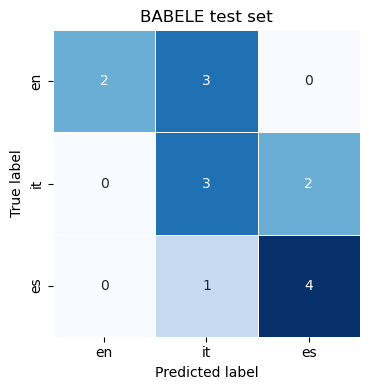

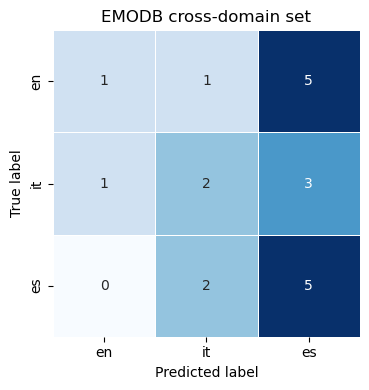

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    plt.figure(figsize=(4,4))
    sns.heatmap(
        np.array(cm),
        annot=True, fmt="d", cmap="Blues",
        xticklabels=labels, yticklabels=labels,
        cbar=False, square=True, linewidths=0.5
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Esempio BABELE
cm_babele = [
    [2, 3, 0],
    [0, 3, 2],
    [0, 1, 4]
]
labels = ["en", "it", "es"]
plot_confusion_matrix(cm_babele, labels, title="BABELE test set")

# Esempio EMODB
cm_emodb = [
    [1, 1, 5],
    [1, 2, 3],
    [0, 2, 5]
]
plot_confusion_matrix(cm_emodb, labels, title="EMODB cross-domain set")


# PROVA NUOVA PER VEDERE CROSS-DOMAIN

In [45]:
#!/usr/bin/env python3
# ==============================================================
# Video-only KD + BC-CMT – versione “grayscale + InstanceNorm”
# ==============================================================

import math, random, json, os
import numpy as np, pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ---------- Config -----------------------------------------------------------------
SEED              = 42
MAXLEN            = 32
BATCH             = 4
PRE_EPOCHS        = 5
FT_EPOCHS         = 25
LR_PRE            = 1e-4
LR_FT             = 3e-4
LANGS             = ['en', 'it', 'es']

USE_GRAY          = True                     # ✔ passa a grigio

# Distillazione
ALPHA_KL          = 0.30
ALPHA_EMB         = 0.20
ALPHA_FRAME       = 0.10                    # ↓ peso frame-wise
TEMP_START        = 2.0
TEMP_END          = 1.0

# Augment
AUG_PROB_MIXUP    = 0.5
AUG_PROB_CUTMIX   = 0.5
AUG_PROB_JITTER   = 0.5
AUG_PROB_COLOR    = 0.0 if USE_GRAY else 0.8   # disattivato su gray
MAX_JITTER_FRAMES = 4

CSV_TRAIN         = 'BABELE/manifest_train.csv'
CSV_VAL           = 'BABELE/manifest_val.csv'
CKPT_OUT          = 'video_bc_cmt_kd_gray.pt'

AUDIO_DIM         = 768
CHANS             = (64, 128, 192, 256)
TOTAL_CHANS       = sum(CHANS)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- Aug-helper ---------------------------------------------------------------
def random_time_jitter(vid, max_shift=4):
    shift = random.randint(-max_shift, max_shift)
    if shift == 0: return vid
    if shift > 0:
        return torch.cat([vid[:, shift:], vid[:, -1:].repeat(1, shift, 1, 1)], 1)
    return torch.cat([vid[:, :1].repeat(1, -shift, 1, 1), vid[:, :shift]], 1)

def mixup_batch(batch, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    perm = torch.randperm(batch.size(0))
    return lam * batch + (1 - lam) * batch[perm], perm, lam

def cutmix_batch(batch, alpha=1.0):
    B, C, L, H, W = batch.size()
    lam = np.random.beta(alpha, alpha)
    cut = random.randint(1, L - 1)
    perm = torch.randperm(B)
    mixed = batch.clone()
    mixed[:, :, :cut] = batch[perm, :, :cut]
    return mixed, perm, lam, cut

# ---------- Dataset ------------------------------------------------------------------
class VideoLangDataset(Dataset):
    def __init__(self, manifest, max_len=MAXLEN, training=True):
        df = pd.read_csv(manifest)
        df = df[df['mouth_path'].notna()].reset_index(drop=True)
        self.df, self.L, self.training = df, max_len, training
        self.lang2idx = {l: i for i, l in enumerate(LANGS)}

    def __len__(self): return len(self.df)

    def _fixT(self, arr):
        T = len(arr)
        return arr[np.linspace(0, T - 1, self.L).astype(int)] if T >= self.L \
             else arr[np.concatenate([np.arange(T), np.full(self.L - T, T - 1)])]

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        vid_np = np.load(r.mouth_path, allow_pickle=True).astype('float32') / 255.0
        if USE_GRAY:
            vid_np = vid_np.mean(-1, keepdims=True)                       # ← GRAY
        vid = torch.from_numpy(self._fixT(vid_np)).permute(3, 0, 1, 2)    # C,T,H,W
        vid = (vid - 0.5) / 0.5

        try:
            p = json.load(open(r.probs_path))
            probs = torch.tensor([p[l] for l in LANGS], dtype=torch.float32)
        except (FileNotFoundError, KeyError):
            probs = F.one_hot(torch.tensor(self.lang2idx[r.label]), len(LANGS)).float()

        hid = torch.zeros(AUDIO_DIM)
        seq = r.hid_path if pd.notna(r.hid_path) else r.feats_path
        if pd.notna(seq) and os.path.exists(seq):
            h = np.load(seq)
            hid = torch.from_numpy(h if h.ndim == 1 else self._fixT(h).mean(0)).float()

        feats = self._fixT(np.load(r.feats_path).astype('float32'))        # frame-teacher
        return vid, probs, hid, torch.from_numpy(feats), torch.tensor(self.lang2idx[r.label])

# ---------- PE & DropPath -------------------------------------------------------------
class DropPath(nn.Module):
    def forward(self, x): return x

class PositionalEncoding1D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        pos = torch.arange(MAXLEN).unsqueeze(1)
        div = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))
        pe = torch.zeros(MAXLEN, dim)
        pe[:, 0::2], pe[:, 1::2] = torch.sin(pos * div), torch.cos(pos * div)
        self.register_buffer('pe', pe)

    def forward(self, x):  # B,C,T
        return x + self.pe[:x.size(2)].T.unsqueeze(0)

# ---------- BC-CMT --------------------------------------------------------------------
def dw_conv2d(c, k, s=1):
    pad = k // 2 if isinstance(k, int) else tuple(p // 2 for p in k)
    return nn.Conv2d(c, c, k, s, pad, groups=c, bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self, ch, heads=4):
        super().__init__()
        self.h, self.dk = heads, ch // heads
        self.q_proj = nn.Conv2d(ch, ch, (3, 1), padding=(1, 0), bias=False)
        self.sub    = dw_conv2d(ch, (2, 1))
        self.k_proj = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.v_proj = nn.Conv1d(ch, ch, 1, groups=heads, bias=False)
        self.out    = nn.Conv1d(ch, ch, 1, bias=False)

    def forward(self, x):  # B,C,T
        B, C, T = x.shape
        q = self.q_proj(x.unsqueeze(2)).mean(2).view(B, self.h, self.dk, T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k = self.k_proj(kv).view(B, self.h, self.dk, -1)
        v = self.v_proj(kv).view(B, self.h, self.dk, -1)
        att = torch.softmax((q.transpose(-1, -2) @ k) / math.sqrt(self.dk), -1)
        out = (att @ v.transpose(-1, -2)).transpose(-1, -2).reshape(B, C, T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.GroupNorm(1, ch),
            nn.Conv1d(ch, ch * 2, 1, bias=False), nn.GELU(),
            nn.Conv1d(ch * 2, ch, 1, bias=False)
        )
    def forward(self, x): return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self, ch, heads):
        super().__init__()
        self.attn = BCLMHSA1D(ch, heads)
        self.norm = nn.GroupNorm(1, ch)
        self.ffn  = BCIRFFN1D(ch)
    def forward(self, x):
        return x + self.ffn(self.attn(self.norm(x)))

class VideoLangModelBC_CMT(nn.Module):
    def __init__(self, emb_dim=512):
        super().__init__()
        in_ch = 1 if USE_GRAY else 3
        self.stem = nn.Sequential(
            nn.Conv3d(in_ch, CHANS[0], (3, 5, 5), (1, 2, 2), (1, 2, 2), bias=False),
            nn.InstanceNorm3d(CHANS[0], affine=True), nn.GELU()                # ← INorm
        )
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(CHANS[i], CHANS[i + 1], (3, 2, 2), (1, 2, 2), (1, 0, 0), bias=False),
                nn.InstanceNorm3d(CHANS[i + 1], affine=True), nn.GELU()        # ← INorm
            ) for i in range(len(CHANS) - 1)
        ])
        self.blocks = nn.ModuleList([BC_CMT_Block(c, 4) for c in CHANS])
        self.pos_enc = PositionalEncoding1D(TOTAL_CHANS)
        self.pool = nn.Sequential(nn.Conv1d(TOTAL_CHANS, emb_dim, 1),
                                  nn.GELU(), nn.Dropout(0.05))
        self.cls        = nn.Linear(emb_dim, len(LANGS))
        self.proj_audio = nn.Linear(AUDIO_DIM, emb_dim, bias=False)
        self.proj_frame = nn.Linear(TOTAL_CHANS, 768)

    def forward(self, vid):
        x = self.stem(vid)
        feats = []
        for i, blk in enumerate(self.blocks):
            f = blk(x.mean((-1, -2)))
            feats.append(f)
            if i < len(self.trans):
                x = self.trans[i](x)
        z = torch.cat(feats, 1)                       # B,C,T
        z = self.pos_enc(z)
        out = self.pool(z)
        e_v = out.mean(-1)
        z_frame = self.proj_frame(z.permute(0, 2, 1))
        return self.cls(e_v), e_v, z, z_frame

# ---------- Pre-training MFP --------------------------------------------------
class FrameReconstructionDecoder(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.up = nn.ConvTranspose1d(in_ch, in_ch, 3, padding=1)
        self.conv3d = nn.Sequential(
            nn.Conv3d(in_ch, 128, 3, padding=1), nn.GELU(),
            nn.Conv3d(128, 3, 1)
        )
    def forward(self, z):
        x = self.up(z).view(z.size(0), z.size(1), z.size(2), 1, 1)
        return self.conv3d(x)

# ---------- Training ----------------------------------------------------------
def train():
    torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

    encoder = VideoLangModelBC_CMT().to(device)
    decoder = FrameReconstructionDecoder(TOTAL_CHANS).to(device)
    opt_pre = AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=LR_PRE)
    pre_ld  = DataLoader(VideoLangDataset(CSV_TRAIN, MAXLEN), batch_size=BATCH, shuffle=True)

    # --- Pre-train Masked Frame Prediction ---
    for _ in range(PRE_EPOCHS):
        encoder.train(); decoder.train()
        for vid, *_ in pre_ld:
            vid = vid.to(device)
            B = vid.size(0)
            mask = torch.zeros_like(vid)
            mlen = int(0.2 * MAXLEN)
            for b in range(B):
                s = random.randint(0, MAXLEN - mlen)
                mask[b, :, s:s + mlen] = 1
                vid[b, :, s:s + mlen]  = 0
            _, _, z, _ = encoder(vid)
            rec = decoder(z)
            loss = F.mse_loss(rec * mask, (vid * 0.5 + 0.5) * mask)  # target in [0,1]
            opt_pre.zero_grad(); loss.backward(); opt_pre.step()

    # --- Fine-tuning supervisionato ------------------------------------------
    ds = VideoLangDataset(CSV_TRAIN, MAXLEN, True)
    w  = ds.df['label'].value_counts().to_dict()
    sampler = WeightedRandomSampler(ds.df['label'].map(lambda l: 1 / w[l]).values, len(ds), True)
    train_ld= DataLoader(ds, batch_size=BATCH, sampler=sampler)
    val_ld  = DataLoader(VideoLangDataset(CSV_VAL, MAXLEN, False), batch_size=BATCH)

    model, best_f1 = encoder, 0.0
    opt = AdamW(model.parameters(), lr=LR_FT, weight_decay=1e-4)
    sched = OneCycleLR(opt, LR_FT, total_steps=FT_EPOCHS * len(train_ld),
                       pct_start=0.1, div_factor=10, final_div_factor=1e4)
    focal = FocalLoss(gamma=2.0)

    for ep in range(FT_EPOCHS):
        model.train()
        for vids, probs, hids, feats_t, labels in train_ld:
            vids, probs, hids, feats_t, labels = [t.to(device) for t in (vids, probs, hids, feats_t, labels)]

            # jitter
            if random.random() < AUG_PROB_JITTER:
                vids = torch.stack([random_time_jitter(v, MAX_JITTER_FRAMES) for v in vids])

            # mixup / cutmix
            mix_flag = False
            if random.random() < AUG_PROB_MIXUP:
                vids, perm, lam = mixup_batch(vids); mix_flag = True
                probs = lam * probs + (1 - lam) * probs[perm]
                hids  = lam * hids  + (1 - lam) * hids[perm]
                feats_t = lam * feats_t + (1 - lam) * feats_t[perm]
            elif random.random() < AUG_PROB_CUTMIX:
                vids, perm, lam, _ = cutmix_batch(vids); mix_flag = True
                probs = lam * probs + (1 - lam) * probs[perm]
                hids  = lam * hids  + (1 - lam) * hids[perm]
                feats_t = lam * feats_t + (1 - lam) * feats_t[perm]

            logits, e_v, z, z_frame = model(vids)
            e_t = model.proj_audio(hids)

            loss_ce = (-(lam * F.log_softmax(logits, -1) * probs).sum(-1).mean()
                       if mix_flag else focal(logits, labels))

            temp  = TEMP_START + (TEMP_END - TEMP_START) * ep / (FT_EPOCHS - 1)
            t_list = np.linspace(TEMP_START, temp, 3)
            loss_kl = sum(F.kl_div(F.log_softmax(logits/t, -1), F.softmax(probs/t, -1),
                                   reduction='batchmean') * t**2 for t in t_list) / 3
            loss_em   = F.cosine_embedding_loss(e_v, e_t, torch.ones(e_v.size(0), device=device))
            loss_fw   = F.mse_loss(z_frame, feats_t)
            loss_sm   = (z[:, :, 1:] - z[:, :, :-1]).pow(2).mean()

            loss = ((1 - ALPHA_KL - ALPHA_EMB - ALPHA_FRAME) * loss_ce +
                    ALPHA_KL   * loss_kl   +
                    ALPHA_EMB  * loss_em   +
                    ALPHA_FRAME* loss_fw   +
                    0.01       * loss_sm)
            opt.zero_grad(); loss.backward(); opt.step(); sched.step()

        # --- validation ---
        model.eval()
        all_p, all_l = [], []
        with torch.no_grad():
            for vids, _, _, _, labels in val_ld:
                preds = model(vids.to(device))[0].argmax(1)
                all_p.extend(preds.cpu()); all_l.extend(labels)
        acc = accuracy_score(all_l, all_p)
        f1  = np.mean(precision_recall_fscore_support(all_l, all_p, average=None,
                                                      labels=list(range(len(LANGS))))[2])
        print(f"Epoch {ep+1:02d}: Acc {acc:.3f} | F1 {f1:.3f}")
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), CKPT_OUT)

    print(f"Done. Best F1 = {best_f1:.3f}")

if __name__ == "__main__":
    train()


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/600639629.py:245: UserWarning: Using a target size (torch.Size([4, 1, 32, 96, 96])) that is different to the input size (torch.Size([4, 3, 32, 96, 96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(rec * mask, (vid * 0.5 + 0.5) * mask)  # target in [0,1]
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/600639629.py:245: UserWarning: Using a target size (torch.Size([1, 1, 32, 96, 96])) that is different to the input size (torch.Size([1, 3, 32, 96, 96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(rec * mask, (vid * 0.5 + 0.5) * mask)  # target in [0,1]
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predict

Epoch 01: Acc 0.357 | F1 0.196
Epoch 02: Acc 0.357 | F1 0.332


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 03: Acc 0.286 | F1 0.148


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 04: Acc 0.286 | F1 0.236


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 05: Acc 0.286 | F1 0.148
Epoch 06: Acc 0.357 | F1 0.278


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 07: Acc 0.286 | F1 0.208


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 08: Acc 0.429 | F1 0.348
Epoch 09: Acc 0.357 | F1 0.337


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10: Acc 0.429 | F1 0.344


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11: Acc 0.357 | F1 0.288
Epoch 12: Acc 0.357 | F1 0.337


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13: Acc 0.500 | F1 0.387


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14: Acc 0.429 | F1 0.326
Epoch 15: Acc 0.500 | F1 0.399
Epoch 16: Acc 0.500 | F1 0.399


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17: Acc 0.357 | F1 0.278
Epoch 18: Acc 0.500 | F1 0.479
Epoch 19: Acc 0.500 | F1 0.479
Epoch 20: Acc 0.500 | F1 0.479
Epoch 21: Acc 0.571 | F1 0.562
Epoch 22: Acc 0.500 | F1 0.479
Epoch 23: Acc 0.429 | F1 0.368
Epoch 24: Acc 0.429 | F1 0.368
Epoch 25: Acc 0.429 | F1 0.368
Done. Best F1 = 0.562


In [48]:
#!/usr/bin/env python3
# ==============================================================
# test_video_kd_gray_unified.py
#
# • Valuta lo student GRAY BC-CMT con **la stessa identica pipeline**
#   su qualsiasi manifest CSV (es. BABELE test, EMODB, ecc.).
# • Nessun dato esterno entra nel modello (video-only).
# • Pre-processing, padding e TTA sono identici per ogni dominio.
# ==============================================================

import math, os, argparse, glob, json
import numpy as np
import pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ------------------------ Config condivisa -----------------------------------
LANGS     = ["en", "it", "es"]
MAXLEN    = 32
USE_GRAY  = True
BATCH     = 16
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CKPT_PATH = "video_bc_cmt_kd_gray.pt"     # checkpoint prodotto dal training GRAY
AUDIO_DIM = 768                           # presente nel ckpt, inutilizzato qui

# ------------------------ Dataset (stesso pre-process) -----------------------
class VideoOnlyDataset(Dataset):
    l2id = {l:i for i,l in enumerate(LANGS)}

    def __init__(self, manifest_csv):
        df = pd.read_csv(manifest_csv)
        df = df[df.mouth_path.notna()].reset_index(drop=True)
        self.df = df

    def __len__(self): return len(self.df)

    def _pad_or_sample(self, arr):
        """uniform-sample or repeat last frame to have exactly MAXLEN frames"""
        T = len(arr)
        idx = np.linspace(0, T-1, MAXLEN).astype(int) if T >= MAXLEN \
            else np.concatenate([np.arange(T), np.full(MAXLEN-T, T-1)])
        return arr[idx]

    def __getitem__(self, i):
        r   = self.df.iloc[i]
        vid = np.load(r.mouth_path, allow_pickle=True).astype("float32") / 255.0  # [T,H,W,3]
        if USE_GRAY:
            vid = vid.mean(-1, keepdims=True)                                    # [T,H,W,1]
        vid = self._pad_or_sample(vid)                                           # ensure 32 frame
        vid = torch.from_numpy(vid).permute(3,0,1,2)                             # [C,T,H,W]
        vid = (vid - 0.5) / 0.5                                                  # same normalisation
        lab = torch.tensor(self.l2id[r.label])
        return vid, lab

# ------------------------ Positional Encoding --------------------------------
class PositionalEncoding1D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        pos = torch.arange(MAXLEN).unsqueeze(1)
        div = torch.exp(torch.arange(0, dim, 2)*(-math.log(10000.0)/dim))
        pe  = torch.zeros(MAXLEN, dim)
        pe[:,0::2], pe[:,1::2] = torch.sin(pos*div), torch.cos(pos*div)
        self.register_buffer("pe", pe)
    def forward(self,x):                   # [B,C,T]
        return x + self.pe[:x.size(2)].T.unsqueeze(0)

# ------------------------ BC-CMT blocks (nomi = training) --------------------
def dw_conv2d(c,k,s=1):
    pad = k//2 if isinstance(k,int) else tuple(p//2 for p in k)
    return nn.Conv2d(c,c,k,s,padding=pad,groups=c,bias=False)

class BCLMHSA1D(nn.Module):
    def __init__(self,ch,heads=4):
        super().__init__()
        self.h, self.dk = heads, ch//heads
        self.q_proj = nn.Conv2d(ch,ch,(3,1),padding=(1,0),bias=False)
        self.sub    = dw_conv2d(ch,(2,1))
        self.k_proj = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.v_proj = nn.Conv1d(ch,ch,1,groups=heads,bias=False)
        self.out    = nn.Conv1d(ch,ch,1,bias=False)
    def forward(self,x):
        B,C,T = x.shape
        q  = self.q_proj(x.unsqueeze(2)).mean(2).view(B,self.h,self.dk,T)
        kv = self.sub(x.unsqueeze(2)).mean(2)
        k  = self.k_proj(kv).view(B,self.h,self.dk,-1)
        v  = self.v_proj(kv).view(B,self.h,self.dk,-1)
        att= torch.softmax((q.transpose(-1,-2)@k)/math.sqrt(self.dk),-1)
        out=(att@v.transpose(-1,-2)).transpose(-1,-2).reshape(B,C,T)
        return self.out(out)

class BCIRFFN1D(nn.Module):
    def __init__(self,ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.GroupNorm(1,ch),
            nn.Conv1d(ch,ch*2,1,bias=False), nn.GELU(),
            nn.Conv1d(ch*2,ch,1,bias=False)
        )
    def forward(self,x): return x + self.net(x)

class BC_CMT_Block(nn.Module):
    def __init__(self,ch,heads):
        super().__init__()
        self.attn = BCLMHSA1D(ch,heads)
        self.norm = nn.GroupNorm(1,ch)
        self.ffn  = BCIRFFN1D(ch)
    def forward(self,x): return x + self.ffn(self.attn(self.norm(x)))

# ------------------------ Student network ------------------------------------
class StudentBC_CMT(nn.Module):
    def __init__(self, emb_dim=512, chans=(64,128,192,256), heads=(4,4,4,4)):
        super().__init__()
        in_ch = 1 if USE_GRAY else 3
        self.stem = nn.Sequential(
            nn.Conv3d(in_ch,chans[0],(3,5,5),(1,2,2),(1,2,2),bias=False),
            nn.InstanceNorm3d(chans[0], affine=True), nn.GELU()
        )
        self.trans = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(chans[i],chans[i+1],(3,2,2),(1,2,2),(1,0,0),bias=False),
                nn.InstanceNorm3d(chans[i+1], affine=True), nn.GELU()
            ) for i in range(len(chans)-1)
        ])
        self.blocks = nn.ModuleList([BC_CMT_Block(c,h) for c,h in zip(chans,heads)])
        total = sum(chans)
        self.pos_enc = PositionalEncoding1D(total)
        self.pool    = nn.Sequential(nn.Conv1d(total,emb_dim,1), nn.GELU())
        self.cls     = nn.Linear(emb_dim, len(LANGS))
        # layer inutilizzati ma presenti nel ckpt
        self.proj_audio = nn.Linear(AUDIO_DIM,emb_dim,bias=False)
        self.proj_frame = nn.Linear(total,768)
    def forward(self,vid):
        x = self.stem(vid)
        feats=[]
        for i,blk in enumerate(self.blocks):
            feats.append( blk(x.mean((-1,-2))) )
            if i < len(self.trans): x = self.trans[i](x)
        z = self.pos_enc(torch.cat(feats,1))        # [B,total,T]
        e = self.pool(z).mean(-1)                   # [B,512]
        return self.cls(e)

# ------------------------ Loader ------------------------------------------------------
def load_student():
    net = StudentBC_CMT().to(DEVICE)
    net.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE), strict=False)
    net.eval(); return net

# ------------------------ Evaluation util --------------------------------------------
@torch.no_grad()
def evaluate(csv_path, title):
    print(f"\n===== {title} =====")
    dl   = DataLoader(VideoOnlyDataset(csv_path), batch_size=BATCH)
    net  = load_student()
    y_t, y_p = [], []
    for vids, y in dl:
        p = net(vids.to(DEVICE)).argmax(1).cpu()
        y_t += y.tolist(); y_p += p.tolist()
    print("Acc:", accuracy_score(y_t,y_p))
    print(classification_report(y_t,y_p,target_names=LANGS,digits=3))
    print(confusion_matrix(y_t,y_p))

# ------------------------ MAIN -------------------------------------------------------
if __name__ == "__main__":
    evaluate("BABELE/manifest_test.csv",  "BABELE test")
    evaluate("EMODB/distillation_dataset.csv", "EMODB cross-domain")



===== BABELE test =====
Acc: 0.3333333333333333
              precision    recall  f1-score   support

          en      0.500     0.600     0.545         5
          it      0.286     0.400     0.333         5
          es      0.000     0.000     0.000         5

    accuracy                          0.333        15
   macro avg      0.262     0.333     0.293        15
weighted avg      0.262     0.333     0.293        15

[[3 1 1]
 [2 2 1]
 [1 4 0]]

===== EMODB cross-domain =====
Acc: 0.2857142857142857
              precision    recall  f1-score   support

          en      0.385     0.714     0.500         7
          it      0.000     0.000     0.000         7
          es      0.333     0.143     0.200         7

    accuracy                          0.286        21
   macro avg      0.239     0.286     0.233        21
weighted avg      0.239     0.286     0.233        21

[[5 1 1]
 [6 0 1]
 [2 4 1]]


In [134]:
#!/usr/bin/env python3
# =========================================================================
# KD  +  BC-CMT (GRAY)  with Domain-Randomization + AdaIN + SWA
# =========================================================================
import math, random, json, os, copy
import numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# -------------------- Hyper-params ----------------------------------------
SEED, MAXLEN, BATCH = 42, 32, 4
PRE_EPOCHS, FT_EPOCHS, SWA_TAIL = 5, 25, 5         # last 5 epochs averaged
LR_PRE, LR_FT = 1e-4, 3e-4
LANGS = ['en', 'it', 'es']; USE_GRAY = True
ALPHA_KL, ALPHA_EMB, ALPHA_FRAME = .30, .20, .10
TEMP_START, TEMP_END = 2.0, 1.0

# augmentation
AUG_P_DR   = .6         # domain-randomization
AUG_P_MIX  = .5
AUG_P_CUT  = .5
AUG_P_JITT = .5
MAX_JITTER = 4

CSV_TRAIN = 'BABELE/manifest_train.csv'
CSV_VAL   = 'BABELE/manifest_val.csv'
CKPT_OUT  = 'video_bc_cmt_kd_gray_swa.pt'

AUDIO_DIM = 768
CHANS     = (64,128,192,256)
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------- Domain-Random helpers -------------------------------
def blur_frame(f):                        # 3×3 avg blur
    return F.avg_pool2d(f.unsqueeze(0), 3, 1, 1)[0]

def domain_rand(c):                       # clip [C,T,H,W] in [-1,1]
    for t in range(c.size(1)):
        if random.random() < .4: c[:,t] = blur_frame(c[:,t])
        if random.random() < .3:
            m = c[:,t].mean(); f = random.uniform(.7,1.3)
            c[:,t] = (c[:,t]-m)*f + m
        if random.random() < .3:
            c[:,t] += torch.randn_like(c[:,t])*.03
    return c.clamp(-1,1)

def jitter(v, s=MAX_JITTER):
    sh = random.randint(-s,s)
    if sh==0: return v
    return torch.cat([v[:,sh:], v[:,-1:].repeat(1,sh,1,1)],1) if sh>0 \
         else torch.cat([v[:,:1].repeat(1,-sh,1,1), v[:,:sh]],1)

def mixup(x, α=.4):
    lam = np.random.beta(α,α); p = torch.randperm(x.size(0))
    return lam*x + (1-lam)*x[p], p, lam

def cutmix(x, α=1.):
    B,C,L,*_ = x.size(); lam = np.random.beta(α,α); cut = random.randint(1,L-1)
    p = torch.randperm(B); y = x.clone(); y[:,:,:cut] = x[p,:,:cut]
    return y,p,lam,cut

# -------------------- Dataset ---------------------------------------------
class VideoDS(Dataset):
    l2i = {l:i for i,l in enumerate(LANGS)}
    def __init__(s,csv,maxlen=MAXLEN,train=True):
        df = pd.read_csv(csv); df = df[df.mouth_path.notna()].reset_index(drop=True)
        s.df,s.L,s.train = df,maxlen,train
    def __len__(s): return len(s.df)
    def _fix(s,a):
        T=len(a); idx=np.linspace(0,T-1,s.L).astype(int) if T>=s.L \
            else np.concatenate([np.arange(T), np.full(s.L-T,T-1)])
        return a[idx]
    def __getitem__(s,i):
        r=s.df.iloc[i]
        v=np.load(r.mouth_path,allow_pickle=True).astype('float32')/255.0
        if USE_GRAY: v=v.mean(-1,keepdims=True)
        vid=torch.from_numpy(s._fix(v)).permute(3,0,1,2)
        vid=(vid-0.5)/0.5
        try:
            p=json.load(open(r.probs_path)); probs=torch.tensor([p[l] for l in LANGS])
        except: probs=F.one_hot(torch.tensor(s.l2i[r.label]),len(LANGS)).float()
        hid=torch.zeros(AUDIO_DIM)
        seq=r.hid_path if pd.notna(r.hid_path) else r.feats_path
        if pd.notna(seq) and os.path.exists(seq):
            h=np.load(seq); hid=torch.from_numpy(h if h.ndim==1 else s._fix(h).mean(0))
        feats=torch.from_numpy(s._fix(np.load(r.feats_path).astype('float32')))
        return vid,probs,hid,feats,torch.tensor(s.l2i[r.label])

# -------------------- Positional Encoding -----------------------------------
class PosEnc1D(nn.Module):
    def __init__(s,dim):
        super().__init__()
        pos=torch.arange(MAXLEN).unsqueeze(1)
        div=torch.exp(torch.arange(0,dim,2)*(-math.log(1e4)/dim))
        pe=torch.zeros(MAXLEN,dim); pe[:,0::2],pe[:,1::2]=torch.sin(pos*div),torch.cos(pos*div)
        s.register_buffer('pe',pe)
    def forward(s,x): return x + s.pe[:x.size(2)].T.unsqueeze(0)

# -------------------- BC-CMT Blocks ----------------------------------------
def dw_conv(c,k,s=1):
    pad=k//2 if isinstance(k,int) else tuple(ki//2 for ki in k)
    return nn.Conv2d(c,c,k,s,padding=pad,groups=c,bias=False)

class Attn(nn.Module):
    def __init__(s,c,h=4):
        super().__init__(); s.h,s.dk=h,c//h
        s.q_proj=nn.Conv2d(c,c,(3,1),padding=(1,0),bias=False)
        s.sub=dw_conv(c,(2,1)); s.k_proj=nn.Conv1d(c,c,1,groups=h,bias=False)
        s.v_proj=nn.Conv1d(c,c,1,groups=h,bias=False); s.o=nn.Conv1d(c,c,1,bias=False)
    def forward(s,x):
        B,C,T=x.shape
        q=s.q_proj(x.unsqueeze(2)).mean(2).view(B,s.h,s.dk,T)
        kv=s.sub(x.unsqueeze(2)).mean(2)
        k=s.k_proj(kv).view(B,s.h,s.dk,-1); v=s.v_proj(kv).view(B,s.h,s.dk,-1)
        a=torch.softmax((q.transpose(-1,-2)@k)/math.sqrt(s.dk),-1)
        return s.o((a@v.transpose(-1,-2)).transpose(-1,-2).reshape(B,C,T))

class FFN(nn.Module):
    def __init__(s,c):
        super().__init__(); s.mlp=nn.Sequential(nn.GroupNorm(1,c),
                nn.Conv1d(c,c*2,1,bias=False), nn.GELU(), nn.Conv1d(c*2,c,1,bias=False))
    def forward(s,x): return x + s.mlp(x)

class Block(nn.Module):
    def __init__(s,c): super().__init__(); s.a=Attn(c); s.n=nn.GroupNorm(1,c); s.f=FFN(c)
    def forward(s,x): return x + s.f(s.a(s.n(x)))

# -------------------- Student Network + AdaIN -------------------------------
class Student(nn.Module):
    def __init__(s,emb=512):
        super().__init__()
        in_c=1 if USE_GRAY else 3
        s.stem=nn.Sequential(
            nn.Conv3d(in_c,CHANS[0],(3,5,5),(1,2,2),(1,2,2),bias=False),
            nn.InstanceNorm3d(CHANS[0],affine=True,track_running_stats=True),
            nn.GELU())
        s.trans=nn.ModuleList([
            nn.Sequential(nn.Conv3d(CHANS[i],CHANS[i+1],(3,2,2),(1,2,2),(1,0,0),bias=False),
                          nn.InstanceNorm3d(CHANS[i+1],affine=True,track_running_stats=True),
                          nn.GELU()) for i in range(len(CHANS)-1)])
        s.blocks=nn.ModuleList([Block(c) for c in CHANS])
        total=sum(CHANS); s.pos=PosEnc1D(total)
        s.pool=nn.Sequential(nn.Conv1d(total,emb,1),nn.GELU())
        s.cls =nn.Linear(emb,len(LANGS))
        s.proj_audio=nn.Linear(AUDIO_DIM,emb,bias=False)
        s.proj_frame=nn.Linear(total,768)

    def ada_in(s,x):
        μc=x.mean([2,3,4],keepdim=True); σc=x.std([2,3,4],keepdim=True)+1e-5
        inst=s.stem[1]
        if inst.running_mean is not None:
            μb=inst.running_mean.view(1,-1,1,1,1)
            σb=torch.sqrt(inst.running_var+1e-5).view(1,-1,1,1,1)
        else: μb,σb=0.,1.
        return (x-μb)/σb*σc + μc

    def forward(s,v):
        x=s.ada_in(s.stem(v))
        feats=[]
        for i,b in enumerate(s.blocks):
            feats.append(b(x.mean((-1,-2)))); 
            if i < len(s.trans): x=s.trans[i](x)
        z=s.pos(torch.cat(feats,1)); e=s.pool(z).mean(-1)
        return s.cls(e), e, z, s.proj_frame(z.permute(0,2,1))

# -------------------- Loss ---------------------------------------------------
class Focal(nn.Module):
    def __init__(s,gamma=2): super().__init__(); s.g=gamma
    def forward(s,log,y):
        ce=F.cross_entropy(log,y,reduction='none'); p=torch.exp(-ce)
        return ((1-p)**s.g*ce).mean()

# -------------------- Pre-train Masked Frame Pred ---------------------------
def pretrain(enc,dec):
    opt=AdamW(list(enc.parameters())+list(dec.parameters()),lr=LR_PRE)
    loader=DataLoader(VideoDS(CSV_TRAIN,MAXLEN),batch_size=BATCH,shuffle=True)
    for _ in range(PRE_EPOCHS):
        enc.train(); dec.train()
        for vid,*_ in loader:
            vid = vid.to(device)
            mask=torch.zeros_like(vid); m=int(.2*MAXLEN)
            for b in range(vid.size(0)):
                s=random.randint(0,MAXLEN-m)
                mask[b,:,s:s+m]=1; vid[b,:,s:s+m]=0
            _,_,z,_=enc(vid); rec=dec(z)
            loss=F.mse_loss(rec*mask,(vid*0.5+0.5)*mask)
            opt.zero_grad(); loss.backward(); opt.step()

# -------------------- Fine-tuning w/ SWA ------------------------------------
def finetune():
    base=Student().to(device); dec=FrameReconstructionDecoder(sum(CHANS)).to(device)
    pretrain(base,dec)

    swa=AveragedModel(base)
    opt=AdamW(base.parameters(),lr=LR_FT,weight_decay=1e-4)
    sched=OneCycleLR(opt,LR_FT,total_steps=FT_EPOCHS*len(train_ld),
                     pct_start=.1,div_factor=10,final_div_factor=1e4)
    swa_sched=SWALR(opt,swa_lr=1e-5)
    focal=Focal(); best=0

    for ep in range(FT_EPOCHS):
        base.train()
        for v,pr,hid,ft,lbl in train_ld:
            v,pr,hid,ft,lbl=[t.to(device) for t in (v,pr,hid,ft,lbl)]

            if random.random()<AUG_P_DR:  v=torch.stack([domain_rand(c.clone()) for c in v])
            if random.random()<AUG_P_JITT: v=torch.stack([jitter(c) for c in v])

            mix=False
            if random.random()<AUG_P_MIX:
                v,p,lam=mixup(v); mix=True; pr,hid,ft=[lam*t+(1-lam)*t[p] for t in (pr,hid,ft)]
            elif random.random()<AUG_P_CUT:
                v,p,lam,_=cutmix(v); mix=True; pr,hid,ft=[lam*t+(1-lam)*t[p] for t in (pr,hid,ft)]

            log,e,z,zf=base(v); e_t=base.proj_audio(hid)
            loss_ce = (-(pr*F.log_softmax(log,-1)).sum(-1).mean() if mix else focal(log,lbl))
            t=TEMP_START+(TEMP_END-TEMP_START)*ep/(FT_EPOCHS-1)
            loss_kl = F.kl_div(F.log_softmax(log/t,-1),F.softmax(pr/t,-1),'batchmean')*t**2
            loss = ((1-ALPHA_KL-ALPHA_EMB-ALPHA_FRAME)*loss_ce +
                    ALPHA_KL*loss_kl +
                    ALPHA_EMB*F.cosine_embedding_loss(e,e_t,torch.ones(e.size(0),device=device)) +
                    ALPHA_FRAME*F.mse_loss(zf,ft) +
                    .01*(z[:,:,1:]-z[:,:,:-1]).pow(2).mean())

            opt.zero_grad(); loss.backward(); opt.step()
            (sched if ep<FT_EPOCHS-SWA_TAIL else swa_sched).step()
            if ep>=FT_EPOCHS-SWA_TAIL: swa.update_parameters(base)

        # --- val
        base.eval(); yp,yt=[],[]
        with torch.no_grad():
            for v,_,_,_,l in val_ld:
                yp+=base(v.to(device))[0].argmax(1).cpu().tolist(); yt+=l.tolist()
        f1=np.mean(precision_recall_fscore_support(yt,yp,labels=[0,1,2])[2])
        print(f"Ep{ep+1:02d} F1={f1:.3f}")
        best=max(best,f1)

    # swap SWA weights
    print("Updating BN for SWA…"); update_bn(train_ld,swa,device=device)
    torch.save(swa.state_dict(), CKPT_OUT); print("Best val F1 =",best)

# -------------------- Data loaders ------------------------------------------
train_set=VideoDS(CSV_TRAIN,MAXLEN,True)
val_set  =VideoDS(CSV_VAL,MAXLEN,False)
w=train_set.df.label.value_counts().to_dict()
sampler=WeightedRandomSampler(train_set.df.label.map(lambda l:1/w[l]).values,
                              len(train_set),True)
train_ld=DataLoader(train_set,batch_size=BATCH,sampler=sampler)
val_ld  =DataLoader(val_set,batch_size=BATCH)

# -------------------- Run ----------------------------------------------------
if __name__ == "__main__":
    torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
    finetune()


/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3666335396.py:190: UserWarning: Using a target size (torch.Size([4, 1, 32, 96, 96])) that is different to the input size (torch.Size([4, 3, 32, 96, 96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss=F.mse_loss(rec*mask,(vid*0.5+0.5)*mask)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_8080/3666335396.py:190: UserWarning: Using a target size (torch.Size([1, 1, 32, 96, 96])) that is different to the input size (torch.Size([1, 3, 32, 96, 96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss=F.mse_loss(rec*mask,(vid*0.5+0.5)*mask)
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep01 F1=0.319


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep02 F1=0.196


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ep03 F1=0.185


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ep04 F1=0.148


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ep05 F1=0.265


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ep06 F1=0.169


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep07 F1=0.300


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep08 F1=0.178


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep09 F1=0.178


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep10 F1=0.261


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ep11 F1=0.272


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep12 F1=0.274


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep13 F1=0.339


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ep14 F1=0.167


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep15 F1=0.208


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ep16 F1=0.167


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep17 F1=0.178


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep18 F1=0.467


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ep19 F1=0.167


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ep20 F1=0.167


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep21 F1=0.279


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ep22 F1=0.178


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep23 F1=0.279


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ep24 F1=0.265


/opt/anaconda3/envs/casaenv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Ep25 F1=0.279
Updating BN for SWA…
Best val F1 = 0.4670329670329671


In [43]:
#!/usr/bin/env python3
"""
Student KD – BC-CMT Small backbone • ultra-low-memory
Con data augmentation video-only e logging per debug
"""

import json, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
from torchvision import transforms as TF  # ← rinominato

# ───────────── Config ─────────────
SEED, EPOCHS       = 42, 10
BATCH_SIZE_GEN     = 1
USE_DISTRACTOR     = False
GRAD_ACC           = 4
LR                 = 4e-4
LANGS              = ['en','it','es']
DIST_ID            = len(LANGS)
KD_T               = 2.0                 # ← rinominato
CE_W               = 0.6
KD_W               = {'prob': .5, 'hid': .25, 'feat': .25}
MAX_GRAD_NORM      = 1.0
DEV                = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ───────────── Augmentor ─────────────
class MouthAugmentor:
    def __init__(self, H, W, L):
        self.frame_tf = TF.Compose([
            TF.RandomResizedCrop((H, W), scale=(0.9, 1.0)),
            TF.RandomAffine(degrees=5, translate=(0.02,0.02), scale=(0.95,1.05)),
            TF.ColorJitter(brightness=0.2, contrast=0.2),
            TF.GaussianBlur(kernel_size=3),
        ])
        self.L = L

    def __call__(self, vid: torch.Tensor):
        # vid: Tensor[L, H, W], values in [0,1]
        L0, H, W = vid.shape
        # 1) spatial per-frame
        vid = torch.stack([self.frame_tf(frame.unsqueeze(0)).squeeze(0)
                           for frame in vid])
        # 2) random erasing su un frame
        if random.random() < 0.3:
            f = random.randrange(self.L)
            hh = int(0.15*H); ww = int(0.15*W)
            h0 = random.randrange(max(1, H - hh))
            w0 = random.randrange(max(1, W - ww))
            vid[f, h0:h0+hh, w0:w0+ww] = 0.5
        # 3) frame drop
        if random.random() < 0.3:
            k = min(2, self.L-1)
            drops = sorted(random.sample(range(self.L), k=k))
            keep = [i for i in range(self.L) if i not in drops]
            vid = vid[keep]
            if vid.size(0) < self.L:
                pad = vid[-1].unsqueeze(0).repeat(self.L-vid.size(0),1,1)
                vid = torch.cat([vid, pad], dim=0)
        # 4) speed jitter (resampling temporale)
        if random.random() < 0.3:
            speed = random.uniform(0.9,1.1)
            idx = torch.linspace(0, self.L-1, max(1, int(self.L/speed))).long().clamp(max=self.L-1)
            vid = vid[idx]
            if vid.size(0) != self.L:
                # Interpolazione 3D: [N,C,D,H,W] → qui N=1, C=1, D=frames
                vid = F.interpolate(
                    vid.unsqueeze(0).unsqueeze(0),
                    size=(self.L, H, W),
                    mode='trilinear',
                    align_corners=False
                ).squeeze(0).squeeze(0)
        return vid

# ───────────── Dataset ─────────────
class MouthDS(Dataset):
    def __init__(self, csv, L=32, teach=True, distract=True, augment=False):
        df = pd.read_csv(csv).query('mouth_path.notna()').reset_index(drop=True)
        self.df, self.L, self.teach, self.distract = df, L, teach, distract
        self.l2i = {l:i for i,l in enumerate(LANGS)}
        # preload teacher data
        if teach:
            self.t_probs, self.t_hids, self.t_feats = [], [], []
            for _, row in df.iterrows():
                with open(row.probs_path) as f:
                    pdict = json.load(f).get('probs', {})
                self.t_probs.append(torch.tensor([float(pdict.get(l,0.)) for l in LANGS], dtype=torch.float32))
                self.t_hids.append(torch.from_numpy(np.load(row.hid_path)).float())
                self.t_feats.append(torch.from_numpy(np.load(row.feats_path)).float())
        # augmentation solo in training
        self.aug = MouthAugmentor(H=64, W=64, L=L) if augment else None

    def __len__(self):
        return len(self.df)

    def _align(self, arr):
        # arr: numpy[T, H, W]
        T0 = arr.shape[0]
        if T0 >= self.L:
            idx = np.linspace(0, T0-1, self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T0), np.full(self.L-T0, T0-1)])
        return arr[idx]

    def __getitem__(self, i):
        row = self.df.iloc[i]
        arr = np.load(row.mouth_path, allow_pickle=True).astype('float32')/255.
        if arr.ndim == 4 and arr.shape[-1] == 3:
            arr = arr.mean(-1)                     # RGB→grigio
        elif arr.ndim == 3:
            pass
        else:
            raise ValueError(f"Formato inatteso per {row.mouth_path}: shape={arr.shape}")
        arr = self._align(arr)                     # [L, H, W]
        vid = torch.from_numpy(arr)                # Tensor[L,H,W]
        if self.aug:
            vid = self.aug(vid)                    # augment
        # normalize to [-1,1]
        vid = (vid - 0.5) / 0.5
        # to shape [1, L, H, W] per conv3d
        v = vid.unsqueeze(0)
        y = self.l2i[row.label]

        teach = None
        if self.teach:
            teach = {
                'prob': self.t_probs[i],
                'hid' : self.t_hids[i],
                'feat': self.t_feats[i]
            }

        g = {'x': v, 'y': y, 't': teach}
        if not self.distract:
            return g
        d = {'x': v.flip(2).clone(), 'y': DIST_ID, 't': None}
        return g, d

# ───────────── Collate ─────────────
def custom_collate(batch):
    if isinstance(batch[0], tuple):
        gens, dists = zip(*batch)
    else:
        gens, dists = batch, []

    xg = torch.stack([g['x'] for g in gens])
    yg = torch.tensor([g['y'] for g in gens], dtype=torch.long)

    if gens[0]['t'] is not None:
        tp = torch.stack([g['t']['prob'] for g in gens])
        th = torch.stack([g['t']['hid']  for g in gens])
        tf = torch.stack([g['t']['feat'] for g in gens])
    else:
        tp = th = tf = None

    if dists:
        xd = torch.stack([d['x'] for d in dists])
        yd = torch.tensor([d['y'] for d in dists], dtype=torch.long)
        x  = torch.cat([xg, xd])
        y  = torch.cat([yg, yd])
        mask = torch.cat([
            torch.ones(len(yg), dtype=torch.bool),
            torch.zeros(len(yd), dtype=torch.bool)
        ])
    else:
        x, y, mask = xg, yg, torch.ones(len(yg), dtype=torch.bool)

    teach = None if tp is None else {'prob': tp, 'hid': th, 'feat': tf}
    return x, y, mask, teach

# ───────────── Utils ─────────────
def macro_f1(y_true, y_pred):
    return precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )[2]

# ───────────── Attention 3D ─────────────
class LMHSA3D(nn.Module):
    def __init__(self, C, Tmax=64):
        super().__init__()
        self.q   = nn.Conv3d(C, C, (2,1,1), stride=(2,1,1), groups=C, bias=False)
        self.kv  = nn.Conv3d(C, C*2, 1, bias=False)
        self.rel = nn.Parameter(torch.zeros(Tmax, Tmax))

    def forward(self, x):
        B,C,T,H,W = x.shape
        q  = self.q(x).mean((-2,-1)).transpose(1,2)   # B,Tq,C
        kv = self.kv(x).mean((-2,-1))                 # B,2C,T
        k,v = kv.chunk(2,1)                           # B,C,T
        k = k.transpose(1,2)                          # B,T,C
        v = v.transpose(1,2)                          # B,T,C

        a = (q @ k.transpose(1,2)) / (C**0.5)         # B,Tq,T
        a = a + self.rel[:a.size(1), :a.size(2)]
        w = F.softmax(a, -1)
        out = (w @ v).transpose(1,2)                  # B,C,Tq
        out = out.unsqueeze(-1).unsqueeze(-1).expand(-1,-1,-1,H,W)
        return out

# ───────────── FSASP semplificato ─────────────
class FSASP(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.fc  = nn.Linear(2*C, 2*C)
        self.act = nn.GELU()

    def forward(self, x):                # x: B,C,T
        mu  = x.mean(dim=2)              # B,C
        var = x.var(dim=2)               # B,C
        st  = torch.cat([mu, var], dim=1) # B,2C
        return self.act(self.fc(st))     # B,2C

# ───────────── helper conv3 ─────────────
def conv3(c_in, c_out, k=(3,3,3), s=(1,1,1), p=(1,1,1)):
    return nn.Conv3d(c_in, c_out, kernel_size=k, stride=s, padding=p, bias=False)

# ───────────── BC-CMT Small ─────────────
class CMTBlock3D(nn.Module):
    def __init__(self, dim, expansion=4, Tmax=64):
        super().__init__()
        self.dwconv = nn.Conv3d(dim, dim, (1,3,3), padding=(0,1,1),
                                groups=dim, bias=False)
        self.attn   = LMHSA3D(dim, Tmax=Tmax)
        self.norm1  = nn.LayerNorm(dim)
        self.norm2  = nn.LayerNorm(dim)
        self.mlp    = nn.Sequential(
            nn.Linear(dim, dim*expansion),
            nn.GELU(),
            nn.Linear(dim*expansion, dim),
        )

    def forward(self, x):
        # local spatial
        x = x + self.dwconv(x)
        # temporal attn
        att = self.attn(x)
        B,C,T,H,W = x.shape
        att = F.interpolate(att, size=(T,H,W), mode='trilinear', align_corners=False)
        x = x + att
        # channel-MLP residual
        y = x.permute(0,2,3,4,1).reshape(-1, C)
        y = self.norm1(y); y = self.mlp(y); y = self.norm2(y)
        y = y.reshape(B, T, H, W, C).permute(0,4,1,2,3)
        return x + y

class CMTSmallBackbone(nn.Module):
    def __init__(self, in_ch=1, dim=64, num_blocks=4):
        super().__init__()
        self.stem   = nn.Sequential(
            conv3(in_ch, dim, k=(3,5,5), s=(1,2,2), p=(1,2,2)),
            nn.GELU()
        )
        self.blocks = nn.Sequential(*[CMTBlock3D(dim) for _ in range(num_blocks)])

    def forward(self, x):                # x: B,1,T,H,W
        x = self.stem(x)                 # B,64,T,H/2,W/2
        x = self.blocks(x)               # B,64,T,H/2,W/2
        x = x.mean(dim=(-1,-2))          # B,64,T  ← pooling spaziale
        return x

# ───────────── Student ─────────────
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.bb   = CMTSmallBackbone(in_ch=1, dim=64, num_blocks=4)
        self.pool = FSASP(64)
        self.gru  = nn.GRU(128,256,batch_first=True)
        self.cls  = nn.Linear(256, len(LANGS)+1)

    def forward(self, x):
        feat = self.bb(x)                 # B,64,T
        vec  = self.pool(feat)            # B,128
        _,h  = self.gru(vec.unsqueeze(1)) # 1,B,256
        h    = h.squeeze(0)               # B,256
        return self.cls(h), h, feat       # logits, hid, feat

# ───────────── Main ─────────────
def main():
    # DataLoaders
    dl_tr = DataLoader(
        MouthDS('BABELE/manifest_train.csv', teach=True, distract=USE_DISTRACTOR, augment=True),
        batch_size=BATCH_SIZE_GEN, shuffle=True,
        collate_fn=custom_collate, num_workers=0, pin_memory=True
    )
    dl_va = DataLoader(
        MouthDS('BABELE/manifest_val.csv',   teach=False, distract=False, augment=False),
        batch_size=BATCH_SIZE_GEN, shuffle=False,
        collate_fn=custom_collate, num_workers=0, pin_memory=True
    )

    print("Num batch train:", len(dl_tr))
    x0, y0, m0, t0 = next(iter(dl_tr))
    print("Primo batch x.shape =", x0.shape)

    model = Student().to(DEV)
    opt   = AdamW(model.parameters(), lr=LR)

    best_f1, best_ep = 0.0, 0

    for ep in range(1, EPOCHS+1):
        print(f"\n→ Epoch {ep}/{EPOCHS}")
        # TRAIN
        model.train()
        total, step = 0.0, 0
        opt.zero_grad()
        for x,y,mask,teach in tqdm(dl_tr, desc="  Train", unit="batch"):
            x, y = x.to(DEV, non_blocking=True), y.to(DEV, non_blocking=True)

            logits, hid, feat = model(x)

            loss_ce = F.cross_entropy(logits, y)
            loss = CE_W * loss_ce

            if teach is not None:
                idx   = mask.nonzero(as_tuple=True)[0]
                lg    = logits[idx, :len(LANGS)]                    # on DEV
                tp    = teach['prob'][idx].to(DEV)
                kd_p  = F.kl_div(F.log_softmax(lg / KD_T, dim=1),
                                 tp, reduction='batchmean') * (KD_T * KD_T)

                hid_s = hid[idx]                                     # B,256
                th    = teach['hid'][idx].to(DEV)
                th    = th[..., :hid_s.size(1)]                      # align
                kd_h  = F.mse_loss(hid_s, th)

                feat_s= feat[idx]                                    # B,64,T
                tfull = teach['feat'][idx].to(DEV)
                # allinea dimensioni (B, C?, T?)
                Cmin  = min(tfull.size(1), feat_s.size(1))
                Tmin  = min(tfull.size(2), feat_s.size(2))
                kd_f  = F.mse_loss(feat_s[:, :Cmin, :Tmin], tfull[:, :Cmin, :Tmin])

                loss = loss + (1-CE_W)*(KD_W['prob']*kd_p + KD_W['hid']*kd_h + KD_W['feat']*kd_f)

            loss = loss / GRAD_ACC
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            step += 1
            if step % GRAD_ACC == 0:
                opt.step()
                opt.zero_grad()
            total += loss.item() * GRAD_ACC

        train_loss = total / len(dl_tr)

        # VALIDATION
        model.eval()
        yt, yp = [], []
        with torch.no_grad():
            for x,y,_,_ in dl_va:
                logits = model(x.to(DEV, non_blocking=True))[0]
                yp += logits.argmax(1).cpu().tolist()
                yt += y.tolist()
        val_f1 = macro_f1(yt, yp)

        print(f"  train-loss={train_loss:.4f}  Val-F1={val_f1:.4f}")
        if val_f1 > best_f1:
            best_f1, best_ep = val_f1, ep
            torch.save(model.state_dict(), 'best_student_cmt_small.pt')
            print(f"  → New best at epoch {ep}: Val-F1={val_f1:.4f}")

    print(f"\nBest Val-F1 = {best_f1:.4f} @ epoch {best_ep}")
    torch.save(model.state_dict(), 'last_student_cmt_small.pt')

if __name__ == "__main__":
    main()


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Num batch train: 65
Primo batch x.shape = torch.Size([1, 1, 32, 96, 96])

→ Epoch 1/10


  Train: 100%|██████████| 65/65 [00:28<00:00,  2.26batch/s]


  train-loss=1.4474  Val-F1=0.3905
  → New best at epoch 1: Val-F1=0.3905

→ Epoch 2/10


  Train:   0%|          | 0/65 [00:00<?, ?batch/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  Train: 100%|██████████| 65/65 [00:25<00:00,  2.53batch/s]


  train-loss=1.2703  Val-F1=0.1754

→ Epoch 3/10


  Train:   0%|          | 0/65 [00:00<?, ?batch/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  Train: 100%|██████████| 65/65 [00:28<00:00,  2.26batch/s]


  train-loss=1.2020  Val-F1=0.3849

→ Epoch 4/10


  Train:   0%|          | 0/65 [00:00<?, ?batch/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  Train: 100%|██████████| 65/65 [00:30<00:00,  2.11batch/s]


  train-loss=1.1688  Val-F1=0.3386

→ Epoch 5/10


  Train:   0%|          | 0/65 [00:00<?, ?batch/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  Train: 100%|██████████| 65/65 [00:46<00:00,  1.41batch/s]


  train-loss=1.1472  Val-F1=0.3866

→ Epoch 6/10


  Train:   0%|          | 0/65 [00:00<?, ?batch/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  Train: 100%|██████████| 65/65 [00:37<00:00,  1.71batch/s]


  train-loss=1.1343  Val-F1=0.3444

→ Epoch 7/10


  Train:   0%|          | 0/65 [00:00<?, ?batch/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  Train: 100%|██████████| 65/65 [00:37<00:00,  1.71batch/s]


  train-loss=1.1246  Val-F1=0.3538

→ Epoch 8/10


  Train:   0%|          | 0/65 [00:00<?, ?batch/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  Train: 100%|██████████| 65/65 [00:45<00:00,  1.42batch/s]


  train-loss=1.1187  Val-F1=0.4051
  → New best at epoch 8: Val-F1=0.4051

→ Epoch 9/10


  Train:   0%|          | 0/65 [00:00<?, ?batch/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  Train: 100%|██████████| 65/65 [00:44<00:00,  1.46batch/s]


  train-loss=1.1234  Val-F1=0.3866

→ Epoch 10/10


  Train:   0%|          | 0/65 [00:00<?, ?batch/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  Train: 100%|██████████| 65/65 [00:38<00:00,  1.69batch/s]


  train-loss=1.1056  Val-F1=0.3485

Best Val-F1 = 0.4051 @ epoch 8


In [67]:
#!/usr/bin/env python3
"""
Video-only LID student v8: v5 migliorato con
1) MixUp soft-label effettivo
2) RandomErasing3D
3) LayerNorm al posto di InstanceNorm1d
– Backbone: r3d_18 pre-trained (fc→Identity)
– SpecAug3D + RandAug3D + SpeedJitter + RandomErasing3D + MixUp
– MixStyle on feature embedding
– Head: LayerNorm→Linear(512→256)→GELU→Dropout(0.2)→Linear(256→3)
– Soft‐label FocalLoss (mixup-aware)
– OneCycleLR, EMA, EarlyStopping (patience=7)
Train/Val: Babele; Test: EMODB
"""
import random, copy
import numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision.transforms as T
from torchvision.models.video import r3d_18
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# ───────── Config ────────────────────────────────────────────────────────────
SEED, EPOCHS       = 42, 60
BATCH_SIZE         = 8
LR, WD             = 3e-4, 1e-3
NUM_WORKERS        = 0
LANGS              = ['en','it','es']
DEVICE             = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUT_H, OUT_W, L    = 64, 64, 32
MIXUP_ALPHA        = 0.3
EPS_SMOOTH         = 0.1
PATIENCE           = 7
MAX_LR             = 3e-4
DIV_FACTOR         = 10
FINAL_DIV          = 100

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

def macro_f1(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred,
                                           average='macro', zero_division=0)[2]

# ───────── Augmentations ─────────────────────────────────────────────────────
class SpecAug3D:
    def __init__(self, H, W, T_mask=4, S_mask=4):
        self.tf = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop((H,W), scale=(0.9,1.0), ratio=(1.0,1.0)),
            T.RandomHorizontalFlip(0.5),
            T.ToTensor(),
        ])
        self.T_mask, self.S_mask = T_mask, S_mask

    def __call__(self, vid):
        frames = []
        for f in vid:
            img = (f*255).byte()
            t = self.tf(img).squeeze(0)
            frames.append(t)
        vid = torch.stack(frames)
        L_,H,W = vid.shape
        if L_ > self.T_mask:
            t0 = random.randrange(0, L_-self.T_mask+1)
            vid[t0:t0+self.T_mask] = 0
        if H>self.S_mask and W>self.S_mask:
            fi = random.randrange(0, L_)
            h0 = random.randrange(0, H-self.S_mask+1)
            w0 = random.randrange(0, W-self.S_mask+1)
            vid[fi,h0:h0+self.S_mask,w0:w0+self.S_mask] = 0
        return vid

class RandAug3D:
    def __init__(self):
        self.tf = T.Compose([T.ToPILImage(),
                             T.RandAugment(num_ops=2,magnitude=7),
                             T.ToTensor()])
    def __call__(self, vid):
        frames=[]
        for f in vid:
            img=(f*255).byte()
            t=self.tf(img).squeeze(0)
            frames.append(t)
        return torch.stack(frames)

class SpeedJitter:
    def __init__(self, speeds=[0.8,1.0,1.2]):
        self.speeds = speeds
    def __call__(self, vid):
        sp = random.choice(self.speeds)
        L_,H,W = vid.shape
        idx = np.linspace(0, L_-1, int(L_/sp)).astype(int)
        vid2 = vid[idx]
        if vid2.shape[0] < L_:
            pad = L_ - vid2.shape[0]
            vid2 = torch.cat([vid2, vid2[-1:].expand(pad,H,W)], dim=0)
        return vid2

class RandomErasing3D:
    def __init__(self, p=0.5, size=(8,8,8)):
        self.p = p
        self.d, self.h, self.w = size
    def __call__(self, vid):
        if random.random()>self.p: return vid
        L_,H,W = vid.shape
        sd = random.randint(0, L_-self.d)
        sh = random.randint(0, H-self.h)
        sw = random.randint(0, W-self.w)
        vid[sd:sd+self.d, sh:sh+self.h, sw:sw+self.w] = 0
        return vid

# ───────── MixUp ─────────────────────────────────────────────────────────────
def mixup(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha,alpha)
    idx = torch.randperm(x.size(0),device=x.device)
    return lam*x + (1-lam)*x[idx], lam*y + (1-lam)*y[idx]

# ───────── Loss: soft‐label FocalLoss ─────────────────────────────────────────
class SoftFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, y_soft):
        # y_soft: [B,C] soft labels
        logp = F.log_softmax(logits,1)
        p     = logp.exp()
        ce    = -(y_soft * logp).sum(1)
        pt    = (y_soft * p).sum(1)
        loss  = self.alpha * (1-pt)**self.gamma * ce
        return loss.mean()

# ───────── MixStyle ───────────────────────────────────────────────────────────
class MixStyle(nn.Module):
    def __init__(self, p=0.5, α=0.1):
        super().__init__(); self.p, self.α = p, α
    def forward(self, x):
        if not self.training or random.random() > self.p:
            return x
        B,C = x.shape
        mu    = x.mean(1,keepdim=True)
        sig   = (x.var(1,keepdim=True)+1e-6).sqrt()
        lm    = np.random.beta(self.α, self.α)
        perm  = torch.randperm(B,device=x.device)
        mu2   = mu[perm]; sig2 = sig[perm]
        mu_mix  = lm*mu + (1-lm)*mu2
        sig_mix = lm*sig + (1-lm)*sig2
        x_norm  = (x - mu)/sig
        return x_norm*sig_mix + mu_mix

# ───────── Dataset ────────────────────────────────────────────────────────────
class MouthDS(Dataset):
    def __init__(self,csv,L=32,augment=False):
        df = pd.read_csv(csv).query('mouth_path.notna()').reset_index(drop=True)
        self.df, self.L = df, L
        self.l2i = {l:i for i,l in enumerate(LANGS)}
        self.spec     = SpecAug3D(OUT_H,OUT_W) if augment else None
        self.randaug3 = RandAug3D()            if augment else None
        self.sj       = SpeedJitter()          if augment else None
        self.erase3   = RandomErasing3D()       if augment else None

    def _align(self,a):
        T0=a.shape[0]
        if T0>=self.L:
            idx=np.linspace(0,T0-1,self.L).astype(int)
        else:
            idx=np.concatenate([np.arange(T0), np.full(self.L-T0,T0-1)])
        return a[idx]

    def __len__(self): return len(self.df)
    def __getitem__(self,i):
        r = self.df.iloc[i]
        a = np.load(r.mouth_path,allow_pickle=True).astype('float32')/255.
        a = a.mean(-1); a = self._align(a)
        v = torch.from_numpy(a)
        if self.spec:   v = self.spec(v)
        if self.randaug3: v = self.randaug3(v)
        if self.sj:     v = self.sj(v)
        if self.erase3: v = self.erase3(v)
        v3 = v.unsqueeze(0).unsqueeze(0)
        v3 = F.interpolate(v3, size=(self.L,OUT_H,OUT_W),
                           mode='trilinear', align_corners=False)
        v3 = v3.squeeze(0)
        x = (v3 - 0.5)/0.5
        y = torch.tensor(self.l2i[r.label],dtype=torch.long)
        return x, y

def make_sampler(df):
    cnt = df['label'].value_counts().reindex(LANGS,fill_value=0).to_dict()
    w   = df['label'].map(lambda l:1.0/(cnt[l]+1e-6)).tolist()
    return WeightedRandomSampler(w, num_samples=len(w), replacement=True)

# ───────── Model ──────────────────────────────────────────────────────────────
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = r3d_18(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.mixstyle = MixStyle(p=0.5, α=0.1)
        self.head     = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512,256), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(256,len(LANGS))
        )

    def forward(self, x):
        x = x.repeat(1,3,1,1,1)
        f = self.backbone(x)      # [B,512]
        f = self.mixstyle(f)      # MixStyle
        return self.head(f), f

# ───────── Training Loop ────────────────────────────────────────────────────
def main():
    df_tr = pd.read_csv('BABELE/manifest_train.csv')
    dl_tr = DataLoader(
        MouthDS('BABELE/manifest_train.csv',L,augment=True),
        batch_size=BATCH_SIZE, sampler=make_sampler(df_tr),
        num_workers=NUM_WORKERS, pin_memory=True
    )
    dl_va = DataLoader(
        MouthDS('BABELE/manifest_val.csv',L,augment=False),
        batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )
    dl_te = DataLoader(
        MouthDS('EMODB/manifest_test.csv',L,augment=False),
        batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )

    model  = Student().to(DEVICE)
    ema    = copy.deepcopy(model)
    for p in ema.parameters(): p.requires_grad_(False)

    opt    = AdamW(model.parameters(), lr=LR, weight_decay=WD)
    total  = EPOCHS * len(dl_tr)
    sched  = OneCycleLR(opt, max_lr=MAX_LR, total_steps=total,
                       pct_start=0.3, div_factor=DIV_FACTOR,
                       final_div_factor=FINAL_DIV, anneal_strategy='cos')
    scaler = GradScaler(enabled=(DEVICE.type=='cuda'))
    crit   = SoftFocalLoss()

    best_f1, patience = 0.0, 0

    for ep in range(1, EPOCHS+1):
        model.train()
        for x,y in dl_tr:
            x,y = x.to(DEVICE), y.to(DEVICE)
            y_soft = F.one_hot(y, len(LANGS)).float()
            x, y_soft = mixup(x, y_soft)
            with autocast():
                logits,_ = model(x)
                loss = crit(logits, y_soft)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update(); opt.zero_grad()
            sched.step()
            with torch.no_grad():
                for m,e in zip(model.parameters(), ema.parameters()):
                    e.mul_(0.999).add_(m, alpha=0.001)

        # validation on Babele
        model.eval()
        preds, gts = [], []
        for x,y in dl_va:
            x,y = x.to(DEVICE), y.to(DEVICE)
            with torch.no_grad():
                logits,_ = model(x)
            preds += logits.argmax(1).cpu().tolist()
            gts   += y.cpu().tolist()
        f1 = macro_f1(gts, preds)
        cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
        print(f"Epoch {ep}  Val-F1={f1:.3f}")
        print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

        if f1>best_f1:
            best_f1, patience = f1, 0
            torch.save(model.state_dict(), 'best_student.pt')
        else:
            patience += 1
            if patience >= PATIENCE:
                print("Early stopping"); break

    print(f"\nBest Val-F1 = {best_f1:.3f}")

    # test on EMODB
    ema.load_state_dict(torch.load('best_student.pt'))
    ema.eval()
    preds, gts = [], []
    for x,y in dl_te:
        x,y = x.to(DEVICE), y.to(DEVICE)
        with torch.no_grad():
            logits,_ = ema(x)
        preds += logits.argmax(1).cpu().tolist()
        gts   += y.cpu().tolist()
    f1 = macro_f1(gts, preds)
    cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
    print(f"\nEMODB Test F1 = {f1:.3f}")
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))


if __name__=="__main__":
    main()


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:245: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE.type=='cuda'))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: U

Epoch 1  Val-F1=0.118
    en  it  es
en   3   1   0
it   5   0   0
es   5   0   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 2  Val-F1=0.148
    en  it  es
en   4   0   0
it   5   0   0
es   5   0   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 3  Val-F1=0.287
    en  it  es
en   3   1   0
it   3   2   0
es   3   2   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 4  Val-F1=0.291
    en  it  es
en   2   2   0
it   2   3   0
es   1   4   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 5  Val-F1=0.268
    en  it  es
en   1   3   0
it   1   4   0
es   0   5   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 6  Val-F1=0.236
    en  it  es
en   2   2   0
it   3   2   0
es   1   4   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 7  Val-F1=0.287
    en  it  es
en   3   1   0
it   3   2   0
es   3   2   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 8  Val-F1=0.300
    en  it  es
en   3   1   0
it   2   2   1
es   3   2   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 9  Val-F1=0.413
    en  it  es
en   2   2   0
it   2   3   0
es   1   3   1


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 10  Val-F1=0.487
    en  it  es
en   1   2   1
it   2   3   0
es   1   1   3


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 11  Val-F1=0.479
    en  it  es
en   4   0   0
it   3   2   0
es   4   0   1


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 12  Val-F1=0.467
    en  it  es
en   4   0   0
it   3   2   0
es   1   3   1


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 13  Val-F1=0.467
    en  it  es
en   4   0   0
it   3   2   0
es   1   3   1


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 14  Val-F1=0.414
    en  it  es
en   3   1   0
it   3   2   0
es   1   3   1


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 15  Val-F1=0.467
    en  it  es
en   4   0   0
it   3   2   0
es   1   3   1


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 16  Val-F1=0.319
    en  it  es
en   1   3   0
it   0   5   0
es   0   5   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_24886/2440925826.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 17  Val-F1=0.344
    en  it  es
en   3   1   0
it   3   1   1
es   1   3   1
Early stopping

Best Val-F1 = 0.487


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



EMODB Test F1 = 0.440
    en  it  es
en   5   2   0
it   3   4   0
es   5   1   1


In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Runner KD — r3d_18 + SpecAug3D + MixUp + MixStyle
Patch KD "lite" mirate (per-classe, calibrazione teacher, blending target gated, anti-dominanza)
Valutazioni: In-domain BABELE/val; Cross EMODB (all, L1 it+es, L2 en); EN L1 esterno (opzionale)
"""

import os, json, random, copy
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torchvision.models.video import r3d_18
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, accuracy_score

# ───────────── Config base ─────────────
SEED = 42
EPOCHS = 40
BATCH_SIZE = 8
LR, WD = 3e-4, 1e-3
NUM_WORKERS = 0

LANGS = ['en','it','es']
OUT_H, OUT_W, L = 64, 64, 32
MIXUP_ALPHA = 0.30
PATIENCE = 7
MAX_LR = 3e-4
DIV_FACTOR = 10
FINAL_DIV = 100

# Datasets (modifica se necessario)
TRAIN_CSV = "BABELE/manifest_train.csv"
VAL_CSV   = "BABELE/manifest_val.csv"
CROSS_CSV = "EMODB/manifest_test.csv"

# opzionale: English L1 esterno (se non esiste, verrà saltato)
CROSS_CSV_EN_L1_EXT = "EN_L1_EXT/manifest_test.csv"

# Device & AMP
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AMP_ENABLED = (DEVICE.type == 'cuda')

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

# ───────────── Metriche ─────────────
def macro_f1(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred,
                                           average='macro', zero_division=0)[2]

# ───────────── Augmentazioni ─────────────
class SpecAug3D:
    def __init__(self, H, W, T_mask=4, S_mask=4):
        self.tf = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop((H,W), scale=(0.95,1.0), ratio=(1.0,1.0)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            T.RandomHorizontalFlip(0.5),
            T.ToTensor(),
        ])
        self.T_mask, self.S_mask = T_mask, S_mask

    def __call__(self, vid):
        frames = []
        for f in vid:
            img = (f*255).byte()
            t   = self.tf(img).squeeze(0)
            frames.append(t)
        vid = torch.stack(frames)
        L_,H,W = vid.shape
        if L_ > self.T_mask:
            t0 = random.randrange(0, L_-self.T_mask+1)
            vid[t0:t0+self.T_mask] = 0
        if H>self.S_mask and W>self.S_mask:
            fi = random.randrange(0, L_)
            h0 = random.randrange(0, H-self.S_mask+1)
            w0 = random.randrange(0, W-self.S_mask+1)
            vid[fi,h0:h0+self.S_mask,w0:w0+self.S_mask] = 0
        return vid

class RandomErasing3D:
    def __init__(self, p=0.3, size=(8,8,8)):
        self.p = p
        self.d, self.h, self.w = size
    def __call__(self, vid):
        if random.random()>self.p: return vid
        L_,H,W = vid.shape
        sd = random.randint(0, max(0, L_-self.d))
        sh = random.randint(0, max(0, H-self.h))
        sw = random.randint(0, max(0, W-self.w))
        vid[sd:sd+self.d, sh:sh+self.h, sw:sw+self.w] = 0
        return vid

def mixup(x, y, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        return x, y
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    return lam*x + (1-lam)*x[idx], lam*y + (1-lam)*y[idx]

# ───────────── Loss ─────────────
class SoftFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, y_soft):
        logp = F.log_softmax(logits,1)
        p    = logp.exp()
        ce   = -(y_soft * logp).sum(1)
        pt   = (y_soft * p).sum(1)
        return ( self.alpha * (1-pt)**self.gamma * ce ).mean()

# ───────────── MixStyle ─────────────
class MixStyle(nn.Module):
    def __init__(self, p=0.3, α=0.1):
        super().__init__(); self.p, self.α = p, α
    def forward(self, x):
        if not self.training or random.random()>self.p:
            return x
        B,C    = x.shape
        mu     = x.mean(1,keepdim=True)
        sig    = (x.var(1,keepdim=True)+1e-6).sqrt()
        lm     = np.random.beta(self.α, self.α)
        perm   = torch.randperm(B,device=x.device)
        mu2    = mu[perm]; sig2 = sig[perm]
        mu_mix = lm*mu + (1-lm)*mu2
        sig_mix= lm*sig+ (1-lm)*sig2
        x_norm = (x-mu)/sig
        return x_norm*sig_mix + mu_mix

# ───────────── Dataset ─────────────
class MouthDS(Dataset):
    """
    TRAIN (use_teacher=True): (x, y, t_soft)
    VAL/TEST (use_teacher=False): (x, y)
    """
    def __init__(self,csv,L=32,augment=False,use_teacher=False):
        df = pd.read_csv(csv).query('mouth_path.notna()').reset_index(drop=True)
        self.df, self.L = df, L
        self.l2i         = {l:i for i,l in enumerate(LANGS)}
        self.spec        = SpecAug3D(OUT_H,OUT_W) if augment else None
        self.randomerase = RandomErasing3D()      if augment else None
        self.use_teacher = use_teacher

    def _align(self,a):
        T0 = a.shape[0]
        if T0>=self.L:
            idx = np.linspace(0,T0-1,self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T0),
                                  np.full(self.L-T0, T0-1)])
        return a[idx]

    def __len__(self): return len(self.df)

    def __getitem__(self,i):
        r = self.df.iloc[i]
        a = np.load(r.mouth_path,allow_pickle=True).astype('float32')/255.
        if a.ndim==4 and a.shape[-1]==3:
            a = a.mean(-1)
        a = self._align(a)
        v = torch.from_numpy(a)  # [T,H,W] float32 in [0,1]
        if self.spec:        v = self.spec(v)
        if self.randomerase: v = self.randomerase(v)
        v3 = v.unsqueeze(0).unsqueeze(0)  # [1,1,T,H,W]
        v3 = F.interpolate(v3, size=(L,OUT_H,OUT_W),
                           mode='trilinear', align_corners=False).squeeze(0)
        x  = (v3 - 0.5)/0.5  # [-1,1]
        y  = torch.tensor(self.l2i[str(r.label).lower()],dtype=torch.long)

        if not self.use_teacher:
            return x, y

        # soft-target del Teacher (se presenti nel CSV come probs_path)
        t_soft = torch.zeros(len(LANGS), dtype=torch.float32)
        if 'probs_path' in self.df.columns and pd.notna(r['probs_path']) and os.path.exists(str(r['probs_path'])):
            with open(str(r['probs_path']), 'r') as f:
                p = json.load(f)  # {"en":..,"it":..,"es":..} oppure {"probs":{"en":..}}
            if 'probs' in p: p = p['probs']
            t_soft = torch.tensor([float(p.get(lang,0.0)) for lang in LANGS], dtype=torch.float32)
            s = t_soft.sum().item()
            if s>0: t_soft = t_soft / s
        else:
            t_soft[y] = 1.0  # fallback one-hot

        return x, y, t_soft

# ───────────── Model ─────────────
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = r3d_18(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.mixstyle   = MixStyle(p=0.3, α=0.1)
        self.head       = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512,256), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(256,len(LANGS))
        )
    def forward(self, x):
        # x: [B,1,T,H,W]
        x = x.repeat(1,3,1,1,1)
        f = self.backbone(x)      # [B,512]
        f = self.mixstyle(f)
        return self.head(f), f

# ───────────── KD helper (PATCH) ─────────────
IDX2LANG = {i:l for i,l in enumerate(LANGS)}

def calibrate_teacher_probs(p: torch.Tensor, T: float=1.0, eps: float=1e-3):
    """
    p: [B,K] probs teacher
    Smoothing + "temperatura" ~ p^(1/T) (approssimazione su probs) + rinormalizzazione
    """
    p = torch.clamp(p, 1e-6, 1.0)
    p = p + eps
    p = p / (p.sum(dim=1, keepdim=True) + 1e-8)
    if T != 1.0:
        p = p.pow(1.0/T)
        p = p / (p.sum(dim=1, keepdim=True) + 1e-8)
    p = torch.clamp(p, 1e-4, 1.0)
    p = p / (p.sum(dim=1, keepdim=True) + 1e-8)
    return p

# ───────────── Sampler ─────────────
def make_sampler(df):
    cnt = df['label'].astype(str).str.lower().value_counts().reindex(LANGS,fill_value=0).to_dict()
    w   = df['label'].astype(str).str.lower().map(lambda l:1.0/(cnt[l]+1e-6)).tolist()
    return WeightedRandomSampler(w, num_samples=len(w), replacement=True)

# ───────────── Train/Eval ─────────────
def build_loaders(train_csv, val_csv, use_teacher=True):
    df_tr = pd.read_csv(train_csv)
    dl_tr = DataLoader(
        MouthDS(train_csv, L, augment=True, use_teacher=use_teacher),
        batch_size=BATCH_SIZE, sampler=make_sampler(df_tr),
        num_workers=NUM_WORKERS, pin_memory=True
    )
    dl_va = DataLoader(
        MouthDS(val_csv,   L, augment=False, use_teacher=False),
        batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )
    return dl_tr, dl_va

def evaluate_manifest(csv_path, ckpt_path, title=""):
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    # freeze BN
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(
        MouthDS(csv_path, L, augment=False, use_teacher=False),
        batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
    )
    y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE); y = y.to(DEVICE)
            logits, _ = model(x)
            y_true += y.cpu().tolist()
            y_pred += logits.argmax(1).cpu().tolist()

    y_true = np.array(y_true); y_pred = np.array(y_pred)
    all_labels = list(range(len(LANGS)))
    acc = accuracy_score(y_true, y_pred) if len(y_true) else 0.0
    mf1 = f1_score(y_true, y_pred, average="macro") if len(y_true) else 0.0
    cm  = confusion_matrix(y_true, y_pred, labels=all_labels) if len(y_true) else np.zeros((len(LANGS),len(LANGS)), dtype=int)

    print(f"\n[{title}] N={len(y_true)}  Acc={acc:.3f}  Macro-F1={mf1:.3f}")
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))
    return mf1, acc

def split_emodb_L1_L2(csv_path):
    df = pd.read_csv(csv_path)
    df['label'] = df['label'].astype(str).str.lower()
    l2 = df[df['label']=='en']      # English L2 (nel test EMODB)
    l1 = df[df['label'].isin(['it','es'])]
    p_all = csv_path
    p_l1  = os.path.splitext(csv_path)[0] + "__L1_it_es.csv"
    p_l2  = os.path.splitext(csv_path)[0] + "__L2_en.csv"
    l1[['mouth_path','label']].to_csv(p_l1, index=False)
    l2[['mouth_path','label']].to_csv(p_l2, index=False)
    return p_all, p_l1, p_l2

# ───────────── Training di UNA RUN ─────────────
def train_one_run(run_cfg):
    """
    run_cfg: dict con
      - run_id (str)
      - kd_on (bool)
      - CONF_TH_PER (dict)
      - LAMBDA_KD_PER (dict)
      - T_TEACH (float)
      - BETA_BLEND (float)
      - T_KD (float)  # temperatura sullo studente per la KL
    """
    RUN_ID        = run_cfg['run_id']
    kd_on         = run_cfg.get('kd_on', False)
    CONF_TH_PER   = run_cfg['CONF_TH_PER'].copy()
    LAMBDA_KD_PER = run_cfg['LAMBDA_KD_PER'].copy()
    BETA_BLEND    = run_cfg.get('BETA_BLEND', 0.30)
    T_TEACH       = run_cfg.get('T_TEACH', 1.5)
    T_KD          = run_cfg.get('T_KD', 2.0)

    print(f"\n===== TRAIN {RUN_ID} | KD_ON={kd_on}  conf={CONF_TH_PER}  λ={LAMBDA_KD_PER}  Tteach={T_TEACH}  T_KD={T_KD}  β={BETA_BLEND} =====")

    dl_tr, dl_va = build_loaders(TRAIN_CSV, VAL_CSV, use_teacher=True)

    model = Student().to(DEVICE)
    # Freeze BatchNorm3d
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)

    ema    = copy.deepcopy(model)
    for p in ema.parameters(): p.requires_grad_(False)

    opt    = AdamW(model.parameters(), lr=LR, weight_decay=WD)
    total  = EPOCHS * len(dl_tr)
    sched  = OneCycleLR(opt, max_lr=MAX_LR, total_steps=total,
                        pct_start=0.3, div_factor=DIV_FACTOR,
                        final_div_factor=FINAL_DIV, anneal_strategy='cos')
    crit   = SoftFocalLoss()

    # checkpoint path univoci
    run_name = f"{RUN_ID}__kd{int(kd_on)}__T{T_TEACH:g}__th_en{CONF_TH_PER['en']:.2f}_it{CONF_TH_PER['it']:.2f}_es{CONF_TH_PER['es']:.2f}" \
               f"__lam_en{LAMBDA_KD_PER['en']:.3f}_it{LAMBDA_KD_PER['it']:.3f}_es{LAMBDA_KD_PER['es']:.3f}"
    ckpt_dir = os.path.join("ckpts", run_name)
    os.makedirs(ckpt_dir, exist_ok=True)
    best_path = os.path.join(ckpt_dir, "best.pt")
    last_path = os.path.join(ckpt_dir, "last.pt")

    best_f1, patience = 0.0, 0

    for ep in range(1, EPOCHS+1):
        model.train()

        gate_cnt = {l: 0 for l in LANGS}
        seen_cnt = {l: 0 for l in LANGS}

        for batch in dl_tr:
            # batch: (x, y, t_soft)
            if isinstance(batch, (list, tuple)) and len(batch) == 3:
                x, y, t_soft = batch
            else:
                x, y = batch
                t_soft = None

            x = x.to(DEVICE); y = y.to(DEVICE)

            # supervised (mixup)
            y_onehot = F.one_hot(y, len(LANGS)).float()
            x_m, y_m = mixup(x, y_onehot)

            with torch.amp.autocast(device_type=DEVICE.type, enabled=AMP_ENABLED):
                logits,_ = model(x_m)
                y_sup = y_m.clone()

                loss_kd = 0.0
                if kd_on and (t_soft is not None):
                    t_soft = t_soft.to(DEVICE)

                    # 1) calibrazione teacher
                    pT = calibrate_teacher_probs(t_soft, T=T_TEACH, eps=1e-3)  # [B,K]

                    # 2) gating per-classe
                    conf  = pT.max(dim=1).values
                    agree = (pT.argmax(1) == y).float()
                    th_vec = torch.tensor([CONF_TH_PER[IDX2LANG[int(yi)]] for yi in y.tolist()],
                                          device=DEVICE, dtype=torch.float32)
                    gate  = ((conf >= th_vec).float() * agree)  # [B] {0,1}

                    # tracking stats gate per-classe
                    for yi, gi in zip(y.tolist(), gate.detach().cpu().tolist()):
                        lang = IDX2LANG[int(yi)]
                        seen_cnt[lang] += 1
                        if gi >= 0.5:
                            gate_cnt[lang] += 1

                    gated_idx = gate.nonzero(as_tuple=True)[0]

                    # 3) blending target sup SOLO sui gated
                    if gated_idx.numel() > 0 and BETA_BLEND > 0:
                        y_sup[gated_idx] = (1.0 - BETA_BLEND) * y_sup[gated_idx] + BETA_BLEND * pT[gated_idx]

                    # 4) KD KL per-esempio con λ per-classe
                    logp_T = F.log_softmax(logits / T_KD, dim=1)
                    kd_per = (T_KD**2) * F.kl_div(logp_T, pT, reduction='none').sum(dim=1)  # [B]

                    lam_vec = torch.tensor([LAMBDA_KD_PER[IDX2LANG[int(yi)]] for yi in y.tolist()],
                                           device=DEVICE, dtype=torch.float32)
                    kd_w = lam_vec * gate
                    if kd_w.sum() > 0:
                        loss_kd = (kd_per * kd_w).sum() / kd_w.sum()

                # 5) supervised loss (Focal) con y_sup (blended dove gated)
                loss_sup = crit(logits, y_sup)
                loss = loss_sup + (loss_kd if isinstance(loss_kd, torch.Tensor) else 0.0)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step(); opt.zero_grad()
            sched.step()

            # EMA
            with torch.no_grad():
                for m,e in zip(model.parameters(), ema.parameters()):
                    e.mul_(0.999).add_(m, alpha=0.001)

        # ── Validation in-domain ───────────────────────────
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for x,y in DataLoader(MouthDS(VAL_CSV, L, augment=False, use_teacher=False),
                                  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True):
                x = x.to(DEVICE); y = y.to(DEVICE)
                logits,_ = model(x)
                preds += logits.argmax(1).cpu().tolist()
                gts   += y.cpu().tolist()
        f1 = macro_f1(gts, preds)
        cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
        print(f"Epoch {ep:02d}  Val-F1={f1:.3f}")
        print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

        # stampa gate per-classe
        total_seen = sum(seen_cnt.values())
        total_gated= sum(gate_cnt.values())
        rates = {l: (gate_cnt[l] / max(1, seen_cnt[l])) for l in LANGS}
        print(f"[KD] gate_rate_total={ (total_gated/max(1,total_seen))*100:.2f}%  by_lang={rates}")

        # anti-dominanza su 'en'
        en_r = rates.get('en', 0.0); it_r = rates.get('it', 0.0); es_r = rates.get('es', 0.0)
        others = [r for l,r in rates.items() if l!='en']
        mean_others = sum(others)/max(1, len(others))
        if kd_on and en_r > 2.0*max(1e-6, mean_others) + 0.05:
            old_th = CONF_TH_PER['en']; old_lam = LAMBDA_KD_PER['en']
            CONF_TH_PER['en'] = min(0.995, CONF_TH_PER['en'] + 0.02)
            LAMBDA_KD_PER['en'] = max(0.2*old_lam, old_lam*0.8)
            print(f"[KD][anti-dom] en troppo dominante → th_en {old_th:.2f}->{CONF_TH_PER['en']:.2f}, λ_en {old_lam:.4f}->{LAMBDA_KD_PER['en']:.4f}")

        # early stopping + save
        if f1>best_f1:
            best_f1, patience = f1, 0
            torch.save(model.state_dict(), best_path)
            print(f"  → New best: Val-F1={f1:.3f}  saved: {best_path}")
        else:
            patience += 1
            if patience >= PATIENCE:
                print("Early stopping"); break

    torch.save(model.state_dict(), last_path)
    print(f"Best Val-F1 (BABELE/val) = {best_f1:.3f}")
    return best_path, run_name

# ───────────── RUN SUITE + REPORT ─────────────
def run_suite():
    # definisci 3–4 esperimenti leggeri (baseline + 2 KD diverse)
    EXPERIMENTS = [
        dict(run_id="E0_baseline",
             kd_on=False,
             CONF_TH_PER={'en':1.0,'it':1.0,'es':1.0},  # gate impossibile → KD off
             LAMBDA_KD_PER={'en':0.0,'it':0.0,'es':0.0},
             T_TEACH=1.0, T_KD=1.0, BETA_BLEND=0.0),

        dict(run_id="E1_KD_balanced",
             kd_on=True,
             CONF_TH_PER={'en':0.95,'it':0.85,'es':0.85},
             LAMBDA_KD_PER={'en':0.01,'it':0.06,'es':0.06},
             T_TEACH=2.0, T_KD=2.0, BETA_BLEND=0.30),

        dict(run_id="E2_KD_strict",
             kd_on=True,
             CONF_TH_PER={'en':0.95,'it':0.95,'es':0.95},
             LAMBDA_KD_PER={'en':0.02,'it':0.05,'es':0.05},
             T_TEACH=1.5, T_KD=2.0, BETA_BLEND=0.25),
    ]

    results = []

    # Pre-split EMODB L1/L2
    emodb_all, emodb_L1, emodb_L2 = split_emodb_L1_L2(CROSS_CSV)
    has_en_L1_ext = os.path.exists(CROSS_CSV_EN_L1_EXT)

    for cfg in EXPERIMENTS:
        best_ckpt, run_name = train_one_run(cfg)

        # Eval IN-domain (BABELE/val)
        f1_in, acc_in = evaluate_manifest(VAL_CSV, best_ckpt, title=f"{cfg['run_id']}__IN_BABELE_val")

        # Eval CROSS EMODB (all, L1, L2)
        f1_x_all, acc_x_all = evaluate_manifest(emodb_all, best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_all")
        f1_x_L1,  acc_x_L1  = evaluate_manifest(emodb_L1,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L1_it_es")
        f1_x_L2,  acc_x_L2  = evaluate_manifest(emodb_L2,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L2_en")

        # (Opzionale) Eval English L1 esteso
        f1_enL1, acc_enL1 = (np.nan, np.nan)
        if has_en_L1_ext:
            f1_enL1, acc_enL1 = evaluate_manifest(CROSS_CSV_EN_L1_EXT, best_ckpt, title=f"{cfg['run_id']}__CROSS_EN_L1_EXT")

        results.append({
            "run": cfg['run_id'],
            "KD_ON": cfg['kd_on'],
            "conf_th_en": cfg['CONF_TH_PER']['en'],
            "conf_th_it": cfg['CONF_TH_PER']['it'],
            "conf_th_es": cfg['CONF_TH_PER']['es'],
            "lambda_en": cfg['LAMBDA_KD_PER']['en'],
            "lambda_it": cfg['LAMBDA_KD_PER']['it'],
            "lambda_es": cfg['LAMBDA_KD_PER']['es'],
            "T_teach": cfg['T_TEACH'],
            "T_KD": cfg['T_KD'],
            "beta_blend": cfg['BETA_BLEND'],
            "F1_in":  float(f1_in),
            "F1_x_all": float(f1_x_all),
            "F1_x_L1": float(f1_x_L1),
            "F1_x_L2": float(f1_x_L2),
            "F1_x_EN_L1_ext": float(f1_enL1) if not np.isnan(f1_enL1) else None,
        })

    # Riepilogo e delta vs baseline
    df = pd.DataFrame(results)
    base = df.iloc[0]
    df["ΔF1_in_vs_baseline"]   = df["F1_in"]    - base["F1_in"]
    df["ΔF1_x_vs_baseline"]    = df["F1_x_all"] - base["F1_x_all"]
    print("\n================ ALL RUNS SUMMARY ================")
    print(df.to_string(index=False))
    os.makedirs("reports", exist_ok=True)
    df.to_csv("reports/kd_runs_summary.csv", index=False)
    print("\nSaved: reports/kd_runs_summary.csv")

# ───────────── MAIN ─────────────
if __name__ == "__main__":
    run_suite()



===== TRAIN E0_baseline | KD_ON=False  conf={'en': 1.0, 'it': 1.0, 'es': 1.0}  λ={'en': 0.0, 'it': 0.0, 'es': 0.0}  Tteach=1.0  T_KD=1.0  β=0.0 =====


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' arg

Epoch 01  Val-F1=0.083
    en  it  es
en   2   1   1
it   5   0   0
es   5   0   0
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}
  → New best: Val-F1=0.083  saved: ckpts/E0_baseline__kd0__T1__th_en1.00_it1.00_es1.00__lam_en0.000_it0.000_es0.000/best.pt


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 02  Val-F1=0.118
    en  it  es
en   3   0   1
it   5   0   0
es   5   0   0
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}
  → New best: Val-F1=0.118  saved: ckpts/E0_baseline__kd0__T1__th_en1.00_it1.00_es1.00__lam_en0.000_it0.000_es0.000/best.pt


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 03  Val-F1=0.228
    en  it  es
en   3   1   0
it   3   1   1
es   3   2   0
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}
  → New best: Val-F1=0.228  saved: ckpts/E0_baseline__kd0__T1__th_en1.00_it1.00_es1.00__lam_en0.000_it0.000_es0.000/best.pt


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 04  Val-F1=0.350
    en  it  es
en   3   1   0
it   2   1   2
es   1   3   1
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}
  → New best: Val-F1=0.350  saved: ckpts/E0_baseline__kd0__T1__th_en1.00_it1.00_es1.00__lam_en0.000_it0.000_es0.000/best.pt


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 05  Val-F1=0.583
    en  it  es
en   3   1   0
it   1   3   1
es   0   3   2
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}
  → New best: Val-F1=0.583  saved: ckpts/E0_baseline__kd0__T1__th_en1.00_it1.00_es1.00__lam_en0.000_it0.000_es0.000/best.pt


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 06  Val-F1=0.505
    en  it  es
en   3   1   0
it   3   2   0
es   2   1   2
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 07  Val-F1=0.572
    en  it  es
en   3   1   0
it   2   3   0
es   2   1   2
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 08  Val-F1=0.635
    en  it  es
en   4   0   0
it   2   3   0
es   2   1   2
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}
  → New best: Val-F1=0.635  saved: ckpts/E0_baseline__kd0__T1__th_en1.00_it1.00_es1.00__lam_en0.000_it0.000_es0.000/best.pt


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 09  Val-F1=0.561
    en  it  es
en   2   1   1
it   0   4   1
es   1   2   2
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10  Val-F1=0.479
    en  it  es
en   1   3   0
it   1   4   0
es   0   3   2
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11  Val-F1=0.464
    en  it  es
en   2   2   0
it   1   4   0
es   2   2   1
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12  Val-F1=0.414
    en  it  es
en   3   1   0
it   3   2   0
es   1   3   1
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 13  Val-F1=0.578
    en  it  es
en   3   0   1
it   0   3   2
es   2   1   2
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 14  Val-F1=0.505
    en  it  es
en   2   0   2
it   1   2   2
es   2   0   3
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 15  Val-F1=0.633
    en  it  es
en   4   0   0
it   2   3   0
es   1   2   2
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}
Early stopping
Best Val-F1 (BABELE/val) = 0.635


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[E0_baseline__IN_BABELE_val] N=14  Acc=0.643  Macro-F1=0.635
    en  it  es
en   4   0   0
it   2   3   0
es   2   1   2


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[E0_baseline__CROSS_EMODB_all] N=21  Acc=0.286  Macro-F1=0.203
    en  it  es
en   5   2   0
it   6   1   0
es   4   3   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[E0_baseline__CROSS_EMODB_L1_it_es] N=14  Acc=0.071  Macro-F1=0.061
    en  it  es
en   0   0   0
it   6   1   0
es   4   3   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[E0_baseline__CROSS_EMODB_L2_en] N=7  Acc=0.714  Macro-F1=0.417
    en  it  es
en   5   2   0
it   0   0   0
es   0   0   0

===== TRAIN E1_KD_balanced | KD_ON=True  conf={'en': 0.95, 'it': 0.85, 'es': 0.85}  λ={'en': 0.01, 'it': 0.06, 'es': 0.06}  Tteach=2.0  T_KD=2.0  β=0.3 =====


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' arg

Epoch 01  Val-F1=0.237
    en  it  es
en   1   0   3
it   5   0   0
es   2   0   3
[KD] gate_rate_total=50.77%  by_lang={'en': 0.0, 'it': 0.9444444444444444, 'es': 0.6666666666666666}
  → New best: Val-F1=0.237  saved: ckpts/E1_KD_balanced__kd1__T2__th_en0.95_it0.85_es0.85__lam_en0.010_it0.060_es0.060/best.pt


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 02  Val-F1=0.344
    en  it  es
en   1   0   3
it   4   1   0
es   1   1   3
[KD] gate_rate_total=58.46%  by_lang={'en': 0.0, 'it': 0.9166666666666666, 'es': 0.6956521739130435}
  → New best: Val-F1=0.344  saved: ckpts/E1_KD_balanced__kd1__T2__th_en0.95_it0.85_es0.85__lam_en0.010_it0.060_es0.060/best.pt


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 03  Val-F1=0.530
    en  it  es
en   1   0   3
it   3   2   0
es   0   0   5
[KD] gate_rate_total=43.08%  by_lang={'en': 0.0, 'it': 0.7142857142857143, 'es': 0.6923076923076923}
  → New best: Val-F1=0.530  saved: ckpts/E1_KD_balanced__kd1__T2__th_en0.95_it0.85_es0.85__lam_en0.010_it0.060_es0.060/best.pt


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 04  Val-F1=0.533
    en  it  es
en   1   1   2
it   1   4   0
es   0   2   3
[KD] gate_rate_total=49.23%  by_lang={'en': 0.0, 'it': 0.9411764705882353, 'es': 0.6666666666666666}
  → New best: Val-F1=0.533  saved: ckpts/E1_KD_balanced__kd1__T2__th_en0.95_it0.85_es0.85__lam_en0.010_it0.060_es0.060/best.pt


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 05  Val-F1=0.348
    en  it  es
en   0   3   1
it   2   3   0
es   3   0   2
[KD] gate_rate_total=58.46%  by_lang={'en': 0.0, 'it': 0.9523809523809523, 'es': 0.782608695652174}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 06  Val-F1=0.167
    en  it  es
en   0   2   2
it   2   3   0
es   3   2   0
[KD] gate_rate_total=60.00%  by_lang={'en': 0.0, 'it': 0.9411764705882353, 'es': 0.7931034482758621}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 07  Val-F1=0.631
    en  it  es
en   2   1   1
it   1   4   0
es   1   1   3
[KD] gate_rate_total=49.23%  by_lang={'en': 0.0, 'it': 0.9130434782608695, 'es': 0.5}
  → New best: Val-F1=0.631  saved: ckpts/E1_KD_balanced__kd1__T2__th_en0.95_it0.85_es0.85__lam_en0.010_it0.060_es0.060/best.pt


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 08  Val-F1=0.384
    en  it  es
en   1   3   0
it   1   4   0
es   1   3   1
[KD] gate_rate_total=46.15%  by_lang={'en': 0.0, 'it': 0.88, 'es': 0.42105263157894735}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 09  Val-F1=0.273
    en  it  es
en   0   3   1
it   1   4   0
es   1   3   1
[KD] gate_rate_total=50.77%  by_lang={'en': 0.0, 'it': 0.9047619047619048, 'es': 0.5833333333333334}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10  Val-F1=0.538
    en  it  es
en   1   2   1
it   0   4   1
es   0   2   3
[KD] gate_rate_total=50.77%  by_lang={'en': 0.0, 'it': 0.8947368421052632, 'es': 0.7272727272727273}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11  Val-F1=0.324
    en  it  es
en   0   2   2
it   0   2   3
es   0   1   4
[KD] gate_rate_total=58.46%  by_lang={'en': 0.0, 'it': 0.9545454545454546, 'es': 0.8095238095238095}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12  Val-F1=0.276
    en  it  es
en   0   3   1
it   0   3   2
es   0   3   2
[KD] gate_rate_total=56.92%  by_lang={'en': 0.0, 'it': 0.875, 'es': 0.7272727272727273}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 13  Val-F1=0.252
    en  it  es
en   0   0   4
it   0   1   4
es   0   1   4
[KD] gate_rate_total=49.23%  by_lang={'en': 0.0, 'it': 0.7222222222222222, 'es': 0.76}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 14  Val-F1=0.375
    en  it  es
en   0   3   1
it   0   5   0
es   0   3   2
[KD] gate_rate_total=56.92%  by_lang={'en': 0.0, 'it': 0.8695652173913043, 'es': 0.8947368421052632}
Early stopping
Best Val-F1 (BABELE/val) = 0.631


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[E1_KD_balanced__IN_BABELE_val] N=14  Acc=0.643  Macro-F1=0.631
    en  it  es
en   2   1   1
it   1   4   0
es   1   1   3


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[E1_KD_balanced__CROSS_EMODB_all] N=21  Acc=0.381  Macro-F1=0.308
    en  it  es
en   2   5   0
it   0   6   1
es   0   7   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[E1_KD_balanced__CROSS_EMODB_L1_it_es] N=14  Acc=0.429  Macro-F1=0.300
    en  it  es
en   0   0   0
it   0   6   1
es   0   7   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[E1_KD_balanced__CROSS_EMODB_L2_en] N=7  Acc=0.286  Macro-F1=0.222
    en  it  es
en   2   5   0
it   0   0   0
es   0   0   0

===== TRAIN E2_KD_strict | KD_ON=True  conf={'en': 0.95, 'it': 0.95, 'es': 0.95}  λ={'en': 0.02, 'it': 0.05, 'es': 0.05}  Tteach=1.5  T_KD=2.0  β=0.25 =====


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' arg

Epoch 01  Val-F1=0.300
    en  it  es
en   3   1   0
it   3   2   0
es   5   0   0
[KD] gate_rate_total=69.23%  by_lang={'en': 1.0, 'it': 0.5909090909090909, 'es': 0.42105263157894735}
  → New best: Val-F1=0.300  saved: ckpts/E2_KD_strict__kd1__T1.5__th_en0.95_it0.95_es0.95__lam_en0.020_it0.050_es0.050/best.pt


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 02  Val-F1=0.300
    en  it  es
en   3   1   0
it   3   2   0
es   5   0   0
[KD] gate_rate_total=76.92%  by_lang={'en': 1.0, 'it': 0.8947368421052632, 'es': 0.5}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 03  Val-F1=0.291
    en  it  es
en   3   1   0
it   3   2   0
es   4   1   0
[KD] gate_rate_total=64.62%  by_lang={'en': 1.0, 'it': 0.6666666666666666, 'es': 0.36}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 04  Val-F1=0.251
    en  it  es
en   2   2   0
it   2   2   1
es   5   0   0
[KD] gate_rate_total=66.15%  by_lang={'en': 1.0, 'it': 0.5652173913043478, 'es': 0.45454545454545453}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 05  Val-F1=0.300
    en  it  es
en   3   1   0
it   3   2   0
es   5   0   0
[KD] gate_rate_total=80.00%  by_lang={'en': 1.0, 'it': 0.8888888888888888, 'es': 0.47368421052631576}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 06  Val-F1=0.544
    en  it  es
en   3   1   0
it   1   4   0
es   4   0   1
[KD] gate_rate_total=75.38%  by_lang={'en': 1.0, 'it': 0.8181818181818182, 'es': 0.5384615384615384}
  → New best: Val-F1=0.544  saved: ckpts/E2_KD_strict__kd1__T1.5__th_en0.95_it0.95_es0.95__lam_en0.020_it0.050_es0.050/best.pt


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 07  Val-F1=0.506
    en  it  es
en   1   3   0
it   2   3   0
es   2   0   3
[KD] gate_rate_total=76.92%  by_lang={'en': 1.0, 'it': 0.782608695652174, 'es': 0.5833333333333334}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 08  Val-F1=0.427
    en  it  es
en   3   0   1
it   1   1   3
es   1   2   2
[KD] gate_rate_total=78.46%  by_lang={'en': 1.0, 'it': 0.7407407407407407, 'es': 0.5625}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 09  Val-F1=0.175
    en  it  es
en   0   4   0
it   0   5   0
es   0   5   0
[KD] gate_rate_total=61.54%  by_lang={'en': 1.0, 'it': 0.6190476190476191, 'es': 0.2608695652173913}
[KD][anti-dom] en troppo dominante → th_en 0.95->0.97, λ_en 0.0200->0.0160


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10  Val-F1=0.175
    en  it  es
en   0   4   0
it   0   5   0
es   0   5   0
[KD] gate_rate_total=67.69%  by_lang={'en': 0.9444444444444444, 'it': 0.7727272727272727, 'es': 0.4}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11  Val-F1=0.250
    en  it  es
en   0   3   1
it   0   4   1
es   0   4   1
[KD] gate_rate_total=72.31%  by_lang={'en': 1.0, 'it': 0.7083333333333334, 'es': 0.47619047619047616}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12  Val-F1=0.185
    en  it  es
en   0   4   0
it   0   5   0
es   1   4   0
[KD] gate_rate_total=80.00%  by_lang={'en': 0.9166666666666666, 'it': 0.84, 'es': 0.5625}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 13  Val-F1=0.238
    en  it  es
en   1   2   1
it   0   0   5
es   2   0   3
[KD] gate_rate_total=66.15%  by_lang={'en': 1.0, 'it': 0.7142857142857143, 'es': 0.4857142857142857}
Early stopping
Best Val-F1 (BABELE/val) = 0.544


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[E2_KD_strict__IN_BABELE_val] N=14  Acc=0.571  Macro-F1=0.544
    en  it  es
en   3   1   0
it   1   4   0
es   4   0   1


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[E2_KD_strict__CROSS_EMODB_all] N=21  Acc=0.476  Macro-F1=0.381
    en  it  es
en   5   2   0
it   2   5   0
es   4   3   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[E2_KD_strict__CROSS_EMODB_L1_it_es] N=14  Acc=0.357  Macro-F1=0.222
    en  it  es
en   0   0   0
it   2   5   0
es   4   3   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[E2_KD_strict__CROSS_EMODB_L2_en] N=7  Acc=0.714  Macro-F1=0.417
    en  it  es
en   5   2   0
it   0   0   0
es   0   0   0

================ ALL RUNS SUMMARY ================
           run  KD_ON  conf_th_en  conf_th_it  conf_th_es  lambda_en  lambda_it  lambda_es  T_teach  T_KD  beta_blend    F1_in  F1_x_all  F1_x_L1  F1_x_L2 F1_x_EN_L1_ext  ΔF1_in_vs_baseline  ΔF1_x_vs_baseline
   E0_baseline  False        1.00        1.00        1.00       0.00       0.00       0.00      1.0   1.0        0.00 0.634921  0.202797 0.060606 0.416667           None            0.000000           0.000000
E1_KD_balanced   True        0.95        0.85        0.85       0.01       0.06       0.06      2.0   2.0        0.30 0.631313  0.308148 0.300000 0.222222           None           -0.003608           0.105351
  E2_KD_strict   True        0.95        0.95        0.95       0.02       0.05       0.05      1.5   2.0        0.25 0.544444  0.381264 0.222222 0.416667           None           -0.090476      

In [25]:
#!/usr/bin/env python3
# Video-only LID Student — KD-lite (tardiva, pesata, con agreement)
# Train/Val: BABELE (video-only); Test: EMODB (video-only)

import os, json, random, copy
import numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision.transforms as T
from torchvision.models.video import r3d_18
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# ───────── Config ────────────────────────────────────────────────────────────
SEED, EPOCHS       = 42, 60
BATCH_SIZE         = 8
LR, WD             = 3e-4, 1e-3
NUM_WORKERS        = 0
LANGS              = ['en','it','es']
DEVICE             = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUT_H, OUT_W, L    = 64, 64, 32
MIXUP_ALPHA        = 0.3
PATIENCE           = 7
MAX_LR             = 3e-4
DIV_FACTOR         = 10
FINAL_DIV          = 100

# KD-lite (conservativa per OOD)
T_KD          = 6.0     # temperatura alta (soft)
LAMBDA_KD     = 0.05    # peso piccolissimo
WARMUP_EPOCHS = 20      # KD parte tardi
CONF_TH       = 0.90    # usa KD solo se teacher è molto sicuro

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

def macro_f1(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred,
                                           average='macro', zero_division=0)[2]

# ───────── Augmentazioni ─────────────────────────────────────────────────────
class SpecAug3D:
    def __init__(self, H, W, T_mask=4, S_mask=4):
        self.tf = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop((H,W), scale=(0.95,1.0), ratio=(1.0,1.0)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            T.RandomHorizontalFlip(0.5),
            T.ToTensor(),
        ])
        self.T_mask, self.S_mask = T_mask, S_mask

    def __call__(self, vid):
        frames = []
        for f in vid:
            img = (f*255).byte()
            t   = self.tf(img).squeeze(0)
            frames.append(t)
        vid = torch.stack(frames)
        L_,H,W = vid.shape
        if L_ > self.T_mask:
            t0 = random.randrange(0, L_-self.T_mask+1)
            vid[t0:t0+self.T_mask] = 0
        if H>self.S_mask and W>self.S_mask:
            fi = random.randrange(0, L_)
            h0 = random.randrange(0, H-self.S_mask+1)
            w0 = random.randrange(0, W-self.S_mask+1)
            vid[fi,h0:h0+self.S_mask,w0:w0+self.S_mask] = 0
        return vid

class RandomErasing3D:
    def __init__(self, p=0.3, size=(8,8,8)):
        self.p = p
        self.d, self.h, self.w = size
    def __call__(self, vid):
        if random.random()>self.p: return vid
        L_,H,W = vid.shape
        sd = random.randint(0, L_-self.d)
        sh = random.randint(0, H-self.h)
        sw = random.randint(0, W-self.w)
        vid[sd:sd+self.d, sh:sh+self.h, sw:sw+self.w] = 0
        return vid

def mixup(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha,alpha)
    idx = torch.randperm(x.size(0),device=x.device)
    return lam*x + (1-lam)*x[idx], lam*y + (1-lam)*y[idx]

# ───────── Loss: soft-label FocalLoss ─────────────────────────────────────────
class SoftFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, y_soft):
        logp = F.log_softmax(logits,1)
        p    = logp.exp()
        ce   = -(y_soft * logp).sum(1)
        pt   = (y_soft * p).sum(1)
        return ( self.alpha * (1-pt)**self.gamma * ce ).mean()

# ───────── MixStyle ───────────────────────────────────────────────────────────
class MixStyle(nn.Module):
    def __init__(self, p=0.3, α=0.1):
        super().__init__(); self.p, self.α = p, α
    def forward(self, x):
        if not self.training or random.random()>self.p:
            return x
        B,C    = x.shape
        mu     = x.mean(1,keepdim=True)
        sig    = (x.var(1,keepdim=True)+1e-6).sqrt()
        lm     = np.random.beta(self.α, self.α)
        perm   = torch.randperm(B,device=x.device)
        mu2    = mu[perm]; sig2 = sig[perm]
        mu_mix = lm*mu + (1-lm)*mu2
        sig_mix= lm*sig+ (1-lm)*sig2
        x_norm = (x-mu)/sig
        return x_norm*sig_mix + mu_mix

# ───────── Dataset ────────────────────────────────────────────────────────────
class MouthDS(Dataset):
    """
    TRAIN (use_teacher=True): (x, y, t_soft)
    VAL/TEST (use_teacher=False): (x, y)
    """
    def __init__(self,csv,L=32,augment=False,use_teacher=False):
        df = pd.read_csv(csv).query('mouth_path.notna()').reset_index(drop=True)
        self.df, self.L = df, L
        self.l2i         = {l:i for i,l in enumerate(LANGS)}
        self.spec        = SpecAug3D(OUT_H,OUT_W) if augment else None
        self.randomerase = RandomErasing3D()      if augment else None
        self.use_teacher = use_teacher

    def _align(self,a):
        T0 = a.shape[0]
        if T0>=self.L:
            idx = np.linspace(0,T0-1,self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T0),
                                  np.full(self.L-T0, T0-1)])
        return a[idx]

    def __len__(self): return len(self.df)

    def __getitem__(self,i):
        r = self.df.iloc[i]
        a = np.load(r.mouth_path,allow_pickle=True).astype('float32')/255.
        a = a.mean(-1); a = self._align(a)
        v = torch.from_numpy(a)
        if self.spec:        v = self.spec(v)
        if self.randomerase: v = self.randomerase(v)
        v3 = v.unsqueeze(0).unsqueeze(0)
        v3 = F.interpolate(v3, size=(L,OUT_H,OUT_W),
                           mode='trilinear', align_corners=False).squeeze(0)
        x  = (v3 - 0.5)/0.5
        y  = torch.tensor(self.l2i[r.label],dtype=torch.long)

        if not self.use_teacher:
            return x, y

        # soft-target del Teacher (se presenti nel CSV come probs_path)
        t_soft = torch.zeros(len(LANGS), dtype=torch.float32)
        if 'probs_path' in self.df.columns and pd.notna(r['probs_path']) and os.path.exists(str(r['probs_path'])):
            with open(str(r['probs_path']), 'r') as f:
                p = json.load(f)  # {"en":..,"it":..,"es":..}
            t_soft = torch.tensor([float(p.get(lang,0.0)) for lang in LANGS], dtype=torch.float32)
            s = t_soft.sum().item()
            if s>0: t_soft = t_soft / s
        else:
            t_soft[y] = 1.0  # fallback one-hot

        return x, y, t_soft

# ───────── Model ──────────────────────────────────────────────────────────────
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = r3d_18(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.mixstyle   = MixStyle(p=0.3, α=0.1)
        self.head       = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512,256), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(256,len(LANGS))
        )
    def forward(self, x):
        x = x.repeat(1,3,1,1,1)
        f = self.backbone(x)      # [B,512]
        f = self.mixstyle(f)
        return self.head(f), f

# ───────── Training Loop ────────────────────────────────────────────────────
def main():
    df_tr = pd.read_csv('BABELE/manifest_train.csv')
    dl_tr = DataLoader(
        MouthDS('BABELE/manifest_train.csv', L, augment=True,  use_teacher=True),
        batch_size=BATCH_SIZE, sampler=make_sampler(df_tr),
        num_workers=NUM_WORKERS, pin_memory=True
    )
    dl_va = DataLoader(
        MouthDS('BABELE/manifest_val.csv',   L, augment=False, use_teacher=False),
        batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )
    dl_te = DataLoader(
        MouthDS('EMODB/manifest_test.csv',   L, augment=False, use_teacher=False),
        batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )

    model = Student().to(DEVICE)
    # Freeze BatchNorm3d
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)

    ema    = copy.deepcopy(model)
    for p in ema.parameters(): p.requires_grad_(False)

    opt    = AdamW(model.parameters(), lr=LR, weight_decay=WD)
    total  = EPOCHS * len(dl_tr)
    sched  = OneCycleLR(opt, max_lr=MAX_LR, total_steps=total,
                        pct_start=0.3, div_factor=DIV_FACTOR,
                        final_div_factor=FINAL_DIV, anneal_strategy='cos')
    scaler = GradScaler(enabled=(DEVICE.type=='cuda'))
    crit   = SoftFocalLoss()

    best_f1, patience = 0.0, 0

    for ep in range(1, EPOCHS+1):
        model.train()
        use_kd = (ep > WARMUP_EPOCHS)

        for batch in dl_tr:
            # --- unpack robusto: train -> 3, val/test -> 2 ---
            if isinstance(batch, (list, tuple)) and len(batch) == 3:
                x, y, t_soft = batch
            else:
                x, y = batch
                t_soft = None

            x, y = x.to(DEVICE), y.to(DEVICE)

            # MixUp su hard labels
            y_onehot = F.one_hot(y, len(LANGS)).float()
            x_m, y_m = mixup(x, y_onehot)

            with autocast():
                logits,_ = model(x_m)
                loss_sup = crit(logits, y_m)

                # --- KD-lite solo quando attiva e disponibile ---
                if use_kd and t_soft is not None:
                    t_soft = t_soft.to(DEVICE)
                    # normalizza + clamp
                    t_soft = t_soft / (t_soft.sum(dim=1, keepdim=True) + 1e-8)
                    t_soft = torch.clamp(t_soft, 1e-4, 1.0)
                    t_soft = t_soft / (t_soft.sum(dim=1, keepdim=True) + 1e-8)

                    conf   = t_soft.max(dim=1).values
                    agree  = (t_soft.argmax(1) == y).float()
                    gate   = (conf >= CONF_TH).float() * agree

                    logp_T = F.log_softmax(logits / T_KD, dim=1)
                    kd_per = (T_KD**2) * F.kl_div(logp_T, t_soft, reduction='none').sum(dim=1)
                    loss_kd = (kd_per * gate).sum() / (gate.sum() + 1e-8)

                    loss = (1.0 - LAMBDA_KD) * loss_sup + LAMBDA_KD * loss_kd
                else:
                    loss = loss_sup

            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update(); opt.zero_grad()
            sched.step()

            with torch.no_grad():
                for m,e in zip(model.parameters(), ema.parameters()):
                    e.mul_(0.999).add_(m, alpha=0.001)

            

        # ── Validation on Babele ───────────────────────────
        model.eval()
        preds, gts = [], []
        for x,y in dl_va:
            x,y = x.to(DEVICE), y.to(DEVICE)
            with torch.no_grad():
                logits,_ = model(x)
            preds += logits.argmax(1).cpu().tolist()
            gts   += y.cpu().tolist()
        f1 = macro_f1(gts, preds)
        cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
        print(f"Epoch {ep:02d}  Val-F1={f1:.3f}")
        print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

        if f1>best_f1:
            best_f1, patience = f1, 0
            torch.save(model.state_dict(), 'best_student_first.pt')
        else:
            patience += 1
            if patience>=PATIENCE:
                print("Early stopping"); break

    print(f"\nBest Val-F1 (BABELE) = {best_f1:.3f}")

    # ── Test on EMODB (video-only) ─────────────────────────
    ema.load_state_dict(torch.load('best_student.pt', map_location=DEVICE))
    ema.eval()
    preds, gts = [], []
    for x,y in dl_te:
        x,y = x.to(DEVICE), y.to(DEVICE)
        with torch.no_grad():
            logits,_ = ema(x)
        preds += logits.argmax(1).cpu().tolist()
        gts   += y.cpu().tolist()
    f1 = macro_f1(gts, preds)
    cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
    print(f"\nEMODB Test F1 = {f1:.3f}")
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

# ───────── Sampler ───────────────────────────────────────────────────────────
def make_sampler(df):
    cnt = df['label'].value_counts().reindex(LANGS,fill_value=0).to_dict()
    w   = df['label'].map(lambda l:1.0/(cnt[l]+1e-6)).tolist()
    return WeightedRandomSampler(w, num_samples=len(w), replacement=True)

if __name__=="__main__":
    main()


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:227: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE.type=='cuda'))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: Us

Epoch 01  Val-F1=0.083
    en  it  es
en   2   1   1
it   5   0   0
es   5   0   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 02  Val-F1=0.118
    en  it  es
en   3   0   1
it   5   0   0
es   5   0   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 03  Val-F1=0.217
    en  it  es
en   3   1   0
it   4   1   0
es   3   2   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 04  Val-F1=0.221
    en  it  es
en   3   1   0
it   4   1   0
es   2   3   0


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 05  Val-F1=0.579
    en  it  es
en   3   1   0
it   2   3   0
es   0   3   2


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 06  Val-F1=0.506
    en  it  es
en   3   1   0
it   3   2   0
es   1   2   2


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 07  Val-F1=0.411
    en  it  es
en   2   2   0
it   2   3   0
es   2   2   1


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 08  Val-F1=0.572
    en  it  es
en   3   1   0
it   2   3   0
es   2   1   2


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 09  Val-F1=0.639
    en  it  es
en   3   0   1
it   3   2   0
es   1   0   4


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 10  Val-F1=0.571
    en  it  es
en   3   1   0
it   2   2   1
es   2   0   3


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 11  Val-F1=0.484
    en  it  es
en   3   1   0
it   3   1   1
es   2   0   3


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 12  Val-F1=0.506
    en  it  es
en   3   1   0
it   3   2   0
es   1   2   2


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 13  Val-F1=0.562
    en  it  es
en   2   2   0
it   0   4   1
es   1   2   2


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 14  Val-F1=0.728
    en  it  es
en   3   1   0
it   0   3   2
es   0   1   4


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 15  Val-F1=0.337
    en  it  es
en   3   1   0
it   4   1   0
es   3   1   1


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 16  Val-F1=0.393
    en  it  es
en   3   1   0
it   5   0   0
es   2   0   3


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 17  Val-F1=0.497
    en  it  es
en   2   2   0
it   1   3   1
es   2   1   2


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 18  Val-F1=0.570
    en  it  es
en   2   1   1
it   2   3   0
es   1   1   3


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 19  Val-F1=0.572
    en  it  es
en   3   1   0
it   2   3   0
es   2   1   2


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 20  Val-F1=0.414
    en  it  es
en   3   1   0
it   3   2   0
es   1   3   1


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_1084/4177879086.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 21  Val-F1=0.413
    en  it  es
en   3   1   0
it   3   2   0
es   3   1   1
Early stopping

Best Val-F1 (BABELE) = 0.728


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



EMODB Test F1 = 0.387
    en  it  es
en   7   0   0
it   4   3   0
es   7   0   0


In [30]:
# === PATCH evaluate_csv: forza 'labels' = tutte le classi definite in LANGS ===
# ===============================================================
# DIAGNOSTICA CROSS-DOMAIN + VALUTAZIONE — UNICA CELLA
# ===============================================================
# CONFIG (modifica solo queste righe)
MANIFEST_EMODB  = "EMODB/manifest_test.csv"   # Approccio 1: Student BABELE -> TEST EMODB (dove crolla ~0.39)
MANIFEST_BABELE = "BABELE/manifest_test.csv"               # Approccio 2: Student EMODB+VidTIMIT -> TEST BABELE (metti path se vuoi eseguire anche questo)
CKPT_A1 = "best_student_first.pt"                          # opzionale: path ckpt per Approccio 1; se None, auto-find
CKPT_A2 = "best_student.pt"                  # opzionale: path ckpt per Approccio 2; se None, auto-find
OUTROOT = "diagnostica_crossdomain"
RUN_A2  = MANIFEST_BABELE is not None
import os, numpy as np, pandas as pd, torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tqdm import tqdm

DEVICE     = globals().get("DEVICE", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
LANGS      = globals().get("LANGS", ['en','it','es'])
L          = int(globals().get("L", 32))
BATCH_SIZE = int(globals().get("BATCH_SIZE", 8))
NUM_WORKERS= int(globals().get("NUM_WORKERS", 0))

def _find_ckpt(preferred=None):
    if preferred and os.path.exists(preferred): 
        return preferred
    for cand in ["best_student.pt","best_student_first.pt","best_student_second.pt"]:
        if os.path.exists(cand):
            print(f"ℹ uso checkpoint: {cand}")
            return cand
    raise FileNotFoundError("Nessun checkpoint .pt trovato (passa CKPT esplicito).")

@torch.no_grad()
def evaluate_csv(csv_path: str, title: str = None, ckpt: str = None,
                 batch_size: int = BATCH_SIZE, device=DEVICE) -> dict:
    """
    Valuta lo Student video-only su un CSV con colonne: mouth_path,label
    Restituisce: dict {accuracy, macro_f1, report, cm}
    """
    assert "MouthDS" in globals() and "Student" in globals(), "Serve che MouthDS e Student siano già definiti nel notebook."
    all_labels = list(range(len(LANGS)))
    ckpt_path  = _find_ckpt(ckpt)

    # Dataset/DataLoader (no augment, no teacher)
    ds = MouthDS(csv_path, L=L, augment=False, use_teacher=False)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    # Modello + pesi
    model = Student().to(device)
    state = torch.load(ckpt_path, map_location=device)
    if isinstance(state, dict) and "model" in state:
        model.load_state_dict(state["model"], strict=True)
    else:
        model.load_state_dict(state, strict=False)
    model.eval()

    y_true, y_pred = [], []
    for batch in tqdm(dl, desc=f"Eval {title or os.path.basename(csv_path)}", leave=False):
        if isinstance(batch, (list, tuple)) and len(batch)>=2:
            x, y = batch[0], batch[1]
        elif isinstance(batch, dict):
            x, y = batch["features"], batch["labels"]
        else:
            raise RuntimeError("Batch inatteso (MouthDS dovrebbe restituire (x,y) a test).")
        x = x.to(device); y = y.to(device)
        logits, _ = model(x)
        y_true.extend(y.cpu().tolist())
        y_pred.extend(torch.argmax(logits, dim=1).cpu().tolist())

    y_true = np.array(y_true); y_pred = np.array(y_pred)
    if len(y_true) == 0:
        acc = mf1 = 0.0
        rep = ""
        cm  = np.zeros((len(all_labels), len(all_labels)), dtype=int)
    else:
        acc = accuracy_score(y_true, y_pred)
        mf1 = f1_score(y_true, y_pred, average="macro")
        # 🔧 Qui il fix: passiamo 'labels' esplicite che corrispondono a target_names
        rep = classification_report(
            y_true, y_pred,
            labels=all_labels,
            target_names=LANGS,
            digits=4,
            zero_division=0
        )
        cm = confusion_matrix(y_true, y_pred, labels=all_labels)

    ttl = f"[{title}]" if title else f"[{os.path.basename(csv_path)}]"
    print(f"\n{ttl}  Acc={acc:.3f}  Macro-F1={mf1:.3f}  (N={len(y_true)})")
    if rep: print(rep)
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

    return {"accuracy": float(acc), "macro_f1": float(mf1), "report": rep, "cm": cm}


# ================== STATISTICHE ROI ==================
def _lap_var(img: np.ndarray) -> float:
    # Laplaciano 3x3 via slicing (senza opencv), img: (H,W) float32 [0,1]
    return float(np.var(img[1:-1,0:-2] + img[1:-1,2:] + img[0:-2,1:-1] + img[2:,1:-1] - 4*img[1:-1,1:-1]))

def _load_roi(npy_path: str) -> np.ndarray:
    x = np.load(npy_path, allow_pickle=True)  # (T,H,W) o (T,H,W,C)
    if x.ndim == 4:  # luminanza
        x = x[...,0]*0.114 + x[...,1]*0.587 + x[...,2]*0.299
    x = x.astype(np.float32)
    if x.max() > 1.0: x /= 255.0
    return x  # (T,H,W) [0,1]

def _roi_stats(x: np.ndarray) -> dict:
    Tlen = int(x.shape[0])
    stds   = [float(f.std()) for f in x]                 # contrasto frame-wise
    blurs  = [_lap_var(f) for f in x]                    # nitidezza
    motion = [0.0] + [float(np.mean(np.abs(x[t]-x[t-1]))) for t in range(1,Tlen)]
    # ROI drift: "centro bordi" frame→frame
    def cm_edge(f):
        gy, gx = np.gradient(f)
        e = (np.abs(gx)+np.abs(gy)); e /= (e.max()+1e-6)
        y, x0 = np.mgrid[0:f.shape[0], 0:f.shape[1]]; s = e.sum()+1e-6
        return float((y*e).sum()/s), float((x0*e).sum()/s)
    cys, cxs = zip(*[cm_edge(f) for f in x])
    drift = [0.0] + [float(np.hypot(cys[t]-cys[t-1], cxs[t]-cxs[t-1])) for t in range(1,Tlen)]
    return {"blur": float(np.mean(blurs)), "contrast": float(np.mean(stds)),
            "motion": float(np.mean(motion)), "roi_drift": float(np.mean(drift)), "T": Tlen}

def _get_roi_col(df: pd.DataFrame, candidates=("mouth_path","roi_path")):
    for c in candidates:
        if c in df.columns: return c
    raise KeyError(f"Nessuna colonna ROI trovata. Attese: {candidates}")

def build_stats_from_manifest(manifest_csv: str) -> pd.DataFrame:
    df = pd.read_csv(manifest_csv)
    roi_col = _get_roi_col(df)
    rows = []
    for _, r in df.iterrows():
        p = r.get(roi_col)
        if not (isinstance(p, str) and p.endswith(".npy") and os.path.exists(p)): 
            continue
        try:
            x = _load_roi(p)
            s = _roi_stats(x)
            item = {"roi_path": p}
            if "label" in df.columns: item["label"] = r["label"]
            if "video_path" in df.columns: item["video_path"] = r["video_path"]
            rows.append({**item, **s})
        except Exception as e:
            print("skip:", p, "→", e)
    return pd.DataFrame(rows)

def tertiles(series: pd.Series):
    q = series.quantile([.33,.66]).values
    return float(q[0]), float(q[1])

def split_buckets(stats_df: pd.DataFrame, field: str):
    df = stats_df.dropna(subset=[field]).copy()
    q1, q2 = tertiles(df[field])
    return {
        f"{field}_low":  df[df[field] <= q1],
        f"{field}_mid":  df[(df[field] > q1) & (df[field] <= q2)],
        f"{field}_high": df[df[field] > q2],
    }, (q1, q2)

def ensure_dir(p): os.makedirs(p, exist_ok=True)

def write_subset_csv(df_subset: pd.DataFrame, path_csv: str):
    sub = df_subset.copy()
    if "mouth_path" not in sub.columns and "roi_path" in sub.columns:
        sub = sub.rename(columns={"roi_path":"mouth_path"})
    sub = sub[[c for c in ["mouth_path","label"] if c in sub.columns]]
    sub.to_csv(path_csv, index=False)

def extract_session_any(s: str):
    if not isinstance(s,str): return "NA"
    m = re.search(r"(sessione|session)[_\s]?(\d)", s, flags=re.IGNORECASE)
    return m.group(2) if m else "NA"

def summary_row(name, part_df: pd.DataFrame, field=None):
    row = {"subset": name, "n_clips": int(len(part_df))}
    if field and field in part_df.columns and len(part_df):
        row[f"{field}_min"] = float(part_df[field].min()); row[f"{field}_max"] = float(part_df[field].max())
    if "T" in part_df.columns and len(part_df):
        row["T_mean"] = float(part_df["T"].mean())
    return row

# ================== PIPELINE PER UN MANIFEST ==================
def run_full(manifest_csv: str, out_root: str, ckpt: str=None, do_L1L2: bool=False):
    ensure_dir(out_root)
    # A) stats per clip
    stats = build_stats_from_manifest(manifest_csv)
    stats_path = os.path.join(out_root, "stats.csv")
    stats.to_csv(stats_path, index=False)
    print(f"\n✓ Stats: {len(stats)} clip → {stats_path}")
    print("  Colonne:", list(stats.columns))

    # Baseline: valuta tutto il set (utile per confronto)
    all_csv = os.path.join(out_root, "ALL.csv")
    write_subset_csv(stats, all_csv)
    evaluate_csv(all_csv, title=f"{os.path.basename(out_root)} | ALL", ckpt=ckpt)

    # B) bucket per indici
    for field in ["blur","contrast","motion","roi_drift"]:
        buckets, (q1,q2) = split_buckets(stats, field)
        outdir = os.path.join(out_root, f"buckets_{field}"); ensure_dir(outdir)
        print(f"\n-- Buckets {field} @ terzili {q1:.4f}/{q2:.4f} → {outdir}")
        summary = []
        for name, part in buckets.items():
            csv_path = os.path.join(outdir, f"{name}.csv")
            write_subset_csv(part, csv_path)
            summary.append(summary_row(name, part, field))
            evaluate_csv(csv_path, title=f"{os.path.basename(out_root)} | {name}", ckpt=ckpt)
        pd.DataFrame(summary).to_csv(os.path.join(outdir, "summary.csv"), index=False)
        print(pd.DataFrame(summary))

    # C) L1 vs L2 (solo se richiesto e label presenti)
    if do_L1L2 and "label" in stats.columns:
        l2_df = stats[stats["label"].astype(str).str.lower()=="en"]        # EN = L2 in EMODB
        l1_df = stats[stats["label"].astype(str).str.lower().isin(["it","es"])]
        for name, part in [("L1_it_es", l1_df), ("L2_en", l2_df)]:
            outdir = os.path.join(out_root, name); ensure_dir(outdir)
            csv_path = os.path.join(outdir, f"{name}.csv")
            write_subset_csv(part, csv_path)
            print(f"   {name}: {len(part)} clip → {csv_path}")
            evaluate_csv(csv_path, title=f"{os.path.basename(out_root)} | {name}", ckpt=ckpt)

    # D) Sessioni + indoor/outdoor (se 'video_path' disponibile)
    if "video_path" in stats.columns:
        stats["session"] = stats["video_path"].map(extract_session_any)
        for s, part in stats.groupby("session"):
            if s=="NA": continue
            outdir = os.path.join(out_root, f"session_{s}"); ensure_dir(outdir)
            csv_path = os.path.join(outdir, f"session_{s}.csv")
            write_subset_csv(part, csv_path)
            print(f"   Session {s}: {len(part)} clip → {csv_path}")
            evaluate_csv(csv_path, title=f"{os.path.basename(out_root)} | session_{s}", ckpt=ckpt)
        indoor = stats[stats["session"].isin(["1","2"])]
        outdoor= stats[stats["session"].isin(["3","4"])]
        for name, part in [("indoor_S1S2", indoor), ("outdoor_S3S4", outdoor)]:
            outdir = os.path.join(out_root, name); ensure_dir(outdir)
            csv_path = os.path.join(outdir, f"{name}.csv")
            write_subset_csv(part, csv_path)
            print(f"   {name}: {len(part)} clip → {csv_path}")
            evaluate_csv(csv_path, title=f"{os.path.basename(out_root)} | {name}", ckpt=ckpt)
    else:
        print("ℹ 'video_path' non presente: salto test per Sessione/Indoor-Outdoor.")

# ================== ESECUZIONE ==================
os.makedirs(OUTROOT, exist_ok=True)

# Approccio 1: BABELE -> EMODB (cross, dove crolla)
if MANIFEST_EMODB and os.path.exists(MANIFEST_EMODB):
    print("\n========================")
    print("APPROCCIO 1: EMODB (cross)")
    print("========================")
    run_full(MANIFEST_EMODB, os.path.join(OUTROOT, "A1_EMODB"), ckpt=CKPT_A1, do_L1L2=True)
else:
    print(f"⚠ MANIFEST_EMODB non trovato: {MANIFEST_EMODB}")

# Approccio 2: EMODB+VidTIMIT -> BABELE (cross)
if RUN_A2 and os.path.exists(MANIFEST_BABELE):
    print("\n===========================")
    print("APPROCCIO 2: BABELE (cross)")
    print("===========================")
    run_full(MANIFEST_BABELE, os.path.join(OUTROOT, "A2_BABELE"), ckpt=CKPT_A2, do_L1L2=False)
elif RUN_A2:
    print(f"⚠ MANIFEST_BABELE non trovato: {MANIFEST_BABELE}")

print("\n✅ FINITO. CSV, summary e metriche stampate in console. Cartelle:", OUTROOT)



APPROCCIO 1: EMODB (cross)

✓ Stats: 21 clip → diagnostica_crossdomain/A1_EMODB/stats.csv
  Colonne: ['roi_path', 'label', 'video_path', 'blur', 'contrast', 'motion', 'roi_drift', 'T']


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Eval A1_EMODB | ALL:   0%|          | 0/3 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvi


[A1_EMODB | ALL]  Acc=0.476  Macro-F1=0.392  (N=21)
              precision    recall  f1-score   support

          en     0.5000    0.7143    0.5882         7
          it     0.5000    0.7143    0.5882         7
          es     0.0000    0.0000    0.0000         7

    accuracy                         0.4762        21
   macro avg     0.3333    0.4762    0.3922        21
weighted avg     0.3333    0.4762    0.3922        21

    en  it  es
en   5   1   1
it   2   5   0
es   3   4   0

-- Buckets blur @ terzili 0.0006/0.0011 → diagnostica_crossdomain/A1_EMODB/buckets_blur


Eval A1_EMODB | blur_low:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | blur_low]  Acc=0.714  Macro-F1=0.552  (N=7)
              precision    recall  f1-score   support

          en     1.0000    0.7500    0.8571         4
          it     0.6667    1.0000    0.8000         2
          es     0.0000    0.0000    0.0000         1

    accuracy                         0.7143         7
   macro avg     0.5556    0.5833    0.5524         7
weighted avg     0.7619    0.7143    0.7184         7

    en  it  es
en   3   0   1
it   0   2   0
es   0   1   0


Eval A1_EMODB | blur_mid:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | blur_mid]  Acc=0.429  Macro-F1=0.333  (N=7)
              precision    recall  f1-score   support

          en     0.6667    0.6667    0.6667         3
          it     0.2500    0.5000    0.3333         2
          es     0.0000    0.0000    0.0000         2

    accuracy                         0.4286         7
   macro avg     0.3056    0.3889    0.3333         7
weighted avg     0.3571    0.4286    0.3810         7

    en  it  es
en   2   1   0
it   1   1   0
es   0   2   0


Eval A1_EMODB | blur_high:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | blur_high]  Acc=0.286  Macro-F1=0.222  (N=7)
              precision    recall  f1-score   support

          en     0.0000    0.0000    0.0000         0
          it     0.6667    0.6667    0.6667         3
          es     0.0000    0.0000    0.0000         4

    accuracy                         0.2857         7
   macro avg     0.2222    0.2222    0.2222         7
weighted avg     0.2857    0.2857    0.2857         7

    en  it  es
en   0   0   0
it   1   2   0
es   3   1   0
      subset  n_clips  blur_min  blur_max      T_mean
0   blur_low        7  0.000272  0.000647  144.142857
1   blur_mid        7  0.000650  0.001053  139.857143
2  blur_high        7  0.001074  0.002357  105.857143

-- Buckets contrast @ terzili 0.1095/0.1244 → diagnostica_crossdomain/A1_EMODB/buckets_contrast


Eval A1_EMODB | contrast_low:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | contrast_low]  Acc=0.714  Macro-F1=0.552  (N=7)
              precision    recall  f1-score   support

          en     1.0000    0.7500    0.8571         4
          it     0.6667    1.0000    0.8000         2
          es     0.0000    0.0000    0.0000         1

    accuracy                         0.7143         7
   macro avg     0.5556    0.5833    0.5524         7
weighted avg     0.7619    0.7143    0.7184         7

    en  it  es
en   3   0   1
it   0   2   0
es   0   1   0


Eval A1_EMODB | contrast_mid:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | contrast_mid]  Acc=0.429  Macro-F1=0.302  (N=7)
              precision    recall  f1-score   support

          en     0.5000    0.6667    0.5714         3
          it     0.3333    0.3333    0.3333         3
          es     0.0000    0.0000    0.0000         1

    accuracy                         0.4286         7
   macro avg     0.2778    0.3333    0.3016         7
weighted avg     0.3571    0.4286    0.3878         7

    en  it  es
en   2   1   0
it   2   1   0
es   0   1   0


Eval A1_EMODB | contrast_high:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | contrast_high]  Acc=0.286  Macro-F1=0.222  (N=7)
              precision    recall  f1-score   support

          en     0.0000    0.0000    0.0000         0
          it     0.5000    1.0000    0.6667         2
          es     0.0000    0.0000    0.0000         5

    accuracy                         0.2857         7
   macro avg     0.1667    0.3333    0.2222         7
weighted avg     0.1429    0.2857    0.1905         7

    en  it  es
en   0   0   0
it   0   2   0
es   3   2   0
          subset  n_clips  contrast_min  contrast_max      T_mean
0   contrast_low        7      0.086349      0.105711  145.714286
1   contrast_mid        7      0.112082      0.123646  137.285714
2  contrast_high        7      0.127279      0.167510  106.857143

-- Buckets motion @ terzili 0.0201/0.0240 → diagnostica_crossdomain/A1_EMODB/buckets_motion


Eval A1_EMODB | motion_low:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | motion_low]  Acc=0.714  Macro-F1=0.489  (N=7)
              precision    recall  f1-score   support

          en     0.8000    0.8000    0.8000         5
          it     1.0000    0.5000    0.6667         2
          es     0.0000    0.0000    0.0000         0

    accuracy                         0.7143         7
   macro avg     0.6000    0.4333    0.4889         7
weighted avg     0.8571    0.7143    0.7619         7

    en  it  es
en   4   0   1
it   1   1   0
es   0   0   0


Eval A1_EMODB | motion_mid:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | motion_mid]  Acc=0.429  Macro-F1=0.222  (N=7)
              precision    recall  f1-score   support

          en     0.0000    0.0000    0.0000         1
          it     0.5000    1.0000    0.6667         3
          es     0.0000    0.0000    0.0000         3

    accuracy                         0.4286         7
   macro avg     0.1667    0.3333    0.2222         7
weighted avg     0.2143    0.4286    0.2857         7

    en  it  es
en   0   1   0
it   0   3   0
es   1   2   0


Eval A1_EMODB | motion_high:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | motion_high]  Acc=0.286  Macro-F1=0.267  (N=7)
              precision    recall  f1-score   support

          en     0.2500    1.0000    0.4000         1
          it     0.3333    0.5000    0.4000         2
          es     0.0000    0.0000    0.0000         4

    accuracy                         0.2857         7
   macro avg     0.1944    0.5000    0.2667         7
weighted avg     0.1310    0.2857    0.1714         7

    en  it  es
en   1   0   0
it   1   1   0
es   2   2   0
        subset  n_clips  motion_min  motion_max      T_mean
0   motion_low        7    0.016576    0.019609  160.428571
1   motion_mid        7    0.020495    0.023851  111.428571
2  motion_high        7    0.024482    0.036242  118.000000

-- Buckets roi_drift @ terzili 0.5784/0.7172 → diagnostica_crossdomain/A1_EMODB/buckets_roi_drift


Eval A1_EMODB | roi_drift_low:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | roi_drift_low]  Acc=0.571  Macro-F1=0.413  (N=7)
              precision    recall  f1-score   support

          en     0.6667    0.5000    0.5714         4
          it     0.6667    0.6667    0.6667         3
          es     0.0000    0.0000    0.0000         0

    accuracy                         0.5714         7
   macro avg     0.4444    0.3889    0.4127         7
weighted avg     0.6667    0.5714    0.6122         7

    en  it  es
en   2   1   1
it   1   2   0
es   0   0   0


Eval A1_EMODB | roi_drift_mid:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | roi_drift_mid]  Acc=0.571  Macro-F1=0.417  (N=7)
              precision    recall  f1-score   support

          en     0.6000    1.0000    0.7500         3
          it     0.5000    0.5000    0.5000         2
          es     0.0000    0.0000    0.0000         2

    accuracy                         0.5714         7
   macro avg     0.3667    0.5000    0.4167         7
weighted avg     0.4000    0.5714    0.4643         7

    en  it  es
en   3   0   0
it   1   1   0
es   1   1   0


Eval A1_EMODB | roi_drift_high:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | roi_drift_high]  Acc=0.286  Macro-F1=0.190  (N=7)
              precision    recall  f1-score   support

          en     0.0000    0.0000    0.0000         0
          it     0.4000    1.0000    0.5714         2
          es     0.0000    0.0000    0.0000         5

    accuracy                         0.2857         7
   macro avg     0.1333    0.3333    0.1905         7
weighted avg     0.1143    0.2857    0.1633         7

    en  it  es
en   0   0   0
it   0   2   0
es   2   3   0
           subset  n_clips  roi_drift_min  roi_drift_max      T_mean
0   roi_drift_low        7       0.335877       0.558721  151.000000
1   roi_drift_mid        7       0.591500       0.708610  129.571429
2  roi_drift_high        7       0.751451       1.154482  109.285714
   L1_it_es: 14 clip → diagnostica_crossdomain/A1_EMODB/L1_it_es/L1_it_es.csv


Eval A1_EMODB | L1_it_es:   0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | L1_it_es]  Acc=0.357  Macro-F1=0.208  (N=14)
              precision    recall  f1-score   support

          en     0.0000    0.0000    0.0000         0
          it     0.5556    0.7143    0.6250         7
          es     0.0000    0.0000    0.0000         7

    accuracy                         0.3571        14
   macro avg     0.1852    0.2381    0.2083        14
weighted avg     0.2778    0.3571    0.3125        14

    en  it  es
en   0   0   0
it   2   5   0
es   3   4   0
   L2_en: 7 clip → diagnostica_crossdomain/A1_EMODB/L2_en/L2_en.csv


Eval A1_EMODB | L2_en:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | L2_en]  Acc=0.714  Macro-F1=0.278  (N=7)
              precision    recall  f1-score   support

          en     1.0000    0.7143    0.8333         7
          it     0.0000    0.0000    0.0000         0
          es     0.0000    0.0000    0.0000         0

    accuracy                         0.7143         7
   macro avg     0.3333    0.2381    0.2778         7
weighted avg     1.0000    0.7143    0.8333         7

    en  it  es
en   5   1   1
it   0   0   0
es   0   0   0
   indoor_S1S2: 0 clip → diagnostica_crossdomain/A1_EMODB/indoor_S1S2/indoor_S1S2.csv


Eval A1_EMODB | indoor_S1S2: 0it [00:00, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A1_EMODB | indoor_S1S2]  Acc=0.000  Macro-F1=0.000  (N=0)
    en  it  es
en   0   0   0
it   0   0   0
es   0   0   0
   outdoor_S3S4: 0 clip → diagnostica_crossdomain/A1_EMODB/outdoor_S3S4/outdoor_S3S4.csv


Eval A1_EMODB | outdoor_S3S4: 0it [00:00, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



[A1_EMODB | outdoor_S3S4]  Acc=0.000  Macro-F1=0.000  (N=0)
    en  it  es
en   0   0   0
it   0   0   0
es   0   0   0

APPROCCIO 2: BABELE (cross)

✓ Stats: 29 clip → diagnostica_crossdomain/A2_BABELE/stats.csv
  Colonne: ['roi_path', 'label', 'video_path', 'blur', 'contrast', 'motion', 'roi_drift', 'T']


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Eval A2_BABELE | ALL:   0%|          | 0/4 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchv


[A2_BABELE | ALL]  Acc=0.552  Macro-F1=0.552  (N=29)
              precision    recall  f1-score   support

          en     0.5000    0.7778    0.6087         9
          it     0.4444    0.4000    0.4211        10
          es     0.8333    0.5000    0.6250        10

    accuracy                         0.5517        29
   macro avg     0.5926    0.5593    0.5516        29
weighted avg     0.5958    0.5517    0.5496        29

    en  it  es
en   7   2   0
it   5   4   1
es   2   3   5

-- Buckets blur @ terzili 0.0004/0.0008 → diagnostica_crossdomain/A2_BABELE/buckets_blur


Eval A2_BABELE | blur_low:   0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A2_BABELE | blur_low]  Acc=0.500  Macro-F1=0.515  (N=10)
              precision    recall  f1-score   support

          en     0.5000    1.0000    0.6667         1
          it     0.2500    0.5000    0.3333         2
          es     0.7500    0.4286    0.5455         7

    accuracy                         0.5000        10
   macro avg     0.5000    0.6429    0.5152        10
weighted avg     0.6250    0.5000    0.5152        10

    en  it  es
en   1   0   0
it   0   1   1
es   1   3   3


Eval A2_BABELE | blur_mid:   0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A2_BABELE | blur_mid]  Acc=0.556  Macro-F1=0.567  (N=9)
              precision    recall  f1-score   support

          en     0.4000    0.6667    0.5000         3
          it     0.5000    0.3333    0.4000         3
          es     1.0000    0.6667    0.8000         3

    accuracy                         0.5556         9
   macro avg     0.6333    0.5556    0.5667         9
weighted avg     0.6333    0.5556    0.5667         9

    en  it  es
en   2   1   0
it   2   1   0
es   1   0   2


Eval A2_BABELE | blur_high:   0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A2_BABELE | blur_high]  Acc=0.600  Macro-F1=0.583  (N=10)
              precision    recall  f1-score   support

          en     0.5714    0.8000    0.6667         5
          it     0.6667    0.4000    0.5000         5
          es     0.0000    0.0000    0.0000         0

   micro avg     0.6000    0.6000    0.6000        10
   macro avg     0.4127    0.4000    0.3889        10
weighted avg     0.6190    0.6000    0.5833        10

    en  it  es
en   4   1   0
it   3   2   0
es   0   0   0
      subset  n_clips  blur_min  blur_max      T_mean
0   blur_low       10  0.000045  0.000407  269.500000
1   blur_mid        9  0.000516  0.000737  276.555556
2  blur_high       10  0.000826  0.005131  261.500000

-- Buckets contrast @ terzili 0.1099/0.1377 → diagnostica_crossdomain/A2_BABELE/buckets_contrast


Eval A2_BABELE | contrast_low:   0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A2_BABELE | contrast_low]  Acc=0.400  Macro-F1=0.395  (N=10)
              precision    recall  f1-score   support

          en     0.4000    0.6667    0.5000         3
          it     0.3333    0.2500    0.2857         4
          es     0.5000    0.3333    0.4000         3

    accuracy                         0.4000        10
   macro avg     0.4111    0.4167    0.3952        10
weighted avg     0.4033    0.4000    0.3843        10

    en  it  es
en   2   1   0
it   2   1   1
es   1   1   1


Eval A2_BABELE | contrast_mid:   0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A2_BABELE | contrast_mid]  Acc=0.889  Macro-F1=0.886  (N=9)
              precision    recall  f1-score   support

          en     1.0000    1.0000    1.0000         3
          it     0.6667    1.0000    0.8000         2
          es     1.0000    0.7500    0.8571         4

    accuracy                         0.8889         9
   macro avg     0.8889    0.9167    0.8857         9
weighted avg     0.9259    0.8889    0.8921         9

    en  it  es
en   3   0   0
it   0   2   0
es   0   1   3


Eval A2_BABELE | contrast_high:   0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A2_BABELE | contrast_high]  Acc=0.400  Macro-F1=0.410  (N=10)
              precision    recall  f1-score   support

          en     0.3333    0.6667    0.4444         3
          it     0.3333    0.2500    0.2857         4
          es     1.0000    0.3333    0.5000         3

    accuracy                         0.4000        10
   macro avg     0.5556    0.4167    0.4101        10
weighted avg     0.5333    0.4000    0.3976        10

    en  it  es
en   2   1   0
it   3   1   0
es   1   1   1
          subset  n_clips  contrast_min  contrast_max      T_mean
0   contrast_low       10      0.085322      0.109391  250.500000
1   contrast_mid        9      0.111594      0.137266  283.777778
2  contrast_high       10      0.138078      0.199347  274.000000

-- Buckets motion @ terzili 0.0205/0.0252 → diagnostica_crossdomain/A2_BABELE/buckets_motion


Eval A2_BABELE | motion_low:   0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A2_BABELE | motion_low]  Acc=0.300  Macro-F1=0.306  (N=10)
              precision    recall  f1-score   support

          en     0.3333    0.3333    0.3333         3
          it     0.2000    0.3333    0.2500         3
          es     0.5000    0.2500    0.3333         4

    accuracy                         0.3000        10
   macro avg     0.3444    0.3056    0.3056        10
weighted avg     0.3600    0.3000    0.3083        10

    en  it  es
en   1   2   0
it   1   1   1
es   1   2   1


Eval A2_BABELE | motion_mid:   0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A2_BABELE | motion_mid]  Acc=0.667  Macro-F1=0.489  (N=9)
              precision    recall  f1-score   support

          en     0.6667    1.0000    0.8000         4
          it     0.0000    0.0000    0.0000         1
          es     1.0000    0.5000    0.6667         4

    accuracy                         0.6667         9
   macro avg     0.5556    0.5000    0.4889         9
weighted avg     0.7407    0.6667    0.6519         9

    en  it  es
en   4   0   0
it   1   0   0
es   1   1   2


Eval A2_BABELE | motion_high:   0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A2_BABELE | motion_high]  Acc=0.700  Macro-F1=0.746  (N=10)
              precision    recall  f1-score   support

          en     0.4000    1.0000    0.5714         2
          it     1.0000    0.5000    0.6667         6
          es     1.0000    1.0000    1.0000         2

    accuracy                         0.7000        10
   macro avg     0.8000    0.8333    0.7460        10
weighted avg     0.8800    0.7000    0.7143        10

    en  it  es
en   2   0   0
it   3   3   0
es   0   0   2
        subset  n_clips  motion_min  motion_max      T_mean
0   motion_low       10    0.013879    0.020464  289.900000
1   motion_mid        9    0.020665    0.024464  275.555556
2  motion_high       10    0.025974    0.079083  242.000000

-- Buckets roi_drift @ terzili 0.8330/1.0293 → diagnostica_crossdomain/A2_BABELE/buckets_roi_drift


Eval A2_BABELE | roi_drift_low:   0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A2_BABELE | roi_drift_low]  Acc=0.400  Macro-F1=0.333  (N=10)
              precision    recall  f1-score   support

          en     0.0000    0.0000    0.0000         2
          it     0.2500    0.2500    0.2500         4
          es     0.7500    0.7500    0.7500         4

    accuracy                         0.4000        10
   macro avg     0.3333    0.3333    0.3333        10
weighted avg     0.4000    0.4000    0.4000        10

    en  it  es
en   0   2   0
it   2   1   1
es   0   1   3


Eval A2_BABELE | roi_drift_mid:   0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A2_BABELE | roi_drift_mid]  Acc=0.556  Macro-F1=0.433  (N=9)
              precision    recall  f1-score   support

          en     0.6667    1.0000    0.8000         4
          it     0.3333    1.0000    0.5000         1
          es     0.0000    0.0000    0.0000         4

    accuracy                         0.5556         9
   macro avg     0.3333    0.6667    0.4333         9
weighted avg     0.3333    0.5556    0.4111         9

    en  it  es
en   4   0   0
it   0   1   0
es   2   2   0


Eval A2_BABELE | roi_drift_high:   0%|          | 0/2 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A2_BABELE | roi_drift_high]  Acc=0.700  Macro-F1=0.746  (N=10)
              precision    recall  f1-score   support

          en     0.5000    1.0000    0.6667         3
          it     1.0000    0.4000    0.5714         5
          es     1.0000    1.0000    1.0000         2

    accuracy                         0.7000        10
   macro avg     0.8333    0.8000    0.7460        10
weighted avg     0.8500    0.7000    0.6857        10

    en  it  es
en   3   0   0
it   3   2   0
es   0   0   2
           subset  n_clips  roi_drift_min  roi_drift_max      T_mean
0   roi_drift_low       10       0.371067       0.832157  279.500000
1   roi_drift_mid        9       0.835785       1.029096  282.111111
2  roi_drift_high       10       1.029442       5.494044  246.500000
   indoor_S1S2: 0 clip → diagnostica_crossdomain/A2_BABELE/indoor_S1S2/indoor_S1S2.csv


Eval A2_BABELE | indoor_S1S2: 0it [00:00, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[A2_BABELE | indoor_S1S2]  Acc=0.000  Macro-F1=0.000  (N=0)
    en  it  es
en   0   0   0
it   0   0   0
es   0   0   0
   outdoor_S3S4: 0 clip → diagnostica_crossdomain/A2_BABELE/outdoor_S3S4/outdoor_S3S4.csv


Eval A2_BABELE | outdoor_S3S4: 0it [00:00, ?it/s]/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                                                 


[A2_BABELE | outdoor_S3S4]  Acc=0.000  Macro-F1=0.000  (N=0)
    en  it  es
en   0   0   0
it   0   0   0
es   0   0   0

✅ FINITO. CSV, summary e metriche stampate in console. Cartelle: diagnostica_crossdomain


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Runner KD — r3d_18 + SpecAug3D + MixUp + MixStyle
Patch KD "lite" (per-classe, calibrazione teacher, blending target gated, anti-dominanza)
Valutazioni:
  • In-domain BABELE/val
  • Cross EMODB (all, L1 it+es, L2 en)
  • EN L1 vs EN L2: L1 = en in BABELE (train+val); L2 = en in EMODB (test)
    -> metriche: Acc_en_L1, Acc_en_L2, AUC_p_en, AUC_margin (+ CSV per-sample opzionali)
"""

import os, json, random, copy
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torchvision.models.video import r3d_18, R3D_18_Weights
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, accuracy_score, roc_auc_score

# ───────────── Config base ─────────────
SEED = 42
EPOCHS = 40
BATCH_SIZE = 8
LR, WD = 3e-4, 1e-3
NUM_WORKERS = 0

LANGS = ['en','it','es']
OUT_H, OUT_W, L = 64, 64, 32
MIXUP_ALPHA = 0.30
PATIENCE = 7
MAX_LR = 3e-4
DIV_FACTOR = 10
FINAL_DIV = 100

# Datasets (modifica se necessario)
TRAIN_CSV = "BABELE/manifest_train.csv"
VAL_CSV   = "BABELE/manifest_test.csv"
CROSS_CSV = "EMODB/manifest_test.csv"

# Device & AMP
DEVICE = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
AMP_ENABLED = (DEVICE.type == 'cuda')
PIN_MEMORY = (DEVICE.type == 'cuda')

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

# ───────────── Metriche ─────────────
def macro_f1(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred,
                                           average='macro', zero_division=0)[2]

# ───────────── Augmentazioni ─────────────
class SpecAug3D:
    def __init__(self, H, W, T_mask=4, S_mask=4):
        self.tf = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop((H,W), scale=(0.95,1.0), ratio=(1.0,1.0)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            T.RandomHorizontalFlip(0.5),
            T.ToTensor(),
        ])
        self.T_mask, self.S_mask = T_mask, S_mask

    def __call__(self, vid):
        frames = []
        for f in vid:
            img = (f*255).byte()
            t   = self.tf(img).squeeze(0)
            frames.append(t)
        vid = torch.stack(frames)
        L_,H,W = vid.shape
        if L_ > self.T_mask:
            t0 = random.randrange(0, L_-self.T_mask+1)
            vid[t0:t0+self.T_mask] = 0
        if H>self.S_mask and W>self.S_mask:
            fi = random.randrange(0, L_)
            h0 = random.randrange(0, H-self.S_mask+1)
            w0 = random.randrange(0, W-self.S_mask+1)
            vid[fi,h0:h0+self.S_mask,w0:w0+self.S_mask] = 0
        return vid

class RandomErasing3D:
    def __init__(self, p=0.3, size=(8,8,8)):
        self.p = p
        self.d, self.h, self.w = size
    def __call__(self, vid):
        if random.random()>self.p: return vid
        L_,H,W = vid.shape
        sd = random.randint(0, max(0, L_-self.d))
        sh = random.randint(0, max(0, H-self.h))
        sw = random.randint(0, max(0, W-self.w))
        vid[sd:sd+self.d, sh:sh+self.h, sw:sw+self.w] = 0
        return vid

def mixup(x, y, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        return x, y
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    return lam*x + (1-lam)*x[idx], lam*y + (1-lam)*y[idx]

# ───────────── Loss ─────────────
class SoftFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, y_soft):
        logp = F.log_softmax(logits,1)
        p    = logp.exp()
        ce   = -(y_soft * logp).sum(1)
        pt   = (y_soft * p).sum(1)
        return ( self.alpha * (1-pt)**self.gamma * ce ).mean()

# ───────────── MixStyle ─────────────
class MixStyle(nn.Module):
    def __init__(self, p=0.3, α=0.1):
        super().__init__(); self.p, self.α = p, α
    def forward(self, x):
        if not self.training or random.random()>self.p:
            return x
        B,C    = x.shape
        mu     = x.mean(1,keepdim=True)
        sig    = (x.var(1,keepdim=True)+1e-6).sqrt()
        lm     = np.random.beta(self.α, self.α)
        perm   = torch.randperm(B,device=x.device)
        mu2    = mu[perm]; sig2 = sig[perm]
        mu_mix = lm*mu + (1-lm)*mu2
        sig_mix= lm*sig+ (1-lm)*sig2
        x_norm = (x-mu)/sig
        return x_norm*sig_mix + mu_mix

# ───────────── Dataset ─────────────
class MouthDS(Dataset):
    """
    TRAIN (use_teacher=True): (x, y, t_soft)
    VAL/TEST (use_teacher=False): (x, y)
    """
    def __init__(self,csv,L=32,augment=False,use_teacher=False):
        df = pd.read_csv(csv).query('mouth_path.notna()').reset_index(drop=True)
        self.df, self.L = df, L
        self.l2i         = {l:i for i,l in enumerate(LANGS)}
        self.spec        = SpecAug3D(OUT_H,OUT_W) if augment else None
        self.randomerase = RandomErasing3D()      if augment else None
        self.use_teacher = use_teacher

    def _align(self,a):
        T0 = a.shape[0]
        if T0>=self.L:
            idx = np.linspace(0,T0-1,self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T0),
                                  np.full(self.L-T0, T0-1)])
        return a[idx]

    def __len__(self): return len(self.df)

    def __getitem__(self,i):
        r = self.df.iloc[i]
        a = np.load(r.mouth_path,allow_pickle=True).astype('float32')/255.
        if a.ndim==4 and a.shape[-1]==3:
            a = a.mean(-1)
        a = self._align(a)
        v = torch.from_numpy(a)  # [T,H,W] float32 in [0,1]
        if self.spec:        v = self.spec(v)
        if self.randomerase: v = self.randomerase(v)
        v3 = v.unsqueeze(0).unsqueeze(0)  # [1,1,T,H,W]
        v3 = F.interpolate(v3, size=(L,OUT_H,OUT_W),
                           mode='trilinear', align_corners=False).squeeze(0)
        x  = (v3 - 0.5)/0.5  # [-1,1]
        y  = torch.tensor(self.l2i[str(r.label).lower()],dtype=torch.long)

        if not self.use_teacher:
            return x, y

        # soft-target del Teacher (se presenti nel CSV come probs_path)
        t_soft = torch.zeros(len(LANGS), dtype=torch.float32)
        if 'probs_path' in self.df.columns and pd.notna(r['probs_path']) and os.path.exists(str(r['probs_path'])):
            with open(str(r['probs_path']), 'r') as f:
                p = json.load(f)  # {"en":..,"it":..,"es":..} oppure {"probs":{"en":..}}
            if 'probs' in p: p = p['probs']
            t_soft = torch.tensor([float(p.get(lang,0.0)) for lang in LANGS], dtype=torch.float32)
            s = t_soft.sum().item()
            if s>0: t_soft = t_soft / s
        else:
            t_soft[y] = 1.0  # fallback one-hot

        return x, y, t_soft

# ───────────── Model ─────────────
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()
        self.mixstyle   = MixStyle(p=0.3, α=0.1)
        self.head       = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512,256), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(256,len(LANGS))
        )
    def forward(self, x):
        # x: [B,1,T,H,W]
        x = x.repeat(1,3,1,1,1)
        f = self.backbone(x)      # [B,512]
        f = self.mixstyle(f)
        return self.head(f), f

# ───────────── KD helper (PATCH) ─────────────
IDX2LANG = {i:l for i,l in enumerate(LANGS)}

def calibrate_teacher_probs(p: torch.Tensor, T: float=1.0, eps: float=1e-3):
    """
    p: [B,K] probs teacher
    Smoothing + "temperatura" ~ p^(1/T) (approssimazione su probs) + rinormalizzazione
    """
    p = torch.clamp(p, 1e-6, 1.0)
    p = p + eps
    p = p / (p.sum(dim=1, keepdim=True) + 1e-8)
    if T != 1.0:
        p = p.pow(1.0/T)
        p = p / (p.sum(dim=1, keepdim=True) + 1e-8)
    p = torch.clamp(p, 1e-4, 1.0)
    p = p / (p.sum(dim=1, keepdim=True) + 1e-8)
    return p

# ───────────── Sampler ─────────────
def make_sampler(df):
    cnt = df['label'].astype(str).str.lower().value_counts().reindex(LANGS,fill_value=0).to_dict()
    w   = df['label'].astype(str).str.lower().map(lambda l:1.0/(cnt[l]+1e-6)).tolist()
    return WeightedRandomSampler(w, num_samples=len(w), replacement=True)

# ───────────── Train/Eval ausiliarie ─────────────
def build_loaders(train_csv, val_csv, use_teacher=True):
    df_tr = pd.read_csv(train_csv)
    dl_tr = DataLoader(
        MouthDS(train_csv, L, augment=True, use_teacher=use_teacher),
        batch_size=BATCH_SIZE, sampler=make_sampler(df_tr),
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
    )
    dl_va = DataLoader(
        MouthDS(val_csv,   L, augment=False, use_teacher=False),
        batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
    )
    return dl_tr, dl_va

def evaluate_manifest(csv_path, ckpt_path, title=""):
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    # freeze BN
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(
        MouthDS(csv_path, L, augment=False, use_teacher=False),
        batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY
    )
    y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE); y = y.to(DEVICE)
            logits, _ = model(x)
            y_true += y.cpu().tolist()
            y_pred += logits.argmax(1).cpu().tolist()

    y_true = np.array(y_true); y_pred = np.array(y_pred)
    all_labels = list(range(len(LANGS)))
    acc = accuracy_score(y_true, y_pred) if len(y_true) else 0.0
    mf1 = f1_score(y_true, y_pred, average="macro") if len(y_true) else 0.0
    cm  = confusion_matrix(y_true, y_pred, labels=all_labels) if len(y_true) else np.zeros((len(LANGS),len(LANGS)), dtype=int)

    print(f"\n[{title}] N={len(y_true)}  Acc={acc:.3f}  Macro-F1={mf1:.3f}")
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))
    return mf1, acc

def split_emodb_L1_L2(csv_path):
    df = pd.read_csv(csv_path)
    df['label'] = df['label'].astype(str).str.lower()
    l2 = df[df['label']=='en']      # English L2 (nel test EMODB)
    l1 = df[df['label'].isin(['it','es'])]
    p_all = csv_path
    p_l1  = os.path.splitext(csv_path)[0] + "__L1_it_es.csv"
    p_l2  = os.path.splitext(csv_path)[0] + "__L2_en.csv"
    l1[['mouth_path','label']].to_csv(p_l1, index=False)
    l2[['mouth_path','label']].to_csv(p_l2, index=False)
    return p_all, p_l1, p_l2

# ======== EN L1 (da BABELE train+val) vs EN L2 (da EMODB) ========
def build_enL1_from_babele(train_csv, val_csv, out_csv="reports/EN_L1_from_BABELE.csv"):
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    dft = pd.read_csv(train_csv)
    dfv = pd.read_csv(val_csv)
    df  = pd.concat([dft, dfv], ignore_index=True)
    df  = df[df['label'].astype(str).str.lower()=='en'][['mouth_path','label']].reset_index(drop=True)
    if len(df)==0:
        raise ValueError("Nessuna riga 'en' trovata in BABELE train+val.")
    df.to_csv(out_csv, index=False)
    return out_csv

def _collect_en_scores(csv_path, ckpt_path, run_dir=None, tag=""):
    """Raccoglie p(en), margine e Acc(en) su un manifest (che dovrebbe contenere label=en)."""
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDS(csv_path, L, augment=False, use_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)

    en_idx = LANGS.index('en')
    probs, margins, preds, paths = [], [], [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE)
            logits,_ = model(x)
            pr = F.softmax(logits,1)
            p_en = pr[:, en_idx]
            logit_en = logits[:, en_idx]
            others = torch.stack([logits[:, LANGS.index('it')], logits[:, LANGS.index('es')]], dim=1)
            margin = logit_en - others.max(dim=1).values
            pred = pr.argmax(1)

            probs.append(p_en.cpu().numpy())
            margins.append(margin.cpu().numpy())
            preds.extend((pred.cpu()==en_idx).tolist())
            paths.extend(dl.dataset.df['mouth_path'].iloc[len(paths):len(paths)+len(p_en)].tolist())

    probs = np.concatenate(probs) if probs else np.array([])
    margins = np.concatenate(margins) if margins else np.array([])
    acc_en = float(np.mean(preds)) if len(preds) else 0.0

    # salva opzionale per-sample
    if run_dir is not None:
        os.makedirs(run_dir, exist_ok=True)
        pd.DataFrame({'path':paths,'p_en':probs,'margin':margins,'pred_is_en':preds}).to_csv(
            os.path.join(run_dir, f"{tag}__per_sample.csv"), index=False)

    return dict(N=len(probs), acc_en=acc_en, p_en=probs, margin=margins)

def eval_enL1_vs_enL2(enL1_csv, enL2_csv, ckpt_path, run_dir=None):
    sL1 = _collect_en_scores(enL1_csv, ckpt_path, run_dir, tag="EN_L1")
    sL2 = _collect_en_scores(enL2_csv, ckpt_path, run_dir, tag="EN_L2")

    # AUC: y=1 per L1, y=0 per L2
    y = np.concatenate([np.ones(sL1['N']), np.zeros(sL2['N'])]) if (sL1['N'] and sL2['N']) else np.array([0,1])
    sp = np.concatenate([sL1['p_en'], sL2['p_en']]) if (sL1['N'] and sL2['N']) else np.array([0.5,0.5])
    sm = np.concatenate([sL1['margin'], sL2['margin']]) if (sL1['N'] and sL2['N']) else np.array([0.0,0.0])
    auc_p = roc_auc_score(y, sp) if len(np.unique(y))>1 else float('nan')
    auc_m = roc_auc_score(y, sm) if len(np.unique(y))>1 else float('nan')

    print("\n=== EN L1 (BABELE train+val) vs EN L2 (EMODB) ===")
    print(f"EN_L1: N={sL1['N']}  Acc(en)={sL1['acc_en']:.3f}  p(en) mean={np.mean(sL1['p_en']):.3f}  margin mean={np.mean(sL1['margin']):.3f}")
    print(f"EN_L2: N={sL2['N']}  Acc(en)={sL2['acc_en']:.3f}  p(en) mean={np.mean(sL2['p_en']):.3f}  margin mean={np.mean(sL2['margin']):.3f}")
    print(f"AUC p(en)={auc_p:.3f}   AUC margin={auc_m:.3f}")

    return {
        'Acc_en_L1': sL1['acc_en'],
        'Acc_en_L2': sL2['acc_en'],
        'AUC_p_en': float(auc_p),
        'AUC_margin': float(auc_m),
        'N_en_L1': sL1['N'],
        'N_en_L2': sL2['N'],
        'p_en_mean_L1': float(np.mean(sL1['p_en'])) if sL1['N'] else float('nan'),
        'p_en_mean_L2': float(np.mean(sL2['p_en'])) if sL2['N'] else float('nan'),
        'margin_mean_L1': float(np.mean(sL1['margin'])) if sL1['N'] else float('nan'),
        'margin_mean_L2': float(np.mean(sL2['margin'])) if sL2['N'] else float('nan'),
    }

# ───────────── Training di UNA RUN ─────────────
def train_one_run(run_cfg):
    """
    run_cfg: dict con
      - run_id (str)
      - kd_on (bool)
      - CONF_TH_PER (dict)
      - LAMBDA_KD_PER (dict)
      - T_TEACH (float)
      - BETA_BLEND (float)
      - T_KD (float)  # temperatura sullo studente per la KL
    """
    RUN_ID        = run_cfg['run_id']
    kd_on         = run_cfg.get('kd_on', False)
    CONF_TH_PER   = run_cfg['CONF_TH_PER'].copy()
    LAMBDA_KD_PER = run_cfg['LAMBDA_KD_PER'].copy()
    BETA_BLEND    = run_cfg.get('BETA_BLEND', 0.30)
    T_TEACH       = run_cfg.get('T_TEACH', 1.5)
    T_KD          = run_cfg.get('T_KD', 2.0)

    print(f"\n===== TRAIN {RUN_ID} | KD_ON={kd_on}  conf={CONF_TH_PER}  λ={LAMBDA_KD_PER}  Tteach={T_TEACH}  T_KD={T_KD}  β={BETA_BLEND} =====")

    dl_tr, dl_va = build_loaders(TRAIN_CSV, VAL_CSV, use_teacher=True)

    model = Student().to(DEVICE)
    # Freeze BatchNorm3d
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)

    ema    = copy.deepcopy(model)
    for p in ema.parameters(): p.requires_grad_(False)

    opt    = AdamW(model.parameters(), lr=LR, weight_decay=WD)
    total  = EPOCHS * len(dl_tr)
    sched  = OneCycleLR(opt, max_lr=MAX_LR, total_steps=total,
                        pct_start=0.3, div_factor=DIV_FACTOR,
                        final_div_factor=FINAL_DIV, anneal_strategy='cos')
    crit   = SoftFocalLoss()

    # checkpoint path univoci
    run_name = f"{RUN_ID}__kd{int(kd_on)}__T{T_TEACH:g}__th_en{CONF_TH_PER['en']:.2f}_it{CONF_TH_PER['it']:.2f}_es{CONF_TH_PER['es']:.2f}" \
               f"__lam_en{LAMBDA_KD_PER['en']:.3f}_it{LAMBDA_KD_PER['it']:.3f}_es{LAMBDA_KD_PER['es']:.3f}"
    ckpt_dir = os.path.join("ckpts", run_name)
    os.makedirs(ckpt_dir, exist_ok=True)
    best_path = os.path.join(ckpt_dir, "best.pt")
    last_path = os.path.join(ckpt_dir, "last.pt")

    best_f1, patience = 0.0, 0

    for ep in range(1, EPOCHS+1):
        model.train()

        gate_cnt = {l: 0 for l in LANGS}
        seen_cnt = {l: 0 for l in LANGS}

        for batch in dl_tr:
            # batch: (x, y, t_soft)
            if isinstance(batch, (list, tuple)) and len(batch) == 3:
                x, y, t_soft = batch
            else:
                x, y = batch
                t_soft = None

            x = x.to(DEVICE); y = y.to(DEVICE)

            # supervised (mixup)
            y_onehot = F.one_hot(y, len(LANGS)).float()
            x_m, y_m = mixup(x, y_onehot)

            with torch.amp.autocast(device_type=DEVICE.type, enabled=AMP_ENABLED):
                logits,_ = model(x_m)
                y_sup = y_m.clone()

                loss_kd = 0.0
                if kd_on and (t_soft is not None):
                    t_soft = t_soft.to(DEVICE)

                    # 1) calibrazione teacher
                    pT = calibrate_teacher_probs(t_soft, T=T_TEACH, eps=1e-3)  # [B,K]

                    # 2) gating per-classe
                    conf  = pT.max(dim=1).values
                    agree = (pT.argmax(1) == y).float()
                    th_vec = torch.tensor([CONF_TH_PER[IDX2LANG[int(yi)]] for yi in y.tolist()],
                                          device=DEVICE, dtype=torch.float32)
                    gate  = ((conf >= th_vec).float() * agree)  # [B] {0,1}

                    # tracking stats gate per-classe
                    for yi, gi in zip(y.tolist(), gate.detach().cpu().tolist()):
                        lang = IDX2LANG[int(yi)]
                        seen_cnt[lang] += 1
                        if gi >= 0.5:
                            gate_cnt[lang] += 1

                    gated_idx = gate.nonzero(as_tuple=True)[0]

                    # 3) blending target sup SOLO sui gated
                    if gated_idx.numel() > 0 and BETA_BLEND > 0:
                        y_sup[gated_idx] = (1.0 - BETA_BLEND) * y_sup[gated_idx] + BETA_BLEND * pT[gated_idx]

                    # 4) KD KL per-esempio con λ per-classe
                    logp_T = F.log_softmax(logits / T_KD, dim=1)
                    kd_per = (T_KD**2) * F.kl_div(logp_T, pT, reduction='none').sum(dim=1)  # [B]

                    lam_vec = torch.tensor([LAMBDA_KD_PER[IDX2LANG[int(yi)]] for yi in y.tolist()],
                                           device=DEVICE, dtype=torch.float32)
                    kd_w = lam_vec * gate
                    if kd_w.sum() > 0:
                        loss_kd = (kd_per * kd_w).sum() / kd_w.sum()

                # 5) supervised loss (Focal) con y_sup (blended dove gated)
                loss_sup = crit(logits, y_sup)
                loss = loss_sup + (loss_kd if isinstance(loss_kd, torch.Tensor) else 0.0)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step(); opt.zero_grad()
            sched.step()

            # EMA
            with torch.no_grad():
                for m,e in zip(model.parameters(), ema.parameters()):
                    e.mul_(0.999).add_(m, alpha=0.001)

        # ── Validation in-domain ───────────────────────────
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for x,y in DataLoader(MouthDS(VAL_CSV, L, augment=False, use_teacher=False),
                                  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY):
                x = x.to(DEVICE); y = y.to(DEVICE)
                logits,_ = model(x)
                preds += logits.argmax(1).cpu().tolist()
                gts   += y.cpu().tolist()
        f1 = macro_f1(gts, preds)
        cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
        print(f"Epoch {ep:02d}  Val-F1={f1:.3f}")
        print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

        # stampa gate per-classe
        total_seen = sum(seen_cnt.values())
        total_gated= sum(gate_cnt.values())
        rates = {l: (gate_cnt[l] / max(1, seen_cnt[l])) for l in LANGS}
        print(f"[KD] gate_rate_total={ (total_gated/max(1,total_seen))*100:.2f}%  by_lang={rates}")

        # anti-dominanza su 'en'
        en_r = rates.get('en', 0.0); others = [r for l,r in rates.items() if l!='en']
        mean_others = sum(others)/max(1, len(others))
        if kd_on and en_r > 2.0*max(1e-6, mean_others) + 0.05:
            old_th = CONF_TH_PER['en']; old_lam = LAMBDA_KD_PER['en']
            CONF_TH_PER['en'] = min(0.995, CONF_TH_PER['en'] + 0.02)
            LAMBDA_KD_PER['en'] = max(0.2*old_lam, old_lam*0.8)
            print(f"[KD][anti-dom] en troppo dominante → th_en {old_th:.2f}->{CONF_TH_PER['en']:.2f}, λ_en {old_lam:.4f}->{LAMBDA_KD_PER['en']:.4f}")

        # early stopping + save
        if f1>best_f1:
            best_f1, patience = f1, 0
            torch.save(model.state_dict(), best_path)
            print(f"  → New best: Val-F1={f1:.3f}  saved: {best_path}")
        else:
            patience += 1
            if patience >= PATIENCE:
                print("Early stopping"); break

    torch.save(model.state_dict(), last_path)
    print(f"Best Val-F1 (BABELE/val) = {best_f1:.3f}")
    return best_path, run_name

# ───────────── RUN SUITE + REPORT ─────────────
def run_suite():
    # definisci esperimenti (baseline + KD)
    EXPERIMENTS = [
        dict(run_id="E0_baseline",
            kd_on=False,
            CONF_TH_PER={'en':1.00,'it':1.00,'es':1.00},
            LAMBDA_KD_PER={'en':0.00,'it':0.00,'es':0.00},
            T_TEACH=1.0, T_KD=1.0, BETA_BLEND=0.0),

        dict(run_id="E1_KD_balanced",
            kd_on=True,
            CONF_TH_PER={'en':0.95,'it':0.85,'es':0.85},
            LAMBDA_KD_PER={'en':0.01,'it':0.06,'es':0.06},
            T_TEACH=2.0, T_KD=2.0, BETA_BLEND=0.30),

        dict(run_id="E2_KD_strict",
            kd_on=True,
            CONF_TH_PER={'en':0.95,'it':0.95,'es':0.95},
            LAMBDA_KD_PER={'en':0.02,'it':0.05,'es':0.05},
            T_TEACH=1.5, T_KD=2.0, BETA_BLEND=0.25),

        # extra
        dict(run_id="E3_KD_mid",
            kd_on=True,
            CONF_TH_PER={'en':0.96,'it':0.88,'es':0.88},
            LAMBDA_KD_PER={'en':0.012,'it':0.05,'es':0.05},
            T_TEACH=1.7, T_KD=2.0, BETA_BLEND=0.25),
    ]

    results = []

    # Pre-split EMODB L1/L2 e costruzione EN_L1 (BABELE train+val)
    emodb_all, emodb_L1, emodb_L2 = split_emodb_L1_L2(CROSS_CSV)
    enL1_csv = build_enL1_from_babele(TRAIN_CSV, VAL_CSV, out_csv="reports/EN_L1_from_BABELE.csv")

    for cfg in EXPERIMENTS:
        best_ckpt, run_name = train_one_run(cfg)

        # Eval IN-domain (BABELE/val)
        f1_in, acc_in = evaluate_manifest(VAL_CSV, best_ckpt, title=f"{cfg['run_id']}__IN_BABELE_val")

        # Eval CROSS EMODB (all, L1, L2)
        f1_x_all, acc_x_all = evaluate_manifest(emodb_all, best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_all")
        f1_x_L1,  acc_x_L1  = evaluate_manifest(emodb_L1,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L1_it_es")
        f1_x_L2,  acc_x_L2  = evaluate_manifest(emodb_L2,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L2_en")

        # EN L1 (BABELE) vs EN L2 (EMODB)
        run_dir = os.path.join("reports", run_name)
        en_stats = eval_enL1_vs_enL2(enL1_csv, emodb_L2, best_ckpt, run_dir=run_dir)

        results.append({
            "run": cfg['run_id'],
            "KD_ON": cfg['kd_on'],
            "conf_th_en": cfg['CONF_TH_PER']['en'],
            "conf_th_it": cfg['CONF_TH_PER']['it'],
            "conf_th_es": cfg['CONF_TH_PER']['es'],
            "lambda_en": cfg['LAMBDA_KD_PER']['en'],
            "lambda_it": cfg['LAMBDA_KD_PER']['it'],
            "lambda_es": cfg['LAMBDA_KD_PER']['es'],
            "T_teach": cfg['T_TEACH'],
            "T_KD": cfg['T_KD'],
            "beta_blend": cfg['BETA_BLEND'],
            "F1_in":  float(f1_in),
            "F1_x_all": float(f1_x_all),
            "F1_x_L1": float(f1_x_L1),
            "F1_x_L2": float(f1_x_L2),

            # Nuove colonne EN L1 vs L2
            "Acc_en_L1": en_stats['Acc_en_L1'],
            "Acc_en_L2": en_stats['Acc_en_L2'],
            "AUC_p_en":  en_stats['AUC_p_en'],
            "AUC_margin": en_stats['AUC_margin'],
            "N_en_L1": en_stats['N_en_L1'],
            "N_en_L2": en_stats['N_en_L2'],
        })

    # Riepilogo e delta vs baseline
    df = pd.DataFrame(results)
    base = df.iloc[0]
    df["ΔF1_in_vs_baseline"]   = df["F1_in"]    - base["F1_in"]
    df["ΔF1_x_vs_baseline"]    = df["F1_x_all"] - base["F1_x_all"]
    df["ΔAcc_en_L1_vs_base"]   = df["Acc_en_L1"] - base["Acc_en_L1"]
    df["ΔAcc_en_L2_vs_base"]   = df["Acc_en_L2"] - base["Acc_en_L2"]
    print("\n================ ALL RUNS SUMMARY ================")
    print(df.to_string(index=False))
    os.makedirs("reports", exist_ok=True)
    df.to_csv("reports/kd_runs_summary.csv", index=False)
    print("\nSaved: reports/kd_runs_summary.csv")

# ───────────── MAIN ─────────────
if __name__ == "__main__":
    run_suite()



===== TRAIN E0_baseline | KD_ON=False  conf={'en': 1.0, 'it': 1.0, 'es': 1.0}  λ={'en': 0.0, 'it': 0.0, 'es': 0.0}  Tteach=1.0  T_KD=1.0  β=0.0 =====
Epoch 01  Val-F1=0.220
    en  it  es
en   6   2   1
it   9   0   1
es   8   0   2
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}
  → New best: Val-F1=0.220  saved: ckpts/E0_baseline__kd0__T1__th_en1.00_it1.00_es1.00__lam_en0.000_it0.000_es0.000/best.pt
Epoch 02  Val-F1=0.273
    en  it  es
en   6   3   0
it   6   2   2
es   8   1   1
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}
  → New best: Val-F1=0.273  saved: ckpts/E0_baseline__kd0__T1__th_en1.00_it1.00_es1.00__lam_en0.000_it0.000_es0.000/best.pt
Epoch 03  Val-F1=0.435
    en  it  es
en   6   3   0
it   5   2   3
es   4   1   5
[KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}
  → New best: Val-F1=0.435  saved: ckpts/E0_baseline__kd0__T1__th_en1.00_it1.00_es1.00__lam_en0.000_it0.000_es0.000/best.pt
Epoch 04  Val-F1=0

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Runner EMB-KD (feature-based rigorosa) — r3d_18 + SpecAug3D + MixUp + MixStyle
Accortezze:
  • Nessun mismatch MixUp↔KD: selezionabile
      - feature_kd_mode="clean": KD su input non-mixato (consigliato)
      - feature_kd_mode="mix":   KD su input mixato e anche t_emb, gate, pesi mixati
  • Gating per-classe su confidenza/margine in spazio audio (prototipi per lingua)
  • Pesi per-classe + anti-dominanza su EN
  • (Opzionale) contrastive KD in-batch (InfoNCE) sullo spazio comune

Valutazioni:
  • In-domain VAL
  • Cross EMODB (all, L1 it+es, L2 en)
  • EN L1 vs EN L2 (Acc, AUC p_en, AUC margin)
"""

import os, json, random, copy, math
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torchvision.models.video import r3d_18, R3D_18_Weights
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, accuracy_score, roc_auc_score

# ───────────── Config base ─────────────
SEED = 42
EPOCHS = 40
BATCH_SIZE = 8
LR, WD = 3e-4, 1e-3
NUM_WORKERS = 0

LANGS = ['en','it','es']
OUT_H, OUT_W, L = 64, 64, 32
MIXUP_ALPHA = 0.30
PATIENCE = 7
MAX_LR = 3e-4
DIV_FACTOR = 10
FINAL_DIV = 100

# Datasets (modifica se necessario)
TRAIN_CSV = "BABELE/manifest_train.csv"
VAL_CSV   = "BABELE/manifest_test.csv"
CROSS_CSV = "EMODB/manifest_test.csv"

# Device & AMP
DEVICE = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
AMP_ENABLED = (DEVICE.type == 'cuda')
PIN_MEMORY = (DEVICE.type == 'cuda')

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

# ───────────── EMB-KD config ─────────────
PROJ_DIM = 128                 # dimensione spazio comune audio/video
EMB_LOSS_TYPE = 'mse'          # 'mse' | 'cos'
MU_EMB = 0.15                  # peso della loss di embedding
PROTO_GATE = True              # abilita gating basato su prototipi audio
# soglie di margine (cos_true - max cos_other) per il gate; tipicamente in [0, 1]
CONF_TH_EMB_PER = {'en': 0.05, 'it': 0.05, 'es': 0.05}
# pesi per-classe della EMB-KD
LAMBDA_EMB_PER = {'en': 0.012, 'it': 0.05, 'es': 0.05}

# Opzionale: contrastive KD (InfoNCE) tra z_v e z_a in-batch
USE_CONTRASTIVE = False
MU_CONTR = 0.05
TAU_INFO_NCE = 0.07

# Modo rigoroso per evitare mismatch MixUp↔KD:
#  - "clean": KD sulle feature da input NON mixato (consigliato)
#  - "mix":   KD sulle feature da input mixato + t_emb mixato con stesso λ/idx + gate e pesi mixati
FEATURE_KD_MODE = "clean"  # "clean" | "mix"

# ───────────── Metriche ─────────────
def macro_f1(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred,
                                           average='macro', zero_division=0)[2]

# ───────────── Augmentazioni ─────────────
class SpecAug3D:
    def __init__(self, H, W, T_mask=4, S_mask=4):
        self.tf = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop((H,W), scale=(0.95,1.0), ratio=(1.0,1.0)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            T.RandomHorizontalFlip(0.5),
            T.ToTensor(),
        ])
        self.T_mask, self.S_mask = T_mask, S_mask

    def __call__(self, vid):
        frames = []
        for f in vid:
            img = (f*255).byte()
            t   = self.tf(img).squeeze(0)
            frames.append(t)
        vid = torch.stack(frames)
        L_,H,W = vid.shape
        if L_ > self.T_mask:
            t0 = random.randrange(0, L_-self.T_mask+1)
            vid[t0:t0+self.T_mask] = 0
        if H>self.S_mask and W>self.S_mask:
            fi = random.randrange(0, L_)
            h0 = random.randrange(0, H-self.S_mask+1)
            w0 = random.randrange(0, W-self.S_mask+1)
            vid[fi,h0:h0+self.S_mask,w0:w0+self.S_mask] = 0
        return vid

class RandomErasing3D:
    def __init__(self, p=0.3, size=(8,8,8)):
        self.p = p
        self.d, self.h, self.w = size
    def __call__(self, vid):
        if random.random()>self.p: return vid
        L_,H,W = vid.shape
        sd = random.randint(0, max(0, L_-self.d))
        sh = random.randint(0, max(0, H-self.h))
        sw = random.randint(0, max(0, W-self.w))
        vid[sd:sd+self.d, sh:sh+self.h, sw:sw+self.w] = 0
        return vid

def mixup_return_params(x, y_onehot, alpha=MIXUP_ALPHA):
    """Ritorna x_mix, y_mix, lam(float), idx(permutation)"""
    if alpha <= 0:
        B = x.size(0)
        idx = torch.arange(B, device=x.device)
        lam = 1.0
        return x, y_onehot, lam, idx
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_m = lam*x + (1-lam)*x[idx]
    y_m = lam*y_onehot + (1-lam)*y_onehot[idx]
    return x_m, y_m, float(lam), idx

# ───────────── Loss ─────────────
class SoftFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, y_soft):
        logp = F.log_softmax(logits,1)
        p    = logp.exp()
        ce   = -(y_soft * logp).sum(1)
        pt   = (y_soft * p).sum(1)
        return ( self.alpha * (1-pt)**self.gamma * ce ).mean()

def emb_loss(z_v, z_a, typ='mse'):
    if typ == 'mse':
        return F.mse_loss(z_v, z_a, reduction='none').mean(dim=1)  # [B]
    elif typ == 'cos':
        z_v = F.normalize(z_v, dim=1)
        z_a = F.normalize(z_a, dim=1)
        return (1 - (z_v * z_a).sum(dim=1))  # [B]
    else:
        raise ValueError(f"Unknown EMB_LOSS_TYPE: {typ}")

def info_nce_loss(z_v, z_a, tau=0.07):
    """
    In-batch InfoNCE simmetrica (positivi diagonale).
    z_v,z_a: [B,d], già nello stesso spazio (non è necessario normalizzare qui: lo facciamo dentro).
    """
    z_vn = F.normalize(z_v, dim=1)
    z_an = F.normalize(z_a, dim=1)
    # similarità [B,B]
    logits_v2a = torch.matmul(z_vn, z_an.t()) / tau  # ogni riga: ancoraggio = v_i, positivi = a_i
    logits_a2v = torch.matmul(z_an, z_vn.t()) / tau
    labels = torch.arange(z_v.size(0), device=z_v.device)
    loss1 = F.cross_entropy(logits_v2a, labels)
    loss2 = F.cross_entropy(logits_a2v, labels)
    return 0.5*(loss1 + loss2)

# ───────────── MixStyle ─────────────
class MixStyle(nn.Module):
    def __init__(self, p=0.3, α=0.1):
        super().__init__(); self.p, self.α = p, α
    def forward(self, x):
        if not self.training or random.random()>self.p:
            return x
        B,C    = x.shape
        mu     = x.mean(1,keepdim=True)
        sig    = (x.var(1,keepdim=True)+1e-6).sqrt()
        lm     = np.random.beta(self.α, self.α)
        perm   = torch.randperm(B,device=x.device)
        mu2    = mu[perm]; sig2 = sig[perm]
        mu_mix = lm*mu + (1-lm)*mu2
        sig_mix= lm*sig+ (1-lm)*sig2
        x_norm = (x-mu)/sig
        return x_norm*sig_mix + mu_mix

# ───────────── Dataset ─────────────
AUDIO_EMB_CANDIDATES = [
    'feats_path',  # ← colonna con path embedding audio (Teacher)
]

class MouthDS(Dataset):
    """
    TRAIN (use_teacher=True): (x, y, t_emb) — t_emb: embedding audio grezzo (np.load)
    VAL/TEST (use_teacher=False): (x, y)
    """
    def __init__(self,csv,L=32,augment=False,use_teacher=False):
        df = pd.read_csv(csv).query('mouth_path.notna()').reset_index(drop=True)
        self.df, self.L = df, L
        self.l2i         = {l:i for i,l in enumerate(LANGS)}
        self.spec        = SpecAug3D(OUT_H,OUT_W) if augment else None
        self.randomerase = RandomErasing3D()      if augment else None
        self.use_teacher = use_teacher

        # trova colonna embedding audio (se esiste)
        self.audio_col = None
        for c in AUDIO_EMB_CANDIDATES:
            if c in self.df.columns:
                self.audio_col = c
                break
        if self.use_teacher and self.audio_col is None:
            raise ValueError(
                f"Nessuna colonna embedding audio trovata. Attese una tra: {AUDIO_EMB_CANDIDATES}."
            )

    def _align(self,a):
        T0 = a.shape[0]
        if T0>=self.L:
            idx = np.linspace(0,T0-1,self.L).astype(int)
        else:
            idx = np.concatenate([np.arange(T0),
                                  np.full(self.L-T0, T0-1)])
        return a[idx]

    def __len__(self): return len(self.df)

    def __getitem__(self,i):
        r = self.df.iloc[i]
        a = np.load(r.mouth_path,allow_pickle=True).astype('float32')/255.
        if a.ndim==4 and a.shape[-1]==3:
            a = a.mean(-1)
        a = self._align(a)
        v = torch.from_numpy(a)  # [T,H,W] float32 in [0,1]
        if self.spec:        v = self.spec(v)
        if self.randomerase: v = self.randomerase(v)
        v3 = v.unsqueeze(0).unsqueeze(0)  # [1,1,T,H,W]
        v3 = F.interpolate(v3, size=(L,OUT_H,OUT_W),
                           mode='trilinear', align_corners=False).squeeze(0)
        x  = (v3 - 0.5)/0.5  # [-1,1]
        y  = torch.tensor(self.l2i[str(r.label).lower()],dtype=torch.long)

        if not self.use_teacher:
            return x, y

        # EMBEDDING audio
        path_emb = str(r[self.audio_col])
        if not (isinstance(path_emb, str) and os.path.exists(path_emb)):
            raise FileNotFoundError(f"Embedding audio mancante o path non valido: {path_emb}")
        z_a = np.load(path_emb, allow_pickle=True).astype('float32')
        z_a = np.squeeze(z_a)
        if z_a.ndim != 1:
            # se è [T, D] facciamo una media temporale
            z_a = z_a.reshape(-1, z_a.shape[-1]).mean(axis=0).astype('float32')
        t_emb = torch.from_numpy(z_a)  # [d_a]
        return x, y, t_emb

# ───────────── Model ─────────────
class Student(nn.Module):
    def __init__(self, proj_dim=PROJ_DIM):
        super().__init__()
        self.backbone = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()
        self.mixstyle   = MixStyle(p=0.3, α=0.1)
        # proiezione video→spazio comune d
        self.proj_v     = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512, proj_dim)
        )
        self.head       = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512,256), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(256,len(LANGS))
        )
    def forward(self, x):
        # x: [B,1,T,H,W]
        x = x.repeat(1,3,1,1,1)
        f = self.backbone(x)      # [B,512]
        f = self.mixstyle(f)
        logits = self.head(f)
        z_v = self.proj_v(f)      # [B,d]
        return logits, f, z_v

# ───────────── Helpers EMB-KD ─────────────
IDX2LANG = {i:l for i,l in enumerate(LANGS)}

def _cos_sim(a, b, eps=1e-8):
    a = F.normalize(a, dim=-1)
    b = F.normalize(b, dim=-1)
    return (a*b).sum(dim=-1)

def build_audio_prototypes(train_csv):
    """Crea prototipi audio per lingua (media degli embedding). Ritorna (protos: dict lang->torch.Tensor[d_a], d_a)."""
    df = pd.read_csv(train_csv).query('mouth_path.notna()')
    audio_col = None
    for c in AUDIO_EMB_CANDIDATES:
        if c in df.columns:
            audio_col = c; break
    if audio_col is None:
        raise ValueError(f"Colonna embedding audio non trovata in {train_csv}.")
    acc = {l: [] for l in LANGS}
    for _,r in df.iterrows():
        lp = str(r['label']).lower()
        if lp not in acc: continue
        p = str(r[audio_col])
        if not (isinstance(p,str) and os.path.exists(p)): continue
        z = np.load(p, allow_pickle=True).astype('float32')
        z = np.squeeze(z)
        if z.ndim != 1:
            z = z.reshape(-1, z.shape[-1]).mean(axis=0).astype('float32')
        acc[lp].append(z)
    protos = {}
    d_a = None
    for l, vecs in acc.items():
        if len(vecs)==0:
            continue
        M = np.stack(vecs, axis=0).mean(axis=0).astype('float32')
        d_a = M.shape[0]
        protos[l] = torch.tensor(M, dtype=torch.float32)
    if len(protos)==0:
        raise ValueError("Impossibile costruire prototipi audio: nessun embedding letto.")
    return protos, d_a

def gate_with_prototypes(t_emb, y, protos, conf_th_emb_per):
    """
    t_emb: [B, d_a] tensor
    y:    [B] long
    protos: dict lang->tensor[d_a]
    Ritorna: gate [B] float{0,1}, margin [B] float
    """
    B = t_emb.size(0)
    langs = LANGS
    P = torch.stack([protos[l].to(t_emb.device) for l in langs], dim=0)  # [K,d_a]
    z = F.normalize(t_emb, dim=1)  # [B,d_a]
    Pn = F.normalize(P, dim=1)     # [K,d_a]
    sim = torch.matmul(z, Pn.t())  # [B,K]
    true_idx = y
    true_sim = sim[torch.arange(B, device=z.device), true_idx]
    sim_clone = sim.clone()
    sim_clone[torch.arange(B, device=z.device), true_idx] = -1e9
    max_other = sim_clone.max(dim=1).values
    margin = true_sim - max_other  # [B]
    th_vec = torch.tensor([conf_th_emb_per[IDX2LANG[int(yi)]] for yi in y.tolist()],
                          device=z.device, dtype=torch.float32)
    gate = (margin >= th_vec).float()
    return gate, margin

# ───────────── Sampler ─────────────
def make_sampler(df):
    cnt = df['label'].astype(str).str.lower().value_counts().reindex(LANGS,fill_value=0).to_dict()
    w   = df['label'].astype(str).str.lower().map(lambda l:1.0/(cnt[l]+1e-6)).tolist()
    return WeightedRandomSampler(w, num_samples=len(w), replacement=True)

# ───────────── Train/Eval ausiliarie ─────────────
def build_loaders(train_csv, val_csv, use_teacher=True):
    df_tr = pd.read_csv(train_csv)
    dl_tr = DataLoader(
        MouthDS(train_csv, L, augment=True, use_teacher=use_teacher),
        batch_size=BATCH_SIZE, sampler=make_sampler(df_tr),
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
    )
    dl_va = DataLoader(
        MouthDS(val_csv,   L, augment=False, use_teacher=False),
        batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
    )
    return dl_tr, dl_va

def evaluate_manifest(csv_path, ckpt_path, title=""):
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    # freeze BN
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(
        MouthDS(csv_path, L, augment=False, use_teacher=False),
        batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY
    )
    y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE); y = y.to(DEVICE)
            logits, _, _ = model(x)
            y_true += y.cpu().tolist()
            y_pred += logits.argmax(1).cpu().tolist()

    y_true = np.array(y_true); y_pred = np.array(y_pred)
    all_labels = list(range(len(LANGS)))
    acc = accuracy_score(y_true, y_pred) if len(y_true) else 0.0
    mf1 = f1_score(y_true, y_pred, average="macro") if len(y_true) else 0.0
    cm  = confusion_matrix(y_true, y_pred, labels=all_labels) if len(y_true) else np.zeros((len(LANGS),len(LANGS)), dtype=int)

    print(f"\n[{title}] N={len(y_true)}  Acc={acc:.3f}  Macro-F1={mf1:.3f}")
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))
    return mf1, acc

def split_emodb_L1_L2(csv_path):
    df = pd.read_csv(csv_path)
    df['label'] = df['label'].astype(str).str.lower()
    l2 = df[df['label']=='en']      # English L2 (nel test EMODB)
    l1 = df[df['label'].isin(['it','es'])]
    p_all = csv_path
    p_l1  = os.path.splitext(csv_path)[0] + "__L1_it_es.csv"
    p_l2  = os.path.splitext(csv_path)[0] + "__L2_en.csv"
    l1[['mouth_path','label']].to_csv(p_l1, index=False)
    l2[['mouth_path','label']].to_csv(p_l2, index=False)
    return p_all, p_l1, p_l2

# ======== EN L1 (da BABELE train+val) vs EN L2 (da EMODB) ========
def build_enL1_from_babele(train_csv, val_csv, out_csv="reports/EN_L1_from_BABELE.csv"):
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    dft = pd.read_csv(train_csv)
    dfv = pd.read_csv(val_csv)
    df  = pd.concat([dft, dfv], ignore_index=True)
    df  = df[df['label'].astype(str).str.lower()=='en'][['mouth_path','label']].reset_index(drop=True)
    if len(df)==0:
        raise ValueError("Nessuna riga 'en' trovata in BABELE train+val.")
    df.to_csv(out_csv, index=False)
    return out_csv

def _collect_en_scores(csv_path, ckpt_path, run_dir=None, tag=""):
    """Raccoglie p(en), margine e Acc(en) su un manifest (che dovrebbe contenere label=en)."""
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDS(csv_path, L, augment=False, use_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)

    en_idx = LANGS.index('en')
    probs, margins, preds, paths = [], [], [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE)
            logits,_,_ = model(x)
            pr = F.softmax(logits,1)
            p_en = pr[:, en_idx]
            logit_en = logits[:, en_idx]
            others = torch.stack([logits[:, LANGS.index('it')], logits[:, LANGS.index('es')]], dim=1)
            margin = logit_en - others.max(dim=1).values
            pred = pr.argmax(1)

            probs.append(p_en.cpu().numpy())
            margins.append(margin.cpu().numpy())
            preds.extend((pred.cpu()==en_idx).tolist())
            paths.extend(dl.dataset.df['mouth_path'].iloc[len(paths):len(paths)+len(p_en)].tolist())

    probs = np.concatenate(probs) if probs else np.array([])
    margins = np.concatenate(margins) if margins else np.array([])
    acc_en = float(np.mean(preds)) if len(preds) else 0.0

    if run_dir is not None:
        os.makedirs(run_dir, exist_ok=True)
        pd.DataFrame({'path':paths,'p_en':probs,'margin':margins,'pred_is_en':preds}).to_csv(
            os.path.join(run_dir, f"{tag}__per_sample.csv"), index=False)

    return dict(N=len(probs), acc_en=acc_en, p_en=probs, margin=margins)

def eval_enL1_vs_enL2(enL1_csv, enL2_csv, ckpt_path, run_dir=None):
    sL1 = _collect_en_scores(enL1_csv, ckpt_path, run_dir, tag="EN_L1")
    sL2 = _collect_en_scores(enL2_csv, ckpt_path, run_dir, tag="EN_L2")
    y  = np.concatenate([np.ones(sL1['N']), np.zeros(sL2['N'])]) if (sL1['N'] and sL2['N']) else np.array([0,1])
    sp = np.concatenate([sL1['p_en'], sL2['p_en']]) if (sL1['N'] and sL2['N']) else np.array([0.5,0.5])
    sm = np.concatenate([sL1['margin'], sL2['margin']]) if (sL1['N'] and sL2['N']) else np.array([0.0,0.0])
    auc_p = roc_auc_score(y, sp) if len(np.unique(y))>1 else float('nan')
    auc_m = roc_auc_score(y, sm) if len(np.unique(y))>1 else float('nan')

    print("\n=== EN L1 (BABELE train+val) vs EN L2 (EMODB) ===")
    print(f"EN_L1: N={sL1['N']}  Acc(en)={sL1['acc_en']:.3f}  p(en) mean={np.mean(sL1['p_en']):.3f}  margin mean={np.mean(sL1['margin']):.3f}")
    print(f"EN_L2: N={sL2['N']}  Acc(en)={sL2['acc_en']:.3f}  p(en) mean={np.mean(sL2['p_en']):.3f}  margin mean={np.mean(sL2['margin']):.3f}")
    print(f"AUC p(en)={auc_p:.3f}   AUC margin={auc_m:.3f}")

    return {
        'Acc_en_L1': sL1['acc_en'],
        'Acc_en_L2': sL2['acc_en'],
        'AUC_p_en': float(auc_p),
        'AUC_margin': float(auc_m),
        'N_en_L1': sL1['N'],
        'N_en_L2': sL2['N'],
        'p_en_mean_L1': float(np.mean(sL1['p_en'])) if sL1['N'] else float('nan'),
        'p_en_mean_L2': float(np.mean(sL2['p_en'])) if sL2['N'] else float('nan'),
        'margin_mean_L1': float(np.mean(sL1['margin'])) if sL1['N'] else float('nan'),
        'margin_mean_L2': float(np.mean(sL2['margin'])) if sL2['N'] else float('nan'),
    }

# ───────────── Training di UNA RUN ─────────────
def train_one_run(run_cfg):
    
    RUN_ID         = run_cfg['run_id']
    emb_kd_on      = run_cfg.get('emb_kd_on', True)
    CONF_TH_PER    = run_cfg.get('CONF_TH_EMB_PER', CONF_TH_EMB_PER).copy()
    lam_per        = run_cfg.get('LAMBDA_EMB_PER', LAMBDA_EMB_PER).copy()
    MU             = run_cfg.get('MU_EMB', MU_EMB)
    LOSS_TYP       = run_cfg.get('EMB_LOSS_TYPE', EMB_LOSS_TYPE)
    feat_mode      = run_cfg.get('feature_kd_mode', FEATURE_KD_MODE)
    use_contr      = run_cfg.get('USE_CONTRASTIVE', USE_CONTRASTIVE)
    mu_contr       = run_cfg.get('MU_CONTR', MU_CONTR)
    tau_contr      = run_cfg.get('TAU_INFO_NCE', TAU_INFO_NCE)

    assert feat_mode in ("clean","mix"), "feature_kd_mode deve essere 'clean' o 'mix'"

    print(f"\n===== TRAIN {RUN_ID} | EMB_KD_ON={emb_kd_on}  mode={feat_mode}  conf={CONF_TH_PER}  λ={lam_per}  μ={MU}  loss={LOSS_TYP}  contrastive={use_contr} (μ={mu_contr}, τ={tau_contr}) =====")

    dl_tr, dl_va = build_loaders(TRAIN_CSV, VAL_CSV, use_teacher=True)
    # prototipi audio per gating
    protos, emb_dim = build_audio_prototypes(TRAIN_CSV)

    model = Student().to(DEVICE)
    # proiezione audio: d_a → d
    proj_a = nn.Linear(emb_dim, PROJ_DIM).to(DEVICE)

    # Freeze BatchNorm3d
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)

    ema    = copy.deepcopy(model)
    for p in ema.parameters(): p.requires_grad_(False)

    opt    = AdamW(list(model.parameters()) + list(proj_a.parameters()), lr=LR, weight_decay=WD)
    total  = EPOCHS * len(dl_tr)
    sched  = OneCycleLR(opt, max_lr=MAX_LR, total_steps=total,
                        pct_start=0.3, div_factor=DIV_FACTOR,
                        final_div_factor=FINAL_DIV, anneal_strategy='cos')
    crit   = SoftFocalLoss()

    run_name = (
        f"{RUN_ID}__embkd{int(emb_kd_on)}__mode{feat_mode}__mu{MU:g}"
        f"__th_en{CONF_TH_PER['en']:.3f}_it{CONF_TH_PER['it']:.3f}_es{CONF_TH_PER['es']:.3f}"
        f"__lam_en{lam_per['en']:.3f}_it{lam_per['it']:.3f}_es{lam_per['es']:.3f}__loss{LOSS_TYP}"
        f"__contr{int(use_contr)}"
    )
    ckpt_dir = os.path.join("ckpts", run_name)
    os.makedirs(ckpt_dir, exist_ok=True)
    best_path = os.path.join(ckpt_dir, "best.pt")
    last_path = os.path.join(ckpt_dir, "last.pt")

    best_f1, patience = 0.0, 0

    for ep in range(1, EPOCHS+1):
        model.train(); proj_a.train()

        gate_cnt = {l: 0 for l in LANGS}
        seen_cnt = {l: 0 for l in LANGS}

        for batch in dl_tr:
            # batch: (x, y, t_emb)
            if isinstance(batch, (list, tuple)) and len(batch) == 3:
                x_clean, y, t_emb = batch
            else:
                raise RuntimeError("Atteso batch (x,y,t_emb) in train con use_teacher=True.")

            x_clean = x_clean.to(DEVICE); y = y.to(DEVICE); t_emb = t_emb.to(DEVICE)

            # supervised (mixup per la CE)
            y_onehot = F.one_hot(y, len(LANGS)).float()
            x_m, y_m, lam, idx = mixup_return_params(x_clean, y_onehot)

            with torch.amp.autocast(device_type=DEVICE.type, enabled=AMP_ENABLED):
                # 1) Supervised path: logits su input mixato
                logits_m, _, z_v_m = model(x_m)
                loss_sup = crit(logits_m, y_m)

                # 2) EMBEDDING KD
                loss_emb = torch.tensor(0.0, device=DEVICE)
                loss_contr = torch.tensor(0.0, device=DEVICE)

                if emb_kd_on:
                    # Gating su ORIGINALI (per affidabilità del teacher)
                    if PROTO_GATE and all(l in protos for l in LANGS):
                        gate_orig, margin = gate_with_prototypes(t_emb, y, protos, CONF_TH_PER)
                        for yi, gi in zip(y.tolist(), gate_orig.detach().cpu().tolist()):
                            lang = IDX2LANG[int(yi)]
                            seen_cnt[lang] += 1
                            if gi >= 0.5:
                                gate_cnt[lang] += 1
                    else:
                        gate_orig = torch.ones(x_clean.size(0), device=DEVICE)
                        margin = torch.zeros(x_clean.size(0), device=DEVICE)

                    # Proiezione audio
                    z_a_clean = proj_a(t_emb)  # [B,d]

                    if feat_mode == "clean":
                        # KD su INPUT NON MIXATO (nessun mismatch)
                        _, _, z_v_clean = model(x_clean)
                        loss_per = emb_loss(z_v_clean, z_a_clean, typ=LOSS_TYP)  # [B]

                        # pesi per-classe (hard) e gate (hard)
                        lam_vec = torch.tensor(
                            [lam_per[IDX2LANG[int(yi)]] for yi in y.tolist()],
                            device=DEVICE, dtype=torch.float32
                        )
                        emb_w = lam_vec * gate_orig
                        if emb_w.sum() > 0:
                            loss_emb = (loss_per * emb_w).sum() / emb_w.sum()

                        # opzionale contrastive in-batch su clean
                        if use_contr:
                            loss_contr_raw = info_nce_loss(z_v_clean, z_a_clean, tau=tau_contr)
                            # pesatura con gate medio (stesso valore per batch, ma mascheriamo se 0)
                            gmean = gate_orig.mean()
                            if gmean > 0:
                                loss_contr = loss_contr_raw * gmean

                    else:  # feat_mode == "mix"
                        # Mix anche l'embedding audio e i pesi/gate
                        t_emb_mix = lam * t_emb + (1-lam) * t_emb[idx]
                        z_a_mix   = proj_a(t_emb_mix)

                        # pesa per-classe mixata: λ*λ(y) + (1-λ)*λ(y[idx])
                        lam_vec_hard = torch.tensor([lam_per[IDX2LANG[int(yi)]] for yi in y.tolist()],
                                                    device=DEVICE, dtype=torch.float32)
                        lam_vec_mix = lam*lam_vec_hard + (1-lam)*lam_vec_hard[idx]

                        # gate mixato: λ*g + (1-λ)*g[idx]
                        gate_mix = lam*gate_orig + (1-lam)*gate_orig[idx]

                        loss_per = emb_loss(z_v_m, z_a_mix, typ=LOSS_TYP)  # [B]
                        emb_w = lam_vec_mix * gate_mix
                        if emb_w.sum() > 0:
                            loss_emb = (loss_per * emb_w).sum() / emb_w.sum()

                        if use_contr:
                            loss_contr_raw = info_nce_loss(z_v_m, z_a_mix, tau=tau_contr)
                            gmean = gate_mix.mean()
                            if gmean > 0:
                                loss_contr = loss_contr_raw * gmean

                loss = loss_sup + MU * loss_emb + (mu_contr * loss_contr if use_contr else 0.0)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(model.parameters())+list(proj_a.parameters()), 5.0)
            opt.step(); opt.zero_grad()
            sched.step()

            # EMA (solo dello student; qui non la usiamo in eval)
            with torch.no_grad():
                for m,e in zip(model.parameters(), ema.parameters()):
                    e.mul_(0.999).add_(m, alpha=0.001)

        # ── Validation in-domain ───────────────────────────
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for x,y in DataLoader(MouthDS(VAL_CSV, L, augment=False, use_teacher=False),
                                  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY):
                x = x.to(DEVICE); y = y.to(DEVICE)
                logits,_,_ = model(x)
                preds += logits.argmax(1).cpu().tolist()
                gts   += y.cpu().tolist()
        f1 = macro_f1(gts, preds)
        cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
        print(f"Epoch {ep:02d}  Val-F1={f1:.3f}")
        print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

        # stampa gate per-classe
        total_seen = sum(seen_cnt.values())
        total_gated= sum(gate_cnt.values())
        rates = {l: (gate_cnt[l] / max(1, seen_cnt[l])) for l in LANGS}
        print(f"[EMB-KD] gate_rate_total={ (total_gated/max(1,total_seen))*100:.2f}%  by_lang={rates}")

        # anti-dominanza su 'en' (adatta soglia e peso)
        en_r = rates.get('en', 0.0); others = [r for l,r in rates.items() if l!='en']
        mean_others = sum(others)/max(1, len(others))
        if emb_kd_on and en_r > 2.0*max(1e-6, mean_others) + 0.05:
            old_th  = CONF_TH_PER['en']
            old_lam = lam_per['en']
            CONF_TH_PER['en']  = min(0.50, CONF_TH_PER['en'] + 0.02)   # soglie di margin tipicamente <= 0.5
            lam_per['en']      = max(0.2*old_lam, old_lam*0.8)
            print(f"[EMB-KD][anti-dom] en troppo dominante → th_en {old_th:.3f}->{CONF_TH_PER['en']:.3f}, λ_en {old_lam:.4f}->{lam_per['en']:.4f}")

        # early stopping + save
        if f1>best_f1:
            best_f1, patience = f1, 0
            torch.save(model.state_dict(), best_path)   # salvo SOLO lo student (evaluation invariata)
            print(f"  → New best: Val-F1={f1:.3f}  saved: {best_path}")
        else:
            patience += 1
            if patience >= PATIENCE:
                print("Early stopping"); break

    torch.save(model.state_dict(), last_path)
    print(f"Best Val-F1 (VAL) = {best_f1:.3f}")
    return best_path, run_name

# ───────────── RUN SUITE + REPORT ─────────────
def run_suite():
    # esperimenti (baseline + EMB-KD; includo sia mode='clean' che 'mix' per confronto)
    EXPERIMENTS = [
        dict(run_id="E0_baseline",
            emb_kd_on=False,
            feature_kd_mode="clean",
            CONF_TH_EMB_PER={'en':0.05,'it':0.05,'es':0.05},
            LAMBDA_EMB_PER={'en':0.00,'it':0.00,'es':0.00},
            MU_EMB=0.0, EMB_LOSS_TYPE='mse',
            USE_CONTRASTIVE=False),

        dict(run_id="E1_EMB_KD_clean_bal",
            emb_kd_on=True,
            feature_kd_mode="clean",
            CONF_TH_EMB_PER={'en':0.05,'it':0.05,'es':0.05},
            LAMBDA_EMB_PER={'en':0.012,'it':0.05,'es':0.05},
            MU_EMB=0.15, EMB_LOSS_TYPE='mse',
            USE_CONTRASTIVE=False),

        dict(run_id="E2_EMB_KD_mix_bal",
            emb_kd_on=True,
            feature_kd_mode="mix",
            CONF_TH_EMB_PER={'en':0.05,'it':0.05,'es':0.05},
            LAMBDA_EMB_PER={'en':0.012,'it':0.05,'es':0.05},
            MU_EMB=0.15, EMB_LOSS_TYPE='mse',
            USE_CONTRASTIVE=False),

        dict(run_id="E3_EMB_KD_clean_contr",
            emb_kd_on=True,
            feature_kd_mode="clean",
            CONF_TH_EMB_PER={'en':0.06,'it':0.05,'es':0.05},
            LAMBDA_EMB_PER={'en':0.011,'it':0.05,'es':0.05},
            MU_EMB=0.14, EMB_LOSS_TYPE='cos',
            USE_CONTRASTIVE=True, MU_CONTR=0.05, TAU_INFO_NCE=0.07),
    ]

    results = []

    # Pre-split EMODB L1/L2 e costruzione EN_L1 (TRAIN+VAL)
    emodb_all, emodb_L1, emodb_L2 = split_emodb_L1_L2(CROSS_CSV)
    enL1_csv = build_enL1_from_babele(TRAIN_CSV, VAL_CSV, out_csv="reports/EN_L1_from_BABELE.csv")

    for cfg in EXPERIMENTS:
        best_ckpt, run_name = train_one_run(cfg)

        # Eval IN-domain (VAL)
        f1_in, acc_in = evaluate_manifest(VAL_CSV, best_ckpt, title=f"{cfg['run_id']}__IN_VAL")

        # Eval CROSS EMODB (all, L1, L2)
        f1_x_all, acc_x_all = evaluate_manifest(emodb_all, best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_all")
        f1_x_L1,  acc_x_L1  = evaluate_manifest(emodb_L1,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L1_it_es")
        f1_x_L2,  acc_x_L2  = evaluate_manifest(emodb_L2,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L2_en")

        # EN L1 (TRAIN+VAL) vs EN L2 (EMODB)
        run_dir = os.path.join("reports", run_name)
        en_stats = eval_enL1_vs_enL2(enL1_csv, emodb_L2, best_ckpt, run_dir=run_dir)

        results.append({
            "run": cfg['run_id'],
            "EMB_KD_ON": cfg['emb_kd_on'],
            "mode": cfg['feature_kd_mode'],
            "conf_th_emb_en": cfg['CONF_TH_EMB_PER']['en'],
            "conf_th_emb_it": cfg['CONF_TH_EMB_PER']['it'],
            "conf_th_emb_es": cfg['CONF_TH_EMB_PER']['es'],
            "lambda_emb_en": cfg['LAMBDA_EMB_PER']['en'],
            "lambda_emb_it": cfg['LAMBDA_EMB_PER']['it'],
            "lambda_emb_es": cfg['LAMBDA_EMB_PER']['es'],
            "MU_EMB": cfg['MU_EMB'],
            "EMB_LOSS": cfg['EMB_LOSS_TYPE'],
            "contrastive": int(cfg.get('USE_CONTRASTIVE', False)),
            "F1_in":  float(f1_in),
            "F1_x_all": float(f1_x_all),
            "F1_x_L1": float(f1_x_L1),
            "F1_x_L2": float(f1_x_L2),

            # EN L1 vs L2
            "Acc_en_L1": en_stats['Acc_en_L1'],
            "Acc_en_L2": en_stats['Acc_en_L2'],
            "AUC_p_en":  en_stats['AUC_p_en'],
            "AUC_margin": en_stats['AUC_margin'],
            "N_en_L1": en_stats['N_en_L1'],
            "N_en_L2": en_stats['N_en_L2'],
        })

    # Riepilogo e delta vs baseline
    df = pd.DataFrame(results)
    base = df.iloc[0]
    df["ΔF1_in_vs_baseline"]   = df["F1_in"]    - base["F1_in"]
    df["ΔF1_x_vs_baseline"]    = df["F1_x_all"] - base["F1_x_all"]
    df["ΔAcc_en_L1_vs_base"]   = df["Acc_en_L1"] - base["Acc_en_L1"]
    df["ΔAcc_en_L2_vs_base"]   = df["Acc_en_L2"] - base["Acc_en_L2"]
    print("\n================ ALL RUNS SUMMARY ================")
    print(df.to_string(index=False))
    os.makedirs("reports", exist_ok=True)
    df.to_csv("reports/emb_kd_feature_strict_summary.csv", index=False)
    print("\nSaved: reports/emb_kd_feature_strict_summary.csv")

# ───────────── MAIN ─────────────
if __name__ == "__main__":
    run_suite()



===== TRAIN E0_baseline | EMB_KD_ON=False  mode=clean  conf={'en': 0.05, 'it': 0.05, 'es': 0.05}  λ={'en': 0.0, 'it': 0.0, 'es': 0.0}  μ=0.0  loss=mse  contrastive=False (μ=0.05, τ=0.07) =====
Epoch 01  Val-F1=0.378
    en  it  es
en   5   3   1
it   6   3   1
es   3   4   3
[EMB-KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}
  → New best: Val-F1=0.378  saved: ckpts/E0_baseline__embkd0__modeclean__mu0__th_en0.050_it0.050_es0.050__lam_en0.000_it0.000_es0.000__lossmse__contr0/best.pt
Epoch 02  Val-F1=0.418
    en  it  es
en   5   3   1
it   6   3   1
es   5   1   4
[EMB-KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}
  → New best: Val-F1=0.418  saved: ckpts/E0_baseline__embkd0__modeclean__mu0__th_en0.050_it0.050_es0.050__lam_en0.000_it0.000_es0.000__lossmse__contr0/best.pt
Epoch 03  Val-F1=0.447
    en  it  es
en   6   3   0
it   7   2   1
es   3   2   5
[EMB-KD] gate_rate_total=0.00%  by_lang={'en': 0.0, 'it': 0.0, 'es': 0.0}
  → New best: Val

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# VER FINALEEEEEEE


import os, json, random, copy, math, contextlib
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torchvision.models.video import r3d_18, R3D_18_Weights
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, accuracy_score, roc_auc_score

# ───────────── Config base ─────────────
SEED = 42
EPOCHS = 40
BATCH_SIZE = 8
LR, WD = 3e-4, 1e-3
NUM_WORKERS = 0

LANGS = ['en','it','es']
OUT_H, OUT_W, L = 64, 64, 32
MIXUP_ALPHA = 0.30
PATIENCE = 7
MAX_LR = 3e-4
DIV_FACTOR = 10
FINAL_DIV = 100

# Datasets
TRAIN_CSV = "BABELE/manifest_train.csv"
VAL_CSV   = "BABELE/manifest_test.csv"
CROSS_CSV = "EMODB/manifest_test.csv"

# Device & AMP
DEVICE = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
AMP_ENABLED = (DEVICE.type == 'cuda')
PIN_MEMORY = (DEVICE.type == 'cuda')

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

# ───────────── Metriche ─────────────
def macro_f1(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred,
                                           average='macro', zero_division=0)[2]

# ───────────── Augmentazioni ─────────────
class SpecAug3D:
    def __init__(self, H, W, T_mask=4, S_mask=4):
        self.tf = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop((H,W), scale=(0.95,1.0), ratio=(1.0,1.0)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            T.RandomHorizontalFlip(0.5),
            T.ToTensor(),
        ])
        self.T_mask, self.S_mask = T_mask, S_mask
    def __call__(self, vid):
        frames = []
        for f in vid:
            img = (f*255).byte()
            t   = self.tf(img).squeeze(0)
            frames.append(t)
        vid = torch.stack(frames)
        L_,H,W = vid.shape
        if L_ > self.T_mask:
            t0 = random.randrange(0, L_-self.T_mask+1)
            vid[t0:t0+self.T_mask] = 0
        if H>self.S_mask and W>self.S_mask:
            fi = random.randrange(0, L_)
            h0 = random.randrange(0, H-self.S_mask+1)
            w0 = random.randrange(0, W-self.S_mask+1)
            vid[fi,h0:h0+self.S_mask,w0:w0+self.S_mask] = 0
        return vid

class RandomErasing3D:
    def __init__(self, p=0.3, size=(8,8,8)):
        self.p = p; self.d, self.h, self.w = size
    def __call__(self, vid):
        if random.random()>self.p: return vid
        L_,H,W = vid.shape
        sd = random.randint(0, max(0, L_-self.d))
        sh = random.randint(0, max(0, H-self.h))
        sw = random.randint(0, max(0, W-self.w))
        vid[sd:sd+self.d, sh:sh+self.h, sw:sw+self.w] = 0
        return vid

def mixup_return_params(x, y_onehot, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        B = x.size(0); idx = torch.arange(B, device=x.device); lam = 1.0
        return x, y_onehot, lam, idx
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_m = lam*x + (1-lam)*x[idx]
    y_m = lam*y_onehot + (1-lam)*y_onehot[idx]
    return x_m, y_m, float(lam), idx

# ───────────── Loss ─────────────
class SoftFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, y_soft):
        logp = F.log_softmax(logits,1)
        p    = logp.exp()
        ce   = -(y_soft * logp).sum(1)
        pt   = (y_soft * p).sum(1)
        return ( self.alpha * (1-pt)**self.gamma * ce ).mean()

# ───────────── MixStyle (invarianza leggera) ─────────────
class MixStyle(nn.Module):
    def __init__(self, p=0.3, α=0.1):
        super().__init__(); self.p, self.α = p, α
    def forward(self, x):
        if not self.training or random.random()>self.p:
            return x
        B,C = x.shape
        mu  = x.mean(1,keepdim=True)
        sig = (x.var(1,keepdim=True)+1e-6).sqrt()
        lm  = np.random.beta(self.α, self.α)
        perm= torch.randperm(B,device=x.device)
        mu2, sig2 = mu[perm], sig[perm]
        x_norm = (x-mu)/sig
        return x_norm*(lm*sig + (1-lm)*sig2) + (lm*mu + (1-lm)*mu2)

# ───────────── Dataset ─────────────
TEACHER_L10_COL = "layer10_mean_path"
TEACHER_L11_COL = "layer11_mean_path"

class MouthDS(Dataset):
    def __init__(self,csv,L=32,augment=False,need_teacher=False):
        df = pd.read_csv(csv).query('mouth_path.notna()').reset_index(drop=True)
        self.df, self.L = df, L
        self.l2i         = {l:i for i,l in enumerate(LANGS)}
        self.spec        = SpecAug3D(OUT_H,OUT_W) if augment else None
        self.randomerase = RandomErasing3D()      if augment else None
        self.need_teacher = need_teacher

        if self.need_teacher:
            if TEACHER_L10_COL not in self.df.columns or TEACHER_L11_COL not in self.df.columns:
                raise ValueError("Per KD L2 servono le colonne teacher: "
                                 f"'{TEACHER_L10_COL}', '{TEACHER_L11_COL}' nel CSV.")

    def _align(self,a):
        T0 = a.shape[0]
        if T0>=self.L: idx = np.linspace(0,T0-1,self.L).astype(int)
        else:          idx = np.concatenate([np.arange(T0), np.full(self.L-T0, T0-1)])
        return a[idx]
    def __len__(self): return len(self.df)

    def __getitem__(self,i):
        r = self.df.iloc[i]
        # ROI bocca
        a = np.load(r.mouth_path,allow_pickle=True).astype('float32')/255.
        if a.ndim==4 and a.shape[-1]==3: a = a.mean(-1)
        a = self._align(a)
        v = torch.from_numpy(a)
        if self.spec:        v = self.spec(v)
        if self.randomerase: v = self.randomerase(v)
        v5 = v.unsqueeze(0).unsqueeze(0)
        v5 = F.interpolate(v5, size=(self.L,OUT_H,OUT_W), mode='trilinear', align_corners=False)
        x  = (v5 - 0.5)/0.5
        x  = x.squeeze(0)                     # [1, L, H, W]
        y  = torch.tensor(self.l2i[str(r.label).lower()],dtype=torch.long)

        if not self.need_teacher:
            return x, y

        # teacher features (possono mancare → restituiamo None)
        l10 = l11 = None
        p10 = r.get(TEACHER_L10_COL, None)
        p11 = r.get(TEACHER_L11_COL, None)
        if isinstance(p10,str) and os.path.exists(p10):
            l10 = torch.from_numpy(np.load(p10)).float()
        if isinstance(p11,str) and os.path.exists(p11):
            l11 = torch.from_numpy(np.load(p11)).float()
        return x, y, l10, l11

def collate_with_optional_teacher(batch):
    """Batch (x,y,l10,l11) dove l10/l11 possono essere None."""
    xs, ys, l10s, l11s = [], [], [], []
    for item in batch:
        x,y,*rest = item
        xs.append(x); ys.append(y)
        if len(rest)==2:
            l10s.append(rest[0]); l11s.append(rest[1])
    x = torch.stack(xs,0)
    y = torch.stack(ys,0)
    if len(l10s)==0:  # no-teacher path
        return x, y
    return x, y, l10s, l11s

# ───────────── Model ─────────────
class Student(nn.Module):
    def __init__(self, proj_dim=128):
        super().__init__()
        self.backbone = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()
        self.mixstyle   = MixStyle(p=0.3, α=0.1)
        self.proj_v     = nn.Sequential(nn.LayerNorm(512), nn.Linear(512, proj_dim))
        self.head       = nn.Sequential(nn.LayerNorm(512), nn.Linear(512,256), nn.GELU(), nn.Dropout(0.1),
                                        nn.Linear(256,len(LANGS)))
    def forward(self, x):
        x = x.repeat(1,3,1,1,1)
        f = self.backbone(x)      # [B,512]
        f = self.mixstyle(f)
        logits = self.head(f)
        z_v = self.proj_v(f)      # [B,proj]
        return logits, f, z_v

# ───────────── Sampler ─────────────
def make_sampler(df):
    cnt = df['label'].astype(str).str.lower().value_counts().reindex(LANGS,fill_value=0).to_dict()
    w   = df['label'].astype(str).str.lower().map(lambda l:1.0/(cnt[l]+1e-6)).tolist()
    return WeightedRandomSampler(w, num_samples=len(w), replacement=True)

# ───────────── Loader builder ─────────────
def build_loaders(train_csv, val_csv, need_teacher):
    df_tr = pd.read_csv(train_csv)
    dl_tr = DataLoader(MouthDS(train_csv, L, augment=True,  need_teacher=need_teacher),
                       batch_size=BATCH_SIZE,
                       sampler=make_sampler(df_tr),
                       num_workers=NUM_WORKERS,
                       pin_memory=PIN_MEMORY,
                       collate_fn=(collate_with_optional_teacher if need_teacher else None))
    dl_va = DataLoader(MouthDS(val_csv,   L, augment=False, need_teacher=False),
                       batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    return dl_tr, dl_va

# ───────────── Eval helpers ─────────────
def evaluate_manifest(csv_path, ckpt_path, title=""):
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDS(csv_path, L, augment=False, need_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)
    y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE); y = y.to(DEVICE)
            logits, _, _ = model(x)
            y_true += y.cpu().tolist()
            y_pred += logits.argmax(1).cpu().tolist()
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    all_labels = list(range(len(LANGS)))
    acc = accuracy_score(y_true, y_pred) if len(y_true) else 0.0
    mf1 = f1_score(y_true, y_pred, average="macro") if len(y_true) else 0.0
    cm  = confusion_matrix(y_true, y_pred, labels=all_labels) if len(y_true) else np.zeros((len(LANGS),len(LANGS)), dtype=int)
    print(f"\n[{title}] N={len(y_true)}  Acc={acc:.3f}  Macro-F1={mf1:.3f}")
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))
    return mf1, acc

def split_emodb_L1_L2(csv_path):
    df = pd.read_csv(csv_path)
    df['label'] = df['label'].astype(str).str.lower()
    l2 = df[df['label']=='en']
    l1 = df[df['label'].isin(['it','es'])]
    p_all = csv_path
    p_l1  = os.path.splitext(csv_path)[0] + "__L1_it_es.csv"
    p_l2  = os.path.splitext(csv_path)[0] + "__L2_en.csv"
    l1[['mouth_path','label']].to_csv(p_l1, index=False)
    l2[['mouth_path','label']].to_csv(p_l2, index=False)
    return p_all, p_l1, p_l2

def build_enL1_from_babele(train_csv, val_csv, out_csv="reports/EN_L1_from_BABELE.csv"):
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    dft = pd.read_csv(train_csv); dfv = pd.read_csv(val_csv)
    df  = pd.concat([dft, dfv], ignore_index=True)
    df  = df[df['label'].astype(str).str.lower()=='en'][['mouth_path','label']].reset_index(drop=True)
    if len(df)==0: raise ValueError("Nessuna riga 'en' trovata in BABELE train+val.")
    df.to_csv(out_csv, index=False)
    return out_csv

def _collect_en_scores(csv_path, ckpt_path, run_dir=None, tag=""):
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDS(csv_path, L, augment=False, need_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)
    en_idx = LANGS.index('en')
    probs, margins, preds, paths = [], [], [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE)
            logits,_,_ = model(x)
            pr = F.softmax(logits,1)
            p_en = pr[:, en_idx]
            logit_en = logits[:, en_idx]
            others = torch.stack([logits[:, LANGS.index('it')], logits[:, LANGS.index('es')]], dim=1)
            margin = logit_en - others.max(dim=1).values
            pred = pr.argmax(1)
            probs.append(p_en.cpu().numpy()); margins.append(margin.cpu().numpy())
            preds.extend((pred.cpu()==en_idx).tolist())
            paths.extend(dl.dataset.df['mouth_path'].iloc[len(paths):len(paths)+len(p_en)].tolist())
    probs = np.concatenate(probs) if probs else np.array([])
    margins = np.concatenate(margins) if margins else np.array([])
    acc_en = float(np.mean(preds)) if len(preds) else 0.0
    if run_dir is not None:
        os.makedirs(run_dir, exist_ok=True)
        pd.DataFrame({'path':paths,'p_en':probs,'margin':margins,'pred_is_en':preds}).to_csv(
            os.path.join(run_dir, f"{tag}__per_sample.csv"), index=False)
    return dict(N=len(probs), acc_en=acc_en, p_en=probs, margin=margins)

def eval_enL1_vs_enL2(enL1_csv, enL2_csv, ckpt_path, run_dir=None):
    sL1 = _collect_en_scores(enL1_csv, ckpt_path, run_dir, tag="EN_L1")
    sL2 = _collect_en_scores(enL2_csv, ckpt_path, run_dir, tag="EN_L2")
    y  = np.concatenate([np.ones(sL1['N']), np.zeros(sL2['N'])]) if (sL1['N'] and sL2['N']) else np.array([0,1])
    sp = np.concatenate([sL1['p_en'], sL2['p_en']]) if (sL1['N'] and sL2['N']) else np.array([0.5,0.5])
    sm = np.concatenate([sL1['margin'], sL2['margin']]) if (sL1['N'] and sL2['N']) else np.array([0.0,0.0])
    auc_p = roc_auc_score(y, sp) if len(np.unique(y))>1 else float('nan')
    auc_m = roc_auc_score(y, sm) if len(np.unique(y))>1 else float('nan')
    print("\n=== EN L1 (BABELE train+val) vs EN L2 (EMODB) ===")
    print(f"EN_L1: N={sL1['N']}  Acc(en)={sL1['acc_en']:.3f}  p(en) mean={np.mean(sL1['p_en']) if sL1['N'] else float('nan'):.3f}  margin mean={np.mean(sL1['margin']) if sL1['N'] else float('nan'):.3f}")
    print(f"EN_L2: N={sL2['N']}  Acc(en)={sL2['acc_en']:.3f}  p(en) mean={np.mean(sL2['p_en']) if sL2['N'] else float('nan'):.3f}  margin mean={np.mean(sL2['margin']) if sL2['N'] else float('nan'):.3f}")
    print(f"AUC p(en)={auc_p:.3f}   AUC margin={auc_m:.3f}")
    return {'Acc_en_L1': sL1['acc_en'], 'Acc_en_L2': sL2['acc_en'], 'AUC_p_en': float(auc_p),
            'AUC_margin': float(auc_m), 'N_en_L1': sL1['N'], 'N_en_L2': sL2['N']}

# ───────────── Utility: infer dims teacher una volta ─────────────
def infer_teacher_dims(csv_path):
    ds = MouthDS(csv_path, L, augment=False, need_teacher=True)
    for i in range(len(ds)):
        _, _, l10, l11 = ds[i]
        if (isinstance(l10, torch.Tensor)) and (isinstance(l11, torch.Tensor)):
            return int(l10.shape[0]), int(l11.shape[0])
    return 512, 512  # fallback prudente

# ───────────── Training di UNA RUN ─────────────
def train_one_run(run_cfg):
    RUN_ID         = run_cfg['run_id']

    # L2 controls
    USE_L2_ML      = run_cfg.get('USE_L2_ML', False)
    LAMBDA_L2_TOP  = float(run_cfg.get('LAMBDA_L2_TOP', 0.0))
    LAMBDA_L2_MID  = float(run_cfg.get('LAMBDA_L2_MID', 0.0))
    L2_APPLY_PROB  = float(run_cfg.get('L2_APPLY_PROB', 1.0))   # p con cui applichi L2 per-sample
    L2_SCHEDULE    = run_cfg.get('L2_SCHEDULE', 'const')        # 'const' | 'warmup'
    L2_WARMUP_E    = int(run_cfg.get('L2_WARMUP_EPOCHS', 5))    # epoche warm-up
    PROJ_DIM       = int(run_cfg.get('PROJ_DIM', 128))

    need_teacher = USE_L2_ML
    dl_tr, dl_va = build_loaders(TRAIN_CSV, VAL_CSV, need_teacher=need_teacher)

    model = Student(proj_dim=PROJ_DIM).to(DEVICE)
    # teste L2 (student side)
    proj_l11_top = nn.Linear(512, PROJ_DIM).to(DEVICE)  # teacher top (→512 via adapter) → proj_dim
    proj_l10_mid = nn.Linear(512, 512).to(DEVICE)       # teacher mid (→512 via adapter) → 512

    # FREEZE BN
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)

    # PRE-INIT ADAPTERS (teacher dims → 512) PRIMA di creare optimizer/scheduler
    if USE_L2_ML:
        d10, d11 = infer_teacher_dims(TRAIN_CSV)   # es. Whisper-small: 768,768
        mid_adapter = (nn.Identity().to(DEVICE) if d10 == 512 else nn.Linear(d10, 512).to(DEVICE))
        top_adapter = (nn.Identity().to(DEVICE) if d11 == 512 else nn.Linear(d11, 512).to(DEVICE))
    else:
        mid_adapter = nn.Identity().to(DEVICE)
        top_adapter = nn.Identity().to(DEVICE)

    # Optimizer con TUTTI i param dentro
    params = list(model.parameters()) \
           + list(proj_l11_top.parameters()) \
           + list(proj_l10_mid.parameters())
    if isinstance(top_adapter, nn.Linear): params += list(top_adapter.parameters())
    if isinstance(mid_adapter, nn.Linear): params += list(mid_adapter.parameters())
    opt   = AdamW(params, lr=LR, weight_decay=WD)

    total = EPOCHS * len(dl_tr)
    sched = OneCycleLR(opt, max_lr=MAX_LR, total_steps=total, pct_start=0.3,
                       div_factor=DIV_FACTOR, final_div_factor=FINAL_DIV, anneal_strategy='cos')
    crit  = SoftFocalLoss()

    run_name = (f"{RUN_ID}__L2{int(USE_L2_ML)}"
                f"__top{LAMBDA_L2_TOP:g}__mid{LAMBDA_L2_MID:g}"
                f"__p{L2_APPLY_PROB:g}__sched{L2_SCHEDULE}")
    ckpt_dir = os.path.join("ckpts", run_name); os.makedirs(ckpt_dir, exist_ok=True)
    best_path_student = os.path.join(ckpt_dir, "best_student.pt")
    best_path_proj_l11 = os.path.join(ckpt_dir, "best_proj_l11_top.pt")
    best_path_proj_l10 = os.path.join(ckpt_dir, "best_proj_l10_mid.pt")

    last_path_student = os.path.join(ckpt_dir, "last_student.pt")
    last_path_proj_l11 = os.path.join(ckpt_dir, "last_proj_l11_top.pt")
    last_path_proj_l10 = os.path.join(ckpt_dir, "last_proj_l10_mid.pt")

    run_dir = os.path.join("reports", run_name); os.makedirs(run_dir, exist_ok=True)
    epoch_logs = []
    best_f1, patience = 0.0, 0

    print(f"\n===== TRAIN {RUN_ID} | USE_L2_ML={USE_L2_ML}  top={LAMBDA_L2_TOP} mid={LAMBDA_L2_MID}  p={L2_APPLY_PROB}  sched={L2_SCHEDULE} =====")

    # helper per schedule
    def eff_lambda(base, ep):
        if L2_SCHEDULE == 'warmup' and L2_WARMUP_E>0:
            return float(base) * min(1.0, ep / L2_WARMUP_E)
        return float(base)

    for ep in range(1, EPOCHS+1):
        model.train(); proj_l11_top.train(); proj_l10_mid.train()
        if isinstance(top_adapter, nn.Module): top_adapter.train()
        if isinstance(mid_adapter, nn.Module): mid_adapter.train()

        sup_loss_sum = 0.0
        l2_top_sum = 0.0
        l2_mid_sum = 0.0
        cover_cnt = 0
        seen_cnt  = 0

        for batch in dl_tr:
            if USE_L2_ML:
                x, y, l10, l11 = batch
            else:
                x, y = batch
                l10 = l11 = None

            x = x.to(DEVICE); y = y.to(DEVICE)

            # mixup
            y_onehot = F.one_hot(y, len(LANGS)).float()
            x_m, y_m, lam, idx = mixup_return_params(x, y_onehot)

            opt.zero_grad(set_to_none=True)
            amp_ctx = torch.cuda.amp.autocast if AMP_ENABLED else contextlib.nullcontext

            with amp_ctx():
                logits_m, f_m, z_v_m = model(x_m)
                loss_sup = crit(logits_m, y_m)

                # L2 losses
                l2_top = torch.tensor(0.0, device=DEVICE)
                l2_mid = torch.tensor(0.0, device=DEVICE)

                if USE_L2_ML:
                    logits_c, f_c, z_v_c = model(x)

                    B = x.size(0)
                    have = torch.tensor([ (isinstance(l10[i], torch.Tensor)) and (isinstance(l11[i], torch.Tensor))
                                          for i in range(B) ],
                                        device=DEVICE, dtype=torch.bool)
                    seen_cnt += int(B); cover_cnt += int(have.sum().item())

                    if have.any():
                        mask_idx = torch.nonzero(have).squeeze(1).tolist()
                        l10_t = torch.stack([l10[i2].to(DEVICE) for i2 in mask_idx], dim=0)  # [M, d10]
                        l11_t = torch.stack([l11[i2].to(DEVICE) for i2 in mask_idx], dim=0)  # [M, d11]

                        # adattatori verso 512
                        l10_512 = mid_adapter(l10_t)  # [M,512]
                        l11_512 = top_adapter(l11_t)  # [M,512]

                        f_sel  = f_c[have]            # [M,512]
                        z_sel  = z_v_c[have]          # [M,proj]
                        pt     = proj_l11_top(l11_512)  # [M,proj]
                        pm     = proj_l10_mid(l10_512)  # [M,512]

                        # applicazione stocastica "light"
                        if L2_APPLY_PROB < 1.0:
                            keep = (torch.rand(f_sel.size(0), device=DEVICE) < L2_APPLY_PROB)
                        else:
                            keep = torch.ones(f_sel.size(0), device=DEVICE, dtype=torch.bool)

                        if keep.any():
                            z_n  = F.normalize(z_sel[keep], dim=1)
                            pt_n = F.normalize(pt[keep],   dim=1)
                            f_n  = F.normalize(f_sel[keep], dim=1)
                            pm_n = F.normalize(pm[keep],    dim=1)

                            lam_top = eff_lambda(LAMBDA_L2_TOP, ep)
                            lam_mid = eff_lambda(LAMBDA_L2_MID, ep)

                            l2_top = F.mse_loss(z_n, pt_n) if lam_top>0 else torch.tensor(0.0, device=DEVICE)
                            l2_mid = F.mse_loss(f_n, pm_n) if lam_mid>0 else torch.tensor(0.0, device=DEVICE)

                            loss_sup = loss_sup + lam_top * l2_top + lam_mid * l2_mid

                loss = loss_sup

            loss.backward()
            torch.nn.utils.clip_grad_norm_( list(model.parameters())
                                           + list(proj_l11_top.parameters())
                                           + list(proj_l10_mid.parameters())
                                           + (list(top_adapter.parameters()) if isinstance(top_adapter, nn.Linear) else [])
                                           + (list(mid_adapter.parameters()) if isinstance(mid_adapter, nn.Linear) else []),
                                           1.0)
            opt.step(); opt.zero_grad()
            sched.step()

            with torch.no_grad():
                sup_loss_sum += float(loss_sup.item())
                l2_top_sum   += float(l2_top.item()) if isinstance(l2_top, torch.Tensor) else float(l2_top)
                l2_mid_sum   += float(l2_mid.item()) if isinstance(l2_mid, torch.Tensor) else float(l2_mid)

        # ── Validation ───────────────────────────
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for x,y in DataLoader(MouthDS(VAL_CSV, L, augment=False, need_teacher=False),
                                  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY):
                x = x.to(DEVICE); y = y.to(DEVICE)
                logits,_,_ = model(x)
                preds += logits.argmax(1).cpu().tolist()
                gts   += y.cpu().tolist()
        f1 = macro_f1(gts, preds)
        cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
        print(f"Epoch {ep:02d}  Val-F1={f1:.3f}")
        print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

        # log per-epoca
        loss_sup_mean = sup_loss_sum / max(1, len(dl_tr))
        l2_top_mean   = l2_top_sum / max(1, len(dl_tr))
        l2_mid_mean   = l2_mid_sum / max(1, len(dl_tr))
        cover_rate    = (cover_cnt / max(1, seen_cnt)) * 100.0
        epoch_logs.append(dict(epoch=ep, val_f1=float(f1),
                               loss_sup_mean=loss_sup_mean,
                               loss_l2_top_mean=l2_top_mean,
                               loss_l2_mid_mean=l2_mid_mean,
                               teacher_cover_pct=cover_rate))
        pd.DataFrame(epoch_logs).to_csv(os.path.join(run_dir, "epoch_log.csv"), index=False)

        # early stopping
        if f1>best_f1:
            best_f1, patience = f1, 0
            torch.save(model.state_dict(), best_path_student)
            torch.save(proj_l11_top.state_dict(), best_path_proj_l11)
            torch.save(proj_l10_mid.state_dict(), best_path_proj_l10)
            print(f"  → New best: Val-F1={f1:.3f}  saved: {best_path_student}")
        else:
            patience += 1
            if patience >= PATIENCE:
                print("Early stopping"); break

    # save last
    torch.save(model.state_dict(), last_path_student)
    torch.save(proj_l11_top.state_dict(), last_path_proj_l11)
    torch.save(proj_l10_mid.state_dict(), last_path_proj_l10)

    print(f"Best Val-F1 (VAL) = {best_f1:.3f}")
    return best_path_student, run_name

# ───────────── RUN SUITE + REPORT ─────────────
def run_suite():
    # Esperimenti focalizzati su L2 (nessuna EMB-KD/InfoNCE)
    EXPERIMENTS = [
        # Baseline — no KD
        dict(run_id="B0_noKD",
             USE_L2_ML=False, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=0.0, L2_SCHEDULE='const'),

        # L2 both (top+mid) — strong
        dict(run_id="B1_L2_both",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),

        # Solo top
        dict(run_id="B2_L2_top_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),

        # Solo mid
        dict(run_id="B3_L2_mid_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),

        # L2 “light” (warm-up + probabilità 0.3)
        dict(run_id="B4_L2_both_light",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.5, LAMBDA_L2_MID=0.25,
             L2_APPLY_PROB=0.3, L2_SCHEDULE='warmup', L2_WARMUP_EPOCHS=5),
    ]

    results = []
    emodb_all, emodb_L1, emodb_L2 = split_emodb_L1_L2(CROSS_CSV)
    enL1_csv = build_enL1_from_babele(TRAIN_CSV, VAL_CSV, out_csv="reports/EN_L1_from_BABELE.csv")

    for cfg in EXPERIMENTS:
        best_ckpt, run_name = train_one_run(cfg)

        # Eval IN-domain (VAL)
        f1_in, acc_in = evaluate_manifest(VAL_CSV, best_ckpt, title=f"{cfg['run_id']}__IN_VAL")

        # Eval CROSS EMODB (all, L1, L2)
        f1_x_all, acc_x_all = evaluate_manifest(emodb_all, best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_all")
        f1_x_L1,  acc_x_L1  = evaluate_manifest(emodb_L1,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L1_it_es")
        f1_x_L2,  acc_x_L2  = evaluate_manifest(emodb_L2,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L2_en")

        # EN L1 (TRAIN+VAL) vs EN L2 (EMODB)
        run_dir = os.path.join("reports", run_name)
        en_stats = eval_enL1_vs_enL2(enL1_csv, emodb_L2, best_ckpt, run_dir=run_dir)

        results.append({
            "run": cfg['run_id'],
            "USE_L2_ML": int(cfg['USE_L2_ML']),
            "L2_top": cfg['LAMBDA_L2_TOP'],
            "L2_mid": cfg['LAMBDA_L2_MID'],
            "L2_apply_prob": cfg.get('L2_APPLY_PROB', 1.0),
            "L2_schedule": cfg.get('L2_SCHEDULE', 'const'),
            "F1_in":  float(f1_in),
            "F1_x_all": float(f1_x_all),
            "F1_x_L1": float(f1_x_L1),
            "F1_x_L2": float(f1_x_L2),
            "Acc_en_L1": en_stats['Acc_en_L1'],
            "Acc_en_L2": en_stats['Acc_en_L2'],
            "AUC_p_en":  en_stats['AUC_p_en'],
            "AUC_margin": en_stats['AUC_margin'],
        })

    df = pd.DataFrame(results)
    base = df.iloc[0]
    df["ΔF1_in_vs_baseline"]   = df["F1_in"]    - base["F1_in"]
    df["ΔF1_x_vs_baseline"]    = df["F1_x_all"] - base["F1_x_all"]
    df["ΔAcc_en_L1_vs_base"]   = df["Acc_en_L1"] - base["Acc_en_L1"]
    df["ΔAcc_en_L2_vs_base"]   = df["Acc_en_L2"] - base["Acc_en_L2"]

    print("\n================ L2-ONLY ABLATION SUMMARY ================")
    print(df.to_string(index=False))
    os.makedirs("reports", exist_ok=True)
    out_csv = "reports/kd_l2_only_ablation.csv"
    df.to_csv(out_csv, index=False)
    print(f"\nSaved: {out_csv}")

if __name__ == "__main__":
    run_suite()



===== TRAIN B0_noKD | USE_L2_ML=False  top=0.0 mid=0.0  p=0.0  sched=const =====
Epoch 01  Val-F1=0.340
    en  it  es
en   9   0   0
it   6   2   2
es   6   3   1
  → New best: Val-F1=0.340  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 02  Val-F1=0.360
    en  it  es
en   6   2   1
it   5   3   2
es   5   3   2
  → New best: Val-F1=0.360  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 03  Val-F1=0.488
    en  it  es
en   5   4   0
it   3   4   3
es   2   3   5
  → New best: Val-F1=0.488  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 04  Val-F1=0.453
    en  it  es
en   3   6   0
it   3   5   2
es   2   3   5
Epoch 05  Val-F1=0.634
    en  it  es
en   3   5   1
it   0   8   2
es   0   2   8
  → New best: Val-F1=0.634  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 06  Val-F1=0.613
    en  it  es
en   4   4   1
it   0   6   4
es   1   1   8
Epoch 07  Val-F1=0.584
    e

In [42]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# VER FINALEEEEEEE


import os, json, random, copy, math, contextlib
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torchvision.models.video import r3d_18, R3D_18_Weights
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, accuracy_score, roc_auc_score

# ───────────── Config base ─────────────
SEED = 42
EPOCHS = 40
BATCH_SIZE = 8
LR, WD = 3e-4, 1e-3
NUM_WORKERS = 0

LANGS = ['en','it','es']
OUT_H, OUT_W, L = 64, 64, 32
MIXUP_ALPHA = 0.30
PATIENCE = 7
MAX_LR = 3e-4
DIV_FACTOR = 10
FINAL_DIV = 100

# Datasets
TRAIN_CSV = "BABELE/manifest_train.csv"
VAL_CSV   = "BABELE/manifest_test.csv"
CROSS_CSV = "NEWEMODB/manifest_test.csv"

# Device & AMP
DEVICE = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
AMP_ENABLED = (DEVICE.type == 'cuda')
PIN_MEMORY = (DEVICE.type == 'cuda')

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

# ───────────── Metriche ─────────────
def macro_f1(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred,
                                           average='macro', zero_division=0)[2]

# ───────────── Augmentazioni ─────────────
class SpecAug3D:
    def __init__(self, H, W, T_mask=4, S_mask=4):
        self.tf = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop((H,W), scale=(0.95,1.0), ratio=(1.0,1.0)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            T.RandomHorizontalFlip(0.5),
            T.ToTensor(),
        ])
        self.T_mask, self.S_mask = T_mask, S_mask
    def __call__(self, vid):
        frames = []
        for f in vid:
            img = (f*255).byte()
            t   = self.tf(img).squeeze(0)
            frames.append(t)
        vid = torch.stack(frames)
        L_,H,W = vid.shape
        if L_ > self.T_mask:
            t0 = random.randrange(0, L_-self.T_mask+1)
            vid[t0:t0+self.T_mask] = 0
        if H>self.S_mask and W>self.S_mask:
            fi = random.randrange(0, L_)
            h0 = random.randrange(0, H-self.S_mask+1)
            w0 = random.randrange(0, W-self.S_mask+1)
            vid[fi,h0:h0+self.S_mask,w0:w0+self.S_mask] = 0
        return vid

class RandomErasing3D:
    def __init__(self, p=0.3, size=(8,8,8)):
        self.p = p; self.d, self.h, self.w = size
    def __call__(self, vid):
        if random.random()>self.p: return vid
        L_,H,W = vid.shape
        sd = random.randint(0, max(0, L_-self.d))
        sh = random.randint(0, max(0, H-self.h))
        sw = random.randint(0, max(0, W-self.w))
        vid[sd:sd+self.d, sh:sh+self.h, sw:sw+self.w] = 0
        return vid

def mixup_return_params(x, y_onehot, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        B = x.size(0); idx = torch.arange(B, device=x.device); lam = 1.0
        return x, y_onehot, lam, idx
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_m = lam*x + (1-lam)*x[idx]
    y_m = lam*y_onehot + (1-lam)*y_onehot[idx]
    return x_m, y_m, float(lam), idx

# ───────────── Loss ─────────────
class SoftFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, y_soft):
        logp = F.log_softmax(logits,1)
        p    = logp.exp()
        ce   = -(y_soft * logp).sum(1)
        pt   = (y_soft * p).sum(1)
        return ( self.alpha * (1-pt)**self.gamma * ce ).mean()

# ───────────── MixStyle (invarianza leggera) ─────────────
class MixStyle(nn.Module):
    def __init__(self, p=0.3, α=0.1):
        super().__init__(); self.p, self.α = p, α
    def forward(self, x):
        if not self.training or random.random()>self.p:
            return x
        B,C = x.shape
        mu  = x.mean(1,keepdim=True)
        sig = (x.var(1,keepdim=True)+1e-6).sqrt()
        lm  = np.random.beta(self.α, self.α)
        perm= torch.randperm(B,device=x.device)
        mu2, sig2 = mu[perm], sig[perm]
        x_norm = (x-mu)/sig
        return x_norm*(lm*sig + (1-lm)*sig2) + (lm*mu + (1-lm)*mu2)

# ───────────── Dataset ─────────────
TEACHER_L10_COL = "layer10_mean_path"
TEACHER_L11_COL = "layer11_mean_path"

class MouthDS(Dataset):
    def __init__(self,csv,L=32,augment=False,need_teacher=False):
        df = pd.read_csv(csv).query('mouth_path.notna()').reset_index(drop=True)
        self.df, self.L = df, L
        self.l2i         = {l:i for i,l in enumerate(LANGS)}
        self.spec        = SpecAug3D(OUT_H,OUT_W) if augment else None
        self.randomerase = RandomErasing3D()      if augment else None
        self.need_teacher = need_teacher

        if self.need_teacher:
            if TEACHER_L10_COL not in self.df.columns or TEACHER_L11_COL not in self.df.columns:
                raise ValueError("Per KD L2 servono le colonne teacher: "
                                 f"'{TEACHER_L10_COL}', '{TEACHER_L11_COL}' nel CSV.")

    def _align(self,a):
        T0 = a.shape[0]
        if T0>=self.L: idx = np.linspace(0,T0-1,self.L).astype(int)
        else:          idx = np.concatenate([np.arange(T0), np.full(self.L-T0, T0-1)])
        return a[idx]
    def __len__(self): return len(self.df)

    def __getitem__(self,i):
        r = self.df.iloc[i]
        # ROI bocca
        a = np.load(r.mouth_path,allow_pickle=True).astype('float32')/255.
        if a.ndim==4 and a.shape[-1]==3: a = a.mean(-1)
        a = self._align(a)
        v = torch.from_numpy(a)
        if self.spec:        v = self.spec(v)
        if self.randomerase: v = self.randomerase(v)
        v5 = v.unsqueeze(0).unsqueeze(0)
        v5 = F.interpolate(v5, size=(self.L,OUT_H,OUT_W), mode='trilinear', align_corners=False)
        x  = (v5 - 0.5)/0.5
        x  = x.squeeze(0)                     # [1, L, H, W]
        y  = torch.tensor(self.l2i[str(r.label).lower()],dtype=torch.long)

        if not self.need_teacher:
            return x, y

        # teacher features (possono mancare → restituiamo None)
        l10 = l11 = None
        p10 = r.get(TEACHER_L10_COL, None)
        p11 = r.get(TEACHER_L11_COL, None)
        if isinstance(p10,str) and os.path.exists(p10):
            l10 = torch.from_numpy(np.load(p10)).float()
        if isinstance(p11,str) and os.path.exists(p11):
            l11 = torch.from_numpy(np.load(p11)).float()
        return x, y, l10, l11

def collate_with_optional_teacher(batch):
    """Batch (x,y,l10,l11) dove l10/l11 possono essere None."""
    xs, ys, l10s, l11s = [], [], [], []
    for item in batch:
        x,y,*rest = item
        xs.append(x); ys.append(y)
        if len(rest)==2:
            l10s.append(rest[0]); l11s.append(rest[1])
    x = torch.stack(xs,0)
    y = torch.stack(ys,0)
    if len(l10s)==0:  # no-teacher path
        return x, y
    return x, y, l10s, l11s

# ───────────── Model ─────────────
class Student(nn.Module):
    def __init__(self, proj_dim=128):
        super().__init__()
        self.backbone = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()
        self.mixstyle   = MixStyle(p=0.3, α=0.1)
        self.proj_v     = nn.Sequential(nn.LayerNorm(512), nn.Linear(512, proj_dim))
        self.head       = nn.Sequential(nn.LayerNorm(512), nn.Linear(512,256), nn.GELU(), nn.Dropout(0.1),
                                        nn.Linear(256,len(LANGS)))
    def forward(self, x):
        x = x.repeat(1,3,1,1,1)
        f = self.backbone(x)      # [B,512]
        f = self.mixstyle(f)
        logits = self.head(f)
        z_v = self.proj_v(f)      # [B,proj]
        return logits, f, z_v

# ───────────── Sampler ─────────────
def make_sampler(df):
    cnt = df['label'].astype(str).str.lower().value_counts().reindex(LANGS,fill_value=0).to_dict()
    w   = df['label'].astype(str).str.lower().map(lambda l:1.0/(cnt[l]+1e-6)).tolist()
    return WeightedRandomSampler(w, num_samples=len(w), replacement=True)

# ───────────── Loader builder ─────────────
def build_loaders(train_csv, val_csv, need_teacher):
    df_tr = pd.read_csv(train_csv)
    dl_tr = DataLoader(MouthDS(train_csv, L, augment=True,  need_teacher=need_teacher),
                       batch_size=BATCH_SIZE,
                       sampler=make_sampler(df_tr),
                       num_workers=NUM_WORKERS,
                       pin_memory=PIN_MEMORY,
                       collate_fn=(collate_with_optional_teacher if need_teacher else None))
    dl_va = DataLoader(MouthDS(val_csv,   L, augment=False, need_teacher=False),
                       batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    return dl_tr, dl_va

# ───────────── Eval helpers ─────────────
def evaluate_manifest(csv_path, ckpt_path, title=""):
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDS(csv_path, L, augment=False, need_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)
    y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE); y = y.to(DEVICE)
            logits, _, _ = model(x)
            y_true += y.cpu().tolist()
            y_pred += logits.argmax(1).cpu().tolist()
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    all_labels = list(range(len(LANGS)))
    acc = accuracy_score(y_true, y_pred) if len(y_true) else 0.0
    mf1 = f1_score(y_true, y_pred, average="macro") if len(y_true) else 0.0
    cm  = confusion_matrix(y_true, y_pred, labels=all_labels) if len(y_true) else np.zeros((len(LANGS),len(LANGS)), dtype=int)
    print(f"\n[{title}] N={len(y_true)}  Acc={acc:.3f}  Macro-F1={mf1:.3f}")
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))
    return mf1, acc

def split_emodb_L1_L2(csv_path):
    df = pd.read_csv(csv_path)
    df['label'] = df['label'].astype(str).str.lower()
    l2 = df[df['label']=='en']
    l1 = df[df['label'].isin(['it','es'])]
    p_all = csv_path
    p_l1  = os.path.splitext(csv_path)[0] + "__L1_it_es.csv"
    p_l2  = os.path.splitext(csv_path)[0] + "__L2_en.csv"
    l1[['mouth_path','label']].to_csv(p_l1, index=False)
    l2[['mouth_path','label']].to_csv(p_l2, index=False)
    return p_all, p_l1, p_l2

def build_enL1_from_babele(train_csv, val_csv, out_csv="reports/EN_L1_from_BABELE.csv"):
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    dft = pd.read_csv(train_csv); dfv = pd.read_csv(val_csv)
    df  = pd.concat([dft, dfv], ignore_index=True)
    df  = df[df['label'].astype(str).str.lower()=='en'][['mouth_path','label']].reset_index(drop=True)
    if len(df)==0: raise ValueError("Nessuna riga 'en' trovata in BABELE train+val.")
    df.to_csv(out_csv, index=False)
    return out_csv

def _collect_en_scores(csv_path, ckpt_path, run_dir=None, tag=""):
    model = Student().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDS(csv_path, L, augment=False, need_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)
    en_idx = LANGS.index('en')
    probs, margins, preds, paths = [], [], [], []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(DEVICE)
            logits,_,_ = model(x)
            pr = F.softmax(logits,1)
            p_en = pr[:, en_idx]
            logit_en = logits[:, en_idx]
            others = torch.stack([logits[:, LANGS.index('it')], logits[:, LANGS.index('es')]], dim=1)
            margin = logit_en - others.max(dim=1).values
            pred = pr.argmax(1)
            probs.append(p_en.cpu().numpy()); margins.append(margin.cpu().numpy())
            preds.extend((pred.cpu()==en_idx).tolist())
            paths.extend(dl.dataset.df['mouth_path'].iloc[len(paths):len(paths)+len(p_en)].tolist())
    probs = np.concatenate(probs) if probs else np.array([])
    margins = np.concatenate(margins) if margins else np.array([])
    acc_en = float(np.mean(preds)) if len(preds) else 0.0
    if run_dir is not None:
        os.makedirs(run_dir, exist_ok=True)
        pd.DataFrame({'path':paths,'p_en':probs,'margin':margins,'pred_is_en':preds}).to_csv(
            os.path.join(run_dir, f"{tag}__per_sample.csv"), index=False)
    return dict(N=len(probs), acc_en=acc_en, p_en=probs, margin=margins)

def eval_enL1_vs_enL2(enL1_csv, enL2_csv, ckpt_path, run_dir=None):
    sL1 = _collect_en_scores(enL1_csv, ckpt_path, run_dir, tag="EN_L1")
    sL2 = _collect_en_scores(enL2_csv, ckpt_path, run_dir, tag="EN_L2")
    y  = np.concatenate([np.ones(sL1['N']), np.zeros(sL2['N'])]) if (sL1['N'] and sL2['N']) else np.array([0,1])
    sp = np.concatenate([sL1['p_en'], sL2['p_en']]) if (sL1['N'] and sL2['N']) else np.array([0.5,0.5])
    sm = np.concatenate([sL1['margin'], sL2['margin']]) if (sL1['N'] and sL2['N']) else np.array([0.0,0.0])
    auc_p = roc_auc_score(y, sp) if len(np.unique(y))>1 else float('nan')
    auc_m = roc_auc_score(y, sm) if len(np.unique(y))>1 else float('nan')
    print("\n=== EN L1 (BABELE train+val) vs EN L2 (EMODB) ===")
    print(f"EN_L1: N={sL1['N']}  Acc(en)={sL1['acc_en']:.3f}  p(en) mean={np.mean(sL1['p_en']) if sL1['N'] else float('nan'):.3f}  margin mean={np.mean(sL1['margin']) if sL1['N'] else float('nan'):.3f}")
    print(f"EN_L2: N={sL2['N']}  Acc(en)={sL2['acc_en']:.3f}  p(en) mean={np.mean(sL2['p_en']) if sL2['N'] else float('nan'):.3f}  margin mean={np.mean(sL2['margin']) if sL2['N'] else float('nan'):.3f}")
    print(f"AUC p(en)={auc_p:.3f}   AUC margin={auc_m:.3f}")
    return {'Acc_en_L1': sL1['acc_en'], 'Acc_en_L2': sL2['acc_en'], 'AUC_p_en': float(auc_p),
            'AUC_margin': float(auc_m), 'N_en_L1': sL1['N'], 'N_en_L2': sL2['N']}

# ───────────── Utility: infer dims teacher una volta ─────────────
def infer_teacher_dims(csv_path):
    ds = MouthDS(csv_path, L, augment=False, need_teacher=True)
    for i in range(len(ds)):
        _, _, l10, l11 = ds[i]
        if (isinstance(l10, torch.Tensor)) and (isinstance(l11, torch.Tensor)):
            return int(l10.shape[0]), int(l11.shape[0])
    return 512, 512  # fallback prudente

# ───────────── Training di UNA RUN ─────────────
def train_one_run(run_cfg):
    RUN_ID         = run_cfg['run_id']

    # L2 controls
    USE_L2_ML      = run_cfg.get('USE_L2_ML', False)
    LAMBDA_L2_TOP  = float(run_cfg.get('LAMBDA_L2_TOP', 0.0))
    LAMBDA_L2_MID  = float(run_cfg.get('LAMBDA_L2_MID', 0.0))
    L2_APPLY_PROB  = float(run_cfg.get('L2_APPLY_PROB', 1.0))   # p con cui applichi L2 per-sample
    L2_SCHEDULE    = run_cfg.get('L2_SCHEDULE', 'const')        # 'const' | 'warmup'
    L2_WARMUP_E    = int(run_cfg.get('L2_WARMUP_EPOCHS', 5))    # epoche warm-up
    PROJ_DIM       = int(run_cfg.get('PROJ_DIM', 128))

    need_teacher = USE_L2_ML
    dl_tr, dl_va = build_loaders(TRAIN_CSV, VAL_CSV, need_teacher=need_teacher)

    model = Student(proj_dim=PROJ_DIM).to(DEVICE)
    # teste L2 (student side)
    proj_l11_top = nn.Linear(512, PROJ_DIM).to(DEVICE)  # teacher top (→512 via adapter) → proj_dim
    proj_l10_mid = nn.Linear(512, 512).to(DEVICE)       # teacher mid (→512 via adapter) → 512

    # FREEZE BN
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)

    # PRE-INIT ADAPTERS (teacher dims → 512) PRIMA di creare optimizer/scheduler
    if USE_L2_ML:
        d10, d11 = infer_teacher_dims(TRAIN_CSV)   # es. Whisper-small: 768,768
        mid_adapter = (nn.Identity().to(DEVICE) if d10 == 512 else nn.Linear(d10, 512).to(DEVICE))
        top_adapter = (nn.Identity().to(DEVICE) if d11 == 512 else nn.Linear(d11, 512).to(DEVICE))
    else:
        mid_adapter = nn.Identity().to(DEVICE)
        top_adapter = nn.Identity().to(DEVICE)

    # Optimizer con TUTTI i param dentro
    params = list(model.parameters()) \
           + list(proj_l11_top.parameters()) \
           + list(proj_l10_mid.parameters())
    if isinstance(top_adapter, nn.Linear): params += list(top_adapter.parameters())
    if isinstance(mid_adapter, nn.Linear): params += list(mid_adapter.parameters())
    opt   = AdamW(params, lr=LR, weight_decay=WD)

    total = EPOCHS * len(dl_tr)
    sched = OneCycleLR(opt, max_lr=MAX_LR, total_steps=total, pct_start=0.3,
                       div_factor=DIV_FACTOR, final_div_factor=FINAL_DIV, anneal_strategy='cos')
    crit  = SoftFocalLoss()

    run_name = (f"{RUN_ID}__L2{int(USE_L2_ML)}"
                f"__top{LAMBDA_L2_TOP:g}__mid{LAMBDA_L2_MID:g}"
                f"__p{L2_APPLY_PROB:g}__sched{L2_SCHEDULE}")
    ckpt_dir = os.path.join("ckpts", run_name); os.makedirs(ckpt_dir, exist_ok=True)
    best_path_student = os.path.join(ckpt_dir, "best_student.pt")
    best_path_proj_l11 = os.path.join(ckpt_dir, "best_proj_l11_top.pt")
    best_path_proj_l10 = os.path.join(ckpt_dir, "best_proj_l10_mid.pt")

    last_path_student = os.path.join(ckpt_dir, "last_student.pt")
    last_path_proj_l11 = os.path.join(ckpt_dir, "last_proj_l11_top.pt")
    last_path_proj_l10 = os.path.join(ckpt_dir, "last_proj_l10_mid.pt")

    run_dir = os.path.join("reports", run_name); os.makedirs(run_dir, exist_ok=True)
    epoch_logs = []
    best_f1, patience = 0.0, 0

    print(f"\n===== TRAIN {RUN_ID} | USE_L2_ML={USE_L2_ML}  top={LAMBDA_L2_TOP} mid={LAMBDA_L2_MID}  p={L2_APPLY_PROB}  sched={L2_SCHEDULE} =====")

    # helper per schedule
    def eff_lambda(base, ep):
        if L2_SCHEDULE == 'warmup' and L2_WARMUP_E>0:
            return float(base) * min(1.0, ep / L2_WARMUP_E)
        return float(base)

    for ep in range(1, EPOCHS+1):
        model.train(); proj_l11_top.train(); proj_l10_mid.train()
        if isinstance(top_adapter, nn.Module): top_adapter.train()
        if isinstance(mid_adapter, nn.Module): mid_adapter.train()

        sup_loss_sum = 0.0
        l2_top_sum = 0.0
        l2_mid_sum = 0.0
        cover_cnt = 0
        seen_cnt  = 0

        for batch in dl_tr:
            if USE_L2_ML:
                x, y, l10, l11 = batch
            else:
                x, y = batch
                l10 = l11 = None

            x = x.to(DEVICE); y = y.to(DEVICE)

            # mixup
            y_onehot = F.one_hot(y, len(LANGS)).float()
            x_m, y_m, lam, idx = mixup_return_params(x, y_onehot)

            opt.zero_grad(set_to_none=True)
            amp_ctx = torch.cuda.amp.autocast if AMP_ENABLED else contextlib.nullcontext

            with amp_ctx():
                logits_m, f_m, z_v_m = model(x_m)
                loss_sup = crit(logits_m, y_m)

                # L2 losses
                l2_top = torch.tensor(0.0, device=DEVICE)
                l2_mid = torch.tensor(0.0, device=DEVICE)

                if USE_L2_ML:
                    logits_c, f_c, z_v_c = model(x)

                    B = x.size(0)
                    have = torch.tensor([ (isinstance(l10[i], torch.Tensor)) and (isinstance(l11[i], torch.Tensor))
                                          for i in range(B) ],
                                        device=DEVICE, dtype=torch.bool)
                    seen_cnt += int(B); cover_cnt += int(have.sum().item())

                    if have.any():
                        mask_idx = torch.nonzero(have).squeeze(1).tolist()
                        l10_t = torch.stack([l10[i2].to(DEVICE) for i2 in mask_idx], dim=0)  # [M, d10]
                        l11_t = torch.stack([l11[i2].to(DEVICE) for i2 in mask_idx], dim=0)  # [M, d11]

                        # adattatori verso 512
                        l10_512 = mid_adapter(l10_t)  # [M,512]
                        l11_512 = top_adapter(l11_t)  # [M,512]

                        f_sel  = f_c[have]            # [M,512]
                        z_sel  = z_v_c[have]          # [M,proj]
                        pt     = proj_l11_top(l11_512)  # [M,proj]
                        pm     = proj_l10_mid(l10_512)  # [M,512]

                        # applicazione stocastica "light"
                        if L2_APPLY_PROB < 1.0:
                            keep = (torch.rand(f_sel.size(0), device=DEVICE) < L2_APPLY_PROB)
                        else:
                            keep = torch.ones(f_sel.size(0), device=DEVICE, dtype=torch.bool)

                        if keep.any():
                            z_n  = F.normalize(z_sel[keep], dim=1)
                            pt_n = F.normalize(pt[keep],   dim=1)
                            f_n  = F.normalize(f_sel[keep], dim=1)
                            pm_n = F.normalize(pm[keep],    dim=1)

                            lam_top = eff_lambda(LAMBDA_L2_TOP, ep)
                            lam_mid = eff_lambda(LAMBDA_L2_MID, ep)

                            l2_top = F.mse_loss(z_n, pt_n) if lam_top>0 else torch.tensor(0.0, device=DEVICE)
                            l2_mid = F.mse_loss(f_n, pm_n) if lam_mid>0 else torch.tensor(0.0, device=DEVICE)

                            loss_sup = loss_sup + lam_top * l2_top + lam_mid * l2_mid

                loss = loss_sup

            loss.backward()
            torch.nn.utils.clip_grad_norm_( list(model.parameters())
                                           + list(proj_l11_top.parameters())
                                           + list(proj_l10_mid.parameters())
                                           + (list(top_adapter.parameters()) if isinstance(top_adapter, nn.Linear) else [])
                                           + (list(mid_adapter.parameters()) if isinstance(mid_adapter, nn.Linear) else []),
                                           1.0)
            opt.step(); opt.zero_grad()
            sched.step()

            with torch.no_grad():
                sup_loss_sum += float(loss_sup.item())
                l2_top_sum   += float(l2_top.item()) if isinstance(l2_top, torch.Tensor) else float(l2_top)
                l2_mid_sum   += float(l2_mid.item()) if isinstance(l2_mid, torch.Tensor) else float(l2_mid)

        # ── Validation ───────────────────────────
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for x,y in DataLoader(MouthDS(VAL_CSV, L, augment=False, need_teacher=False),
                                  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY):
                x = x.to(DEVICE); y = y.to(DEVICE)
                logits,_,_ = model(x)
                preds += logits.argmax(1).cpu().tolist()
                gts   += y.cpu().tolist()
        f1 = macro_f1(gts, preds)
        cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
        print(f"Epoch {ep:02d}  Val-F1={f1:.3f}")
        print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

        # log per-epoca
        loss_sup_mean = sup_loss_sum / max(1, len(dl_tr))
        l2_top_mean   = l2_top_sum / max(1, len(dl_tr))
        l2_mid_mean   = l2_mid_sum / max(1, len(dl_tr))
        cover_rate    = (cover_cnt / max(1, seen_cnt)) * 100.0
        epoch_logs.append(dict(epoch=ep, val_f1=float(f1),
                               loss_sup_mean=loss_sup_mean,
                               loss_l2_top_mean=l2_top_mean,
                               loss_l2_mid_mean=l2_mid_mean,
                               teacher_cover_pct=cover_rate))
        pd.DataFrame(epoch_logs).to_csv(os.path.join(run_dir, "epoch_log.csv"), index=False)

        # early stopping
        if f1>best_f1:
            best_f1, patience = f1, 0
            torch.save(model.state_dict(), best_path_student)
            torch.save(proj_l11_top.state_dict(), best_path_proj_l11)
            torch.save(proj_l10_mid.state_dict(), best_path_proj_l10)
            print(f"  → New best: Val-F1={f1:.3f}  saved: {best_path_student}")
        else:
            patience += 1
            if patience >= PATIENCE:
                print("Early stopping"); break

    # save last
    torch.save(model.state_dict(), last_path_student)
    torch.save(proj_l11_top.state_dict(), last_path_proj_l11)
    torch.save(proj_l10_mid.state_dict(), last_path_proj_l10)

    print(f"Best Val-F1 (VAL) = {best_f1:.3f}")
    return best_path_student, run_name

# ───────────── RUN SUITE + REPORT ─────────────
def run_suite():
    # Esperimenti focalizzati su L2 (nessuna EMB-KD/InfoNCE)
    EXPERIMENTS = [
        # Baseline — no KD
        dict(run_id="B0_noKD",
             USE_L2_ML=False, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=0.0, L2_SCHEDULE='const'),

        # L2 both (top+mid) — strong
        dict(run_id="B1_L2_both",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),

        # Solo top
        dict(run_id="B2_L2_top_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),

        # Solo mid
        dict(run_id="B3_L2_mid_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const'),

        # L2 “light” (warm-up + probabilità 0.3)
        dict(run_id="B4_L2_both_light",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.5, LAMBDA_L2_MID=0.25,
             L2_APPLY_PROB=0.3, L2_SCHEDULE='warmup', L2_WARMUP_EPOCHS=5),
    ]

    results = []
    emodb_all, emodb_L1, emodb_L2 = split_emodb_L1_L2(CROSS_CSV)
    enL1_csv = build_enL1_from_babele(TRAIN_CSV, VAL_CSV, out_csv="reports/EN_L1_from_BABELE.csv")

    for cfg in EXPERIMENTS:
        best_ckpt, run_name = train_one_run(cfg)

        # Eval IN-domain (VAL)
        f1_in, acc_in = evaluate_manifest(VAL_CSV, best_ckpt, title=f"{cfg['run_id']}__IN_VAL")

        # Eval CROSS EMODB (all, L1, L2)
        f1_x_all, acc_x_all = evaluate_manifest(emodb_all, best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_all")
        f1_x_L1,  acc_x_L1  = evaluate_manifest(emodb_L1,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L1_it_es")
        f1_x_L2,  acc_x_L2  = evaluate_manifest(emodb_L2,  best_ckpt, title=f"{cfg['run_id']}__CROSS_EMODB_L2_en")

        # EN L1 (TRAIN+VAL) vs EN L2 (EMODB)
        run_dir = os.path.join("reports", run_name)
        en_stats = eval_enL1_vs_enL2(enL1_csv, emodb_L2, best_ckpt, run_dir=run_dir)

        results.append({
            "run": cfg['run_id'],
            "USE_L2_ML": int(cfg['USE_L2_ML']),
            "L2_top": cfg['LAMBDA_L2_TOP'],
            "L2_mid": cfg['LAMBDA_L2_MID'],
            "L2_apply_prob": cfg.get('L2_APPLY_PROB', 1.0),
            "L2_schedule": cfg.get('L2_SCHEDULE', 'const'),
            "F1_in":  float(f1_in),
            "F1_x_all": float(f1_x_all),
            "F1_x_L1": float(f1_x_L1),
            "F1_x_L2": float(f1_x_L2),
            "Acc_en_L1": en_stats['Acc_en_L1'],
            "Acc_en_L2": en_stats['Acc_en_L2'],
            "AUC_p_en":  en_stats['AUC_p_en'],
            "AUC_margin": en_stats['AUC_margin'],
        })

    df = pd.DataFrame(results)
    base = df.iloc[0]
    df["ΔF1_in_vs_baseline"]   = df["F1_in"]    - base["F1_in"]
    df["ΔF1_x_vs_baseline"]    = df["F1_x_all"] - base["F1_x_all"]
    df["ΔAcc_en_L1_vs_base"]   = df["Acc_en_L1"] - base["Acc_en_L1"]
    df["ΔAcc_en_L2_vs_base"]   = df["Acc_en_L2"] - base["Acc_en_L2"]

    print("\n================ L2-ONLY ABLATION SUMMARY ================")
    print(df.to_string(index=False))
    os.makedirs("reports", exist_ok=True)
    out_csv = "reports/kd_l2_only_ablation.csv"
    df.to_csv(out_csv, index=False)
    print(f"\nSaved: {out_csv}")

if __name__ == "__main__":
    run_suite()



===== TRAIN B0_noKD | USE_L2_ML=False  top=0.0 mid=0.0  p=0.0  sched=const =====
Epoch 01  Val-F1=0.340
    en  it  es
en   9   0   0
it   6   2   2
es   6   3   1
  → New best: Val-F1=0.340  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 02  Val-F1=0.360
    en  it  es
en   6   2   1
it   5   3   2
es   5   3   2
  → New best: Val-F1=0.360  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 03  Val-F1=0.488
    en  it  es
en   5   4   0
it   3   4   3
es   2   3   5
  → New best: Val-F1=0.488  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 04  Val-F1=0.453
    en  it  es
en   3   6   0
it   3   5   2
es   2   3   5
Epoch 05  Val-F1=0.634
    en  it  es
en   3   5   1
it   0   8   2
es   0   2   8
  → New best: Val-F1=0.634  saved: ckpts/B0_noKD__L20__top0__mid0__p0__schedconst/best_student.pt
Epoch 06  Val-F1=0.613
    en  it  es
en   4   4   1
it   0   6   4
es   1   1   8
Epoch 07  Val-F1=0.584
    e